In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from itertools import product
from sklearn.model_selection import train_test_split
from pathlib import Path
import random
from tqdm import tqdm
import xml.etree.ElementTree as ET
import cv2
import plotly.graph_objs as go
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
import json
from torch.utils.data import Dataset
import torch
import cv2
import torch.nn as nn
import torch.nn.functional as F

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


im_size = (124, 124)


# dataset definition
class thyroidDataset(Dataset):
    def __init__(self, split):
        self.all_data = []
        self.compositions = {'Unknown':0, 'cystic':1,
                             'predominantly solid':2,
                             'solid':3, 'spongiform appareance':4}
        self.echogenicities = {'Unknown':0, 'hyperechogenecity':1,
                             'hypoechogenecity':2, 'isoechogenicity':3,
                             'marked hypoechogenecity':4}
        self.margins = {'Unknown':0, 'ill- defined':1, 'microlobulated':2,
                        'spiculated':3, 'well defined smooth':4}
        self.calcifications = {'macrocalcification':0, 'microcalcification':1, 'non':2}
        self.types ={'benign':0, 'malign':1}
        self.types_count = []
        for t_type in ['benign', 'malign']:
            root_dir=Path('../data/' + split + '/' + t_type).expanduser().resolve().absolute() 
            print(root_dir)
            files = list(root_dir.glob("*"))
            labels = [self.types[t_type]] * len(files)
            self.types_count.append(len(files))
            data_list = list(zip(files, labels))
            self.all_data.extend(data_list)
        random.shuffle(self.all_data)
        self.cases, self.types = zip(*self.all_data)
        print("number of data items:" + str(len(self.cases)))
        self.sample_weights = [1/self.types_count[label] for label in self.types]
    def __len__(self):
        return len(self.cases)
  
    def __getitem__(self, idx):
        labels = np.zeros(16, dtype = float)
        xml_data = ET.parse(list(self.cases[idx].glob('*[0-9].xml'))[0]).getroot()
        for x in xml_data:
            if x.tag=='composition' and x.text is not None:
                composition = x.text
                labels[self.compositions[composition] - 1] = 1.0
            if x.tag=='echogenicity' and x.text is not None:
                echogenicity = x.text
                labels[self.echogenicities[echogenicity] + 3] = 1.0
            if x.tag=='margins' and x.text is not None:
                margin = x.text
                labels[self.margins[margin] + 7] = 1.0
            if x.tag=='calcifications' and x.text is not None:
                calcification = x.text
                labels[self.calcifications[calcification] + 11] = 1.0
        xml_data = ET.parse(list(self.cases[idx].glob('*[0-9].xml'))[0]).find("mark")
        for x in xml_data:
            if(x.tag=='svg'):
                encoded = str(x.text)
                poly_data = json.loads(x.text)
        
        labels[15] = list(self.types)[idx]
        im_name = list(self.cases[idx].glob('*[0-9].jpg'))[0]
        im = cv2.imread(str(im_name))[:, :, 0]
        mask = np.zeros(np.shape(im))
        im = cv2.resize(im, dsize=im_size, interpolation=cv2.INTER_CUBIC)
        
        # add mask 
        for polygon in poly_data:
            xs = []
            ys = []
            for point in polygon["points"]:
                xs.append(point["x"])
                ys.append(point["y"])
            contour = np.concatenate((np.expand_dims(xs, 1), np.expand_dims(ys, 1)), axis=1)
            cv2.fillPoly(mask, pts = [contour], color =(1, 1, 1))
        
        #mask = cv2.resize(mask, dsize=(300, 300), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, dsize=im_size, interpolation=cv2.INTER_LINEAR)
        
        
        
        # Adding data augmentation to avoid overfitting
        if random.randint(1, 10) > 5:
            im = np.flipud(im)
        if random.randint(1, 10) > 5:
            im = np.fliplr(im)
        if random.randint(1, 10) > 5:
            for i in range(random.randint(1, 4)):
                im = np.rot90(im)
        im = np.ascontiguousarray(im)

        #plt.figure()
        #plt.imshow(im)

        transforms = Compose([ToTensor()])
        mask = transforms(mask)
        im = transforms(im)
        
        im = im * mask
        
        im = im.type(torch.FloatTensor)
        
        sample = {"image": im, "labels": torch.from_numpy(labels), "types" : self.types, "name": str(im_name)}
        return sample

In [78]:
# Dataset creation
training_set = thyroidDataset(split='train')
parameters_train = {
    "batch_size": 32,
    #"shuffle": True,
}

parameters_test = {
    "batch_size": 1,
    "shuffle": False,
}
training_set = thyroidDataset(split='train')
training_generator = torch.utils.data.DataLoader(training_set, **parameters_train, sampler=torch.utils.data.WeightedRandomSampler(training_set.sample_weights, len(training_set.cases), replacement=True))

training_generator1 = torch.utils.data.DataLoader(training_set, **parameters_test, sampler=torch.utils.data.WeightedRandomSampler(training_set.sample_weights, len(training_set.cases), replacement=True))


testing_set = thyroidDataset(split='test')
testing_generator = torch.utils.data.DataLoader(testing_set, **parameters_test, sampler=torch.utils.data.WeightedRandomSampler(testing_set.sample_weights, len(testing_set.cases), replacement=True))


/home/mihail/OneDrive/work/projects/thyroid/data/train/benign
/home/mihail/OneDrive/work/projects/thyroid/data/train/malign
number of data items:73
/home/mihail/OneDrive/work/projects/thyroid/data/train/benign
/home/mihail/OneDrive/work/projects/thyroid/data/train/malign
number of data items:73
/home/mihail/OneDrive/work/projects/thyroid/data/test/benign
/home/mihail/OneDrive/work/projects/thyroid/data/test/malign
number of data items:25


In [67]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, stride=2, padding=0),
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3, stride=2, padding=0),
            nn.ReLU(True)

        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(1152, fc2_input_dim),
            nn.ReLU(True),
            nn.Linear(fc2_input_dim, encoded_space_dim)
        )
        
    def forward(self, x):
        #print("Encoder input: ", np.shape(x))
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        #print("Encoder flattened output: ", np.shape(x))
        x = self.encoder_lin(x)
        return x
    
    
    
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, fc2_input_dim),
            nn.ReLU(True),
            nn.Linear(fc2_input_dim, 3 * 3 * fc2_input_dim),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(fc2_input_dim, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(fc2_input_dim, 64, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2,  padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [71]:
### Define the loss function
loss_fn = torch.nn.MSELoss()
loss_latent = torch.nn.L1Loss()



### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 16

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=512)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=512)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=16, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=4608, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(512, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(512, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (10): BatchNorm2d(8,

In [72]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for data in training_generator: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = data["image"]
        image_batch = image_batch.to(device)
        
        latent = data["labels"].to(device)
        #print(latent)
        
        # Encode data
        encoded_data = encoder(image_batch)
        
        
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        #print("Decoded data fed to loss: ", np.shape(decoded_data))
        
        #print("encoded data size: ", np.shape(encoded_data), "; latent data shape: ", np.shape(latent))
        
        loss = loss_fn(decoded_data, image_batch) + 0.2*loss_latent(encoded_data, latent.float())
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [80]:
num_epochs = 100000
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss = train_epoch(encoder,decoder,device,training_generator,loss_fn,optim)
   #val_loss = test_epoch(encoder,decoder,device,testing_generator,loss_fn)
   val_loss = 0 
   print('\n EPOCH {}/{} \t train loss {}'.format(epoch + 1, num_epochs,train_loss))
   diz_loss['train_loss'].append(train_loss)



 EPOCH 1/100000 	 train loss 0.017838412895798683

 EPOCH 2/100000 	 train loss 0.017267584800720215

 EPOCH 3/100000 	 train loss 0.01717616617679596

 EPOCH 4/100000 	 train loss 0.016342641785740852

 EPOCH 5/100000 	 train loss 0.014818258583545685

 EPOCH 6/100000 	 train loss 0.014784102328121662

 EPOCH 7/100000 	 train loss 0.014557956717908382

 EPOCH 8/100000 	 train loss 0.016534000635147095

 EPOCH 9/100000 	 train loss 0.018059691414237022

 EPOCH 10/100000 	 train loss 0.01793273724615574

 EPOCH 11/100000 	 train loss 0.017909785732626915

 EPOCH 12/100000 	 train loss 0.016380613669753075

 EPOCH 13/100000 	 train loss 0.015143060125410557

 EPOCH 14/100000 	 train loss 0.016468312591314316

 EPOCH 15/100000 	 train loss 0.016493195667862892

 EPOCH 16/100000 	 train loss 0.019176676869392395

 EPOCH 17/100000 	 train loss 0.016537398099899292

 EPOCH 18/100000 	 train loss 0.017956024035811424

 EPOCH 19/100000 	 train loss 0.018484102562069893

 EPOCH 20/100000 	 tra


 EPOCH 159/100000 	 train loss 0.015294554643332958

 EPOCH 160/100000 	 train loss 0.013501673005521297

 EPOCH 161/100000 	 train loss 0.015455211512744427

 EPOCH 162/100000 	 train loss 0.016383573412895203

 EPOCH 163/100000 	 train loss 0.016230536624789238

 EPOCH 164/100000 	 train loss 0.016031041741371155

 EPOCH 165/100000 	 train loss 0.014291730709373951

 EPOCH 166/100000 	 train loss 0.013602033257484436

 EPOCH 167/100000 	 train loss 0.017647026106715202

 EPOCH 168/100000 	 train loss 0.017392996698617935

 EPOCH 169/100000 	 train loss 0.016090670600533485

 EPOCH 170/100000 	 train loss 0.01668962650001049

 EPOCH 171/100000 	 train loss 0.017104314640164375

 EPOCH 172/100000 	 train loss 0.016610538586974144

 EPOCH 173/100000 	 train loss 0.016790488734841347

 EPOCH 174/100000 	 train loss 0.01610555313527584

 EPOCH 175/100000 	 train loss 0.015650926157832146

 EPOCH 176/100000 	 train loss 0.017878534272313118

 EPOCH 177/100000 	 train loss 0.01950819604098


 EPOCH 315/100000 	 train loss 0.014959961175918579

 EPOCH 316/100000 	 train loss 0.014884769916534424

 EPOCH 317/100000 	 train loss 0.013375393114984035

 EPOCH 318/100000 	 train loss 0.014353740029036999

 EPOCH 319/100000 	 train loss 0.014356587082147598

 EPOCH 320/100000 	 train loss 0.014121289364993572

 EPOCH 321/100000 	 train loss 0.015432449989020824

 EPOCH 322/100000 	 train loss 0.016164613887667656

 EPOCH 323/100000 	 train loss 0.015387025661766529

 EPOCH 324/100000 	 train loss 0.018221965059638023

 EPOCH 325/100000 	 train loss 0.01622706465423107

 EPOCH 326/100000 	 train loss 0.01980528049170971

 EPOCH 327/100000 	 train loss 0.01595195196568966

 EPOCH 328/100000 	 train loss 0.01542617753148079

 EPOCH 329/100000 	 train loss 0.014714022167026997

 EPOCH 330/100000 	 train loss 0.01414534728974104

 EPOCH 331/100000 	 train loss 0.013929962180554867

 EPOCH 332/100000 	 train loss 0.015777580440044403

 EPOCH 333/100000 	 train loss 0.01505630463361740


 EPOCH 471/100000 	 train loss 0.013035420328378677

 EPOCH 472/100000 	 train loss 0.013209279626607895

 EPOCH 473/100000 	 train loss 0.013812210410833359

 EPOCH 474/100000 	 train loss 0.013631845824420452

 EPOCH 475/100000 	 train loss 0.012383048422634602

 EPOCH 476/100000 	 train loss 0.012589971534907818

 EPOCH 477/100000 	 train loss 0.01307840645313263

 EPOCH 478/100000 	 train loss 0.013120339252054691

 EPOCH 479/100000 	 train loss 0.013392883352935314

 EPOCH 480/100000 	 train loss 0.013156489469110966

 EPOCH 481/100000 	 train loss 0.012650496326386929

 EPOCH 482/100000 	 train loss 0.012585288845002651

 EPOCH 483/100000 	 train loss 0.01234707236289978

 EPOCH 484/100000 	 train loss 0.012478523887693882

 EPOCH 485/100000 	 train loss 0.012295115739107132

 EPOCH 486/100000 	 train loss 0.014842309057712555

 EPOCH 487/100000 	 train loss 0.01374819502234459

 EPOCH 488/100000 	 train loss 0.014566614292562008

 EPOCH 489/100000 	 train loss 0.013113494031131


 EPOCH 627/100000 	 train loss 0.012757711112499237

 EPOCH 628/100000 	 train loss 0.012680661864578724

 EPOCH 629/100000 	 train loss 0.011568444781005383

 EPOCH 630/100000 	 train loss 0.011795788072049618

 EPOCH 631/100000 	 train loss 0.012823342345654964

 EPOCH 632/100000 	 train loss 0.011733022518455982

 EPOCH 633/100000 	 train loss 0.01237510610371828

 EPOCH 634/100000 	 train loss 0.014392645098268986

 EPOCH 635/100000 	 train loss 0.014433684758841991

 EPOCH 636/100000 	 train loss 0.012133490294218063

 EPOCH 637/100000 	 train loss 0.012446600012481213

 EPOCH 638/100000 	 train loss 0.013534928672015667

 EPOCH 639/100000 	 train loss 0.011045617051422596

 EPOCH 640/100000 	 train loss 0.012551509775221348

 EPOCH 641/100000 	 train loss 0.015226908959448338

 EPOCH 642/100000 	 train loss 0.012804049998521805

 EPOCH 643/100000 	 train loss 0.011902444064617157

 EPOCH 644/100000 	 train loss 0.01358348224312067

 EPOCH 645/100000 	 train loss 0.01387187186628


 EPOCH 783/100000 	 train loss 0.011561158113181591

 EPOCH 784/100000 	 train loss 0.01265838835388422

 EPOCH 785/100000 	 train loss 0.015321093611419201

 EPOCH 786/100000 	 train loss 0.013834662735462189

 EPOCH 787/100000 	 train loss 0.01314075943082571

 EPOCH 788/100000 	 train loss 0.014242186211049557

 EPOCH 789/100000 	 train loss 0.014937990345060825

 EPOCH 790/100000 	 train loss 0.014504426158964634

 EPOCH 791/100000 	 train loss 0.01322734821587801

 EPOCH 792/100000 	 train loss 0.016023382544517517

 EPOCH 793/100000 	 train loss 0.013020736165344715

 EPOCH 794/100000 	 train loss 0.015468929894268513

 EPOCH 795/100000 	 train loss 0.015632281079888344

 EPOCH 796/100000 	 train loss 0.016440726816654205

 EPOCH 797/100000 	 train loss 0.013437961228191853

 EPOCH 798/100000 	 train loss 0.013356382958590984

 EPOCH 799/100000 	 train loss 0.013147342018783092

 EPOCH 800/100000 	 train loss 0.015017185360193253

 EPOCH 801/100000 	 train loss 0.013990390114486


 EPOCH 939/100000 	 train loss 0.013676044531166553

 EPOCH 940/100000 	 train loss 0.013326853513717651

 EPOCH 941/100000 	 train loss 0.012450245209038258

 EPOCH 942/100000 	 train loss 0.013385188765823841

 EPOCH 943/100000 	 train loss 0.013725779950618744

 EPOCH 944/100000 	 train loss 0.014115671627223492

 EPOCH 945/100000 	 train loss 0.014427203685045242

 EPOCH 946/100000 	 train loss 0.014468464069068432

 EPOCH 947/100000 	 train loss 0.0129595547914505

 EPOCH 948/100000 	 train loss 0.016258759424090385

 EPOCH 949/100000 	 train loss 0.012089803814888

 EPOCH 950/100000 	 train loss 0.014024436473846436

 EPOCH 951/100000 	 train loss 0.013159277848899364

 EPOCH 952/100000 	 train loss 0.013534796424210072

 EPOCH 953/100000 	 train loss 0.013578238897025585

 EPOCH 954/100000 	 train loss 0.013373032212257385

 EPOCH 955/100000 	 train loss 0.014354404993355274

 EPOCH 956/100000 	 train loss 0.014441055245697498

 EPOCH 957/100000 	 train loss 0.01343609299510717


 EPOCH 1093/100000 	 train loss 0.015194659121334553

 EPOCH 1094/100000 	 train loss 0.012734021060168743

 EPOCH 1095/100000 	 train loss 0.012779712677001953

 EPOCH 1096/100000 	 train loss 0.014023098163306713

 EPOCH 1097/100000 	 train loss 0.01282163430005312

 EPOCH 1098/100000 	 train loss 0.011534119956195354

 EPOCH 1099/100000 	 train loss 0.011479835957288742

 EPOCH 1100/100000 	 train loss 0.012027949094772339

 EPOCH 1101/100000 	 train loss 0.013201046735048294

 EPOCH 1102/100000 	 train loss 0.011923993937671185

 EPOCH 1103/100000 	 train loss 0.010752695612609386

 EPOCH 1104/100000 	 train loss 0.011980284936726093

 EPOCH 1105/100000 	 train loss 0.012875162065029144

 EPOCH 1106/100000 	 train loss 0.01081529725342989

 EPOCH 1107/100000 	 train loss 0.010850959457457066

 EPOCH 1108/100000 	 train loss 0.012345987372100353

 EPOCH 1109/100000 	 train loss 0.011508546769618988

 EPOCH 1110/100000 	 train loss 0.010869152843952179

 EPOCH 1111/100000 	 train lo


 EPOCH 1246/100000 	 train loss 0.009918375872075558

 EPOCH 1247/100000 	 train loss 0.01088647823780775

 EPOCH 1248/100000 	 train loss 0.012283418327569962

 EPOCH 1249/100000 	 train loss 0.010462209582328796

 EPOCH 1250/100000 	 train loss 0.010866743512451649

 EPOCH 1251/100000 	 train loss 0.010270864702761173

 EPOCH 1252/100000 	 train loss 0.011491767130792141

 EPOCH 1253/100000 	 train loss 0.012470460496842861

 EPOCH 1254/100000 	 train loss 0.009803847409784794

 EPOCH 1255/100000 	 train loss 0.011171020567417145

 EPOCH 1256/100000 	 train loss 0.01215418428182602

 EPOCH 1257/100000 	 train loss 0.01253625750541687

 EPOCH 1258/100000 	 train loss 0.012672035954892635

 EPOCH 1259/100000 	 train loss 0.012014624662697315

 EPOCH 1260/100000 	 train loss 0.012346248142421246

 EPOCH 1261/100000 	 train loss 0.012034493498504162

 EPOCH 1262/100000 	 train loss 0.01495667826384306

 EPOCH 1263/100000 	 train loss 0.013655509799718857

 EPOCH 1264/100000 	 train loss


 EPOCH 1399/100000 	 train loss 0.013054064474999905

 EPOCH 1400/100000 	 train loss 0.012699969112873077

 EPOCH 1401/100000 	 train loss 0.010951139032840729

 EPOCH 1402/100000 	 train loss 0.011107519268989563

 EPOCH 1403/100000 	 train loss 0.01053991261869669

 EPOCH 1404/100000 	 train loss 0.011642225086688995

 EPOCH 1405/100000 	 train loss 0.011990289203822613

 EPOCH 1406/100000 	 train loss 0.011076015420258045

 EPOCH 1407/100000 	 train loss 0.011769421398639679

 EPOCH 1408/100000 	 train loss 0.010423454456031322

 EPOCH 1409/100000 	 train loss 0.010307972319424152

 EPOCH 1410/100000 	 train loss 0.010243259370326996

 EPOCH 1411/100000 	 train loss 0.012033097445964813

 EPOCH 1412/100000 	 train loss 0.011769953183829784

 EPOCH 1413/100000 	 train loss 0.012085392139852047

 EPOCH 1414/100000 	 train loss 0.010644902475178242

 EPOCH 1415/100000 	 train loss 0.013305609114468098

 EPOCH 1416/100000 	 train loss 0.013309177942574024

 EPOCH 1417/100000 	 train l


 EPOCH 1552/100000 	 train loss 0.01096185389906168

 EPOCH 1553/100000 	 train loss 0.011607666499912739

 EPOCH 1554/100000 	 train loss 0.011100110597908497

 EPOCH 1555/100000 	 train loss 0.0107618672773242

 EPOCH 1556/100000 	 train loss 0.01167585700750351

 EPOCH 1557/100000 	 train loss 0.011604408733546734

 EPOCH 1558/100000 	 train loss 0.010248490609228611

 EPOCH 1559/100000 	 train loss 0.01140853762626648

 EPOCH 1560/100000 	 train loss 0.011698129586875439

 EPOCH 1561/100000 	 train loss 0.010789749212563038

 EPOCH 1562/100000 	 train loss 0.010597172193229198

 EPOCH 1563/100000 	 train loss 0.01014128141105175

 EPOCH 1564/100000 	 train loss 0.010361718013882637

 EPOCH 1565/100000 	 train loss 0.011495575308799744

 EPOCH 1566/100000 	 train loss 0.011656501330435276

 EPOCH 1567/100000 	 train loss 0.009649218060076237

 EPOCH 1568/100000 	 train loss 0.010612054727971554

 EPOCH 1569/100000 	 train loss 0.011405513621866703

 EPOCH 1570/100000 	 train loss 0


 EPOCH 1705/100000 	 train loss 0.009929458610713482

 EPOCH 1706/100000 	 train loss 0.009381388314068317

 EPOCH 1707/100000 	 train loss 0.010170567780733109

 EPOCH 1708/100000 	 train loss 0.009973419830203056

 EPOCH 1709/100000 	 train loss 0.010592490434646606

 EPOCH 1710/100000 	 train loss 0.011303190141916275

 EPOCH 1711/100000 	 train loss 0.011000682599842548

 EPOCH 1712/100000 	 train loss 0.010220024734735489

 EPOCH 1713/100000 	 train loss 0.011482174508273602

 EPOCH 1714/100000 	 train loss 0.012834991328418255

 EPOCH 1715/100000 	 train loss 0.010199310258030891

 EPOCH 1716/100000 	 train loss 0.010667957365512848

 EPOCH 1717/100000 	 train loss 0.009865705855190754

 EPOCH 1718/100000 	 train loss 0.010800420306622982

 EPOCH 1719/100000 	 train loss 0.011325565166771412

 EPOCH 1720/100000 	 train loss 0.011416708119213581

 EPOCH 1721/100000 	 train loss 0.010822986252605915

 EPOCH 1722/100000 	 train loss 0.0096277529373765

 EPOCH 1723/100000 	 train lo


 EPOCH 1858/100000 	 train loss 0.01085010264068842

 EPOCH 1859/100000 	 train loss 0.01232431922107935

 EPOCH 1860/100000 	 train loss 0.011379645206034184

 EPOCH 1861/100000 	 train loss 0.010583302937448025

 EPOCH 1862/100000 	 train loss 0.009349477477371693

 EPOCH 1863/100000 	 train loss 0.009994398802518845

 EPOCH 1864/100000 	 train loss 0.009600527584552765

 EPOCH 1865/100000 	 train loss 0.009214221499860287

 EPOCH 1866/100000 	 train loss 0.009638792835175991

 EPOCH 1867/100000 	 train loss 0.00933446828275919

 EPOCH 1868/100000 	 train loss 0.008894181810319424

 EPOCH 1869/100000 	 train loss 0.009976875968277454

 EPOCH 1870/100000 	 train loss 0.01035074982792139

 EPOCH 1871/100000 	 train loss 0.011306259781122208

 EPOCH 1872/100000 	 train loss 0.010620529763400555

 EPOCH 1873/100000 	 train loss 0.011251412332057953

 EPOCH 1874/100000 	 train loss 0.01137013453990221

 EPOCH 1875/100000 	 train loss 0.009896273724734783

 EPOCH 1876/100000 	 train loss 


 EPOCH 2011/100000 	 train loss 0.010680064558982849

 EPOCH 2012/100000 	 train loss 0.01004334818571806

 EPOCH 2013/100000 	 train loss 0.010761831887066364

 EPOCH 2014/100000 	 train loss 0.009409558959305286

 EPOCH 2015/100000 	 train loss 0.01116503868252039

 EPOCH 2016/100000 	 train loss 0.010110118426382542

 EPOCH 2017/100000 	 train loss 0.00991489551961422

 EPOCH 2018/100000 	 train loss 0.009556964971125126

 EPOCH 2019/100000 	 train loss 0.009970457293093204

 EPOCH 2020/100000 	 train loss 0.009890910238027573

 EPOCH 2021/100000 	 train loss 0.010379944927990437

 EPOCH 2022/100000 	 train loss 0.010015148669481277

 EPOCH 2023/100000 	 train loss 0.009114733897149563

 EPOCH 2024/100000 	 train loss 0.01116156205534935

 EPOCH 2025/100000 	 train loss 0.010307478718459606

 EPOCH 2026/100000 	 train loss 0.011256502009928226

 EPOCH 2027/100000 	 train loss 0.00956705305725336

 EPOCH 2028/100000 	 train loss 0.009181159548461437

 EPOCH 2029/100000 	 train loss 


 EPOCH 2164/100000 	 train loss 0.01010848768055439

 EPOCH 2165/100000 	 train loss 0.009713499806821346

 EPOCH 2166/100000 	 train loss 0.01066013053059578

 EPOCH 2167/100000 	 train loss 0.009406796656548977

 EPOCH 2168/100000 	 train loss 0.010553162544965744

 EPOCH 2169/100000 	 train loss 0.010214513167738914

 EPOCH 2170/100000 	 train loss 0.010501506738364697

 EPOCH 2171/100000 	 train loss 0.010442640632390976

 EPOCH 2172/100000 	 train loss 0.011416804976761341

 EPOCH 2173/100000 	 train loss 0.011470042169094086

 EPOCH 2174/100000 	 train loss 0.013996012508869171

 EPOCH 2175/100000 	 train loss 0.01052047312259674

 EPOCH 2176/100000 	 train loss 0.01161477342247963

 EPOCH 2177/100000 	 train loss 0.010491367429494858

 EPOCH 2178/100000 	 train loss 0.009449056349694729

 EPOCH 2179/100000 	 train loss 0.010206249542534351

 EPOCH 2180/100000 	 train loss 0.010851356200873852

 EPOCH 2181/100000 	 train loss 0.011054744012653828

 EPOCH 2182/100000 	 train loss


 EPOCH 2317/100000 	 train loss 0.008310801349580288

 EPOCH 2318/100000 	 train loss 0.008686483837664127

 EPOCH 2319/100000 	 train loss 0.009454170241951942

 EPOCH 2320/100000 	 train loss 0.00917744915932417

 EPOCH 2321/100000 	 train loss 0.009121876209974289

 EPOCH 2322/100000 	 train loss 0.009590794332325459

 EPOCH 2323/100000 	 train loss 0.010190439410507679

 EPOCH 2324/100000 	 train loss 0.010778808034956455

 EPOCH 2325/100000 	 train loss 0.008546696044504642

 EPOCH 2326/100000 	 train loss 0.008728763088583946

 EPOCH 2327/100000 	 train loss 0.009844663552939892

 EPOCH 2328/100000 	 train loss 0.008881214074790478

 EPOCH 2329/100000 	 train loss 0.009386714547872543

 EPOCH 2330/100000 	 train loss 0.009544086642563343

 EPOCH 2331/100000 	 train loss 0.009575770236551762

 EPOCH 2332/100000 	 train loss 0.008232470601797104

 EPOCH 2333/100000 	 train loss 0.01011640578508377

 EPOCH 2334/100000 	 train loss 0.009487713687121868

 EPOCH 2335/100000 	 train lo


 EPOCH 2470/100000 	 train loss 0.008803051896393299

 EPOCH 2471/100000 	 train loss 0.009642857126891613

 EPOCH 2472/100000 	 train loss 0.009029016830027103

 EPOCH 2473/100000 	 train loss 0.008932352997362614

 EPOCH 2474/100000 	 train loss 0.009176035411655903

 EPOCH 2475/100000 	 train loss 0.00920040812343359

 EPOCH 2476/100000 	 train loss 0.009949852712452412

 EPOCH 2477/100000 	 train loss 0.009015713818371296

 EPOCH 2478/100000 	 train loss 0.009432605467736721

 EPOCH 2479/100000 	 train loss 0.009846956469118595

 EPOCH 2480/100000 	 train loss 0.008765049278736115

 EPOCH 2481/100000 	 train loss 0.008343205787241459

 EPOCH 2482/100000 	 train loss 0.009018365293741226

 EPOCH 2483/100000 	 train loss 0.009012452326714993

 EPOCH 2484/100000 	 train loss 0.009447394870221615

 EPOCH 2485/100000 	 train loss 0.008635628037154675

 EPOCH 2486/100000 	 train loss 0.008696387521922588

 EPOCH 2487/100000 	 train loss 0.008812800981104374

 EPOCH 2488/100000 	 train l


 EPOCH 2623/100000 	 train loss 0.00895767379552126

 EPOCH 2624/100000 	 train loss 0.008342164568603039

 EPOCH 2625/100000 	 train loss 0.009879282675683498

 EPOCH 2626/100000 	 train loss 0.009691040962934494

 EPOCH 2627/100000 	 train loss 0.008747070096433163

 EPOCH 2628/100000 	 train loss 0.008296404965221882

 EPOCH 2629/100000 	 train loss 0.008218361996114254

 EPOCH 2630/100000 	 train loss 0.008473155088722706

 EPOCH 2631/100000 	 train loss 0.009476074017584324

 EPOCH 2632/100000 	 train loss 0.010737244039773941

 EPOCH 2633/100000 	 train loss 0.009659879840910435

 EPOCH 2634/100000 	 train loss 0.009416372515261173

 EPOCH 2635/100000 	 train loss 0.009366526268422604

 EPOCH 2636/100000 	 train loss 0.00922403298318386

 EPOCH 2637/100000 	 train loss 0.009500942192971706

 EPOCH 2638/100000 	 train loss 0.009362652897834778

 EPOCH 2639/100000 	 train loss 0.008615991100668907

 EPOCH 2640/100000 	 train loss 0.00771728903055191

 EPOCH 2641/100000 	 train los


 EPOCH 2776/100000 	 train loss 0.009806792251765728

 EPOCH 2777/100000 	 train loss 0.009268474765121937

 EPOCH 2778/100000 	 train loss 0.010195482522249222

 EPOCH 2779/100000 	 train loss 0.01096653938293457

 EPOCH 2780/100000 	 train loss 0.009571956470608711

 EPOCH 2781/100000 	 train loss 0.009241282008588314

 EPOCH 2782/100000 	 train loss 0.0087867621332407

 EPOCH 2783/100000 	 train loss 0.009428600780665874

 EPOCH 2784/100000 	 train loss 0.009388316422700882

 EPOCH 2785/100000 	 train loss 0.009189709089696407

 EPOCH 2786/100000 	 train loss 0.011404745280742645

 EPOCH 2787/100000 	 train loss 0.011288940906524658

 EPOCH 2788/100000 	 train loss 0.010349814780056477

 EPOCH 2789/100000 	 train loss 0.011034074239432812

 EPOCH 2790/100000 	 train loss 0.010859514586627483

 EPOCH 2791/100000 	 train loss 0.010932096280157566

 EPOCH 2792/100000 	 train loss 0.00951459351927042

 EPOCH 2793/100000 	 train loss 0.009410622529685497

 EPOCH 2794/100000 	 train loss


 EPOCH 2929/100000 	 train loss 0.009363205172121525

 EPOCH 2930/100000 	 train loss 0.00959013868123293

 EPOCH 2931/100000 	 train loss 0.009806274436414242

 EPOCH 2932/100000 	 train loss 0.009197527542710304

 EPOCH 2933/100000 	 train loss 0.010083702392876148

 EPOCH 2934/100000 	 train loss 0.010939053259789944

 EPOCH 2935/100000 	 train loss 0.010044087655842304

 EPOCH 2936/100000 	 train loss 0.008574116043746471

 EPOCH 2937/100000 	 train loss 0.009169635362923145

 EPOCH 2938/100000 	 train loss 0.009362101554870605

 EPOCH 2939/100000 	 train loss 0.010154103860259056

 EPOCH 2940/100000 	 train loss 0.009754079394042492

 EPOCH 2941/100000 	 train loss 0.008623308502137661

 EPOCH 2942/100000 	 train loss 0.009026475250720978

 EPOCH 2943/100000 	 train loss 0.009628809057176113

 EPOCH 2944/100000 	 train loss 0.010705224238336086

 EPOCH 2945/100000 	 train loss 0.008703695610165596

 EPOCH 2946/100000 	 train loss 0.009871942922472954

 EPOCH 2947/100000 	 train l


 EPOCH 3082/100000 	 train loss 0.008171423338353634

 EPOCH 3083/100000 	 train loss 0.009101532399654388

 EPOCH 3084/100000 	 train loss 0.008028469048440456

 EPOCH 3085/100000 	 train loss 0.007853719405829906

 EPOCH 3086/100000 	 train loss 0.008484301157295704

 EPOCH 3087/100000 	 train loss 0.008594698272645473

 EPOCH 3088/100000 	 train loss 0.009122781455516815

 EPOCH 3089/100000 	 train loss 0.008602756075561047

 EPOCH 3090/100000 	 train loss 0.008427516557276249

 EPOCH 3091/100000 	 train loss 0.007929304614663124

 EPOCH 3092/100000 	 train loss 0.0073355115018785

 EPOCH 3093/100000 	 train loss 0.008266877382993698

 EPOCH 3094/100000 	 train loss 0.008127015084028244

 EPOCH 3095/100000 	 train loss 0.009427729994058609

 EPOCH 3096/100000 	 train loss 0.007632968947291374

 EPOCH 3097/100000 	 train loss 0.009170214645564556

 EPOCH 3098/100000 	 train loss 0.008687813766300678

 EPOCH 3099/100000 	 train loss 0.009498107247054577

 EPOCH 3100/100000 	 train lo


 EPOCH 3235/100000 	 train loss 0.00879434123635292

 EPOCH 3236/100000 	 train loss 0.008538956753909588

 EPOCH 3237/100000 	 train loss 0.008909672498703003

 EPOCH 3238/100000 	 train loss 0.009058276191353798

 EPOCH 3239/100000 	 train loss 0.00936784129589796

 EPOCH 3240/100000 	 train loss 0.00857234001159668

 EPOCH 3241/100000 	 train loss 0.00822277832776308

 EPOCH 3242/100000 	 train loss 0.008822726085782051

 EPOCH 3243/100000 	 train loss 0.00889596063643694

 EPOCH 3244/100000 	 train loss 0.009851205162703991

 EPOCH 3245/100000 	 train loss 0.008334762416779995

 EPOCH 3246/100000 	 train loss 0.00805810745805502

 EPOCH 3247/100000 	 train loss 0.008302006870508194

 EPOCH 3248/100000 	 train loss 0.008392434567213058

 EPOCH 3249/100000 	 train loss 0.008194410242140293

 EPOCH 3250/100000 	 train loss 0.007966726087033749

 EPOCH 3251/100000 	 train loss 0.008552045561373234

 EPOCH 3252/100000 	 train loss 0.00794991198927164

 EPOCH 3253/100000 	 train loss 0.


 EPOCH 3388/100000 	 train loss 0.008726044557988644

 EPOCH 3389/100000 	 train loss 0.008398215286433697

 EPOCH 3390/100000 	 train loss 0.008531213738024235

 EPOCH 3391/100000 	 train loss 0.009118903428316116

 EPOCH 3392/100000 	 train loss 0.008604356087744236

 EPOCH 3393/100000 	 train loss 0.007724803406745195

 EPOCH 3394/100000 	 train loss 0.008829989470541477

 EPOCH 3395/100000 	 train loss 0.009780244901776314

 EPOCH 3396/100000 	 train loss 0.008587316609919071

 EPOCH 3397/100000 	 train loss 0.007968905381858349

 EPOCH 3398/100000 	 train loss 0.00864061713218689

 EPOCH 3399/100000 	 train loss 0.0087266331538558

 EPOCH 3400/100000 	 train loss 0.00897727906703949

 EPOCH 3401/100000 	 train loss 0.008266203105449677

 EPOCH 3402/100000 	 train loss 0.008396604098379612

 EPOCH 3403/100000 	 train loss 0.009181473404169083

 EPOCH 3404/100000 	 train loss 0.008325698785483837

 EPOCH 3405/100000 	 train loss 0.0078096091747283936

 EPOCH 3406/100000 	 train los


 EPOCH 3541/100000 	 train loss 0.009590285830199718

 EPOCH 3542/100000 	 train loss 0.008710579015314579

 EPOCH 3543/100000 	 train loss 0.008584992028772831

 EPOCH 3544/100000 	 train loss 0.007810821291059256

 EPOCH 3545/100000 	 train loss 0.00945280771702528

 EPOCH 3546/100000 	 train loss 0.009385171346366405

 EPOCH 3547/100000 	 train loss 0.009264771826565266

 EPOCH 3548/100000 	 train loss 0.008604227565228939

 EPOCH 3549/100000 	 train loss 0.008083540946245193

 EPOCH 3550/100000 	 train loss 0.008615337312221527

 EPOCH 3551/100000 	 train loss 0.008138843812048435

 EPOCH 3552/100000 	 train loss 0.008115347474813461

 EPOCH 3553/100000 	 train loss 0.008602499961853027

 EPOCH 3554/100000 	 train loss 0.009521684609353542

 EPOCH 3555/100000 	 train loss 0.008378096856176853

 EPOCH 3556/100000 	 train loss 0.00872337818145752

 EPOCH 3557/100000 	 train loss 0.008667778223752975

 EPOCH 3558/100000 	 train loss 0.00974904652684927

 EPOCH 3559/100000 	 train los


 EPOCH 3694/100000 	 train loss 0.008262194693088531

 EPOCH 3695/100000 	 train loss 0.008281688205897808

 EPOCH 3696/100000 	 train loss 0.007891613990068436

 EPOCH 3697/100000 	 train loss 0.00865968782454729

 EPOCH 3698/100000 	 train loss 0.008359937928617

 EPOCH 3699/100000 	 train loss 0.007536579389125109

 EPOCH 3700/100000 	 train loss 0.008550082333385944

 EPOCH 3701/100000 	 train loss 0.007704249117523432

 EPOCH 3702/100000 	 train loss 0.008012772537767887

 EPOCH 3703/100000 	 train loss 0.008858001790940762

 EPOCH 3704/100000 	 train loss 0.008517611771821976

 EPOCH 3705/100000 	 train loss 0.008817104622721672

 EPOCH 3706/100000 	 train loss 0.00984350685030222

 EPOCH 3707/100000 	 train loss 0.009143042378127575

 EPOCH 3708/100000 	 train loss 0.0097659258171916

 EPOCH 3709/100000 	 train loss 0.009224515408277512

 EPOCH 3710/100000 	 train loss 0.008081943728029728

 EPOCH 3711/100000 	 train loss 0.00802187342196703

 EPOCH 3712/100000 	 train loss 0.0


 EPOCH 3847/100000 	 train loss 0.01147161703556776

 EPOCH 3848/100000 	 train loss 0.009806767106056213

 EPOCH 3849/100000 	 train loss 0.009047477506101131

 EPOCH 3850/100000 	 train loss 0.008844234049320221

 EPOCH 3851/100000 	 train loss 0.008578849025070667

 EPOCH 3852/100000 	 train loss 0.008826249279081821

 EPOCH 3853/100000 	 train loss 0.01013137772679329

 EPOCH 3854/100000 	 train loss 0.009049086831510067

 EPOCH 3855/100000 	 train loss 0.008131676353514194

 EPOCH 3856/100000 	 train loss 0.007906284183263779

 EPOCH 3857/100000 	 train loss 0.008160039782524109

 EPOCH 3858/100000 	 train loss 0.0078920628875494

 EPOCH 3859/100000 	 train loss 0.007771793287247419

 EPOCH 3860/100000 	 train loss 0.008389740251004696

 EPOCH 3861/100000 	 train loss 0.00997255276888609

 EPOCH 3862/100000 	 train loss 0.008278507739305496

 EPOCH 3863/100000 	 train loss 0.008807256817817688

 EPOCH 3864/100000 	 train loss 0.007897562347352505

 EPOCH 3865/100000 	 train loss 


 EPOCH 3999/100000 	 train loss 0.007564092520624399

 EPOCH 4000/100000 	 train loss 0.008133848197758198

 EPOCH 4001/100000 	 train loss 0.008891814388334751

 EPOCH 4002/100000 	 train loss 0.008430703543126583

 EPOCH 4003/100000 	 train loss 0.008207828737795353

 EPOCH 4004/100000 	 train loss 0.007951158098876476

 EPOCH 4005/100000 	 train loss 0.007855514995753765

 EPOCH 4006/100000 	 train loss 0.006978698540478945

 EPOCH 4007/100000 	 train loss 0.008376163430511951

 EPOCH 4008/100000 	 train loss 0.0073805614374578

 EPOCH 4009/100000 	 train loss 0.009120877832174301

 EPOCH 4010/100000 	 train loss 0.008054009638726711

 EPOCH 4011/100000 	 train loss 0.007290804758667946

 EPOCH 4012/100000 	 train loss 0.0073254345916211605

 EPOCH 4013/100000 	 train loss 0.007291169371455908

 EPOCH 4014/100000 	 train loss 0.007803464774042368

 EPOCH 4015/100000 	 train loss 0.007503292057663202

 EPOCH 4016/100000 	 train loss 0.008656485937535763

 EPOCH 4017/100000 	 train l


 EPOCH 4151/100000 	 train loss 0.007422992493957281

 EPOCH 4152/100000 	 train loss 0.006878004875034094

 EPOCH 4153/100000 	 train loss 0.008244224824011326

 EPOCH 4154/100000 	 train loss 0.0069092013873159885

 EPOCH 4155/100000 	 train loss 0.008082392625510693

 EPOCH 4156/100000 	 train loss 0.007700728252530098

 EPOCH 4157/100000 	 train loss 0.007236313074827194

 EPOCH 4158/100000 	 train loss 0.006419195327907801

 EPOCH 4159/100000 	 train loss 0.008012238889932632

 EPOCH 4160/100000 	 train loss 0.0073770941235125065

 EPOCH 4161/100000 	 train loss 0.008055138401687145

 EPOCH 4162/100000 	 train loss 0.007817433215677738

 EPOCH 4163/100000 	 train loss 0.008011235855519772

 EPOCH 4164/100000 	 train loss 0.007612207438796759

 EPOCH 4165/100000 	 train loss 0.009210266172885895

 EPOCH 4166/100000 	 train loss 0.009223108179867268

 EPOCH 4167/100000 	 train loss 0.0077924360521137714

 EPOCH 4168/100000 	 train loss 0.008630254305899143

 EPOCH 4169/100000 	 tra


 EPOCH 4303/100000 	 train loss 0.007708490360528231

 EPOCH 4304/100000 	 train loss 0.008201483637094498

 EPOCH 4305/100000 	 train loss 0.008591442368924618

 EPOCH 4306/100000 	 train loss 0.007729134056717157

 EPOCH 4307/100000 	 train loss 0.007295731455087662

 EPOCH 4308/100000 	 train loss 0.008272767066955566

 EPOCH 4309/100000 	 train loss 0.007582283113151789

 EPOCH 4310/100000 	 train loss 0.007669262588024139

 EPOCH 4311/100000 	 train loss 0.00814499706029892

 EPOCH 4312/100000 	 train loss 0.007711645215749741

 EPOCH 4313/100000 	 train loss 0.007409988436847925

 EPOCH 4314/100000 	 train loss 0.0071868617087602615

 EPOCH 4315/100000 	 train loss 0.007217129226773977

 EPOCH 4316/100000 	 train loss 0.0077017745934426785

 EPOCH 4317/100000 	 train loss 0.007185410708189011

 EPOCH 4318/100000 	 train loss 0.007373997941613197

 EPOCH 4319/100000 	 train loss 0.0075287469662725925

 EPOCH 4320/100000 	 train loss 0.0081532783806324

 EPOCH 4321/100000 	 train 


 EPOCH 4455/100000 	 train loss 0.008807108737528324

 EPOCH 4456/100000 	 train loss 0.008017364889383316

 EPOCH 4457/100000 	 train loss 0.008141844533383846

 EPOCH 4458/100000 	 train loss 0.008204623125493526

 EPOCH 4459/100000 	 train loss 0.008849887177348137

 EPOCH 4460/100000 	 train loss 0.007310750428587198

 EPOCH 4461/100000 	 train loss 0.007750570774078369

 EPOCH 4462/100000 	 train loss 0.007711363490670919

 EPOCH 4463/100000 	 train loss 0.007925115525722504

 EPOCH 4464/100000 	 train loss 0.0071271141059696674

 EPOCH 4465/100000 	 train loss 0.007810794282704592

 EPOCH 4466/100000 	 train loss 0.00813164934515953

 EPOCH 4467/100000 	 train loss 0.008579552173614502

 EPOCH 4468/100000 	 train loss 0.008287481032311916

 EPOCH 4469/100000 	 train loss 0.008945351466536522

 EPOCH 4470/100000 	 train loss 0.008554435335099697

 EPOCH 4471/100000 	 train loss 0.00836085807532072

 EPOCH 4472/100000 	 train loss 0.007918264716863632

 EPOCH 4473/100000 	 train l


 EPOCH 4607/100000 	 train loss 0.00686396099627018

 EPOCH 4608/100000 	 train loss 0.007696768268942833

 EPOCH 4609/100000 	 train loss 0.008364907465875149

 EPOCH 4610/100000 	 train loss 0.008437026292085648

 EPOCH 4611/100000 	 train loss 0.009440709836781025

 EPOCH 4612/100000 	 train loss 0.009573289193212986

 EPOCH 4613/100000 	 train loss 0.008258048444986343

 EPOCH 4614/100000 	 train loss 0.008931390009820461

 EPOCH 4615/100000 	 train loss 0.008430206216871738

 EPOCH 4616/100000 	 train loss 0.008053393103182316

 EPOCH 4617/100000 	 train loss 0.008055969141423702

 EPOCH 4618/100000 	 train loss 0.008151181042194366

 EPOCH 4619/100000 	 train loss 0.00742381950840354

 EPOCH 4620/100000 	 train loss 0.007635744288563728

 EPOCH 4621/100000 	 train loss 0.00801338255405426

 EPOCH 4622/100000 	 train loss 0.008059314452111721

 EPOCH 4623/100000 	 train loss 0.00694710249081254

 EPOCH 4624/100000 	 train loss 0.008215010166168213

 EPOCH 4625/100000 	 train loss


 EPOCH 4759/100000 	 train loss 0.010291523300111294

 EPOCH 4760/100000 	 train loss 0.008420035243034363

 EPOCH 4761/100000 	 train loss 0.008229807950556278

 EPOCH 4762/100000 	 train loss 0.007916533388197422

 EPOCH 4763/100000 	 train loss 0.00822152104228735

 EPOCH 4764/100000 	 train loss 0.008104201406240463

 EPOCH 4765/100000 	 train loss 0.007781764026731253

 EPOCH 4766/100000 	 train loss 0.00856938585639

 EPOCH 4767/100000 	 train loss 0.009552196599543095

 EPOCH 4768/100000 	 train loss 0.008524150587618351

 EPOCH 4769/100000 	 train loss 0.00739446422085166

 EPOCH 4770/100000 	 train loss 0.008022168651223183

 EPOCH 4771/100000 	 train loss 0.008184557780623436

 EPOCH 4772/100000 	 train loss 0.008710913360118866

 EPOCH 4773/100000 	 train loss 0.009493463672697544

 EPOCH 4774/100000 	 train loss 0.00958886556327343

 EPOCH 4775/100000 	 train loss 0.01036252360790968

 EPOCH 4776/100000 	 train loss 0.009523914195597172

 EPOCH 4777/100000 	 train loss 0.0


 EPOCH 4912/100000 	 train loss 0.007038524840027094

 EPOCH 4913/100000 	 train loss 0.008367686532437801

 EPOCH 4914/100000 	 train loss 0.007075191009789705

 EPOCH 4915/100000 	 train loss 0.007719906512647867

 EPOCH 4916/100000 	 train loss 0.007866989821195602

 EPOCH 4917/100000 	 train loss 0.008129391819238663

 EPOCH 4918/100000 	 train loss 0.007535645738244057

 EPOCH 4919/100000 	 train loss 0.007507001515477896

 EPOCH 4920/100000 	 train loss 0.008169720880687237

 EPOCH 4921/100000 	 train loss 0.007644055876880884

 EPOCH 4922/100000 	 train loss 0.008507754653692245

 EPOCH 4923/100000 	 train loss 0.008324312046170235

 EPOCH 4924/100000 	 train loss 0.008402475155889988

 EPOCH 4925/100000 	 train loss 0.008280493319034576

 EPOCH 4926/100000 	 train loss 0.007328983396291733

 EPOCH 4927/100000 	 train loss 0.006915530189871788

 EPOCH 4928/100000 	 train loss 0.007913648150861263

 EPOCH 4929/100000 	 train loss 0.007473945617675781

 EPOCH 4930/100000 	 train 


 EPOCH 5064/100000 	 train loss 0.007652605418115854

 EPOCH 5065/100000 	 train loss 0.007900347001850605

 EPOCH 5066/100000 	 train loss 0.00802632700651884

 EPOCH 5067/100000 	 train loss 0.00838988833129406

 EPOCH 5068/100000 	 train loss 0.007359853480011225

 EPOCH 5069/100000 	 train loss 0.007462802808731794

 EPOCH 5070/100000 	 train loss 0.007394643034785986

 EPOCH 5071/100000 	 train loss 0.006534629967063665

 EPOCH 5072/100000 	 train loss 0.008215164765715599

 EPOCH 5073/100000 	 train loss 0.008146791718900204

 EPOCH 5074/100000 	 train loss 0.008420118130743504

 EPOCH 5075/100000 	 train loss 0.008368788287043571

 EPOCH 5076/100000 	 train loss 0.008492504246532917

 EPOCH 5077/100000 	 train loss 0.007251182105392218

 EPOCH 5078/100000 	 train loss 0.00822239276021719

 EPOCH 5079/100000 	 train loss 0.007384044583886862

 EPOCH 5080/100000 	 train loss 0.007877479307353497

 EPOCH 5081/100000 	 train loss 0.006688317749649286

 EPOCH 5082/100000 	 train los


 EPOCH 5216/100000 	 train loss 0.007626239210367203

 EPOCH 5217/100000 	 train loss 0.007966376841068268

 EPOCH 5218/100000 	 train loss 0.009078594855964184

 EPOCH 5219/100000 	 train loss 0.0076167527586221695

 EPOCH 5220/100000 	 train loss 0.009205121546983719

 EPOCH 5221/100000 	 train loss 0.007749815937131643

 EPOCH 5222/100000 	 train loss 0.008905217982828617

 EPOCH 5223/100000 	 train loss 0.008161947131156921

 EPOCH 5224/100000 	 train loss 0.010122603736817837

 EPOCH 5225/100000 	 train loss 0.008191018365323544

 EPOCH 5226/100000 	 train loss 0.009513960219919682

 EPOCH 5227/100000 	 train loss 0.008124984800815582

 EPOCH 5228/100000 	 train loss 0.008205510675907135

 EPOCH 5229/100000 	 train loss 0.00816821027547121

 EPOCH 5230/100000 	 train loss 0.008939267136156559

 EPOCH 5231/100000 	 train loss 0.0076012867502868176

 EPOCH 5232/100000 	 train loss 0.008139620535075665

 EPOCH 5233/100000 	 train loss 0.008585204370319843

 EPOCH 5234/100000 	 train


 EPOCH 5368/100000 	 train loss 0.007116639520972967

 EPOCH 5369/100000 	 train loss 0.007922290824353695

 EPOCH 5370/100000 	 train loss 0.0073987203650176525

 EPOCH 5371/100000 	 train loss 0.008359149098396301

 EPOCH 5372/100000 	 train loss 0.006441367324441671

 EPOCH 5373/100000 	 train loss 0.007450908422470093

 EPOCH 5374/100000 	 train loss 0.007329179439693689

 EPOCH 5375/100000 	 train loss 0.008283732458949089

 EPOCH 5376/100000 	 train loss 0.006772196386009455

 EPOCH 5377/100000 	 train loss 0.006862057838588953

 EPOCH 5378/100000 	 train loss 0.008207031525671482

 EPOCH 5379/100000 	 train loss 0.008906018920242786

 EPOCH 5380/100000 	 train loss 0.006953513249754906

 EPOCH 5381/100000 	 train loss 0.007575927767902613

 EPOCH 5382/100000 	 train loss 0.008021545596420765

 EPOCH 5383/100000 	 train loss 0.007579099386930466

 EPOCH 5384/100000 	 train loss 0.007123326882719994

 EPOCH 5385/100000 	 train loss 0.007843240164220333

 EPOCH 5386/100000 	 train


 EPOCH 5520/100000 	 train loss 0.006154794245958328

 EPOCH 5521/100000 	 train loss 0.00633821077644825

 EPOCH 5522/100000 	 train loss 0.006343316286802292

 EPOCH 5523/100000 	 train loss 0.0060507492162287235

 EPOCH 5524/100000 	 train loss 0.007498834282159805

 EPOCH 5525/100000 	 train loss 0.007920206524431705

 EPOCH 5526/100000 	 train loss 0.006318913772702217

 EPOCH 5527/100000 	 train loss 0.006600279361009598

 EPOCH 5528/100000 	 train loss 0.007264676969498396

 EPOCH 5529/100000 	 train loss 0.007424728479236364

 EPOCH 5530/100000 	 train loss 0.008110337890684605

 EPOCH 5531/100000 	 train loss 0.008809101767838001

 EPOCH 5532/100000 	 train loss 0.008884376846253872

 EPOCH 5533/100000 	 train loss 0.008174112066626549

 EPOCH 5534/100000 	 train loss 0.007883182726800442

 EPOCH 5535/100000 	 train loss 0.007341099437326193

 EPOCH 5536/100000 	 train loss 0.007314598653465509

 EPOCH 5537/100000 	 train loss 0.007313509937375784

 EPOCH 5538/100000 	 train 


 EPOCH 5672/100000 	 train loss 0.00843935925513506

 EPOCH 5673/100000 	 train loss 0.006250492762774229

 EPOCH 5674/100000 	 train loss 0.0075114089995622635

 EPOCH 5675/100000 	 train loss 0.009088209830224514

 EPOCH 5676/100000 	 train loss 0.007852812297642231

 EPOCH 5677/100000 	 train loss 0.008792120032012463

 EPOCH 5678/100000 	 train loss 0.008888845331966877

 EPOCH 5679/100000 	 train loss 0.008708775974810123

 EPOCH 5680/100000 	 train loss 0.006643133237957954

 EPOCH 5681/100000 	 train loss 0.007265662308782339

 EPOCH 5682/100000 	 train loss 0.007003698498010635

 EPOCH 5683/100000 	 train loss 0.008483804762363434

 EPOCH 5684/100000 	 train loss 0.0074681504629552364

 EPOCH 5685/100000 	 train loss 0.008093091659247875

 EPOCH 5686/100000 	 train loss 0.007270118221640587

 EPOCH 5687/100000 	 train loss 0.007178573403507471

 EPOCH 5688/100000 	 train loss 0.007658437360078096

 EPOCH 5689/100000 	 train loss 0.008166891522705555

 EPOCH 5690/100000 	 train


 EPOCH 5824/100000 	 train loss 0.007150478195399046

 EPOCH 5825/100000 	 train loss 0.007742608431726694

 EPOCH 5826/100000 	 train loss 0.007829188369214535

 EPOCH 5827/100000 	 train loss 0.007454423233866692

 EPOCH 5828/100000 	 train loss 0.006790483370423317

 EPOCH 5829/100000 	 train loss 0.007509490475058556

 EPOCH 5830/100000 	 train loss 0.007798843085765839

 EPOCH 5831/100000 	 train loss 0.007560910191386938

 EPOCH 5832/100000 	 train loss 0.0076523334719240665

 EPOCH 5833/100000 	 train loss 0.0074247256852686405

 EPOCH 5834/100000 	 train loss 0.00809584278613329

 EPOCH 5835/100000 	 train loss 0.006540039088577032

 EPOCH 5836/100000 	 train loss 0.008578997105360031

 EPOCH 5837/100000 	 train loss 0.007108509540557861

 EPOCH 5838/100000 	 train loss 0.00721851596608758

 EPOCH 5839/100000 	 train loss 0.007453711237758398

 EPOCH 5840/100000 	 train loss 0.007591779809445143

 EPOCH 5841/100000 	 train loss 0.006725419778376818

 EPOCH 5842/100000 	 train 


 EPOCH 5976/100000 	 train loss 0.00837065652012825

 EPOCH 5977/100000 	 train loss 0.00742245651781559

 EPOCH 5978/100000 	 train loss 0.007291842717677355

 EPOCH 5979/100000 	 train loss 0.008316004648804665

 EPOCH 5980/100000 	 train loss 0.007394103799015284

 EPOCH 5981/100000 	 train loss 0.007953613996505737

 EPOCH 5982/100000 	 train loss 0.008291050791740417

 EPOCH 5983/100000 	 train loss 0.007468803320080042

 EPOCH 5984/100000 	 train loss 0.0076208109967410564

 EPOCH 5985/100000 	 train loss 0.00778597965836525

 EPOCH 5986/100000 	 train loss 0.007772095967084169

 EPOCH 5987/100000 	 train loss 0.007874018512666225

 EPOCH 5988/100000 	 train loss 0.009272003546357155

 EPOCH 5989/100000 	 train loss 0.008452552370727062

 EPOCH 5990/100000 	 train loss 0.00841598492115736

 EPOCH 5991/100000 	 train loss 0.009683404117822647

 EPOCH 5992/100000 	 train loss 0.00911574624478817

 EPOCH 5993/100000 	 train loss 0.007936053909361362

 EPOCH 5994/100000 	 train loss


 EPOCH 6128/100000 	 train loss 0.007333206478506327

 EPOCH 6129/100000 	 train loss 0.007082632277160883

 EPOCH 6130/100000 	 train loss 0.006381973624229431

 EPOCH 6131/100000 	 train loss 0.006366503890603781

 EPOCH 6132/100000 	 train loss 0.006985466927289963

 EPOCH 6133/100000 	 train loss 0.00699020316824317

 EPOCH 6134/100000 	 train loss 0.0063010323792696

 EPOCH 6135/100000 	 train loss 0.007327066268771887

 EPOCH 6136/100000 	 train loss 0.007144769188016653

 EPOCH 6137/100000 	 train loss 0.007218457292765379

 EPOCH 6138/100000 	 train loss 0.007272243499755859

 EPOCH 6139/100000 	 train loss 0.00823699776083231

 EPOCH 6140/100000 	 train loss 0.007893913425505161

 EPOCH 6141/100000 	 train loss 0.006583729293197393

 EPOCH 6142/100000 	 train loss 0.007947850041091442

 EPOCH 6143/100000 	 train loss 0.006390000227838755

 EPOCH 6144/100000 	 train loss 0.0069167823530733585

 EPOCH 6145/100000 	 train loss 0.008873284794390202

 EPOCH 6146/100000 	 train los


 EPOCH 6280/100000 	 train loss 0.00780160678550601

 EPOCH 6281/100000 	 train loss 0.008275683037936687

 EPOCH 6282/100000 	 train loss 0.007970791310071945

 EPOCH 6283/100000 	 train loss 0.008338836021721363

 EPOCH 6284/100000 	 train loss 0.0076553612016141415

 EPOCH 6285/100000 	 train loss 0.007515364792197943

 EPOCH 6286/100000 	 train loss 0.007851735688745975

 EPOCH 6287/100000 	 train loss 0.007318543735891581

 EPOCH 6288/100000 	 train loss 0.009004640392959118

 EPOCH 6289/100000 	 train loss 0.007351253181695938

 EPOCH 6290/100000 	 train loss 0.006958369165658951

 EPOCH 6291/100000 	 train loss 0.007242924999445677

 EPOCH 6292/100000 	 train loss 0.006988827604800463

 EPOCH 6293/100000 	 train loss 0.007827633060514927

 EPOCH 6294/100000 	 train loss 0.009040463715791702

 EPOCH 6295/100000 	 train loss 0.006965704262256622

 EPOCH 6296/100000 	 train loss 0.007618605624884367

 EPOCH 6297/100000 	 train loss 0.008091307245194912

 EPOCH 6298/100000 	 train 


 EPOCH 6432/100000 	 train loss 0.0064082276076078415

 EPOCH 6433/100000 	 train loss 0.007648917380720377

 EPOCH 6434/100000 	 train loss 0.006390263792127371

 EPOCH 6435/100000 	 train loss 0.0069091469049453735

 EPOCH 6436/100000 	 train loss 0.006832282990217209

 EPOCH 6437/100000 	 train loss 0.008033190853893757

 EPOCH 6438/100000 	 train loss 0.007084694225341082

 EPOCH 6439/100000 	 train loss 0.007968678139150143

 EPOCH 6440/100000 	 train loss 0.007266102824360132

 EPOCH 6441/100000 	 train loss 0.00871033314615488

 EPOCH 6442/100000 	 train loss 0.007854369468986988

 EPOCH 6443/100000 	 train loss 0.0076627060770988464

 EPOCH 6444/100000 	 train loss 0.007453036028891802

 EPOCH 6445/100000 	 train loss 0.007411764468997717

 EPOCH 6446/100000 	 train loss 0.006083799060434103

 EPOCH 6447/100000 	 train loss 0.007508689071983099

 EPOCH 6448/100000 	 train loss 0.006722600664943457

 EPOCH 6449/100000 	 train loss 0.007830269634723663

 EPOCH 6450/100000 	 trai


 EPOCH 6584/100000 	 train loss 0.006783481687307358

 EPOCH 6585/100000 	 train loss 0.007552918512374163

 EPOCH 6586/100000 	 train loss 0.006783170159906149

 EPOCH 6587/100000 	 train loss 0.009035873226821423

 EPOCH 6588/100000 	 train loss 0.007011802401393652

 EPOCH 6589/100000 	 train loss 0.0068850647658109665

 EPOCH 6590/100000 	 train loss 0.007202631328254938

 EPOCH 6591/100000 	 train loss 0.006739315111190081

 EPOCH 6592/100000 	 train loss 0.007146840449422598

 EPOCH 6593/100000 	 train loss 0.006687601562589407

 EPOCH 6594/100000 	 train loss 0.00703315669670701

 EPOCH 6595/100000 	 train loss 0.007200939115136862

 EPOCH 6596/100000 	 train loss 0.00744853587821126

 EPOCH 6597/100000 	 train loss 0.006177628878504038

 EPOCH 6598/100000 	 train loss 0.006784314755350351

 EPOCH 6599/100000 	 train loss 0.007439397741109133

 EPOCH 6600/100000 	 train loss 0.007150515913963318

 EPOCH 6601/100000 	 train loss 0.008053586818277836

 EPOCH 6602/100000 	 train l


 EPOCH 6736/100000 	 train loss 0.006956782191991806

 EPOCH 6737/100000 	 train loss 0.007288915570825338

 EPOCH 6738/100000 	 train loss 0.007054265588521957

 EPOCH 6739/100000 	 train loss 0.007180201355367899

 EPOCH 6740/100000 	 train loss 0.006479887757450342

 EPOCH 6741/100000 	 train loss 0.007229793816804886

 EPOCH 6742/100000 	 train loss 0.007438577711582184

 EPOCH 6743/100000 	 train loss 0.006515325512737036

 EPOCH 6744/100000 	 train loss 0.007196331862360239

 EPOCH 6745/100000 	 train loss 0.006737100426107645

 EPOCH 6746/100000 	 train loss 0.006794536020606756

 EPOCH 6747/100000 	 train loss 0.006977353245019913

 EPOCH 6748/100000 	 train loss 0.006678497884422541

 EPOCH 6749/100000 	 train loss 0.00704655097797513

 EPOCH 6750/100000 	 train loss 0.007033935282379389

 EPOCH 6751/100000 	 train loss 0.0065088942646980286

 EPOCH 6752/100000 	 train loss 0.006251686718314886

 EPOCH 6753/100000 	 train loss 0.006643509026616812

 EPOCH 6754/100000 	 train 


 EPOCH 6888/100000 	 train loss 0.007844905368983746

 EPOCH 6889/100000 	 train loss 0.00678738160058856

 EPOCH 6890/100000 	 train loss 0.007489632815122604

 EPOCH 6891/100000 	 train loss 0.008046767674386501

 EPOCH 6892/100000 	 train loss 0.0063542649149894714

 EPOCH 6893/100000 	 train loss 0.006621418986469507

 EPOCH 6894/100000 	 train loss 0.0074338228441774845

 EPOCH 6895/100000 	 train loss 0.007054168730974197

 EPOCH 6896/100000 	 train loss 0.006994431372731924

 EPOCH 6897/100000 	 train loss 0.008655318059027195

 EPOCH 6898/100000 	 train loss 0.006793538108468056

 EPOCH 6899/100000 	 train loss 0.007285305764526129

 EPOCH 6900/100000 	 train loss 0.006614002864807844

 EPOCH 6901/100000 	 train loss 0.007920240983366966

 EPOCH 6902/100000 	 train loss 0.007012838032096624

 EPOCH 6903/100000 	 train loss 0.008184901438653469

 EPOCH 6904/100000 	 train loss 0.007199836429208517

 EPOCH 6905/100000 	 train loss 0.0072552659548819065

 EPOCH 6906/100000 	 trai


 EPOCH 7040/100000 	 train loss 0.0075104874558746815

 EPOCH 7041/100000 	 train loss 0.006593620870262384

 EPOCH 7042/100000 	 train loss 0.006461312994360924

 EPOCH 7043/100000 	 train loss 0.006930571049451828

 EPOCH 7044/100000 	 train loss 0.006350127514451742

 EPOCH 7045/100000 	 train loss 0.007193381432443857

 EPOCH 7046/100000 	 train loss 0.007304038852453232

 EPOCH 7047/100000 	 train loss 0.006978755351155996

 EPOCH 7048/100000 	 train loss 0.0071162269450724125

 EPOCH 7049/100000 	 train loss 0.008570021949708462

 EPOCH 7050/100000 	 train loss 0.009309264831244946

 EPOCH 7051/100000 	 train loss 0.006919767241925001

 EPOCH 7052/100000 	 train loss 0.007157800253480673

 EPOCH 7053/100000 	 train loss 0.006908401846885681

 EPOCH 7054/100000 	 train loss 0.006305698771029711

 EPOCH 7055/100000 	 train loss 0.006672946270555258

 EPOCH 7056/100000 	 train loss 0.007183507084846497

 EPOCH 7057/100000 	 train loss 0.007036551833152771

 EPOCH 7058/100000 	 trai


 EPOCH 7192/100000 	 train loss 0.00930833537131548

 EPOCH 7193/100000 	 train loss 0.010149047710001469

 EPOCH 7194/100000 	 train loss 0.007797596510499716

 EPOCH 7195/100000 	 train loss 0.00743817538022995

 EPOCH 7196/100000 	 train loss 0.0072195641696453094

 EPOCH 7197/100000 	 train loss 0.006853868719190359

 EPOCH 7198/100000 	 train loss 0.008058888837695122

 EPOCH 7199/100000 	 train loss 0.0076674590818583965

 EPOCH 7200/100000 	 train loss 0.007113251835107803

 EPOCH 7201/100000 	 train loss 0.007071571424603462

 EPOCH 7202/100000 	 train loss 0.007129110861569643

 EPOCH 7203/100000 	 train loss 0.006799213122576475

 EPOCH 7204/100000 	 train loss 0.008264105767011642

 EPOCH 7205/100000 	 train loss 0.007482924964278936

 EPOCH 7206/100000 	 train loss 0.006353294942528009

 EPOCH 7207/100000 	 train loss 0.006613480392843485

 EPOCH 7208/100000 	 train loss 0.006832873914390802

 EPOCH 7209/100000 	 train loss 0.006443992257118225

 EPOCH 7210/100000 	 train 


 EPOCH 7344/100000 	 train loss 0.007732624188065529

 EPOCH 7345/100000 	 train loss 0.00751027837395668

 EPOCH 7346/100000 	 train loss 0.007249162998050451

 EPOCH 7347/100000 	 train loss 0.0071105677634477615

 EPOCH 7348/100000 	 train loss 0.007270649541169405

 EPOCH 7349/100000 	 train loss 0.006702038925141096

 EPOCH 7350/100000 	 train loss 0.0070974999107420444

 EPOCH 7351/100000 	 train loss 0.006967542693018913

 EPOCH 7352/100000 	 train loss 0.007481963839381933

 EPOCH 7353/100000 	 train loss 0.007945043034851551

 EPOCH 7354/100000 	 train loss 0.007830233313143253

 EPOCH 7355/100000 	 train loss 0.007137296721339226

 EPOCH 7356/100000 	 train loss 0.006781414151191711

 EPOCH 7357/100000 	 train loss 0.006714008282870054

 EPOCH 7358/100000 	 train loss 0.00722692534327507

 EPOCH 7359/100000 	 train loss 0.006773652043193579

 EPOCH 7360/100000 	 train loss 0.007117141503840685

 EPOCH 7361/100000 	 train loss 0.006555136293172836

 EPOCH 7362/100000 	 train 


 EPOCH 7496/100000 	 train loss 0.006150288041681051

 EPOCH 7497/100000 	 train loss 0.007224561646580696

 EPOCH 7498/100000 	 train loss 0.007380531635135412

 EPOCH 7499/100000 	 train loss 0.00765856122598052

 EPOCH 7500/100000 	 train loss 0.006965643260627985

 EPOCH 7501/100000 	 train loss 0.008545591495931149

 EPOCH 7502/100000 	 train loss 0.007764554116874933

 EPOCH 7503/100000 	 train loss 0.008121264167129993

 EPOCH 7504/100000 	 train loss 0.0076525346376001835

 EPOCH 7505/100000 	 train loss 0.006808917503803968

 EPOCH 7506/100000 	 train loss 0.007664879318326712

 EPOCH 7507/100000 	 train loss 0.006261127069592476

 EPOCH 7508/100000 	 train loss 0.0076723587699234486

 EPOCH 7509/100000 	 train loss 0.007065547164529562

 EPOCH 7510/100000 	 train loss 0.007021688390523195

 EPOCH 7511/100000 	 train loss 0.006797628942877054

 EPOCH 7512/100000 	 train loss 0.006544025614857674

 EPOCH 7513/100000 	 train loss 0.007378196809440851

 EPOCH 7514/100000 	 train


 EPOCH 7648/100000 	 train loss 0.008291415870189667

 EPOCH 7649/100000 	 train loss 0.007935461588203907

 EPOCH 7650/100000 	 train loss 0.007600743789225817

 EPOCH 7651/100000 	 train loss 0.00750809907913208

 EPOCH 7652/100000 	 train loss 0.007222770247608423

 EPOCH 7653/100000 	 train loss 0.006793968845158815

 EPOCH 7654/100000 	 train loss 0.007752550300210714

 EPOCH 7655/100000 	 train loss 0.0070193312130868435

 EPOCH 7656/100000 	 train loss 0.0076805963180959225

 EPOCH 7657/100000 	 train loss 0.008005667477846146

 EPOCH 7658/100000 	 train loss 0.007867041975259781

 EPOCH 7659/100000 	 train loss 0.007420101668685675

 EPOCH 7660/100000 	 train loss 0.007270471658557653

 EPOCH 7661/100000 	 train loss 0.0070633958093822

 EPOCH 7662/100000 	 train loss 0.007378110196441412

 EPOCH 7663/100000 	 train loss 0.006742566823959351

 EPOCH 7664/100000 	 train loss 0.0062603820115327835

 EPOCH 7665/100000 	 train loss 0.00786751788109541

 EPOCH 7666/100000 	 train l


 EPOCH 7800/100000 	 train loss 0.007056375499814749

 EPOCH 7801/100000 	 train loss 0.0071531254798173904

 EPOCH 7802/100000 	 train loss 0.008247564546763897

 EPOCH 7803/100000 	 train loss 0.007049137260764837

 EPOCH 7804/100000 	 train loss 0.0076598855666816235

 EPOCH 7805/100000 	 train loss 0.007056253496557474

 EPOCH 7806/100000 	 train loss 0.006178222596645355

 EPOCH 7807/100000 	 train loss 0.007311029825359583

 EPOCH 7808/100000 	 train loss 0.007700489833950996

 EPOCH 7809/100000 	 train loss 0.0073326509445905685

 EPOCH 7810/100000 	 train loss 0.007253908086568117

 EPOCH 7811/100000 	 train loss 0.007993961684405804

 EPOCH 7812/100000 	 train loss 0.007515407633036375

 EPOCH 7813/100000 	 train loss 0.007272329647094011

 EPOCH 7814/100000 	 train loss 0.008599277585744858

 EPOCH 7815/100000 	 train loss 0.008332314901053905

 EPOCH 7816/100000 	 train loss 0.007508824113756418

 EPOCH 7817/100000 	 train loss 0.007200885564088821

 EPOCH 7818/100000 	 tra


 EPOCH 7952/100000 	 train loss 0.006805861368775368

 EPOCH 7953/100000 	 train loss 0.005746219307184219

 EPOCH 7954/100000 	 train loss 0.007826660759747028

 EPOCH 7955/100000 	 train loss 0.0082576097920537

 EPOCH 7956/100000 	 train loss 0.006863812450319529

 EPOCH 7957/100000 	 train loss 0.007198965176939964

 EPOCH 7958/100000 	 train loss 0.007636839058250189

 EPOCH 7959/100000 	 train loss 0.007355572655797005

 EPOCH 7960/100000 	 train loss 0.0065092467702925205

 EPOCH 7961/100000 	 train loss 0.007487850729376078

 EPOCH 7962/100000 	 train loss 0.0066927336156368256

 EPOCH 7963/100000 	 train loss 0.007446078583598137

 EPOCH 7964/100000 	 train loss 0.006896289065480232

 EPOCH 7965/100000 	 train loss 0.007548222318291664

 EPOCH 7966/100000 	 train loss 0.007276009768247604

 EPOCH 7967/100000 	 train loss 0.005633356049656868

 EPOCH 7968/100000 	 train loss 0.006793266162276268

 EPOCH 7969/100000 	 train loss 0.007773492485284805

 EPOCH 7970/100000 	 train 


 EPOCH 8104/100000 	 train loss 0.007491561118513346

 EPOCH 8105/100000 	 train loss 0.006583908572793007

 EPOCH 8106/100000 	 train loss 0.005913989152759314

 EPOCH 8107/100000 	 train loss 0.006470664869993925

 EPOCH 8108/100000 	 train loss 0.007608041167259216

 EPOCH 8109/100000 	 train loss 0.006786532700061798

 EPOCH 8110/100000 	 train loss 0.006383892148733139

 EPOCH 8111/100000 	 train loss 0.007426977623254061

 EPOCH 8112/100000 	 train loss 0.006175370421260595

 EPOCH 8113/100000 	 train loss 0.008302371948957443

 EPOCH 8114/100000 	 train loss 0.007841465063393116

 EPOCH 8115/100000 	 train loss 0.007574779447168112

 EPOCH 8116/100000 	 train loss 0.006800900679081678

 EPOCH 8117/100000 	 train loss 0.007097138557583094

 EPOCH 8118/100000 	 train loss 0.0072602941654622555

 EPOCH 8119/100000 	 train loss 0.007463769521564245

 EPOCH 8120/100000 	 train loss 0.007077331189066172

 EPOCH 8121/100000 	 train loss 0.0075441040098667145

 EPOCH 8122/100000 	 trai


 EPOCH 8256/100000 	 train loss 0.007843061350286007

 EPOCH 8257/100000 	 train loss 0.0072440155781805515

 EPOCH 8258/100000 	 train loss 0.007078718394041061

 EPOCH 8259/100000 	 train loss 0.007126415614038706

 EPOCH 8260/100000 	 train loss 0.005935036111623049

 EPOCH 8261/100000 	 train loss 0.006436011288315058

 EPOCH 8262/100000 	 train loss 0.007194788660854101

 EPOCH 8263/100000 	 train loss 0.006854235660284758

 EPOCH 8264/100000 	 train loss 0.006262440700083971

 EPOCH 8265/100000 	 train loss 0.007545182015746832

 EPOCH 8266/100000 	 train loss 0.0063850232400000095

 EPOCH 8267/100000 	 train loss 0.006189096253365278

 EPOCH 8268/100000 	 train loss 0.006738293915987015

 EPOCH 8269/100000 	 train loss 0.006422725971788168

 EPOCH 8270/100000 	 train loss 0.006462182849645615

 EPOCH 8271/100000 	 train loss 0.008652313612401485

 EPOCH 8272/100000 	 train loss 0.006562416907399893

 EPOCH 8273/100000 	 train loss 0.007336457725614309

 EPOCH 8274/100000 	 trai


 EPOCH 8408/100000 	 train loss 0.006426274310797453

 EPOCH 8409/100000 	 train loss 0.00713184243068099

 EPOCH 8410/100000 	 train loss 0.007272449787706137

 EPOCH 8411/100000 	 train loss 0.007350711151957512

 EPOCH 8412/100000 	 train loss 0.006948893424123526

 EPOCH 8413/100000 	 train loss 0.007457152009010315

 EPOCH 8414/100000 	 train loss 0.006468946114182472

 EPOCH 8415/100000 	 train loss 0.005757918115705252

 EPOCH 8416/100000 	 train loss 0.006376635283231735

 EPOCH 8417/100000 	 train loss 0.005836950149387121

 EPOCH 8418/100000 	 train loss 0.005790370050817728

 EPOCH 8419/100000 	 train loss 0.006822336930781603

 EPOCH 8420/100000 	 train loss 0.0064825075678527355

 EPOCH 8421/100000 	 train loss 0.00596592016518116

 EPOCH 8422/100000 	 train loss 0.005646796431392431

 EPOCH 8423/100000 	 train loss 0.006198910530656576

 EPOCH 8424/100000 	 train loss 0.007104642689228058

 EPOCH 8425/100000 	 train loss 0.006927416194230318

 EPOCH 8426/100000 	 train l


 EPOCH 8560/100000 	 train loss 0.006464592646807432

 EPOCH 8561/100000 	 train loss 0.007172569632530212

 EPOCH 8562/100000 	 train loss 0.007777412887662649

 EPOCH 8563/100000 	 train loss 0.006454857066273689

 EPOCH 8564/100000 	 train loss 0.007616264279931784

 EPOCH 8565/100000 	 train loss 0.007556278724223375

 EPOCH 8566/100000 	 train loss 0.007342100143432617

 EPOCH 8567/100000 	 train loss 0.006647961214184761

 EPOCH 8568/100000 	 train loss 0.007342139258980751

 EPOCH 8569/100000 	 train loss 0.006784733850508928

 EPOCH 8570/100000 	 train loss 0.00644175847992301

 EPOCH 8571/100000 	 train loss 0.006724253762513399

 EPOCH 8572/100000 	 train loss 0.006875867489725351

 EPOCH 8573/100000 	 train loss 0.0058906227350234985

 EPOCH 8574/100000 	 train loss 0.006504230201244354

 EPOCH 8575/100000 	 train loss 0.007259702775627375

 EPOCH 8576/100000 	 train loss 0.006355492398142815

 EPOCH 8577/100000 	 train loss 0.006152623798698187

 EPOCH 8578/100000 	 train 


 EPOCH 8712/100000 	 train loss 0.006954100448638201

 EPOCH 8713/100000 	 train loss 0.0061947680078446865

 EPOCH 8714/100000 	 train loss 0.00657190615311265

 EPOCH 8715/100000 	 train loss 0.0076547651551663876

 EPOCH 8716/100000 	 train loss 0.0069611878134310246

 EPOCH 8717/100000 	 train loss 0.00713132182136178

 EPOCH 8718/100000 	 train loss 0.006779036018997431

 EPOCH 8719/100000 	 train loss 0.007270082365721464

 EPOCH 8720/100000 	 train loss 0.00691467197611928

 EPOCH 8721/100000 	 train loss 0.007493596524000168

 EPOCH 8722/100000 	 train loss 0.006871952209621668

 EPOCH 8723/100000 	 train loss 0.007544534746557474

 EPOCH 8724/100000 	 train loss 0.008133228868246078

 EPOCH 8725/100000 	 train loss 0.006789956241846085

 EPOCH 8726/100000 	 train loss 0.00672136852517724

 EPOCH 8727/100000 	 train loss 0.0067425686866045

 EPOCH 8728/100000 	 train loss 0.006977076176553965

 EPOCH 8729/100000 	 train loss 0.006250196602195501

 EPOCH 8730/100000 	 train los


 EPOCH 8864/100000 	 train loss 0.006317501422017813

 EPOCH 8865/100000 	 train loss 0.0075874533504247665

 EPOCH 8866/100000 	 train loss 0.006906424183398485

 EPOCH 8867/100000 	 train loss 0.0071739982813596725

 EPOCH 8868/100000 	 train loss 0.006975840777158737

 EPOCH 8869/100000 	 train loss 0.006407016422599554

 EPOCH 8870/100000 	 train loss 0.0063361916691064835

 EPOCH 8871/100000 	 train loss 0.006042557302862406

 EPOCH 8872/100000 	 train loss 0.0068236906081438065

 EPOCH 8873/100000 	 train loss 0.0072988965548574924

 EPOCH 8874/100000 	 train loss 0.006005509290844202

 EPOCH 8875/100000 	 train loss 0.006257062777876854

 EPOCH 8876/100000 	 train loss 0.005878133233636618

 EPOCH 8877/100000 	 train loss 0.006435757037252188

 EPOCH 8878/100000 	 train loss 0.006427896674722433

 EPOCH 8879/100000 	 train loss 0.00668448768556118

 EPOCH 8880/100000 	 train loss 0.006666583940386772

 EPOCH 8881/100000 	 train loss 0.006104918662458658

 EPOCH 8882/100000 	 tr


 EPOCH 9016/100000 	 train loss 0.007290984038263559

 EPOCH 9017/100000 	 train loss 0.00681879511103034

 EPOCH 9018/100000 	 train loss 0.008424784056842327

 EPOCH 9019/100000 	 train loss 0.007447419688105583

 EPOCH 9020/100000 	 train loss 0.008065980859100819

 EPOCH 9021/100000 	 train loss 0.008012449368834496

 EPOCH 9022/100000 	 train loss 0.008757809177041054

 EPOCH 9023/100000 	 train loss 0.00840835738927126

 EPOCH 9024/100000 	 train loss 0.008426387794315815

 EPOCH 9025/100000 	 train loss 0.007652787957340479

 EPOCH 9026/100000 	 train loss 0.00903418380767107

 EPOCH 9027/100000 	 train loss 0.007771488279104233

 EPOCH 9028/100000 	 train loss 0.007730498909950256

 EPOCH 9029/100000 	 train loss 0.007341151591390371

 EPOCH 9030/100000 	 train loss 0.007425425574183464

 EPOCH 9031/100000 	 train loss 0.007544347550719976

 EPOCH 9032/100000 	 train loss 0.0073021757416427135

 EPOCH 9033/100000 	 train loss 0.0073858932591974735

 EPOCH 9034/100000 	 train l


 EPOCH 9168/100000 	 train loss 0.00700540142133832

 EPOCH 9169/100000 	 train loss 0.006990665104240179

 EPOCH 9170/100000 	 train loss 0.007638359442353249

 EPOCH 9171/100000 	 train loss 0.0070442757569253445

 EPOCH 9172/100000 	 train loss 0.008416261523962021

 EPOCH 9173/100000 	 train loss 0.008370359428226948

 EPOCH 9174/100000 	 train loss 0.007543691899627447

 EPOCH 9175/100000 	 train loss 0.007373007480055094

 EPOCH 9176/100000 	 train loss 0.00670904153957963

 EPOCH 9177/100000 	 train loss 0.006821318995207548

 EPOCH 9178/100000 	 train loss 0.007999308407306671

 EPOCH 9179/100000 	 train loss 0.006908836308866739

 EPOCH 9180/100000 	 train loss 0.008427196182310581

 EPOCH 9181/100000 	 train loss 0.006989610847085714

 EPOCH 9182/100000 	 train loss 0.006642164196819067

 EPOCH 9183/100000 	 train loss 0.00822637602686882

 EPOCH 9184/100000 	 train loss 0.007073367014527321

 EPOCH 9185/100000 	 train loss 0.006847219541668892

 EPOCH 9186/100000 	 train lo


 EPOCH 9320/100000 	 train loss 0.0062846653163433075

 EPOCH 9321/100000 	 train loss 0.006543072406202555

 EPOCH 9322/100000 	 train loss 0.007041342556476593

 EPOCH 9323/100000 	 train loss 0.006662355270236731

 EPOCH 9324/100000 	 train loss 0.00754555081948638

 EPOCH 9325/100000 	 train loss 0.007055634167045355

 EPOCH 9326/100000 	 train loss 0.007239284459501505

 EPOCH 9327/100000 	 train loss 0.007218148559331894

 EPOCH 9328/100000 	 train loss 0.007338434457778931

 EPOCH 9329/100000 	 train loss 0.007924714125692844

 EPOCH 9330/100000 	 train loss 0.0073943655006587505

 EPOCH 9331/100000 	 train loss 0.006790578365325928

 EPOCH 9332/100000 	 train loss 0.007150831166654825

 EPOCH 9333/100000 	 train loss 0.006512490566819906

 EPOCH 9334/100000 	 train loss 0.007275007199496031

 EPOCH 9335/100000 	 train loss 0.006293217185884714

 EPOCH 9336/100000 	 train loss 0.007259681820869446

 EPOCH 9337/100000 	 train loss 0.006652645766735077

 EPOCH 9338/100000 	 train


 EPOCH 9472/100000 	 train loss 0.007536262273788452

 EPOCH 9473/100000 	 train loss 0.006907441187649965

 EPOCH 9474/100000 	 train loss 0.006757018622010946

 EPOCH 9475/100000 	 train loss 0.006805053446441889

 EPOCH 9476/100000 	 train loss 0.006997967604547739

 EPOCH 9477/100000 	 train loss 0.007738566491752863

 EPOCH 9478/100000 	 train loss 0.0070357476361095905

 EPOCH 9479/100000 	 train loss 0.006615498568862677

 EPOCH 9480/100000 	 train loss 0.006517814006656408

 EPOCH 9481/100000 	 train loss 0.006678404286503792

 EPOCH 9482/100000 	 train loss 0.007047481834888458

 EPOCH 9483/100000 	 train loss 0.0057716467417776585

 EPOCH 9484/100000 	 train loss 0.0072105457074940205

 EPOCH 9485/100000 	 train loss 0.007718839216977358

 EPOCH 9486/100000 	 train loss 0.007144406903535128

 EPOCH 9487/100000 	 train loss 0.0074547105468809605

 EPOCH 9488/100000 	 train loss 0.007029580418020487

 EPOCH 9489/100000 	 train loss 0.007452820893377066

 EPOCH 9490/100000 	 tr


 EPOCH 9624/100000 	 train loss 0.007242055144160986

 EPOCH 9625/100000 	 train loss 0.007481040898710489

 EPOCH 9626/100000 	 train loss 0.007305027451366186

 EPOCH 9627/100000 	 train loss 0.005972302984446287

 EPOCH 9628/100000 	 train loss 0.006593024358153343

 EPOCH 9629/100000 	 train loss 0.00700799748301506

 EPOCH 9630/100000 	 train loss 0.007649129722267389

 EPOCH 9631/100000 	 train loss 0.006353182252496481

 EPOCH 9632/100000 	 train loss 0.006820866372436285

 EPOCH 9633/100000 	 train loss 0.006685906555503607

 EPOCH 9634/100000 	 train loss 0.006609232630580664

 EPOCH 9635/100000 	 train loss 0.00598885165527463

 EPOCH 9636/100000 	 train loss 0.0062819975428283215

 EPOCH 9637/100000 	 train loss 0.005562479142099619

 EPOCH 9638/100000 	 train loss 0.007058003451675177

 EPOCH 9639/100000 	 train loss 0.006832115352153778

 EPOCH 9640/100000 	 train loss 0.006815966684371233

 EPOCH 9641/100000 	 train loss 0.005734272766858339

 EPOCH 9642/100000 	 train l


 EPOCH 9776/100000 	 train loss 0.006800692994147539

 EPOCH 9777/100000 	 train loss 0.006445071194320917

 EPOCH 9778/100000 	 train loss 0.006494187284260988

 EPOCH 9779/100000 	 train loss 0.006924118846654892

 EPOCH 9780/100000 	 train loss 0.007099119480699301

 EPOCH 9781/100000 	 train loss 0.006521217525005341

 EPOCH 9782/100000 	 train loss 0.006074436008930206

 EPOCH 9783/100000 	 train loss 0.006804857403039932

 EPOCH 9784/100000 	 train loss 0.0075102574191987514

 EPOCH 9785/100000 	 train loss 0.006947541609406471

 EPOCH 9786/100000 	 train loss 0.00597211392596364

 EPOCH 9787/100000 	 train loss 0.005961230490356684

 EPOCH 9788/100000 	 train loss 0.006606459617614746

 EPOCH 9789/100000 	 train loss 0.006379945203661919

 EPOCH 9790/100000 	 train loss 0.006753060966730118

 EPOCH 9791/100000 	 train loss 0.007158639375120401

 EPOCH 9792/100000 	 train loss 0.007267020642757416

 EPOCH 9793/100000 	 train loss 0.007050607353448868

 EPOCH 9794/100000 	 train 


 EPOCH 9928/100000 	 train loss 0.0063694193959236145

 EPOCH 9929/100000 	 train loss 0.007159259170293808

 EPOCH 9930/100000 	 train loss 0.006609039846807718

 EPOCH 9931/100000 	 train loss 0.006954387295991182

 EPOCH 9932/100000 	 train loss 0.007388692814856768

 EPOCH 9933/100000 	 train loss 0.006593415513634682

 EPOCH 9934/100000 	 train loss 0.006802659947425127

 EPOCH 9935/100000 	 train loss 0.007110022008419037

 EPOCH 9936/100000 	 train loss 0.006123085971921682

 EPOCH 9937/100000 	 train loss 0.007787890732288361

 EPOCH 9938/100000 	 train loss 0.006521422415971756

 EPOCH 9939/100000 	 train loss 0.007505352143198252

 EPOCH 9940/100000 	 train loss 0.006901923567056656

 EPOCH 9941/100000 	 train loss 0.006432496011257172

 EPOCH 9942/100000 	 train loss 0.006844157353043556

 EPOCH 9943/100000 	 train loss 0.007238931953907013

 EPOCH 9944/100000 	 train loss 0.00793189462274313

 EPOCH 9945/100000 	 train loss 0.006751094479113817

 EPOCH 9946/100000 	 train 


 EPOCH 10079/100000 	 train loss 0.006398021709173918

 EPOCH 10080/100000 	 train loss 0.007411501836031675

 EPOCH 10081/100000 	 train loss 0.007175315171480179

 EPOCH 10082/100000 	 train loss 0.006410537753254175

 EPOCH 10083/100000 	 train loss 0.007058568298816681

 EPOCH 10084/100000 	 train loss 0.006080400198698044

 EPOCH 10085/100000 	 train loss 0.006649782881140709

 EPOCH 10086/100000 	 train loss 0.006874495651572943

 EPOCH 10087/100000 	 train loss 0.00704249506816268

 EPOCH 10088/100000 	 train loss 0.007066281046718359

 EPOCH 10089/100000 	 train loss 0.007716467138379812

 EPOCH 10090/100000 	 train loss 0.007610661908984184

 EPOCH 10091/100000 	 train loss 0.00767720490694046

 EPOCH 10092/100000 	 train loss 0.006271401885896921

 EPOCH 10093/100000 	 train loss 0.006668921560049057

 EPOCH 10094/100000 	 train loss 0.006703093647956848

 EPOCH 10095/100000 	 train loss 0.007531204726547003

 EPOCH 10096/100000 	 train loss 0.007495554629713297

 EPOCH 1009


 EPOCH 10229/100000 	 train loss 0.006302136927843094

 EPOCH 10230/100000 	 train loss 0.00605657696723938

 EPOCH 10231/100000 	 train loss 0.0059945243410766125

 EPOCH 10232/100000 	 train loss 0.005114795174449682

 EPOCH 10233/100000 	 train loss 0.005737959872931242

 EPOCH 10234/100000 	 train loss 0.006115816533565521

 EPOCH 10235/100000 	 train loss 0.006279788911342621

 EPOCH 10236/100000 	 train loss 0.006308416370302439

 EPOCH 10237/100000 	 train loss 0.005541019607335329

 EPOCH 10238/100000 	 train loss 0.005876930430531502

 EPOCH 10239/100000 	 train loss 0.0064864433370530605

 EPOCH 10240/100000 	 train loss 0.005986696574836969

 EPOCH 10241/100000 	 train loss 0.007131960708647966

 EPOCH 10242/100000 	 train loss 0.0059763588942587376

 EPOCH 10243/100000 	 train loss 0.006184869911521673

 EPOCH 10244/100000 	 train loss 0.006811497732996941

 EPOCH 10245/100000 	 train loss 0.006486477795988321

 EPOCH 10246/100000 	 train loss 0.007033150643110275

 EPOCH 


 EPOCH 10378/100000 	 train loss 0.0064235529862344265

 EPOCH 10379/100000 	 train loss 0.005850458052009344

 EPOCH 10380/100000 	 train loss 0.0069258008152246475

 EPOCH 10381/100000 	 train loss 0.006278917193412781

 EPOCH 10382/100000 	 train loss 0.00669011240825057

 EPOCH 10383/100000 	 train loss 0.006097335368394852

 EPOCH 10384/100000 	 train loss 0.007031595800071955

 EPOCH 10385/100000 	 train loss 0.006467606406658888

 EPOCH 10386/100000 	 train loss 0.006627218797802925

 EPOCH 10387/100000 	 train loss 0.00599965825676918

 EPOCH 10388/100000 	 train loss 0.006722953170537949

 EPOCH 10389/100000 	 train loss 0.006147293373942375

 EPOCH 10390/100000 	 train loss 0.0064086150377988815

 EPOCH 10391/100000 	 train loss 0.006212914362549782

 EPOCH 10392/100000 	 train loss 0.0075714741833508015

 EPOCH 10393/100000 	 train loss 0.006609957665205002

 EPOCH 10394/100000 	 train loss 0.006780764553695917

 EPOCH 10395/100000 	 train loss 0.006939420942217112

 EPOCH 


 EPOCH 10528/100000 	 train loss 0.007247909903526306

 EPOCH 10529/100000 	 train loss 0.006917357444763184

 EPOCH 10530/100000 	 train loss 0.006319515872746706

 EPOCH 10531/100000 	 train loss 0.005404280032962561

 EPOCH 10532/100000 	 train loss 0.0056655691005289555

 EPOCH 10533/100000 	 train loss 0.006358489394187927

 EPOCH 10534/100000 	 train loss 0.005883348640054464

 EPOCH 10535/100000 	 train loss 0.006121594458818436

 EPOCH 10536/100000 	 train loss 0.006279629189521074

 EPOCH 10537/100000 	 train loss 0.006905294489115477

 EPOCH 10538/100000 	 train loss 0.006126673426479101

 EPOCH 10539/100000 	 train loss 0.0068769617937505245

 EPOCH 10540/100000 	 train loss 0.006100127939134836

 EPOCH 10541/100000 	 train loss 0.005372915416955948

 EPOCH 10542/100000 	 train loss 0.006047775503247976

 EPOCH 10543/100000 	 train loss 0.0069032390601933

 EPOCH 10544/100000 	 train loss 0.006454108748584986

 EPOCH 10545/100000 	 train loss 0.0066844099201262

 EPOCH 1054


 EPOCH 10677/100000 	 train loss 0.00740318326279521

 EPOCH 10678/100000 	 train loss 0.006943266373127699

 EPOCH 10679/100000 	 train loss 0.006572579499334097

 EPOCH 10680/100000 	 train loss 0.005712712649255991

 EPOCH 10681/100000 	 train loss 0.00600343756377697

 EPOCH 10682/100000 	 train loss 0.007155766244977713

 EPOCH 10683/100000 	 train loss 0.006985513027757406

 EPOCH 10684/100000 	 train loss 0.0074816481210291386

 EPOCH 10685/100000 	 train loss 0.006594331469386816

 EPOCH 10686/100000 	 train loss 0.006919921841472387

 EPOCH 10687/100000 	 train loss 0.00731235183775425

 EPOCH 10688/100000 	 train loss 0.00718162814155221

 EPOCH 10689/100000 	 train loss 0.006613976787775755

 EPOCH 10690/100000 	 train loss 0.006292927544564009

 EPOCH 10691/100000 	 train loss 0.007225366309285164

 EPOCH 10692/100000 	 train loss 0.006491787265986204

 EPOCH 10693/100000 	 train loss 0.006451235618442297

 EPOCH 10694/100000 	 train loss 0.006227892357856035

 EPOCH 10695


 EPOCH 10827/100000 	 train loss 0.007507876958698034

 EPOCH 10828/100000 	 train loss 0.007288514170795679

 EPOCH 10829/100000 	 train loss 0.0070269969291985035

 EPOCH 10830/100000 	 train loss 0.007440302520990372

 EPOCH 10831/100000 	 train loss 0.00904197245836258

 EPOCH 10832/100000 	 train loss 0.007673490326851606

 EPOCH 10833/100000 	 train loss 0.00655555771663785

 EPOCH 10834/100000 	 train loss 0.006425847765058279

 EPOCH 10835/100000 	 train loss 0.006383195519447327

 EPOCH 10836/100000 	 train loss 0.005741454660892487

 EPOCH 10837/100000 	 train loss 0.006349578965455294

 EPOCH 10838/100000 	 train loss 0.006953690201044083

 EPOCH 10839/100000 	 train loss 0.006329497788101435

 EPOCH 10840/100000 	 train loss 0.006602791603654623

 EPOCH 10841/100000 	 train loss 0.005346403922885656

 EPOCH 10842/100000 	 train loss 0.006576062645763159

 EPOCH 10843/100000 	 train loss 0.006315747741609812

 EPOCH 10844/100000 	 train loss 0.006739301607012749

 EPOCH 108


 EPOCH 10977/100000 	 train loss 0.006834732834249735

 EPOCH 10978/100000 	 train loss 0.00739806005731225

 EPOCH 10979/100000 	 train loss 0.007011993322521448

 EPOCH 10980/100000 	 train loss 0.006391315255314112

 EPOCH 10981/100000 	 train loss 0.006786521524190903

 EPOCH 10982/100000 	 train loss 0.00621147220954299

 EPOCH 10983/100000 	 train loss 0.006554917898029089

 EPOCH 10984/100000 	 train loss 0.006814574357122183

 EPOCH 10985/100000 	 train loss 0.0063452087342739105

 EPOCH 10986/100000 	 train loss 0.006922952830791473

 EPOCH 10987/100000 	 train loss 0.0074797142297029495

 EPOCH 10988/100000 	 train loss 0.008029903285205364

 EPOCH 10989/100000 	 train loss 0.007162843365222216

 EPOCH 10990/100000 	 train loss 0.0071859159506857395

 EPOCH 10991/100000 	 train loss 0.005696286913007498

 EPOCH 10992/100000 	 train loss 0.0073069497011601925

 EPOCH 10993/100000 	 train loss 0.005980234127491713

 EPOCH 10994/100000 	 train loss 0.00660743797197938

 EPOCH 1


 EPOCH 11126/100000 	 train loss 0.006492493208497763

 EPOCH 11127/100000 	 train loss 0.006914274301379919

 EPOCH 11128/100000 	 train loss 0.007118735928088427

 EPOCH 11129/100000 	 train loss 0.0073797875083982944

 EPOCH 11130/100000 	 train loss 0.00694059394299984

 EPOCH 11131/100000 	 train loss 0.006126104388386011

 EPOCH 11132/100000 	 train loss 0.005799570586532354

 EPOCH 11133/100000 	 train loss 0.006862389389425516

 EPOCH 11134/100000 	 train loss 0.006696570664644241

 EPOCH 11135/100000 	 train loss 0.005593589972704649

 EPOCH 11136/100000 	 train loss 0.00575461657717824

 EPOCH 11137/100000 	 train loss 0.006040429230779409

 EPOCH 11138/100000 	 train loss 0.006307984236627817

 EPOCH 11139/100000 	 train loss 0.006709534674882889

 EPOCH 11140/100000 	 train loss 0.006129676476120949

 EPOCH 11141/100000 	 train loss 0.006327799055725336

 EPOCH 11142/100000 	 train loss 0.006737272720783949

 EPOCH 11143/100000 	 train loss 0.00701533118262887

 EPOCH 1114


 EPOCH 11275/100000 	 train loss 0.0070330300368368626

 EPOCH 11276/100000 	 train loss 0.006894371006637812

 EPOCH 11277/100000 	 train loss 0.006443572696298361

 EPOCH 11278/100000 	 train loss 0.006436526775360107

 EPOCH 11279/100000 	 train loss 0.0066033643670380116

 EPOCH 11280/100000 	 train loss 0.006786691024899483

 EPOCH 11281/100000 	 train loss 0.005934881512075663

 EPOCH 11282/100000 	 train loss 0.006109976675361395

 EPOCH 11283/100000 	 train loss 0.006856463849544525

 EPOCH 11284/100000 	 train loss 0.006192339584231377

 EPOCH 11285/100000 	 train loss 0.006300205830484629

 EPOCH 11286/100000 	 train loss 0.0064495946280658245

 EPOCH 11287/100000 	 train loss 0.005781954620033503

 EPOCH 11288/100000 	 train loss 0.0076207853853702545

 EPOCH 11289/100000 	 train loss 0.005944705102592707

 EPOCH 11290/100000 	 train loss 0.007338517811149359

 EPOCH 11291/100000 	 train loss 0.006190591957420111

 EPOCH 11292/100000 	 train loss 0.006135890726000071

 EPOC


 EPOCH 11424/100000 	 train loss 0.007243666797876358

 EPOCH 11425/100000 	 train loss 0.0073028565384447575

 EPOCH 11426/100000 	 train loss 0.006488311570137739

 EPOCH 11427/100000 	 train loss 0.006732893642038107

 EPOCH 11428/100000 	 train loss 0.006869610399007797

 EPOCH 11429/100000 	 train loss 0.0075449696741998196

 EPOCH 11430/100000 	 train loss 0.0067842802964150906

 EPOCH 11431/100000 	 train loss 0.006791837979108095

 EPOCH 11432/100000 	 train loss 0.006322319153696299

 EPOCH 11433/100000 	 train loss 0.006919896695762873

 EPOCH 11434/100000 	 train loss 0.007519627455621958

 EPOCH 11435/100000 	 train loss 0.006732964422553778

 EPOCH 11436/100000 	 train loss 0.0058230930007994175

 EPOCH 11437/100000 	 train loss 0.006169038359075785

 EPOCH 11438/100000 	 train loss 0.007327208295464516

 EPOCH 11439/100000 	 train loss 0.0063630566000938416

 EPOCH 11440/100000 	 train loss 0.006197241600602865

 EPOCH 11441/100000 	 train loss 0.006374495569616556

 EPO


 EPOCH 11573/100000 	 train loss 0.00633637048304081

 EPOCH 11574/100000 	 train loss 0.007257831748574972

 EPOCH 11575/100000 	 train loss 0.0069433655589818954

 EPOCH 11576/100000 	 train loss 0.007307290565222502

 EPOCH 11577/100000 	 train loss 0.007287091109901667

 EPOCH 11578/100000 	 train loss 0.0074951075948774815

 EPOCH 11579/100000 	 train loss 0.006722013000398874

 EPOCH 11580/100000 	 train loss 0.005740763619542122

 EPOCH 11581/100000 	 train loss 0.007131433580070734

 EPOCH 11582/100000 	 train loss 0.006135717034339905

 EPOCH 11583/100000 	 train loss 0.00703314458951354

 EPOCH 11584/100000 	 train loss 0.0070520080626010895

 EPOCH 11585/100000 	 train loss 0.00705333286896348

 EPOCH 11586/100000 	 train loss 0.005445448216050863

 EPOCH 11587/100000 	 train loss 0.006305693183094263

 EPOCH 11588/100000 	 train loss 0.006224592681974173

 EPOCH 11589/100000 	 train loss 0.0059747169725596905

 EPOCH 11590/100000 	 train loss 0.006065458059310913

 EPOCH 1


 EPOCH 11722/100000 	 train loss 0.006495585199445486

 EPOCH 11723/100000 	 train loss 0.00620995881035924

 EPOCH 11724/100000 	 train loss 0.006950309965759516

 EPOCH 11725/100000 	 train loss 0.007934031076729298

 EPOCH 11726/100000 	 train loss 0.00776498019695282

 EPOCH 11727/100000 	 train loss 0.007757321000099182

 EPOCH 11728/100000 	 train loss 0.007427708711475134

 EPOCH 11729/100000 	 train loss 0.007563931867480278

 EPOCH 11730/100000 	 train loss 0.007425015326589346

 EPOCH 11731/100000 	 train loss 0.007006663829088211

 EPOCH 11732/100000 	 train loss 0.008083694614470005

 EPOCH 11733/100000 	 train loss 0.0069520678371191025

 EPOCH 11734/100000 	 train loss 0.007497749757021666

 EPOCH 11735/100000 	 train loss 0.006658243481069803

 EPOCH 11736/100000 	 train loss 0.007454717997461557

 EPOCH 11737/100000 	 train loss 0.007392916828393936

 EPOCH 11738/100000 	 train loss 0.006703545805066824

 EPOCH 11739/100000 	 train loss 0.006623103749006987

 EPOCH 117


 EPOCH 11871/100000 	 train loss 0.007667236495763063

 EPOCH 11872/100000 	 train loss 0.007528393063694239

 EPOCH 11873/100000 	 train loss 0.00801163725554943

 EPOCH 11874/100000 	 train loss 0.006615315098315477

 EPOCH 11875/100000 	 train loss 0.0063643972389400005

 EPOCH 11876/100000 	 train loss 0.0063426741398870945

 EPOCH 11877/100000 	 train loss 0.006235215812921524

 EPOCH 11878/100000 	 train loss 0.006130805239081383

 EPOCH 11879/100000 	 train loss 0.0067496635019779205

 EPOCH 11880/100000 	 train loss 0.007407525088638067

 EPOCH 11881/100000 	 train loss 0.00651342561468482

 EPOCH 11882/100000 	 train loss 0.006471855100244284

 EPOCH 11883/100000 	 train loss 0.007362967822700739

 EPOCH 11884/100000 	 train loss 0.006497390568256378

 EPOCH 11885/100000 	 train loss 0.005777473095804453

 EPOCH 11886/100000 	 train loss 0.006262377370148897

 EPOCH 11887/100000 	 train loss 0.0072068884037435055

 EPOCH 11888/100000 	 train loss 0.006527881603688002

 EPOCH 


 EPOCH 12020/100000 	 train loss 0.005946701858192682

 EPOCH 12021/100000 	 train loss 0.006658636499196291

 EPOCH 12022/100000 	 train loss 0.006191859487444162

 EPOCH 12023/100000 	 train loss 0.00669817253947258

 EPOCH 12024/100000 	 train loss 0.005790094379335642

 EPOCH 12025/100000 	 train loss 0.006159679498523474

 EPOCH 12026/100000 	 train loss 0.00579063780605793

 EPOCH 12027/100000 	 train loss 0.006402231752872467

 EPOCH 12028/100000 	 train loss 0.006985070649534464

 EPOCH 12029/100000 	 train loss 0.006863234099000692

 EPOCH 12030/100000 	 train loss 0.006597412284463644

 EPOCH 12031/100000 	 train loss 0.006131567060947418

 EPOCH 12032/100000 	 train loss 0.005426472518593073

 EPOCH 12033/100000 	 train loss 0.006808709353208542

 EPOCH 12034/100000 	 train loss 0.006038088351488113

 EPOCH 12035/100000 	 train loss 0.0057215578854084015

 EPOCH 12036/100000 	 train loss 0.005864976439625025

 EPOCH 12037/100000 	 train loss 0.006081354338675737

 EPOCH 120


 EPOCH 12169/100000 	 train loss 0.005930302198976278

 EPOCH 12170/100000 	 train loss 0.006084708031266928

 EPOCH 12171/100000 	 train loss 0.007167008239775896

 EPOCH 12172/100000 	 train loss 0.006325494032353163

 EPOCH 12173/100000 	 train loss 0.006329208612442017

 EPOCH 12174/100000 	 train loss 0.005778198596090078

 EPOCH 12175/100000 	 train loss 0.005740259308367968

 EPOCH 12176/100000 	 train loss 0.0060180965811014175

 EPOCH 12177/100000 	 train loss 0.007343120872974396

 EPOCH 12178/100000 	 train loss 0.0068624597042799

 EPOCH 12179/100000 	 train loss 0.006568772718310356

 EPOCH 12180/100000 	 train loss 0.006463746074587107

 EPOCH 12181/100000 	 train loss 0.006056658923625946

 EPOCH 12182/100000 	 train loss 0.00586598040536046

 EPOCH 12183/100000 	 train loss 0.006336959078907967

 EPOCH 12184/100000 	 train loss 0.007249920163303614

 EPOCH 12185/100000 	 train loss 0.006111303344368935

 EPOCH 12186/100000 	 train loss 0.006579821463674307

 EPOCH 1218


 EPOCH 12319/100000 	 train loss 0.006056868005543947

 EPOCH 12320/100000 	 train loss 0.006499774754047394

 EPOCH 12321/100000 	 train loss 0.005964530166238546

 EPOCH 12322/100000 	 train loss 0.006048582494258881

 EPOCH 12323/100000 	 train loss 0.0055873095989227295

 EPOCH 12324/100000 	 train loss 0.005877384915947914

 EPOCH 12325/100000 	 train loss 0.005958478432148695

 EPOCH 12326/100000 	 train loss 0.005944082047790289

 EPOCH 12327/100000 	 train loss 0.00638459762558341

 EPOCH 12328/100000 	 train loss 0.005722653120756149

 EPOCH 12329/100000 	 train loss 0.006408465560525656

 EPOCH 12330/100000 	 train loss 0.005790769588202238

 EPOCH 12331/100000 	 train loss 0.00712328776717186

 EPOCH 12332/100000 	 train loss 0.006620442494750023

 EPOCH 12333/100000 	 train loss 0.006558936554938555

 EPOCH 12334/100000 	 train loss 0.006071662530303001

 EPOCH 12335/100000 	 train loss 0.0057778372429311275

 EPOCH 12336/100000 	 train loss 0.006347660440951586

 EPOCH 12


 EPOCH 12468/100000 	 train loss 0.006498278584331274

 EPOCH 12469/100000 	 train loss 0.0051480489782989025

 EPOCH 12470/100000 	 train loss 0.006690894719213247

 EPOCH 12471/100000 	 train loss 0.007716123480349779

 EPOCH 12472/100000 	 train loss 0.006270935293287039

 EPOCH 12473/100000 	 train loss 0.006869673728942871

 EPOCH 12474/100000 	 train loss 0.006338124629110098

 EPOCH 12475/100000 	 train loss 0.006445225793868303

 EPOCH 12476/100000 	 train loss 0.008057348430156708

 EPOCH 12477/100000 	 train loss 0.006431829649955034

 EPOCH 12478/100000 	 train loss 0.0077025145292282104

 EPOCH 12479/100000 	 train loss 0.00629170797765255

 EPOCH 12480/100000 	 train loss 0.0063189249485731125

 EPOCH 12481/100000 	 train loss 0.005780636798590422

 EPOCH 12482/100000 	 train loss 0.006634384859353304

 EPOCH 12483/100000 	 train loss 0.005995456594973803

 EPOCH 12484/100000 	 train loss 0.006504058372229338

 EPOCH 12485/100000 	 train loss 0.006383621599525213

 EPOCH 


 EPOCH 12617/100000 	 train loss 0.007064545061439276

 EPOCH 12618/100000 	 train loss 0.00610046973451972

 EPOCH 12619/100000 	 train loss 0.007010217756032944

 EPOCH 12620/100000 	 train loss 0.006413978990167379

 EPOCH 12621/100000 	 train loss 0.007635246962308884

 EPOCH 12622/100000 	 train loss 0.006435120478272438

 EPOCH 12623/100000 	 train loss 0.006128624081611633

 EPOCH 12624/100000 	 train loss 0.005997061729431152

 EPOCH 12625/100000 	 train loss 0.006391312927007675

 EPOCH 12626/100000 	 train loss 0.005645799916237593

 EPOCH 12627/100000 	 train loss 0.005902739707380533

 EPOCH 12628/100000 	 train loss 0.006249426398426294

 EPOCH 12629/100000 	 train loss 0.006229935679584742

 EPOCH 12630/100000 	 train loss 0.006306929048150778

 EPOCH 12631/100000 	 train loss 0.006214039865881205

 EPOCH 12632/100000 	 train loss 0.006584359798580408

 EPOCH 12633/100000 	 train loss 0.006332934368401766

 EPOCH 12634/100000 	 train loss 0.006829679012298584

 EPOCH 126


 EPOCH 12766/100000 	 train loss 0.006595544517040253

 EPOCH 12767/100000 	 train loss 0.006437023635953665

 EPOCH 12768/100000 	 train loss 0.00646192068234086

 EPOCH 12769/100000 	 train loss 0.00634677754715085

 EPOCH 12770/100000 	 train loss 0.0068086981773376465

 EPOCH 12771/100000 	 train loss 0.005977087188512087

 EPOCH 12772/100000 	 train loss 0.006780034396797419

 EPOCH 12773/100000 	 train loss 0.006646858993917704

 EPOCH 12774/100000 	 train loss 0.007294919807463884

 EPOCH 12775/100000 	 train loss 0.005908308085054159

 EPOCH 12776/100000 	 train loss 0.006619947496801615

 EPOCH 12777/100000 	 train loss 0.006161138880997896

 EPOCH 12778/100000 	 train loss 0.006268030498176813

 EPOCH 12779/100000 	 train loss 0.006995409727096558

 EPOCH 12780/100000 	 train loss 0.005893915891647339

 EPOCH 12781/100000 	 train loss 0.0058185807429254055

 EPOCH 12782/100000 	 train loss 0.006028641015291214

 EPOCH 12783/100000 	 train loss 0.006081680301576853

 EPOCH 12


 EPOCH 12915/100000 	 train loss 0.006100746337324381

 EPOCH 12916/100000 	 train loss 0.00644137104973197

 EPOCH 12917/100000 	 train loss 0.005793605465441942

 EPOCH 12918/100000 	 train loss 0.005944755394011736

 EPOCH 12919/100000 	 train loss 0.006452204193919897

 EPOCH 12920/100000 	 train loss 0.006503358483314514

 EPOCH 12921/100000 	 train loss 0.006312255281955004

 EPOCH 12922/100000 	 train loss 0.006818112451583147

 EPOCH 12923/100000 	 train loss 0.006563912611454725

 EPOCH 12924/100000 	 train loss 0.00701260706409812

 EPOCH 12925/100000 	 train loss 0.006849898491054773

 EPOCH 12926/100000 	 train loss 0.005970385391265154

 EPOCH 12927/100000 	 train loss 0.006681274622678757

 EPOCH 12928/100000 	 train loss 0.006592841353267431

 EPOCH 12929/100000 	 train loss 0.0072553143836557865

 EPOCH 12930/100000 	 train loss 0.006479927804321051

 EPOCH 12931/100000 	 train loss 0.00604619225487113

 EPOCH 12932/100000 	 train loss 0.006728221196681261

 EPOCH 1293


 EPOCH 13065/100000 	 train loss 0.005315870046615601

 EPOCH 13066/100000 	 train loss 0.005968271289020777

 EPOCH 13067/100000 	 train loss 0.010428209789097309

 EPOCH 13068/100000 	 train loss 0.007865558378398418

 EPOCH 13069/100000 	 train loss 0.008054927922785282

 EPOCH 13070/100000 	 train loss 0.008069218136370182

 EPOCH 13071/100000 	 train loss 0.01017317920923233

 EPOCH 13072/100000 	 train loss 0.00575958052650094

 EPOCH 13073/100000 	 train loss 0.008126683533191681

 EPOCH 13074/100000 	 train loss 0.008619914762675762

 EPOCH 13075/100000 	 train loss 0.011646500788629055

 EPOCH 13076/100000 	 train loss 0.006162870675325394

 EPOCH 13077/100000 	 train loss 0.006319940555840731

 EPOCH 13078/100000 	 train loss 0.006559909787029028

 EPOCH 13079/100000 	 train loss 0.00668832054361701

 EPOCH 13080/100000 	 train loss 0.006991364061832428

 EPOCH 13081/100000 	 train loss 0.006968583911657333

 EPOCH 13082/100000 	 train loss 0.007256759330630302

 EPOCH 13083


 EPOCH 13215/100000 	 train loss 0.006912826094776392

 EPOCH 13216/100000 	 train loss 0.005708430428057909

 EPOCH 13217/100000 	 train loss 0.006370190996676683

 EPOCH 13218/100000 	 train loss 0.006731507834047079

 EPOCH 13219/100000 	 train loss 0.006474851164966822

 EPOCH 13220/100000 	 train loss 0.005891429726034403

 EPOCH 13221/100000 	 train loss 0.006044392939656973

 EPOCH 13222/100000 	 train loss 0.0058878385461866856

 EPOCH 13223/100000 	 train loss 0.0066249738447368145

 EPOCH 13224/100000 	 train loss 0.005515348166227341

 EPOCH 13225/100000 	 train loss 0.006022288929671049

 EPOCH 13226/100000 	 train loss 0.006085757166147232

 EPOCH 13227/100000 	 train loss 0.005689557641744614

 EPOCH 13228/100000 	 train loss 0.005983265582472086

 EPOCH 13229/100000 	 train loss 0.005528803914785385

 EPOCH 13230/100000 	 train loss 0.006703268736600876

 EPOCH 13231/100000 	 train loss 0.005767981056123972

 EPOCH 13232/100000 	 train loss 0.006181688513606787

 EPOCH 


 EPOCH 13364/100000 	 train loss 0.00561063876375556

 EPOCH 13365/100000 	 train loss 0.006033368408679962

 EPOCH 13366/100000 	 train loss 0.0069965398870408535

 EPOCH 13367/100000 	 train loss 0.00671417498961091

 EPOCH 13368/100000 	 train loss 0.006657466292381287

 EPOCH 13369/100000 	 train loss 0.006416442338377237

 EPOCH 13370/100000 	 train loss 0.006299889180809259

 EPOCH 13371/100000 	 train loss 0.0060866051353514194

 EPOCH 13372/100000 	 train loss 0.006230937782675028

 EPOCH 13373/100000 	 train loss 0.005917633417993784

 EPOCH 13374/100000 	 train loss 0.006368076428771019

 EPOCH 13375/100000 	 train loss 0.005162560380995274

 EPOCH 13376/100000 	 train loss 0.007638756651431322

 EPOCH 13377/100000 	 train loss 0.006710369605571032

 EPOCH 13378/100000 	 train loss 0.007203219458460808

 EPOCH 13379/100000 	 train loss 0.006401827093213797

 EPOCH 13380/100000 	 train loss 0.006461454555392265

 EPOCH 13381/100000 	 train loss 0.006954339798539877

 EPOCH 13


 EPOCH 13513/100000 	 train loss 0.005802070256322622

 EPOCH 13514/100000 	 train loss 0.005741302389651537

 EPOCH 13515/100000 	 train loss 0.005830378737300634

 EPOCH 13516/100000 	 train loss 0.005576198920607567

 EPOCH 13517/100000 	 train loss 0.006202463060617447

 EPOCH 13518/100000 	 train loss 0.006477359216660261

 EPOCH 13519/100000 	 train loss 0.005595487076789141

 EPOCH 13520/100000 	 train loss 0.006250958889722824

 EPOCH 13521/100000 	 train loss 0.0070570167154073715

 EPOCH 13522/100000 	 train loss 0.00559340650215745

 EPOCH 13523/100000 	 train loss 0.006405623164027929

 EPOCH 13524/100000 	 train loss 0.005750291049480438

 EPOCH 13525/100000 	 train loss 0.006682360079139471

 EPOCH 13526/100000 	 train loss 0.005931634455919266

 EPOCH 13527/100000 	 train loss 0.006725275423377752

 EPOCH 13528/100000 	 train loss 0.007441273424774408

 EPOCH 13529/100000 	 train loss 0.006529127713292837

 EPOCH 13530/100000 	 train loss 0.007091384381055832

 EPOCH 13


 EPOCH 13662/100000 	 train loss 0.006041923072189093

 EPOCH 13663/100000 	 train loss 0.006726125720888376

 EPOCH 13664/100000 	 train loss 0.006157600786536932

 EPOCH 13665/100000 	 train loss 0.0066482387483119965

 EPOCH 13666/100000 	 train loss 0.0061374627985060215

 EPOCH 13667/100000 	 train loss 0.006944727152585983

 EPOCH 13668/100000 	 train loss 0.005973211023956537

 EPOCH 13669/100000 	 train loss 0.006429214496165514

 EPOCH 13670/100000 	 train loss 0.005725067108869553

 EPOCH 13671/100000 	 train loss 0.0058119334280490875

 EPOCH 13672/100000 	 train loss 0.006437613163143396

 EPOCH 13673/100000 	 train loss 0.006615867838263512

 EPOCH 13674/100000 	 train loss 0.006084380205720663

 EPOCH 13675/100000 	 train loss 0.005953643471002579

 EPOCH 13676/100000 	 train loss 0.005524677690118551

 EPOCH 13677/100000 	 train loss 0.005913786124438047

 EPOCH 13678/100000 	 train loss 0.005830083042383194

 EPOCH 13679/100000 	 train loss 0.00635050842538476

 EPOCH 


 EPOCH 13811/100000 	 train loss 0.007128623779863119

 EPOCH 13812/100000 	 train loss 0.0074301245622336864

 EPOCH 13813/100000 	 train loss 0.006276723463088274

 EPOCH 13814/100000 	 train loss 0.0073507619090378284

 EPOCH 13815/100000 	 train loss 0.006748942192643881

 EPOCH 13816/100000 	 train loss 0.0076691992580890656

 EPOCH 13817/100000 	 train loss 0.006998060736805201

 EPOCH 13818/100000 	 train loss 0.007688234094530344

 EPOCH 13819/100000 	 train loss 0.006320871412754059

 EPOCH 13820/100000 	 train loss 0.006323845591396093

 EPOCH 13821/100000 	 train loss 0.007043721619993448

 EPOCH 13822/100000 	 train loss 0.007111240644007921

 EPOCH 13823/100000 	 train loss 0.006511711049824953

 EPOCH 13824/100000 	 train loss 0.006548054050654173

 EPOCH 13825/100000 	 train loss 0.006903551518917084

 EPOCH 13826/100000 	 train loss 0.006371276453137398

 EPOCH 13827/100000 	 train loss 0.005703480448573828

 EPOCH 13828/100000 	 train loss 0.0075427764095366

 EPOCH 1


 EPOCH 13960/100000 	 train loss 0.005904822144657373

 EPOCH 13961/100000 	 train loss 0.006507805082947016

 EPOCH 13962/100000 	 train loss 0.005551846232265234

 EPOCH 13963/100000 	 train loss 0.005951085593551397

 EPOCH 13964/100000 	 train loss 0.00684746541082859

 EPOCH 13965/100000 	 train loss 0.006041169632226229

 EPOCH 13966/100000 	 train loss 0.006628904491662979

 EPOCH 13967/100000 	 train loss 0.005781378597021103

 EPOCH 13968/100000 	 train loss 0.006669448222965002

 EPOCH 13969/100000 	 train loss 0.006625012960284948

 EPOCH 13970/100000 	 train loss 0.006947851274162531

 EPOCH 13971/100000 	 train loss 0.0070881410501897335

 EPOCH 13972/100000 	 train loss 0.007012103218585253

 EPOCH 13973/100000 	 train loss 0.00748559320345521

 EPOCH 13974/100000 	 train loss 0.007948280312120914

 EPOCH 13975/100000 	 train loss 0.006834878120571375

 EPOCH 13976/100000 	 train loss 0.007491642143577337

 EPOCH 13977/100000 	 train loss 0.008202188648283482

 EPOCH 139


 EPOCH 14109/100000 	 train loss 0.007365914527326822

 EPOCH 14110/100000 	 train loss 0.006062500178813934

 EPOCH 14111/100000 	 train loss 0.007203469518572092

 EPOCH 14112/100000 	 train loss 0.006623012945055962

 EPOCH 14113/100000 	 train loss 0.0058379205875098705

 EPOCH 14114/100000 	 train loss 0.006844867020845413

 EPOCH 14115/100000 	 train loss 0.007210234645754099

 EPOCH 14116/100000 	 train loss 0.00633067125454545

 EPOCH 14117/100000 	 train loss 0.005985482130199671

 EPOCH 14118/100000 	 train loss 0.006108378525823355

 EPOCH 14119/100000 	 train loss 0.0059281811118125916

 EPOCH 14120/100000 	 train loss 0.006451107095927

 EPOCH 14121/100000 	 train loss 0.005983368027955294

 EPOCH 14122/100000 	 train loss 0.0056533305905759335

 EPOCH 14123/100000 	 train loss 0.00569123262539506

 EPOCH 14124/100000 	 train loss 0.0060665966011583805

 EPOCH 14125/100000 	 train loss 0.00705028185620904

 EPOCH 14126/100000 	 train loss 0.0065646045841276646

 EPOCH 141


 EPOCH 14259/100000 	 train loss 0.005811277776956558

 EPOCH 14260/100000 	 train loss 0.0056484597735106945

 EPOCH 14261/100000 	 train loss 0.005579184740781784

 EPOCH 14262/100000 	 train loss 0.00552431121468544

 EPOCH 14263/100000 	 train loss 0.006275002378970385

 EPOCH 14264/100000 	 train loss 0.006118311081081629

 EPOCH 14265/100000 	 train loss 0.0061360630206763744

 EPOCH 14266/100000 	 train loss 0.005872574169188738

 EPOCH 14267/100000 	 train loss 0.006206687074154615

 EPOCH 14268/100000 	 train loss 0.00699310889467597

 EPOCH 14269/100000 	 train loss 0.00683748209849

 EPOCH 14270/100000 	 train loss 0.006164013873785734

 EPOCH 14271/100000 	 train loss 0.00660068029537797

 EPOCH 14272/100000 	 train loss 0.006021483335644007

 EPOCH 14273/100000 	 train loss 0.008191385306417942

 EPOCH 14274/100000 	 train loss 0.007158820051699877

 EPOCH 14275/100000 	 train loss 0.0063792322762310505

 EPOCH 14276/100000 	 train loss 0.006010366138070822

 EPOCH 14277/


 EPOCH 14408/100000 	 train loss 0.0054193162359297276

 EPOCH 14409/100000 	 train loss 0.006018593441694975

 EPOCH 14410/100000 	 train loss 0.006814392749220133

 EPOCH 14411/100000 	 train loss 0.0056443107314407825

 EPOCH 14412/100000 	 train loss 0.006324803922325373

 EPOCH 14413/100000 	 train loss 0.006682679057121277

 EPOCH 14414/100000 	 train loss 0.005787943955510855

 EPOCH 14415/100000 	 train loss 0.005987511482089758

 EPOCH 14416/100000 	 train loss 0.006390223745256662

 EPOCH 14417/100000 	 train loss 0.006239147391170263

 EPOCH 14418/100000 	 train loss 0.006165014114230871

 EPOCH 14419/100000 	 train loss 0.00589391402900219

 EPOCH 14420/100000 	 train loss 0.006650775671005249

 EPOCH 14421/100000 	 train loss 0.00706533482298255

 EPOCH 14422/100000 	 train loss 0.006940476596355438

 EPOCH 14423/100000 	 train loss 0.00730678578838706

 EPOCH 14424/100000 	 train loss 0.005939271301031113

 EPOCH 14425/100000 	 train loss 0.00727531174197793

 EPOCH 1442


 EPOCH 14558/100000 	 train loss 0.005528149660676718

 EPOCH 14559/100000 	 train loss 0.005835788790136576

 EPOCH 14560/100000 	 train loss 0.0058144195936620235

 EPOCH 14561/100000 	 train loss 0.006066605448722839

 EPOCH 14562/100000 	 train loss 0.006048079580068588

 EPOCH 14563/100000 	 train loss 0.006230691913515329

 EPOCH 14564/100000 	 train loss 0.005397265776991844

 EPOCH 14565/100000 	 train loss 0.007050649728626013

 EPOCH 14566/100000 	 train loss 0.006000208202749491

 EPOCH 14567/100000 	 train loss 0.004999508615583181

 EPOCH 14568/100000 	 train loss 0.005420627072453499

 EPOCH 14569/100000 	 train loss 0.007785575930029154

 EPOCH 14570/100000 	 train loss 0.006026013288646936

 EPOCH 14571/100000 	 train loss 0.0063168760389089584

 EPOCH 14572/100000 	 train loss 0.006334384903311729

 EPOCH 14573/100000 	 train loss 0.005939256865531206

 EPOCH 14574/100000 	 train loss 0.005758153740316629

 EPOCH 14575/100000 	 train loss 0.00568231800571084

 EPOCH 1


 EPOCH 14707/100000 	 train loss 0.0073509798385202885

 EPOCH 14708/100000 	 train loss 0.00667530344799161

 EPOCH 14709/100000 	 train loss 0.006894908845424652

 EPOCH 14710/100000 	 train loss 0.006465751677751541

 EPOCH 14711/100000 	 train loss 0.006410287227481604

 EPOCH 14712/100000 	 train loss 0.006838622968643904

 EPOCH 14713/100000 	 train loss 0.006917192135006189

 EPOCH 14714/100000 	 train loss 0.006616140250116587

 EPOCH 14715/100000 	 train loss 0.00623135594651103

 EPOCH 14716/100000 	 train loss 0.00578711973503232

 EPOCH 14717/100000 	 train loss 0.00624619796872139

 EPOCH 14718/100000 	 train loss 0.005967905279248953

 EPOCH 14719/100000 	 train loss 0.006215333938598633

 EPOCH 14720/100000 	 train loss 0.0057465448044240475

 EPOCH 14721/100000 	 train loss 0.006560119334608316

 EPOCH 14722/100000 	 train loss 0.005786939058452845

 EPOCH 14723/100000 	 train loss 0.006160310003906488

 EPOCH 14724/100000 	 train loss 0.006856860592961311

 EPOCH 1472


 EPOCH 14856/100000 	 train loss 0.005505299661308527

 EPOCH 14857/100000 	 train loss 0.0059792823158204556

 EPOCH 14858/100000 	 train loss 0.006211668252944946

 EPOCH 14859/100000 	 train loss 0.007044121157377958

 EPOCH 14860/100000 	 train loss 0.0060492586344480515

 EPOCH 14861/100000 	 train loss 0.006476301699876785

 EPOCH 14862/100000 	 train loss 0.006165476981550455

 EPOCH 14863/100000 	 train loss 0.00778904790058732

 EPOCH 14864/100000 	 train loss 0.0068930648267269135

 EPOCH 14865/100000 	 train loss 0.006213996093720198

 EPOCH 14866/100000 	 train loss 0.006089668720960617

 EPOCH 14867/100000 	 train loss 0.006704650819301605

 EPOCH 14868/100000 	 train loss 0.007126023527234793

 EPOCH 14869/100000 	 train loss 0.007269883994013071

 EPOCH 14870/100000 	 train loss 0.007172232493758202

 EPOCH 14871/100000 	 train loss 0.0074119470082223415

 EPOCH 14872/100000 	 train loss 0.007307736668735743

 EPOCH 14873/100000 	 train loss 0.006784794852137566

 EPOCH


 EPOCH 15005/100000 	 train loss 0.006553469691425562

 EPOCH 15006/100000 	 train loss 0.006493677850812674

 EPOCH 15007/100000 	 train loss 0.005611373111605644

 EPOCH 15008/100000 	 train loss 0.005857174750417471

 EPOCH 15009/100000 	 train loss 0.0053452253341674805

 EPOCH 15010/100000 	 train loss 0.006229760590940714

 EPOCH 15011/100000 	 train loss 0.004838048946112394

 EPOCH 15012/100000 	 train loss 0.006365953478962183

 EPOCH 15013/100000 	 train loss 0.006933797150850296

 EPOCH 15014/100000 	 train loss 0.0063964687287807465

 EPOCH 15015/100000 	 train loss 0.005870021879673004

 EPOCH 15016/100000 	 train loss 0.006739956792443991

 EPOCH 15017/100000 	 train loss 0.005503290798515081

 EPOCH 15018/100000 	 train loss 0.00655990419909358

 EPOCH 15019/100000 	 train loss 0.006800504866987467

 EPOCH 15020/100000 	 train loss 0.00658968323841691

 EPOCH 15021/100000 	 train loss 0.006182251498103142

 EPOCH 15022/100000 	 train loss 0.006927091162651777

 EPOCH 15


 EPOCH 15154/100000 	 train loss 0.006495771463960409

 EPOCH 15155/100000 	 train loss 0.005785538349300623

 EPOCH 15156/100000 	 train loss 0.005752373021095991

 EPOCH 15157/100000 	 train loss 0.006257601082324982

 EPOCH 15158/100000 	 train loss 0.007695858832448721

 EPOCH 15159/100000 	 train loss 0.006488313898444176

 EPOCH 15160/100000 	 train loss 0.005832746624946594

 EPOCH 15161/100000 	 train loss 0.006035930011421442

 EPOCH 15162/100000 	 train loss 0.005486281123012304

 EPOCH 15163/100000 	 train loss 0.0075429207645356655

 EPOCH 15164/100000 	 train loss 0.006582209374755621

 EPOCH 15165/100000 	 train loss 0.006506623234599829

 EPOCH 15166/100000 	 train loss 0.005893876310437918

 EPOCH 15167/100000 	 train loss 0.006628427654504776

 EPOCH 15168/100000 	 train loss 0.006727626081556082

 EPOCH 15169/100000 	 train loss 0.007030591834336519

 EPOCH 15170/100000 	 train loss 0.006402815226465464

 EPOCH 15171/100000 	 train loss 0.005881743039935827

 EPOCH 1


 EPOCH 15303/100000 	 train loss 0.005998190026730299

 EPOCH 15304/100000 	 train loss 0.006695495452731848

 EPOCH 15305/100000 	 train loss 0.005382584873586893

 EPOCH 15306/100000 	 train loss 0.006347788963466883

 EPOCH 15307/100000 	 train loss 0.0077394843101501465

 EPOCH 15308/100000 	 train loss 0.006752030458301306

 EPOCH 15309/100000 	 train loss 0.00763828307390213

 EPOCH 15310/100000 	 train loss 0.006979221012443304

 EPOCH 15311/100000 	 train loss 0.006376577075570822

 EPOCH 15312/100000 	 train loss 0.005769925657659769

 EPOCH 15313/100000 	 train loss 0.008011001162230968

 EPOCH 15314/100000 	 train loss 0.006313065532594919

 EPOCH 15315/100000 	 train loss 0.007084399927407503

 EPOCH 15316/100000 	 train loss 0.006774738896638155

 EPOCH 15317/100000 	 train loss 0.007120946887880564

 EPOCH 15318/100000 	 train loss 0.0064163110218942165

 EPOCH 15319/100000 	 train loss 0.006489972118288279

 EPOCH 15320/100000 	 train loss 0.006656946148723364

 EPOCH 1


 EPOCH 15452/100000 	 train loss 0.005633541848510504

 EPOCH 15453/100000 	 train loss 0.006175409536808729

 EPOCH 15454/100000 	 train loss 0.006503721233457327

 EPOCH 15455/100000 	 train loss 0.006172268185764551

 EPOCH 15456/100000 	 train loss 0.006061054300516844

 EPOCH 15457/100000 	 train loss 0.006126048509031534

 EPOCH 15458/100000 	 train loss 0.00755324074998498

 EPOCH 15459/100000 	 train loss 0.00558903394266963

 EPOCH 15460/100000 	 train loss 0.005510213319212198

 EPOCH 15461/100000 	 train loss 0.006131754722446203

 EPOCH 15462/100000 	 train loss 0.007370609790086746

 EPOCH 15463/100000 	 train loss 0.006295477971434593

 EPOCH 15464/100000 	 train loss 0.005850250367075205

 EPOCH 15465/100000 	 train loss 0.006643895525485277

 EPOCH 15466/100000 	 train loss 0.00663718581199646

 EPOCH 15467/100000 	 train loss 0.005900907795876265

 EPOCH 15468/100000 	 train loss 0.005980037618428469

 EPOCH 15469/100000 	 train loss 0.0058951410464942455

 EPOCH 1547


 EPOCH 15601/100000 	 train loss 0.006395796779543161

 EPOCH 15602/100000 	 train loss 0.005535042379051447

 EPOCH 15603/100000 	 train loss 0.0063666608184576035

 EPOCH 15604/100000 	 train loss 0.006218872964382172

 EPOCH 15605/100000 	 train loss 0.006563409697264433

 EPOCH 15606/100000 	 train loss 0.006316413637250662

 EPOCH 15607/100000 	 train loss 0.005575656890869141

 EPOCH 15608/100000 	 train loss 0.00556352362036705

 EPOCH 15609/100000 	 train loss 0.0066467151045799255

 EPOCH 15610/100000 	 train loss 0.006359685678035021

 EPOCH 15611/100000 	 train loss 0.005793274845927954

 EPOCH 15612/100000 	 train loss 0.006201112177222967

 EPOCH 15613/100000 	 train loss 0.006668309215456247

 EPOCH 15614/100000 	 train loss 0.005597846582531929

 EPOCH 15615/100000 	 train loss 0.006257127970457077

 EPOCH 15616/100000 	 train loss 0.006091113667935133

 EPOCH 15617/100000 	 train loss 0.0057927086018025875

 EPOCH 15618/100000 	 train loss 0.006022740621119738

 EPOCH 


 EPOCH 15750/100000 	 train loss 0.007603485137224197

 EPOCH 15751/100000 	 train loss 0.0065454901196062565

 EPOCH 15752/100000 	 train loss 0.006065781693905592

 EPOCH 15753/100000 	 train loss 0.00721861282363534

 EPOCH 15754/100000 	 train loss 0.006262991111725569

 EPOCH 15755/100000 	 train loss 0.007110851351171732

 EPOCH 15756/100000 	 train loss 0.00711232190951705

 EPOCH 15757/100000 	 train loss 0.007211148273199797

 EPOCH 15758/100000 	 train loss 0.005440788809210062

 EPOCH 15759/100000 	 train loss 0.0064881653524935246

 EPOCH 15760/100000 	 train loss 0.006331132724881172

 EPOCH 15761/100000 	 train loss 0.006388392299413681

 EPOCH 15762/100000 	 train loss 0.006029584910720587

 EPOCH 15763/100000 	 train loss 0.006959875579923391

 EPOCH 15764/100000 	 train loss 0.005941429641097784

 EPOCH 15765/100000 	 train loss 0.006334653589874506

 EPOCH 15766/100000 	 train loss 0.006383981090039015

 EPOCH 15767/100000 	 train loss 0.007463775109499693

 EPOCH 15


 EPOCH 15899/100000 	 train loss 0.006716766860336065

 EPOCH 15900/100000 	 train loss 0.0055808150209486485

 EPOCH 15901/100000 	 train loss 0.00541800819337368

 EPOCH 15902/100000 	 train loss 0.006419233977794647

 EPOCH 15903/100000 	 train loss 0.006722525227814913

 EPOCH 15904/100000 	 train loss 0.006705243606120348

 EPOCH 15905/100000 	 train loss 0.006524191703647375

 EPOCH 15906/100000 	 train loss 0.00658193975687027

 EPOCH 15907/100000 	 train loss 0.007088197395205498

 EPOCH 15908/100000 	 train loss 0.0062912567518651485

 EPOCH 15909/100000 	 train loss 0.0056860060431063175

 EPOCH 15910/100000 	 train loss 0.006756509188562632

 EPOCH 15911/100000 	 train loss 0.006549127399921417

 EPOCH 15912/100000 	 train loss 0.006048539653420448

 EPOCH 15913/100000 	 train loss 0.006228195037692785

 EPOCH 15914/100000 	 train loss 0.005677240435034037

 EPOCH 15915/100000 	 train loss 0.006158480420708656

 EPOCH 15916/100000 	 train loss 0.005647027399390936

 EPOCH 1


 EPOCH 16048/100000 	 train loss 0.00560554675757885

 EPOCH 16049/100000 	 train loss 0.0055376216769218445

 EPOCH 16050/100000 	 train loss 0.005315330345183611

 EPOCH 16051/100000 	 train loss 0.0051268525421619415

 EPOCH 16052/100000 	 train loss 0.00508450111374259

 EPOCH 16053/100000 	 train loss 0.006793281063437462

 EPOCH 16054/100000 	 train loss 0.006095038261264563

 EPOCH 16055/100000 	 train loss 0.005796277429908514

 EPOCH 16056/100000 	 train loss 0.006213204935193062

 EPOCH 16057/100000 	 train loss 0.006081756204366684

 EPOCH 16058/100000 	 train loss 0.005323163699358702

 EPOCH 16059/100000 	 train loss 0.006091102492064238

 EPOCH 16060/100000 	 train loss 0.005807919893413782

 EPOCH 16061/100000 	 train loss 0.0055677518248558044

 EPOCH 16062/100000 	 train loss 0.006242349743843079

 EPOCH 16063/100000 	 train loss 0.0075865015387535095

 EPOCH 16064/100000 	 train loss 0.00687830476090312

 EPOCH 16065/100000 	 train loss 0.006016675382852554

 EPOCH 1


 EPOCH 16197/100000 	 train loss 0.005639525596052408

 EPOCH 16198/100000 	 train loss 0.006600537803024054

 EPOCH 16199/100000 	 train loss 0.006517396774142981

 EPOCH 16200/100000 	 train loss 0.007365918252617121

 EPOCH 16201/100000 	 train loss 0.006801001261919737

 EPOCH 16202/100000 	 train loss 0.005414191167801619

 EPOCH 16203/100000 	 train loss 0.005764774978160858

 EPOCH 16204/100000 	 train loss 0.0061065517365932465

 EPOCH 16205/100000 	 train loss 0.005909934639930725

 EPOCH 16206/100000 	 train loss 0.0069439709186553955

 EPOCH 16207/100000 	 train loss 0.006506533827632666

 EPOCH 16208/100000 	 train loss 0.008413651026785374

 EPOCH 16209/100000 	 train loss 0.00645441235974431

 EPOCH 16210/100000 	 train loss 0.005950106307864189

 EPOCH 16211/100000 	 train loss 0.006526769604533911

 EPOCH 16212/100000 	 train loss 0.005850004497915506

 EPOCH 16213/100000 	 train loss 0.0063369120471179485

 EPOCH 16214/100000 	 train loss 0.00606049969792366

 EPOCH 1


 EPOCH 16346/100000 	 train loss 0.007181646302342415

 EPOCH 16347/100000 	 train loss 0.005713417660444975

 EPOCH 16348/100000 	 train loss 0.005609413143247366

 EPOCH 16349/100000 	 train loss 0.006474731490015984

 EPOCH 16350/100000 	 train loss 0.006561733782291412

 EPOCH 16351/100000 	 train loss 0.006145746912807226

 EPOCH 16352/100000 	 train loss 0.005791292060166597

 EPOCH 16353/100000 	 train loss 0.005441959481686354

 EPOCH 16354/100000 	 train loss 0.0055184680968523026

 EPOCH 16355/100000 	 train loss 0.00496831675991416

 EPOCH 16356/100000 	 train loss 0.005700273904949427

 EPOCH 16357/100000 	 train loss 0.0068383305333554745

 EPOCH 16358/100000 	 train loss 0.005821491125971079

 EPOCH 16359/100000 	 train loss 0.006069544702768326

 EPOCH 16360/100000 	 train loss 0.005495974328368902

 EPOCH 16361/100000 	 train loss 0.0053001404739916325

 EPOCH 16362/100000 	 train loss 0.005827197339385748

 EPOCH 16363/100000 	 train loss 0.0066268048249185085

 EPOCH


 EPOCH 16495/100000 	 train loss 0.005546513944864273

 EPOCH 16496/100000 	 train loss 0.007903152145445347

 EPOCH 16497/100000 	 train loss 0.006769536528736353

 EPOCH 16498/100000 	 train loss 0.006895538419485092

 EPOCH 16499/100000 	 train loss 0.00629732571542263

 EPOCH 16500/100000 	 train loss 0.006442185491323471

 EPOCH 16501/100000 	 train loss 0.006430980283766985

 EPOCH 16502/100000 	 train loss 0.0066869198344647884

 EPOCH 16503/100000 	 train loss 0.006409499794244766

 EPOCH 16504/100000 	 train loss 0.006601171568036079

 EPOCH 16505/100000 	 train loss 0.008007640019059181

 EPOCH 16506/100000 	 train loss 0.006599829997867346

 EPOCH 16507/100000 	 train loss 0.006601536646485329

 EPOCH 16508/100000 	 train loss 0.006941003259271383

 EPOCH 16509/100000 	 train loss 0.007331690285354853

 EPOCH 16510/100000 	 train loss 0.006967086344957352

 EPOCH 16511/100000 	 train loss 0.006545254960656166

 EPOCH 16512/100000 	 train loss 0.006311794277280569

 EPOCH 16


 EPOCH 16645/100000 	 train loss 0.006180601194500923

 EPOCH 16646/100000 	 train loss 0.006327307317405939

 EPOCH 16647/100000 	 train loss 0.006511850748211145

 EPOCH 16648/100000 	 train loss 0.006237426772713661

 EPOCH 16649/100000 	 train loss 0.005859880242496729

 EPOCH 16650/100000 	 train loss 0.006856291089206934

 EPOCH 16651/100000 	 train loss 0.005612156819552183

 EPOCH 16652/100000 	 train loss 0.006062694359570742

 EPOCH 16653/100000 	 train loss 0.005792483687400818

 EPOCH 16654/100000 	 train loss 0.0062624383717775345

 EPOCH 16655/100000 	 train loss 0.006619494408369064

 EPOCH 16656/100000 	 train loss 0.005673035513609648

 EPOCH 16657/100000 	 train loss 0.005450550466775894

 EPOCH 16658/100000 	 train loss 0.0060262917540967464

 EPOCH 16659/100000 	 train loss 0.0064435601234436035

 EPOCH 16660/100000 	 train loss 0.00560678169131279

 EPOCH 16661/100000 	 train loss 0.006974667776376009

 EPOCH 16662/100000 	 train loss 0.006595356855541468

 EPOCH 


 EPOCH 16794/100000 	 train loss 0.005588393658399582

 EPOCH 16795/100000 	 train loss 0.006040982436388731

 EPOCH 16796/100000 	 train loss 0.0056599886156618595

 EPOCH 16797/100000 	 train loss 0.0054571242071688175

 EPOCH 16798/100000 	 train loss 0.005895960610359907

 EPOCH 16799/100000 	 train loss 0.006310289725661278

 EPOCH 16800/100000 	 train loss 0.00625239871442318

 EPOCH 16801/100000 	 train loss 0.00621400261297822

 EPOCH 16802/100000 	 train loss 0.0055245221592485905

 EPOCH 16803/100000 	 train loss 0.0057113151997327805

 EPOCH 16804/100000 	 train loss 0.005253177601844072

 EPOCH 16805/100000 	 train loss 0.006126783788204193

 EPOCH 16806/100000 	 train loss 0.00527697941288352

 EPOCH 16807/100000 	 train loss 0.0060890913009643555

 EPOCH 16808/100000 	 train loss 0.006040735170245171

 EPOCH 16809/100000 	 train loss 0.006029827985912561

 EPOCH 16810/100000 	 train loss 0.005799844861030579

 EPOCH 16811/100000 	 train loss 0.005649229045957327

 EPOCH 


 EPOCH 16943/100000 	 train loss 0.005788431968539953

 EPOCH 16944/100000 	 train loss 0.005371965933591127

 EPOCH 16945/100000 	 train loss 0.00585546949878335

 EPOCH 16946/100000 	 train loss 0.005427651107311249

 EPOCH 16947/100000 	 train loss 0.00536171393468976

 EPOCH 16948/100000 	 train loss 0.006085664499551058

 EPOCH 16949/100000 	 train loss 0.005360495299100876

 EPOCH 16950/100000 	 train loss 0.005135216284543276

 EPOCH 16951/100000 	 train loss 0.00524097541347146

 EPOCH 16952/100000 	 train loss 0.0061882114969193935

 EPOCH 16953/100000 	 train loss 0.0057353489100933075

 EPOCH 16954/100000 	 train loss 0.005852787289768457

 EPOCH 16955/100000 	 train loss 0.005667358171194792

 EPOCH 16956/100000 	 train loss 0.0063735502772033215

 EPOCH 16957/100000 	 train loss 0.0061902389861643314

 EPOCH 16958/100000 	 train loss 0.007068099919706583

 EPOCH 16959/100000 	 train loss 0.006452576722949743

 EPOCH 16960/100000 	 train loss 0.005372319370508194

 EPOCH 1


 EPOCH 17092/100000 	 train loss 0.00657375855371356

 EPOCH 17093/100000 	 train loss 0.006228204350918531

 EPOCH 17094/100000 	 train loss 0.005659360438585281

 EPOCH 17095/100000 	 train loss 0.006240455899387598

 EPOCH 17096/100000 	 train loss 0.005788078997284174

 EPOCH 17097/100000 	 train loss 0.006200636271387339

 EPOCH 17098/100000 	 train loss 0.0063477507792413235

 EPOCH 17099/100000 	 train loss 0.005748985800892115

 EPOCH 17100/100000 	 train loss 0.0063420250080525875

 EPOCH 17101/100000 	 train loss 0.006286840885877609

 EPOCH 17102/100000 	 train loss 0.005942533258348703

 EPOCH 17103/100000 	 train loss 0.006300316657871008

 EPOCH 17104/100000 	 train loss 0.005699034780263901

 EPOCH 17105/100000 	 train loss 0.005075596272945404

 EPOCH 17106/100000 	 train loss 0.006692221853882074

 EPOCH 17107/100000 	 train loss 0.006263412535190582

 EPOCH 17108/100000 	 train loss 0.006178108509629965

 EPOCH 17109/100000 	 train loss 0.006188784260302782

 EPOCH 1


 EPOCH 17241/100000 	 train loss 0.005917536560446024

 EPOCH 17242/100000 	 train loss 0.006887804251164198

 EPOCH 17243/100000 	 train loss 0.008526391349732876

 EPOCH 17244/100000 	 train loss 0.006207855883985758

 EPOCH 17245/100000 	 train loss 0.006454286631196737

 EPOCH 17246/100000 	 train loss 0.006675273645669222

 EPOCH 17247/100000 	 train loss 0.006750507280230522

 EPOCH 17248/100000 	 train loss 0.006803054362535477

 EPOCH 17249/100000 	 train loss 0.0063314735889434814

 EPOCH 17250/100000 	 train loss 0.007187090814113617

 EPOCH 17251/100000 	 train loss 0.007086196448653936

 EPOCH 17252/100000 	 train loss 0.0055982512421905994

 EPOCH 17253/100000 	 train loss 0.0055365064181387424

 EPOCH 17254/100000 	 train loss 0.005779304075986147

 EPOCH 17255/100000 	 train loss 0.006411559879779816

 EPOCH 17256/100000 	 train loss 0.007770198862999678

 EPOCH 17257/100000 	 train loss 0.006125693675130606

 EPOCH 17258/100000 	 train loss 0.006526185665279627

 EPOCH


 EPOCH 17390/100000 	 train loss 0.006951736751943827

 EPOCH 17391/100000 	 train loss 0.00690812012180686

 EPOCH 17392/100000 	 train loss 0.0069763995707035065

 EPOCH 17393/100000 	 train loss 0.0064536877907812595

 EPOCH 17394/100000 	 train loss 0.006502470467239618

 EPOCH 17395/100000 	 train loss 0.006558523979038

 EPOCH 17396/100000 	 train loss 0.006658011581748724

 EPOCH 17397/100000 	 train loss 0.006521828472614288

 EPOCH 17398/100000 	 train loss 0.005538882687687874

 EPOCH 17399/100000 	 train loss 0.00587189756333828

 EPOCH 17400/100000 	 train loss 0.0068199895322322845

 EPOCH 17401/100000 	 train loss 0.006064107641577721

 EPOCH 17402/100000 	 train loss 0.006431210786104202

 EPOCH 17403/100000 	 train loss 0.0068728080950677395

 EPOCH 17404/100000 	 train loss 0.006306955125182867

 EPOCH 17405/100000 	 train loss 0.006507862359285355

 EPOCH 17406/100000 	 train loss 0.006235361564904451

 EPOCH 17407/100000 	 train loss 0.00551636004820466

 EPOCH 1740


 EPOCH 17540/100000 	 train loss 0.005728133022785187

 EPOCH 17541/100000 	 train loss 0.005839948076754808

 EPOCH 17542/100000 	 train loss 0.0064548309892416

 EPOCH 17543/100000 	 train loss 0.006581975147128105

 EPOCH 17544/100000 	 train loss 0.005404991563409567

 EPOCH 17545/100000 	 train loss 0.006106100510805845

 EPOCH 17546/100000 	 train loss 0.0056482949294149876

 EPOCH 17547/100000 	 train loss 0.006093030795454979

 EPOCH 17548/100000 	 train loss 0.005234362091869116

 EPOCH 17549/100000 	 train loss 0.006172938738018274

 EPOCH 17550/100000 	 train loss 0.0053703696466982365

 EPOCH 17551/100000 	 train loss 0.005666711833328009

 EPOCH 17552/100000 	 train loss 0.006409934256225824

 EPOCH 17553/100000 	 train loss 0.005908062215894461

 EPOCH 17554/100000 	 train loss 0.005061962176114321

 EPOCH 17555/100000 	 train loss 0.005542731378227472

 EPOCH 17556/100000 	 train loss 0.005696672480553389

 EPOCH 17557/100000 	 train loss 0.0058561465702950954

 EPOCH 1


 EPOCH 17689/100000 	 train loss 0.007528072223067284

 EPOCH 17690/100000 	 train loss 0.006205306854099035

 EPOCH 17691/100000 	 train loss 0.007313037756830454

 EPOCH 17692/100000 	 train loss 0.005666954442858696

 EPOCH 17693/100000 	 train loss 0.006286218762397766

 EPOCH 17694/100000 	 train loss 0.006641551852226257

 EPOCH 17695/100000 	 train loss 0.006373792886734009

 EPOCH 17696/100000 	 train loss 0.005673711653798819

 EPOCH 17697/100000 	 train loss 0.007242448162287474

 EPOCH 17698/100000 	 train loss 0.0060007828287780285

 EPOCH 17699/100000 	 train loss 0.005344766657799482

 EPOCH 17700/100000 	 train loss 0.00613470608368516

 EPOCH 17701/100000 	 train loss 0.0069425213150680065

 EPOCH 17702/100000 	 train loss 0.005317924078553915

 EPOCH 17703/100000 	 train loss 0.005781438201665878

 EPOCH 17704/100000 	 train loss 0.005407771561294794

 EPOCH 17705/100000 	 train loss 0.00729132117703557

 EPOCH 17706/100000 	 train loss 0.006485201418399811

 EPOCH 17


 EPOCH 17838/100000 	 train loss 0.006164769176393747

 EPOCH 17839/100000 	 train loss 0.006609024945646524

 EPOCH 17840/100000 	 train loss 0.005780661012977362

 EPOCH 17841/100000 	 train loss 0.006218252703547478

 EPOCH 17842/100000 	 train loss 0.005978611763566732

 EPOCH 17843/100000 	 train loss 0.005762322340160608

 EPOCH 17844/100000 	 train loss 0.006165490951389074

 EPOCH 17845/100000 	 train loss 0.00578362075611949

 EPOCH 17846/100000 	 train loss 0.006619540508836508

 EPOCH 17847/100000 	 train loss 0.00517087010666728

 EPOCH 17848/100000 	 train loss 0.00626281788572669

 EPOCH 17849/100000 	 train loss 0.005983993411064148

 EPOCH 17850/100000 	 train loss 0.005563291255384684

 EPOCH 17851/100000 	 train loss 0.005406455602496862

 EPOCH 17852/100000 	 train loss 0.006261266767978668

 EPOCH 17853/100000 	 train loss 0.005901469383388758

 EPOCH 17854/100000 	 train loss 0.0069681392051279545

 EPOCH 17855/100000 	 train loss 0.0066309827379882336

 EPOCH 178


 EPOCH 17987/100000 	 train loss 0.005698101595044136

 EPOCH 17988/100000 	 train loss 0.005604155827313662

 EPOCH 17989/100000 	 train loss 0.006340701598674059

 EPOCH 17990/100000 	 train loss 0.005952374543994665

 EPOCH 17991/100000 	 train loss 0.004874097649008036

 EPOCH 17992/100000 	 train loss 0.006715595256537199

 EPOCH 17993/100000 	 train loss 0.006611900869756937

 EPOCH 17994/100000 	 train loss 0.005715615581721067

 EPOCH 17995/100000 	 train loss 0.005785102024674416

 EPOCH 17996/100000 	 train loss 0.006186621263623238

 EPOCH 17997/100000 	 train loss 0.006274370476603508

 EPOCH 17998/100000 	 train loss 0.005375165957957506

 EPOCH 17999/100000 	 train loss 0.006753940135240555

 EPOCH 18000/100000 	 train loss 0.005369474645704031

 EPOCH 18001/100000 	 train loss 0.005514843855053186

 EPOCH 18002/100000 	 train loss 0.0054833241738379

 EPOCH 18003/100000 	 train loss 0.005644867196679115

 EPOCH 18004/100000 	 train loss 0.005310633685439825

 EPOCH 1800


 EPOCH 18136/100000 	 train loss 0.005512676667422056

 EPOCH 18137/100000 	 train loss 0.0066855172626674175

 EPOCH 18138/100000 	 train loss 0.005800872575491667

 EPOCH 18139/100000 	 train loss 0.005870992783457041

 EPOCH 18140/100000 	 train loss 0.005674427840858698

 EPOCH 18141/100000 	 train loss 0.0062573994509875774

 EPOCH 18142/100000 	 train loss 0.006005106959491968

 EPOCH 18143/100000 	 train loss 0.005876617040485144

 EPOCH 18144/100000 	 train loss 0.005658463109284639

 EPOCH 18145/100000 	 train loss 0.006515902932733297

 EPOCH 18146/100000 	 train loss 0.0065620518289506435

 EPOCH 18147/100000 	 train loss 0.006838496774435043

 EPOCH 18148/100000 	 train loss 0.005996597930788994

 EPOCH 18149/100000 	 train loss 0.00685101980343461

 EPOCH 18150/100000 	 train loss 0.0055118524469435215

 EPOCH 18151/100000 	 train loss 0.0064433906227350235

 EPOCH 18152/100000 	 train loss 0.006088630761951208

 EPOCH 18153/100000 	 train loss 0.005118954461067915

 EPOC


 EPOCH 18285/100000 	 train loss 0.005374161526560783

 EPOCH 18286/100000 	 train loss 0.006062889471650124

 EPOCH 18287/100000 	 train loss 0.004827972035855055

 EPOCH 18288/100000 	 train loss 0.005806272383779287

 EPOCH 18289/100000 	 train loss 0.00640783691778779

 EPOCH 18290/100000 	 train loss 0.006110090762376785

 EPOCH 18291/100000 	 train loss 0.0049929809756577015

 EPOCH 18292/100000 	 train loss 0.005904876161366701

 EPOCH 18293/100000 	 train loss 0.005404276307672262

 EPOCH 18294/100000 	 train loss 0.0054827467538416386

 EPOCH 18295/100000 	 train loss 0.006864650174975395

 EPOCH 18296/100000 	 train loss 0.005972207989543676

 EPOCH 18297/100000 	 train loss 0.006543548312038183

 EPOCH 18298/100000 	 train loss 0.005959781352430582

 EPOCH 18299/100000 	 train loss 0.0063066077418625355

 EPOCH 18300/100000 	 train loss 0.005797629710286856

 EPOCH 18301/100000 	 train loss 0.005300166085362434

 EPOCH 18302/100000 	 train loss 0.005738429259508848

 EPOCH 


 EPOCH 18434/100000 	 train loss 0.006487499922513962

 EPOCH 18435/100000 	 train loss 0.0057350764982402325

 EPOCH 18436/100000 	 train loss 0.006565924268215895

 EPOCH 18437/100000 	 train loss 0.005552545189857483

 EPOCH 18438/100000 	 train loss 0.006155934184789658

 EPOCH 18439/100000 	 train loss 0.0061207967810332775

 EPOCH 18440/100000 	 train loss 0.005851229187101126

 EPOCH 18441/100000 	 train loss 0.005799130070954561

 EPOCH 18442/100000 	 train loss 0.005891185253858566

 EPOCH 18443/100000 	 train loss 0.007485486567020416

 EPOCH 18444/100000 	 train loss 0.006221113260835409

 EPOCH 18445/100000 	 train loss 0.007053680717945099

 EPOCH 18446/100000 	 train loss 0.006920208688825369

 EPOCH 18447/100000 	 train loss 0.00533575052395463

 EPOCH 18448/100000 	 train loss 0.005780160427093506

 EPOCH 18449/100000 	 train loss 0.00637740409001708

 EPOCH 18450/100000 	 train loss 0.0061664157547056675

 EPOCH 18451/100000 	 train loss 0.006456483621150255

 EPOCH 1


 EPOCH 18583/100000 	 train loss 0.005175728816539049

 EPOCH 18584/100000 	 train loss 0.005797307938337326

 EPOCH 18585/100000 	 train loss 0.005608325358480215

 EPOCH 18586/100000 	 train loss 0.005340699106454849

 EPOCH 18587/100000 	 train loss 0.005882044788450003

 EPOCH 18588/100000 	 train loss 0.005857368931174278

 EPOCH 18589/100000 	 train loss 0.005060582887381315

 EPOCH 18590/100000 	 train loss 0.005594590678811073

 EPOCH 18591/100000 	 train loss 0.0061309076845645905

 EPOCH 18592/100000 	 train loss 0.006237932946532965

 EPOCH 18593/100000 	 train loss 0.005525039043277502

 EPOCH 18594/100000 	 train loss 0.006342289503663778

 EPOCH 18595/100000 	 train loss 0.005499143153429031

 EPOCH 18596/100000 	 train loss 0.005931502673774958

 EPOCH 18597/100000 	 train loss 0.005139256827533245

 EPOCH 18598/100000 	 train loss 0.0054639712907373905

 EPOCH 18599/100000 	 train loss 0.0063318051397800446

 EPOCH 18600/100000 	 train loss 0.006568623706698418

 EPOCH


 EPOCH 18732/100000 	 train loss 0.005186669062823057

 EPOCH 18733/100000 	 train loss 0.00544733926653862

 EPOCH 18734/100000 	 train loss 0.005964833777397871

 EPOCH 18735/100000 	 train loss 0.006359317805618048

 EPOCH 18736/100000 	 train loss 0.006081786472350359

 EPOCH 18737/100000 	 train loss 0.005938443820923567

 EPOCH 18738/100000 	 train loss 0.005496916826814413

 EPOCH 18739/100000 	 train loss 0.005787054542452097

 EPOCH 18740/100000 	 train loss 0.006509048398584127

 EPOCH 18741/100000 	 train loss 0.0054251947440207005

 EPOCH 18742/100000 	 train loss 0.005797442514449358

 EPOCH 18743/100000 	 train loss 0.006051766220480204

 EPOCH 18744/100000 	 train loss 0.006189508363604546

 EPOCH 18745/100000 	 train loss 0.006217156071215868

 EPOCH 18746/100000 	 train loss 0.005317572504281998

 EPOCH 18747/100000 	 train loss 0.006456658244132996

 EPOCH 18748/100000 	 train loss 0.005673103034496307

 EPOCH 18749/100000 	 train loss 0.005326398182660341

 EPOCH 18


 EPOCH 18881/100000 	 train loss 0.0061418176628649235

 EPOCH 18882/100000 	 train loss 0.005997397005558014

 EPOCH 18883/100000 	 train loss 0.005437909159809351

 EPOCH 18884/100000 	 train loss 0.006034845020622015

 EPOCH 18885/100000 	 train loss 0.005555368959903717

 EPOCH 18886/100000 	 train loss 0.0059149921871721745

 EPOCH 18887/100000 	 train loss 0.0059117465279996395

 EPOCH 18888/100000 	 train loss 0.006007082760334015

 EPOCH 18889/100000 	 train loss 0.006607368588447571

 EPOCH 18890/100000 	 train loss 0.005863343831151724

 EPOCH 18891/100000 	 train loss 0.0053769745863974094

 EPOCH 18892/100000 	 train loss 0.006198687944561243

 EPOCH 18893/100000 	 train loss 0.006299154367297888

 EPOCH 18894/100000 	 train loss 0.005677385721355677

 EPOCH 18895/100000 	 train loss 0.005869041662663221

 EPOCH 18896/100000 	 train loss 0.005930590908974409

 EPOCH 18897/100000 	 train loss 0.005637291818857193

 EPOCH 18898/100000 	 train loss 0.0065801553428173065

 EPO


 EPOCH 19030/100000 	 train loss 0.00633833697065711

 EPOCH 19031/100000 	 train loss 0.005774237215518951

 EPOCH 19032/100000 	 train loss 0.0059230937622487545

 EPOCH 19033/100000 	 train loss 0.005304995458573103

 EPOCH 19034/100000 	 train loss 0.005773790180683136

 EPOCH 19035/100000 	 train loss 0.006755523383617401

 EPOCH 19036/100000 	 train loss 0.006077388301491737

 EPOCH 19037/100000 	 train loss 0.006286079064011574

 EPOCH 19038/100000 	 train loss 0.005940999835729599

 EPOCH 19039/100000 	 train loss 0.006424988154321909

 EPOCH 19040/100000 	 train loss 0.006328187417238951

 EPOCH 19041/100000 	 train loss 0.005688036326318979

 EPOCH 19042/100000 	 train loss 0.0060043432749807835

 EPOCH 19043/100000 	 train loss 0.005391694139689207

 EPOCH 19044/100000 	 train loss 0.0064017982222139835

 EPOCH 19045/100000 	 train loss 0.006550572346895933

 EPOCH 19046/100000 	 train loss 0.00532933184877038

 EPOCH 19047/100000 	 train loss 0.006220379378646612

 EPOCH 1


 EPOCH 19179/100000 	 train loss 0.006025643553584814

 EPOCH 19180/100000 	 train loss 0.006234277505427599

 EPOCH 19181/100000 	 train loss 0.006261240690946579

 EPOCH 19182/100000 	 train loss 0.005712507758289576

 EPOCH 19183/100000 	 train loss 0.006328048650175333

 EPOCH 19184/100000 	 train loss 0.00640834728255868

 EPOCH 19185/100000 	 train loss 0.006265437230467796

 EPOCH 19186/100000 	 train loss 0.006409143563359976

 EPOCH 19187/100000 	 train loss 0.0061232722364366055

 EPOCH 19188/100000 	 train loss 0.006781924515962601

 EPOCH 19189/100000 	 train loss 0.00609623035416007

 EPOCH 19190/100000 	 train loss 0.006391164381057024

 EPOCH 19191/100000 	 train loss 0.006332722958177328

 EPOCH 19192/100000 	 train loss 0.006042023655027151

 EPOCH 19193/100000 	 train loss 0.006135967094451189

 EPOCH 19194/100000 	 train loss 0.006984905805438757

 EPOCH 19195/100000 	 train loss 0.006760486867278814

 EPOCH 19196/100000 	 train loss 0.0060818917118012905

 EPOCH 19


 EPOCH 19328/100000 	 train loss 0.006273596081882715

 EPOCH 19329/100000 	 train loss 0.00563046196475625

 EPOCH 19330/100000 	 train loss 0.005953958723694086

 EPOCH 19331/100000 	 train loss 0.006520805414766073

 EPOCH 19332/100000 	 train loss 0.0063516260124742985

 EPOCH 19333/100000 	 train loss 0.006716675590723753

 EPOCH 19334/100000 	 train loss 0.00607692776247859

 EPOCH 19335/100000 	 train loss 0.005337076261639595

 EPOCH 19336/100000 	 train loss 0.005767402704805136

 EPOCH 19337/100000 	 train loss 0.006004973780363798

 EPOCH 19338/100000 	 train loss 0.006122900638729334

 EPOCH 19339/100000 	 train loss 0.0054955254308879375

 EPOCH 19340/100000 	 train loss 0.006182196084409952

 EPOCH 19341/100000 	 train loss 0.006102997809648514

 EPOCH 19342/100000 	 train loss 0.006681793835014105

 EPOCH 19343/100000 	 train loss 0.005940694361925125

 EPOCH 19344/100000 	 train loss 0.006705477833747864

 EPOCH 19345/100000 	 train loss 0.005046641919761896

 EPOCH 19


 EPOCH 19477/100000 	 train loss 0.005568633321672678

 EPOCH 19478/100000 	 train loss 0.005392266903072596

 EPOCH 19479/100000 	 train loss 0.005930300801992416

 EPOCH 19480/100000 	 train loss 0.006104507949203253

 EPOCH 19481/100000 	 train loss 0.00622165622189641

 EPOCH 19482/100000 	 train loss 0.005807206034660339

 EPOCH 19483/100000 	 train loss 0.00587510084733367

 EPOCH 19484/100000 	 train loss 0.005730422679334879

 EPOCH 19485/100000 	 train loss 0.006775230169296265

 EPOCH 19486/100000 	 train loss 0.006560646463185549

 EPOCH 19487/100000 	 train loss 0.005963018164038658

 EPOCH 19488/100000 	 train loss 0.005111036356538534

 EPOCH 19489/100000 	 train loss 0.005529793445020914

 EPOCH 19490/100000 	 train loss 0.005375916603952646

 EPOCH 19491/100000 	 train loss 0.006143996492028236

 EPOCH 19492/100000 	 train loss 0.006364991422742605

 EPOCH 19493/100000 	 train loss 0.004760952200740576

 EPOCH 19494/100000 	 train loss 0.005999889690428972

 EPOCH 1949


 EPOCH 19627/100000 	 train loss 0.005593417212367058

 EPOCH 19628/100000 	 train loss 0.00717895245179534

 EPOCH 19629/100000 	 train loss 0.0073023163713514805

 EPOCH 19630/100000 	 train loss 0.007294608745723963

 EPOCH 19631/100000 	 train loss 0.005878713447600603

 EPOCH 19632/100000 	 train loss 0.005952922161668539

 EPOCH 19633/100000 	 train loss 0.005659402813762426

 EPOCH 19634/100000 	 train loss 0.0057309516705572605

 EPOCH 19635/100000 	 train loss 0.006586345378309488

 EPOCH 19636/100000 	 train loss 0.00621007801964879

 EPOCH 19637/100000 	 train loss 0.005280816461890936

 EPOCH 19638/100000 	 train loss 0.005922900512814522

 EPOCH 19639/100000 	 train loss 0.005806615110486746

 EPOCH 19640/100000 	 train loss 0.006847715005278587

 EPOCH 19641/100000 	 train loss 0.005930668208748102

 EPOCH 19642/100000 	 train loss 0.005298422649502754

 EPOCH 19643/100000 	 train loss 0.006439081858843565

 EPOCH 19644/100000 	 train loss 0.006481260061264038

 EPOCH 19


 EPOCH 19776/100000 	 train loss 0.006321909371763468

 EPOCH 19777/100000 	 train loss 0.005870882887393236

 EPOCH 19778/100000 	 train loss 0.005785479675978422

 EPOCH 19779/100000 	 train loss 0.0062719970010221004

 EPOCH 19780/100000 	 train loss 0.006236841436475515

 EPOCH 19781/100000 	 train loss 0.00588037446141243

 EPOCH 19782/100000 	 train loss 0.005480517167598009

 EPOCH 19783/100000 	 train loss 0.007486318703740835

 EPOCH 19784/100000 	 train loss 0.006625873502343893

 EPOCH 19785/100000 	 train loss 0.0057511902414262295

 EPOCH 19786/100000 	 train loss 0.005873761605471373

 EPOCH 19787/100000 	 train loss 0.006382707506418228

 EPOCH 19788/100000 	 train loss 0.006606070790439844

 EPOCH 19789/100000 	 train loss 0.0056906226091086864

 EPOCH 19790/100000 	 train loss 0.005933043081313372

 EPOCH 19791/100000 	 train loss 0.005898509174585342

 EPOCH 19792/100000 	 train loss 0.005549312103539705

 EPOCH 19793/100000 	 train loss 0.005635069217532873

 EPOCH 


 EPOCH 19925/100000 	 train loss 0.006803031545132399

 EPOCH 19926/100000 	 train loss 0.005941080395132303

 EPOCH 19927/100000 	 train loss 0.00555471470579505

 EPOCH 19928/100000 	 train loss 0.006719341967254877

 EPOCH 19929/100000 	 train loss 0.005443500354886055

 EPOCH 19930/100000 	 train loss 0.005972282495349646

 EPOCH 19931/100000 	 train loss 0.008111034519970417

 EPOCH 19932/100000 	 train loss 0.005150092300027609

 EPOCH 19933/100000 	 train loss 0.005321886856108904

 EPOCH 19934/100000 	 train loss 0.005933851003646851

 EPOCH 19935/100000 	 train loss 0.005518793594092131

 EPOCH 19936/100000 	 train loss 0.005991613958030939

 EPOCH 19937/100000 	 train loss 0.005737395957112312

 EPOCH 19938/100000 	 train loss 0.004975987132638693

 EPOCH 19939/100000 	 train loss 0.006620293017476797

 EPOCH 19940/100000 	 train loss 0.005959437694400549

 EPOCH 19941/100000 	 train loss 0.005964772775769234

 EPOCH 19942/100000 	 train loss 0.005003375932574272

 EPOCH 199


 EPOCH 20075/100000 	 train loss 0.006363209802657366

 EPOCH 20076/100000 	 train loss 0.0056007797829806805

 EPOCH 20077/100000 	 train loss 0.006377767771482468

 EPOCH 20078/100000 	 train loss 0.005257514771074057

 EPOCH 20079/100000 	 train loss 0.005735269282013178

 EPOCH 20080/100000 	 train loss 0.005560213699936867

 EPOCH 20081/100000 	 train loss 0.0056012957356870174

 EPOCH 20082/100000 	 train loss 0.005052328575402498

 EPOCH 20083/100000 	 train loss 0.005507759749889374

 EPOCH 20084/100000 	 train loss 0.005872341338545084

 EPOCH 20085/100000 	 train loss 0.006087054032832384

 EPOCH 20086/100000 	 train loss 0.006636807229369879

 EPOCH 20087/100000 	 train loss 0.005494709592312574

 EPOCH 20088/100000 	 train loss 0.005935903172940016

 EPOCH 20089/100000 	 train loss 0.006529571954160929

 EPOCH 20090/100000 	 train loss 0.005502084735780954

 EPOCH 20091/100000 	 train loss 0.008215612731873989

 EPOCH 20092/100000 	 train loss 0.0058997925370931625

 EPOCH


 EPOCH 20224/100000 	 train loss 0.006496872287243605

 EPOCH 20225/100000 	 train loss 0.006257998291403055

 EPOCH 20226/100000 	 train loss 0.006343804765492678

 EPOCH 20227/100000 	 train loss 0.006561737507581711

 EPOCH 20228/100000 	 train loss 0.006116023287177086

 EPOCH 20229/100000 	 train loss 0.006665103603154421

 EPOCH 20230/100000 	 train loss 0.006949758157134056

 EPOCH 20231/100000 	 train loss 0.0062226406298577785

 EPOCH 20232/100000 	 train loss 0.005708296317607164

 EPOCH 20233/100000 	 train loss 0.007011199835687876

 EPOCH 20234/100000 	 train loss 0.007630156818777323

 EPOCH 20235/100000 	 train loss 0.006314568221569061

 EPOCH 20236/100000 	 train loss 0.0054360032081604

 EPOCH 20237/100000 	 train loss 0.0060139126144349575

 EPOCH 20238/100000 	 train loss 0.006457814481109381

 EPOCH 20239/100000 	 train loss 0.005711653735488653

 EPOCH 20240/100000 	 train loss 0.005638572853058577

 EPOCH 20241/100000 	 train loss 0.006122483406215906

 EPOCH 20


 EPOCH 20373/100000 	 train loss 0.00535175995901227

 EPOCH 20374/100000 	 train loss 0.005873882677406073

 EPOCH 20375/100000 	 train loss 0.005743812769651413

 EPOCH 20376/100000 	 train loss 0.0053474027663469315

 EPOCH 20377/100000 	 train loss 0.00476560415700078

 EPOCH 20378/100000 	 train loss 0.005738371983170509

 EPOCH 20379/100000 	 train loss 0.005489539820700884

 EPOCH 20380/100000 	 train loss 0.005161026492714882

 EPOCH 20381/100000 	 train loss 0.005901336669921875

 EPOCH 20382/100000 	 train loss 0.005767215508967638

 EPOCH 20383/100000 	 train loss 0.0055985297076404095

 EPOCH 20384/100000 	 train loss 0.006202755495905876

 EPOCH 20385/100000 	 train loss 0.005785081535577774

 EPOCH 20386/100000 	 train loss 0.005400328431278467

 EPOCH 20387/100000 	 train loss 0.0049145943485200405

 EPOCH 20388/100000 	 train loss 0.006433239206671715

 EPOCH 20389/100000 	 train loss 0.005075434688478708

 EPOCH 20390/100000 	 train loss 0.005032291170209646

 EPOCH 2


 EPOCH 20522/100000 	 train loss 0.005591536406427622

 EPOCH 20523/100000 	 train loss 0.005867244675755501

 EPOCH 20524/100000 	 train loss 0.006079941987991333

 EPOCH 20525/100000 	 train loss 0.005659418646246195

 EPOCH 20526/100000 	 train loss 0.006032511591911316

 EPOCH 20527/100000 	 train loss 0.005976179614663124

 EPOCH 20528/100000 	 train loss 0.006316973362118006

 EPOCH 20529/100000 	 train loss 0.006376717705279589

 EPOCH 20530/100000 	 train loss 0.005569265689700842

 EPOCH 20531/100000 	 train loss 0.006374181713908911

 EPOCH 20532/100000 	 train loss 0.006120690610259771

 EPOCH 20533/100000 	 train loss 0.0047846329398453236

 EPOCH 20534/100000 	 train loss 0.006573738995939493

 EPOCH 20535/100000 	 train loss 0.006324171554297209

 EPOCH 20536/100000 	 train loss 0.0065032546408474445

 EPOCH 20537/100000 	 train loss 0.006944432854652405

 EPOCH 20538/100000 	 train loss 0.006229917984455824

 EPOCH 20539/100000 	 train loss 0.005812684074044228

 EPOCH 


 EPOCH 20671/100000 	 train loss 0.006529784295707941

 EPOCH 20672/100000 	 train loss 0.0062103536911308765

 EPOCH 20673/100000 	 train loss 0.007015781942754984

 EPOCH 20674/100000 	 train loss 0.006344822701066732

 EPOCH 20675/100000 	 train loss 0.006146939937025309

 EPOCH 20676/100000 	 train loss 0.005882832687348127

 EPOCH 20677/100000 	 train loss 0.006035483907908201

 EPOCH 20678/100000 	 train loss 0.005313160363584757

 EPOCH 20679/100000 	 train loss 0.005471574608236551

 EPOCH 20680/100000 	 train loss 0.005296590272337198

 EPOCH 20681/100000 	 train loss 0.0063791130669415

 EPOCH 20682/100000 	 train loss 0.005535822361707687

 EPOCH 20683/100000 	 train loss 0.00594606576487422

 EPOCH 20684/100000 	 train loss 0.005772784352302551

 EPOCH 20685/100000 	 train loss 0.006206626538187265

 EPOCH 20686/100000 	 train loss 0.006177607923746109

 EPOCH 20687/100000 	 train loss 0.006031991448253393

 EPOCH 20688/100000 	 train loss 0.005973679944872856

 EPOCH 2068


 EPOCH 20820/100000 	 train loss 0.006153260823339224

 EPOCH 20821/100000 	 train loss 0.00720536382868886

 EPOCH 20822/100000 	 train loss 0.0062814331613481045

 EPOCH 20823/100000 	 train loss 0.0071056014858186245

 EPOCH 20824/100000 	 train loss 0.006202340591698885

 EPOCH 20825/100000 	 train loss 0.005290030036121607

 EPOCH 20826/100000 	 train loss 0.0063530136831104755

 EPOCH 20827/100000 	 train loss 0.00572996586561203

 EPOCH 20828/100000 	 train loss 0.005697645712643862

 EPOCH 20829/100000 	 train loss 0.006292355712503195

 EPOCH 20830/100000 	 train loss 0.006869373377412558

 EPOCH 20831/100000 	 train loss 0.005983931478112936

 EPOCH 20832/100000 	 train loss 0.006965756416320801

 EPOCH 20833/100000 	 train loss 0.0052529554814100266

 EPOCH 20834/100000 	 train loss 0.006469862535595894

 EPOCH 20835/100000 	 train loss 0.0061484407633543015

 EPOCH 20836/100000 	 train loss 0.006423894315958023

 EPOCH 20837/100000 	 train loss 0.006566158030182123

 EPOCH


 EPOCH 20969/100000 	 train loss 0.0057460833340883255

 EPOCH 20970/100000 	 train loss 0.005835147108882666

 EPOCH 20971/100000 	 train loss 0.006342477630823851

 EPOCH 20972/100000 	 train loss 0.006049527321010828

 EPOCH 20973/100000 	 train loss 0.005356587935239077

 EPOCH 20974/100000 	 train loss 0.007592720910906792

 EPOCH 20975/100000 	 train loss 0.00655056769028306

 EPOCH 20976/100000 	 train loss 0.00591514864936471

 EPOCH 20977/100000 	 train loss 0.005985574331134558

 EPOCH 20978/100000 	 train loss 0.006527838762849569

 EPOCH 20979/100000 	 train loss 0.005488975439220667

 EPOCH 20980/100000 	 train loss 0.005871249828487635

 EPOCH 20981/100000 	 train loss 0.005646278616040945

 EPOCH 20982/100000 	 train loss 0.007188946008682251

 EPOCH 20983/100000 	 train loss 0.005971951875835657

 EPOCH 20984/100000 	 train loss 0.00679602287709713

 EPOCH 20985/100000 	 train loss 0.006861656904220581

 EPOCH 20986/100000 	 train loss 0.005932807922363281

 EPOCH 2098


 EPOCH 21118/100000 	 train loss 0.005397547036409378

 EPOCH 21119/100000 	 train loss 0.005965879652649164

 EPOCH 21120/100000 	 train loss 0.006669109221547842

 EPOCH 21121/100000 	 train loss 0.005820034071803093

 EPOCH 21122/100000 	 train loss 0.005985829513520002

 EPOCH 21123/100000 	 train loss 0.006699834018945694

 EPOCH 21124/100000 	 train loss 0.0060841478407382965

 EPOCH 21125/100000 	 train loss 0.00907953642308712

 EPOCH 21126/100000 	 train loss 0.005290749948471785

 EPOCH 21127/100000 	 train loss 0.007535638753324747

 EPOCH 21128/100000 	 train loss 0.008587722666561604

 EPOCH 21129/100000 	 train loss 0.006898421794176102

 EPOCH 21130/100000 	 train loss 0.00768570601940155

 EPOCH 21131/100000 	 train loss 0.00773567846044898

 EPOCH 21132/100000 	 train loss 0.007903304882347584

 EPOCH 21133/100000 	 train loss 0.008427169173955917

 EPOCH 21134/100000 	 train loss 0.005752399563789368

 EPOCH 21135/100000 	 train loss 0.006336500868201256

 EPOCH 2113


 EPOCH 21267/100000 	 train loss 0.00538390688598156

 EPOCH 21268/100000 	 train loss 0.006075063720345497

 EPOCH 21269/100000 	 train loss 0.006752923130989075

 EPOCH 21270/100000 	 train loss 0.00603305222466588

 EPOCH 21271/100000 	 train loss 0.006320012267678976

 EPOCH 21272/100000 	 train loss 0.005566945765167475

 EPOCH 21273/100000 	 train loss 0.005781978834420443

 EPOCH 21274/100000 	 train loss 0.006240369286388159

 EPOCH 21275/100000 	 train loss 0.0056249829940497875

 EPOCH 21276/100000 	 train loss 0.00538071570917964

 EPOCH 21277/100000 	 train loss 0.005278057884424925

 EPOCH 21278/100000 	 train loss 0.006523228716105223

 EPOCH 21279/100000 	 train loss 0.005296959076076746

 EPOCH 21280/100000 	 train loss 0.005886696744710207

 EPOCH 21281/100000 	 train loss 0.005818784236907959

 EPOCH 21282/100000 	 train loss 0.005685807671397924

 EPOCH 21283/100000 	 train loss 0.005630398169159889

 EPOCH 21284/100000 	 train loss 0.006125271320343018

 EPOCH 2128


 EPOCH 21416/100000 	 train loss 0.0073318518698215485

 EPOCH 21417/100000 	 train loss 0.006842479109764099

 EPOCH 21418/100000 	 train loss 0.006264484021812677

 EPOCH 21419/100000 	 train loss 0.006073967088013887

 EPOCH 21420/100000 	 train loss 0.0066430456936359406

 EPOCH 21421/100000 	 train loss 0.006130983587354422

 EPOCH 21422/100000 	 train loss 0.0059014190919697285

 EPOCH 21423/100000 	 train loss 0.007117994129657745

 EPOCH 21424/100000 	 train loss 0.006759545300155878

 EPOCH 21425/100000 	 train loss 0.006953330244868994

 EPOCH 21426/100000 	 train loss 0.006798519287258387

 EPOCH 21427/100000 	 train loss 0.006586675066500902

 EPOCH 21428/100000 	 train loss 0.006857314612716436

 EPOCH 21429/100000 	 train loss 0.006542657967656851

 EPOCH 21430/100000 	 train loss 0.006121987942606211

 EPOCH 21431/100000 	 train loss 0.0072306073270738125

 EPOCH 21432/100000 	 train loss 0.006144461687654257

 EPOCH 21433/100000 	 train loss 0.006277460604906082

 EPOC


 EPOCH 21565/100000 	 train loss 0.005734405945986509

 EPOCH 21566/100000 	 train loss 0.006355585530400276

 EPOCH 21567/100000 	 train loss 0.006865296978503466

 EPOCH 21568/100000 	 train loss 0.005574444774538279

 EPOCH 21569/100000 	 train loss 0.006226859986782074

 EPOCH 21570/100000 	 train loss 0.005871940869837999

 EPOCH 21571/100000 	 train loss 0.0064651682041585445

 EPOCH 21572/100000 	 train loss 0.00602889945730567

 EPOCH 21573/100000 	 train loss 0.006642427761107683

 EPOCH 21574/100000 	 train loss 0.005483520682901144

 EPOCH 21575/100000 	 train loss 0.005548109766095877

 EPOCH 21576/100000 	 train loss 0.005082449410110712

 EPOCH 21577/100000 	 train loss 0.005619254428893328

 EPOCH 21578/100000 	 train loss 0.005820677150040865

 EPOCH 21579/100000 	 train loss 0.004970398265868425

 EPOCH 21580/100000 	 train loss 0.00631236657500267

 EPOCH 21581/100000 	 train loss 0.005889607593417168

 EPOCH 21582/100000 	 train loss 0.006219381932169199

 EPOCH 215


 EPOCH 21714/100000 	 train loss 0.006211401429027319

 EPOCH 21715/100000 	 train loss 0.006207723636180162

 EPOCH 21716/100000 	 train loss 0.005427828058600426

 EPOCH 21717/100000 	 train loss 0.00602093106135726

 EPOCH 21718/100000 	 train loss 0.005318380426615477

 EPOCH 21719/100000 	 train loss 0.004929293412715197

 EPOCH 21720/100000 	 train loss 0.005771181080490351

 EPOCH 21721/100000 	 train loss 0.006482566241174936

 EPOCH 21722/100000 	 train loss 0.005876121576875448

 EPOCH 21723/100000 	 train loss 0.00584908714517951

 EPOCH 21724/100000 	 train loss 0.005611965898424387

 EPOCH 21725/100000 	 train loss 0.005516594275832176

 EPOCH 21726/100000 	 train loss 0.006001551169902086

 EPOCH 21727/100000 	 train loss 0.004643725696951151

 EPOCH 21728/100000 	 train loss 0.006014550104737282

 EPOCH 21729/100000 	 train loss 0.004821212962269783

 EPOCH 21730/100000 	 train loss 0.006342578679323196

 EPOCH 21731/100000 	 train loss 0.004928776994347572

 EPOCH 2173


 EPOCH 21863/100000 	 train loss 0.005563743412494659

 EPOCH 21864/100000 	 train loss 0.005680301692336798

 EPOCH 21865/100000 	 train loss 0.0061197360046207905

 EPOCH 21866/100000 	 train loss 0.0072090779431164265

 EPOCH 21867/100000 	 train loss 0.005250323563814163

 EPOCH 21868/100000 	 train loss 0.005817113909870386

 EPOCH 21869/100000 	 train loss 0.005737333092838526

 EPOCH 21870/100000 	 train loss 0.006272576749324799

 EPOCH 21871/100000 	 train loss 0.005940888077020645

 EPOCH 21872/100000 	 train loss 0.005019900389015675

 EPOCH 21873/100000 	 train loss 0.005484990309923887

 EPOCH 21874/100000 	 train loss 0.005660753697156906

 EPOCH 21875/100000 	 train loss 0.0050429399125278

 EPOCH 21876/100000 	 train loss 0.005352482199668884

 EPOCH 21877/100000 	 train loss 0.005820062011480331

 EPOCH 21878/100000 	 train loss 0.005630010273307562

 EPOCH 21879/100000 	 train loss 0.006135236471891403

 EPOCH 21880/100000 	 train loss 0.004935889970511198

 EPOCH 21


 EPOCH 22012/100000 	 train loss 0.005859499331563711

 EPOCH 22013/100000 	 train loss 0.007444536779075861

 EPOCH 22014/100000 	 train loss 0.0070641436614096165

 EPOCH 22015/100000 	 train loss 0.005881696939468384

 EPOCH 22016/100000 	 train loss 0.005276992451399565

 EPOCH 22017/100000 	 train loss 0.005056393798440695

 EPOCH 22018/100000 	 train loss 0.005305193364620209

 EPOCH 22019/100000 	 train loss 0.005446172785013914

 EPOCH 22020/100000 	 train loss 0.005825353320688009

 EPOCH 22021/100000 	 train loss 0.005742318462580442

 EPOCH 22022/100000 	 train loss 0.005437174346297979

 EPOCH 22023/100000 	 train loss 0.005331657361239195

 EPOCH 22024/100000 	 train loss 0.005892856512218714

 EPOCH 22025/100000 	 train loss 0.005165294744074345

 EPOCH 22026/100000 	 train loss 0.005195964593440294

 EPOCH 22027/100000 	 train loss 0.005052571184933186

 EPOCH 22028/100000 	 train loss 0.006207767874002457

 EPOCH 22029/100000 	 train loss 0.005818361882120371

 EPOCH 2


 EPOCH 22161/100000 	 train loss 0.005841907113790512

 EPOCH 22162/100000 	 train loss 0.006761553231626749

 EPOCH 22163/100000 	 train loss 0.006926268804818392

 EPOCH 22164/100000 	 train loss 0.005843272898346186

 EPOCH 22165/100000 	 train loss 0.005123706068843603

 EPOCH 22166/100000 	 train loss 0.005922383163124323

 EPOCH 22167/100000 	 train loss 0.005381477531045675

 EPOCH 22168/100000 	 train loss 0.0067867678590118885

 EPOCH 22169/100000 	 train loss 0.006132685113698244

 EPOCH 22170/100000 	 train loss 0.0049401442520320415

 EPOCH 22171/100000 	 train loss 0.006158491596579552

 EPOCH 22172/100000 	 train loss 0.005384010728448629

 EPOCH 22173/100000 	 train loss 0.0053972466848790646

 EPOCH 22174/100000 	 train loss 0.005454945843666792

 EPOCH 22175/100000 	 train loss 0.005737388040870428

 EPOCH 22176/100000 	 train loss 0.006725077051669359

 EPOCH 22177/100000 	 train loss 0.005475928541272879

 EPOCH 22178/100000 	 train loss 0.005987086798995733

 EPOCH


 EPOCH 22310/100000 	 train loss 0.005467756185680628

 EPOCH 22311/100000 	 train loss 0.005925387144088745

 EPOCH 22312/100000 	 train loss 0.006085874512791634

 EPOCH 22313/100000 	 train loss 0.005922134965658188

 EPOCH 22314/100000 	 train loss 0.005341388285160065

 EPOCH 22315/100000 	 train loss 0.006152057554572821

 EPOCH 22316/100000 	 train loss 0.005898625124245882

 EPOCH 22317/100000 	 train loss 0.00617615133523941

 EPOCH 22318/100000 	 train loss 0.004883734043687582

 EPOCH 22319/100000 	 train loss 0.0056125023402273655

 EPOCH 22320/100000 	 train loss 0.006416762713342905

 EPOCH 22321/100000 	 train loss 0.005453586578369141

 EPOCH 22322/100000 	 train loss 0.006310445722192526

 EPOCH 22323/100000 	 train loss 0.006570147816091776

 EPOCH 22324/100000 	 train loss 0.006669501308351755

 EPOCH 22325/100000 	 train loss 0.006078727543354034

 EPOCH 22326/100000 	 train loss 0.005549634341150522

 EPOCH 22327/100000 	 train loss 0.006198568269610405

 EPOCH 22


 EPOCH 22459/100000 	 train loss 0.006008127238601446

 EPOCH 22460/100000 	 train loss 0.006173259112983942

 EPOCH 22461/100000 	 train loss 0.005955694708973169

 EPOCH 22462/100000 	 train loss 0.005548973102122545

 EPOCH 22463/100000 	 train loss 0.005490845534950495

 EPOCH 22464/100000 	 train loss 0.004538338165730238

 EPOCH 22465/100000 	 train loss 0.005710180848836899

 EPOCH 22466/100000 	 train loss 0.006373543292284012

 EPOCH 22467/100000 	 train loss 0.0057200659066438675

 EPOCH 22468/100000 	 train loss 0.005689224228262901

 EPOCH 22469/100000 	 train loss 0.006909751798957586

 EPOCH 22470/100000 	 train loss 0.006771495100110769

 EPOCH 22471/100000 	 train loss 0.006042491644620895

 EPOCH 22472/100000 	 train loss 0.006881406996399164

 EPOCH 22473/100000 	 train loss 0.005716468673199415

 EPOCH 22474/100000 	 train loss 0.006473522633314133

 EPOCH 22475/100000 	 train loss 0.006403641309589148

 EPOCH 22476/100000 	 train loss 0.006167195737361908

 EPOCH 2


 EPOCH 22608/100000 	 train loss 0.00513925775885582

 EPOCH 22609/100000 	 train loss 0.005614968482404947

 EPOCH 22610/100000 	 train loss 0.005355043802410364

 EPOCH 22611/100000 	 train loss 0.004917668644338846

 EPOCH 22612/100000 	 train loss 0.005223753396421671

 EPOCH 22613/100000 	 train loss 0.005024495534598827

 EPOCH 22614/100000 	 train loss 0.0053559560328722

 EPOCH 22615/100000 	 train loss 0.005822207313030958

 EPOCH 22616/100000 	 train loss 0.005380501504987478

 EPOCH 22617/100000 	 train loss 0.005282572936266661

 EPOCH 22618/100000 	 train loss 0.005617575719952583

 EPOCH 22619/100000 	 train loss 0.006909631192684174

 EPOCH 22620/100000 	 train loss 0.004871769342571497

 EPOCH 22621/100000 	 train loss 0.005195158999413252

 EPOCH 22622/100000 	 train loss 0.0054061696864664555

 EPOCH 22623/100000 	 train loss 0.005786572117358446

 EPOCH 22624/100000 	 train loss 0.006146843079477549

 EPOCH 22625/100000 	 train loss 0.005802547093480825

 EPOCH 2262


 EPOCH 22757/100000 	 train loss 0.0059311664663255215

 EPOCH 22758/100000 	 train loss 0.005869477521628141

 EPOCH 22759/100000 	 train loss 0.006652629468590021

 EPOCH 22760/100000 	 train loss 0.005346047226339579

 EPOCH 22761/100000 	 train loss 0.00526757538318634

 EPOCH 22762/100000 	 train loss 0.005544209852814674

 EPOCH 22763/100000 	 train loss 0.005078377667814493

 EPOCH 22764/100000 	 train loss 0.006532794330269098

 EPOCH 22765/100000 	 train loss 0.007006196770817041

 EPOCH 22766/100000 	 train loss 0.006234725471585989

 EPOCH 22767/100000 	 train loss 0.005349388811737299

 EPOCH 22768/100000 	 train loss 0.005928421393036842

 EPOCH 22769/100000 	 train loss 0.006220811512321234

 EPOCH 22770/100000 	 train loss 0.006019111257046461

 EPOCH 22771/100000 	 train loss 0.005820475518703461

 EPOCH 22772/100000 	 train loss 0.006056709215044975

 EPOCH 22773/100000 	 train loss 0.0062727914191782475

 EPOCH 22774/100000 	 train loss 0.005944353062659502

 EPOCH 2


 EPOCH 22906/100000 	 train loss 0.006297336425632238

 EPOCH 22907/100000 	 train loss 0.005017555318772793

 EPOCH 22908/100000 	 train loss 0.0060260482132434845

 EPOCH 22909/100000 	 train loss 0.006295906845480204

 EPOCH 22910/100000 	 train loss 0.006170851644128561

 EPOCH 22911/100000 	 train loss 0.005643520504236221

 EPOCH 22912/100000 	 train loss 0.005320749711245298

 EPOCH 22913/100000 	 train loss 0.005120154470205307

 EPOCH 22914/100000 	 train loss 0.004830179736018181

 EPOCH 22915/100000 	 train loss 0.005363060627132654

 EPOCH 22916/100000 	 train loss 0.004938941914588213

 EPOCH 22917/100000 	 train loss 0.005642539355903864

 EPOCH 22918/100000 	 train loss 0.004257664084434509

 EPOCH 22919/100000 	 train loss 0.005811610724776983

 EPOCH 22920/100000 	 train loss 0.005315328482538462

 EPOCH 22921/100000 	 train loss 0.006196220871061087

 EPOCH 22922/100000 	 train loss 0.0059376978315413

 EPOCH 22923/100000 	 train loss 0.0056982790119946

 EPOCH 22924


 EPOCH 23055/100000 	 train loss 0.0052950880490243435

 EPOCH 23056/100000 	 train loss 0.005858780816197395

 EPOCH 23057/100000 	 train loss 0.005668729543685913

 EPOCH 23058/100000 	 train loss 0.005801392253488302

 EPOCH 23059/100000 	 train loss 0.005738887470215559

 EPOCH 23060/100000 	 train loss 0.005582943558692932

 EPOCH 23061/100000 	 train loss 0.005810268223285675

 EPOCH 23062/100000 	 train loss 0.00608800956979394

 EPOCH 23063/100000 	 train loss 0.0050897360779345036

 EPOCH 23064/100000 	 train loss 0.0064434693194925785

 EPOCH 23065/100000 	 train loss 0.005029944237321615

 EPOCH 23066/100000 	 train loss 0.006929329130798578

 EPOCH 23067/100000 	 train loss 0.0062042647041380405

 EPOCH 23068/100000 	 train loss 0.005678880959749222

 EPOCH 23069/100000 	 train loss 0.005987105425447226

 EPOCH 23070/100000 	 train loss 0.00569634884595871

 EPOCH 23071/100000 	 train loss 0.005369720980525017

 EPOCH 23072/100000 	 train loss 0.005537024233490229

 EPOCH 


 EPOCH 23204/100000 	 train loss 0.0053369044326245785

 EPOCH 23205/100000 	 train loss 0.005380917340517044

 EPOCH 23206/100000 	 train loss 0.005422480404376984

 EPOCH 23207/100000 	 train loss 0.005478255450725555

 EPOCH 23208/100000 	 train loss 0.005851341877132654

 EPOCH 23209/100000 	 train loss 0.005247508641332388

 EPOCH 23210/100000 	 train loss 0.005746887996792793

 EPOCH 23211/100000 	 train loss 0.006450698245316744

 EPOCH 23212/100000 	 train loss 0.006325105670839548

 EPOCH 23213/100000 	 train loss 0.005372393410652876

 EPOCH 23214/100000 	 train loss 0.006736008450388908

 EPOCH 23215/100000 	 train loss 0.0055889771319925785

 EPOCH 23216/100000 	 train loss 0.0063166567124426365

 EPOCH 23217/100000 	 train loss 0.006574312690645456

 EPOCH 23218/100000 	 train loss 0.006629259791225195

 EPOCH 23219/100000 	 train loss 0.006662177387624979

 EPOCH 23220/100000 	 train loss 0.006692999508231878

 EPOCH 23221/100000 	 train loss 0.006004108116030693

 EPOCH


 EPOCH 23353/100000 	 train loss 0.005182692781090736

 EPOCH 23354/100000 	 train loss 0.005907090380787849

 EPOCH 23355/100000 	 train loss 0.006357463542371988

 EPOCH 23356/100000 	 train loss 0.005707697942852974

 EPOCH 23357/100000 	 train loss 0.00611259276047349

 EPOCH 23358/100000 	 train loss 0.006108121480792761

 EPOCH 23359/100000 	 train loss 0.006863767746835947

 EPOCH 23360/100000 	 train loss 0.006446778308600187

 EPOCH 23361/100000 	 train loss 0.005722676869481802

 EPOCH 23362/100000 	 train loss 0.0060683018527925014

 EPOCH 23363/100000 	 train loss 0.006097428500652313

 EPOCH 23364/100000 	 train loss 0.005842136684805155

 EPOCH 23365/100000 	 train loss 0.005905155558139086

 EPOCH 23366/100000 	 train loss 0.00539432791993022

 EPOCH 23367/100000 	 train loss 0.005581377074122429

 EPOCH 23368/100000 	 train loss 0.005929855164140463

 EPOCH 23369/100000 	 train loss 0.006113113835453987

 EPOCH 23370/100000 	 train loss 0.0055880919098854065

 EPOCH 23


 EPOCH 23502/100000 	 train loss 0.005835059564560652

 EPOCH 23503/100000 	 train loss 0.006743397563695908

 EPOCH 23504/100000 	 train loss 0.0064173308201134205

 EPOCH 23505/100000 	 train loss 0.0064513422548770905

 EPOCH 23506/100000 	 train loss 0.006496808025985956

 EPOCH 23507/100000 	 train loss 0.007408861070871353

 EPOCH 23508/100000 	 train loss 0.006385518703609705

 EPOCH 23509/100000 	 train loss 0.005564880091696978

 EPOCH 23510/100000 	 train loss 0.0068818009458482265

 EPOCH 23511/100000 	 train loss 0.006108202040195465

 EPOCH 23512/100000 	 train loss 0.0059545463882386684

 EPOCH 23513/100000 	 train loss 0.005724424030631781

 EPOCH 23514/100000 	 train loss 0.0056259892880916595

 EPOCH 23515/100000 	 train loss 0.005890282336622477

 EPOCH 23516/100000 	 train loss 0.006471922155469656

 EPOCH 23517/100000 	 train loss 0.006358865648508072

 EPOCH 23518/100000 	 train loss 0.006092326249927282

 EPOCH 23519/100000 	 train loss 0.0065827579237520695

 EP


 EPOCH 23651/100000 	 train loss 0.005481801927089691

 EPOCH 23652/100000 	 train loss 0.00575294392183423

 EPOCH 23653/100000 	 train loss 0.005542865488678217

 EPOCH 23654/100000 	 train loss 0.005850451532751322

 EPOCH 23655/100000 	 train loss 0.005784425884485245

 EPOCH 23656/100000 	 train loss 0.005950116086751223

 EPOCH 23657/100000 	 train loss 0.005026552360504866

 EPOCH 23658/100000 	 train loss 0.004795517306774855

 EPOCH 23659/100000 	 train loss 0.006289660930633545

 EPOCH 23660/100000 	 train loss 0.00634595425799489

 EPOCH 23661/100000 	 train loss 0.0073604644276201725

 EPOCH 23662/100000 	 train loss 0.005620831158012152

 EPOCH 23663/100000 	 train loss 0.00555294519290328

 EPOCH 23664/100000 	 train loss 0.005663104355335236

 EPOCH 23665/100000 	 train loss 0.005727977957576513

 EPOCH 23666/100000 	 train loss 0.00540144881233573

 EPOCH 23667/100000 	 train loss 0.006210628431290388

 EPOCH 23668/100000 	 train loss 0.005951508414000273

 EPOCH 23669


 EPOCH 23800/100000 	 train loss 0.005431850906461477

 EPOCH 23801/100000 	 train loss 0.0070958505384624004

 EPOCH 23802/100000 	 train loss 0.006345029920339584

 EPOCH 23803/100000 	 train loss 0.007034659385681152

 EPOCH 23804/100000 	 train loss 0.005840616766363382

 EPOCH 23805/100000 	 train loss 0.006206258665770292

 EPOCH 23806/100000 	 train loss 0.005877688527107239

 EPOCH 23807/100000 	 train loss 0.0067871189676225185

 EPOCH 23808/100000 	 train loss 0.005811549257487059

 EPOCH 23809/100000 	 train loss 0.006951447110623121

 EPOCH 23810/100000 	 train loss 0.006849820259958506

 EPOCH 23811/100000 	 train loss 0.006733903661370277

 EPOCH 23812/100000 	 train loss 0.005413108970969915

 EPOCH 23813/100000 	 train loss 0.0070041180588305

 EPOCH 23814/100000 	 train loss 0.006563466042280197

 EPOCH 23815/100000 	 train loss 0.006353863049298525

 EPOCH 23816/100000 	 train loss 0.006017868872731924

 EPOCH 23817/100000 	 train loss 0.005540235433727503

 EPOCH 23


 EPOCH 23949/100000 	 train loss 0.005243377760052681

 EPOCH 23950/100000 	 train loss 0.005161527544260025

 EPOCH 23951/100000 	 train loss 0.006733295042067766

 EPOCH 23952/100000 	 train loss 0.005336815025657415

 EPOCH 23953/100000 	 train loss 0.005418779328465462

 EPOCH 23954/100000 	 train loss 0.005893378052860498

 EPOCH 23955/100000 	 train loss 0.006411723792552948

 EPOCH 23956/100000 	 train loss 0.005795050412416458

 EPOCH 23957/100000 	 train loss 0.0060031600296497345

 EPOCH 23958/100000 	 train loss 0.006119763944298029

 EPOCH 23959/100000 	 train loss 0.005933064967393875

 EPOCH 23960/100000 	 train loss 0.00591965252533555

 EPOCH 23961/100000 	 train loss 0.007068166974931955

 EPOCH 23962/100000 	 train loss 0.005383878480643034

 EPOCH 23963/100000 	 train loss 0.005280768033117056

 EPOCH 23964/100000 	 train loss 0.006735025439411402

 EPOCH 23965/100000 	 train loss 0.005770692136138678

 EPOCH 23966/100000 	 train loss 0.005960794165730476

 EPOCH 23


 EPOCH 24098/100000 	 train loss 0.006154102738946676

 EPOCH 24099/100000 	 train loss 0.005926553159952164

 EPOCH 24100/100000 	 train loss 0.006896207109093666

 EPOCH 24101/100000 	 train loss 0.006744798272848129

 EPOCH 24102/100000 	 train loss 0.006534683983772993

 EPOCH 24103/100000 	 train loss 0.005487889051437378

 EPOCH 24104/100000 	 train loss 0.007130907382816076

 EPOCH 24105/100000 	 train loss 0.006672049406915903

 EPOCH 24106/100000 	 train loss 0.005802773404866457

 EPOCH 24107/100000 	 train loss 0.005999438464641571

 EPOCH 24108/100000 	 train loss 0.005710510071367025

 EPOCH 24109/100000 	 train loss 0.007098244968801737

 EPOCH 24110/100000 	 train loss 0.00994293112307787

 EPOCH 24111/100000 	 train loss 0.005695095285773277

 EPOCH 24112/100000 	 train loss 0.00489593343809247

 EPOCH 24113/100000 	 train loss 0.006010580807924271

 EPOCH 24114/100000 	 train loss 0.005504654720425606

 EPOCH 24115/100000 	 train loss 0.006543691735714674

 EPOCH 2411


 EPOCH 24247/100000 	 train loss 0.005769006442278624

 EPOCH 24248/100000 	 train loss 0.0062728687189519405

 EPOCH 24249/100000 	 train loss 0.005897863302379847

 EPOCH 24250/100000 	 train loss 0.005237039178609848

 EPOCH 24251/100000 	 train loss 0.005953885614871979

 EPOCH 24252/100000 	 train loss 0.0051073650829494

 EPOCH 24253/100000 	 train loss 0.0053734430111944675

 EPOCH 24254/100000 	 train loss 0.007407435681670904

 EPOCH 24255/100000 	 train loss 0.006055792327970266

 EPOCH 24256/100000 	 train loss 0.006457820534706116

 EPOCH 24257/100000 	 train loss 0.005562689621001482

 EPOCH 24258/100000 	 train loss 0.006939718034118414

 EPOCH 24259/100000 	 train loss 0.005967661738395691

 EPOCH 24260/100000 	 train loss 0.006151524838060141

 EPOCH 24261/100000 	 train loss 0.005583556834608316

 EPOCH 24262/100000 	 train loss 0.00505577540025115

 EPOCH 24263/100000 	 train loss 0.00562776206061244

 EPOCH 24264/100000 	 train loss 0.006738434080034494

 EPOCH 2426


 EPOCH 24396/100000 	 train loss 0.00636958098039031

 EPOCH 24397/100000 	 train loss 0.006049649324268103

 EPOCH 24398/100000 	 train loss 0.005583771038800478

 EPOCH 24399/100000 	 train loss 0.006080287043005228

 EPOCH 24400/100000 	 train loss 0.006348846014589071

 EPOCH 24401/100000 	 train loss 0.005854345858097076

 EPOCH 24402/100000 	 train loss 0.00602694833651185

 EPOCH 24403/100000 	 train loss 0.006206347141414881

 EPOCH 24404/100000 	 train loss 0.006293872836977243

 EPOCH 24405/100000 	 train loss 0.005229142028838396

 EPOCH 24406/100000 	 train loss 0.006021828856319189

 EPOCH 24407/100000 	 train loss 0.006401473190635443

 EPOCH 24408/100000 	 train loss 0.005668127443641424

 EPOCH 24409/100000 	 train loss 0.005818836856633425

 EPOCH 24410/100000 	 train loss 0.00452200835570693

 EPOCH 24411/100000 	 train loss 0.00570213608443737

 EPOCH 24412/100000 	 train loss 0.006305610295385122

 EPOCH 24413/100000 	 train loss 0.0056380704045295715

 EPOCH 24414


 EPOCH 24545/100000 	 train loss 0.005542439874261618

 EPOCH 24546/100000 	 train loss 0.0054604969918727875

 EPOCH 24547/100000 	 train loss 0.0055778450332582

 EPOCH 24548/100000 	 train loss 0.005616374779492617

 EPOCH 24549/100000 	 train loss 0.00553261861205101

 EPOCH 24550/100000 	 train loss 0.005958154797554016

 EPOCH 24551/100000 	 train loss 0.005842794198542833

 EPOCH 24552/100000 	 train loss 0.005940344650298357

 EPOCH 24553/100000 	 train loss 0.005567626561969519

 EPOCH 24554/100000 	 train loss 0.005338782910257578

 EPOCH 24555/100000 	 train loss 0.005927176680415869

 EPOCH 24556/100000 	 train loss 0.005091402679681778

 EPOCH 24557/100000 	 train loss 0.005385636817663908

 EPOCH 24558/100000 	 train loss 0.006224174052476883

 EPOCH 24559/100000 	 train loss 0.005773548502475023

 EPOCH 24560/100000 	 train loss 0.0051317778415977955

 EPOCH 24561/100000 	 train loss 0.005168587435036898

 EPOCH 24562/100000 	 train loss 0.006059534847736359

 EPOCH 245


 EPOCH 24694/100000 	 train loss 0.006425648927688599

 EPOCH 24695/100000 	 train loss 0.00598125159740448

 EPOCH 24696/100000 	 train loss 0.005806397646665573

 EPOCH 24697/100000 	 train loss 0.005463790614157915

 EPOCH 24698/100000 	 train loss 0.006482993718236685

 EPOCH 24699/100000 	 train loss 0.006175650283694267

 EPOCH 24700/100000 	 train loss 0.0053087868727743626

 EPOCH 24701/100000 	 train loss 0.004731353837996721

 EPOCH 24702/100000 	 train loss 0.0056546772830188274

 EPOCH 24703/100000 	 train loss 0.005547759588807821

 EPOCH 24704/100000 	 train loss 0.005101493094116449

 EPOCH 24705/100000 	 train loss 0.005790670868009329

 EPOCH 24706/100000 	 train loss 0.005042427685111761

 EPOCH 24707/100000 	 train loss 0.005365043878555298

 EPOCH 24708/100000 	 train loss 0.007441298570483923

 EPOCH 24709/100000 	 train loss 0.006068930495530367

 EPOCH 24710/100000 	 train loss 0.005972385872155428

 EPOCH 24711/100000 	 train loss 0.007054841611534357

 EPOCH 2


 EPOCH 24843/100000 	 train loss 0.005328919738531113

 EPOCH 24844/100000 	 train loss 0.005008508916944265

 EPOCH 24845/100000 	 train loss 0.0058789863251149654

 EPOCH 24846/100000 	 train loss 0.005039412993937731

 EPOCH 24847/100000 	 train loss 0.00553264282643795

 EPOCH 24848/100000 	 train loss 0.005149839911609888

 EPOCH 24849/100000 	 train loss 0.0058971489779651165

 EPOCH 24850/100000 	 train loss 0.006111992988735437

 EPOCH 24851/100000 	 train loss 0.005430011544376612

 EPOCH 24852/100000 	 train loss 0.005250684916973114

 EPOCH 24853/100000 	 train loss 0.004779953975230455

 EPOCH 24854/100000 	 train loss 0.005448969546705484

 EPOCH 24855/100000 	 train loss 0.004918023478239775

 EPOCH 24856/100000 	 train loss 0.006296227220445871

 EPOCH 24857/100000 	 train loss 0.004831050056964159

 EPOCH 24858/100000 	 train loss 0.006940303836017847

 EPOCH 24859/100000 	 train loss 0.005655502434819937

 EPOCH 24860/100000 	 train loss 0.005819196347147226

 EPOCH 2


 EPOCH 24992/100000 	 train loss 0.006548397243022919

 EPOCH 24993/100000 	 train loss 0.00633259117603302

 EPOCH 24994/100000 	 train loss 0.005739887710660696

 EPOCH 24995/100000 	 train loss 0.006197697017341852

 EPOCH 24996/100000 	 train loss 0.006774337962269783

 EPOCH 24997/100000 	 train loss 0.006371826399117708

 EPOCH 24998/100000 	 train loss 0.006296307314187288

 EPOCH 24999/100000 	 train loss 0.006128120701760054

 EPOCH 25000/100000 	 train loss 0.006155079696327448

 EPOCH 25001/100000 	 train loss 0.006209967192262411

 EPOCH 25002/100000 	 train loss 0.005271671339869499

 EPOCH 25003/100000 	 train loss 0.004908266011625528

 EPOCH 25004/100000 	 train loss 0.005748094990849495

 EPOCH 25005/100000 	 train loss 0.005573736038058996

 EPOCH 25006/100000 	 train loss 0.005083434749394655

 EPOCH 25007/100000 	 train loss 0.004799140151590109

 EPOCH 25008/100000 	 train loss 0.006049699615687132

 EPOCH 25009/100000 	 train loss 0.005435410887002945

 EPOCH 250


 EPOCH 25141/100000 	 train loss 0.005817054305225611

 EPOCH 25142/100000 	 train loss 0.00601591169834137

 EPOCH 25143/100000 	 train loss 0.006104012485593557

 EPOCH 25144/100000 	 train loss 0.005368180572986603

 EPOCH 25145/100000 	 train loss 0.005613675806671381

 EPOCH 25146/100000 	 train loss 0.005979193840175867

 EPOCH 25147/100000 	 train loss 0.006362680811434984

 EPOCH 25148/100000 	 train loss 0.005515565630048513

 EPOCH 25149/100000 	 train loss 0.006533895153552294

 EPOCH 25150/100000 	 train loss 0.005564697552472353

 EPOCH 25151/100000 	 train loss 0.005317579954862595

 EPOCH 25152/100000 	 train loss 0.00543447770178318

 EPOCH 25153/100000 	 train loss 0.005293121095746756

 EPOCH 25154/100000 	 train loss 0.005726040806621313

 EPOCH 25155/100000 	 train loss 0.0056727007031440735

 EPOCH 25156/100000 	 train loss 0.004580730106681585

 EPOCH 25157/100000 	 train loss 0.00617422116920352

 EPOCH 25158/100000 	 train loss 0.005734158214181662

 EPOCH 2515


 EPOCH 25290/100000 	 train loss 0.0055309017188847065

 EPOCH 25291/100000 	 train loss 0.0057432143948972225

 EPOCH 25292/100000 	 train loss 0.006082464009523392

 EPOCH 25293/100000 	 train loss 0.005743938963860273

 EPOCH 25294/100000 	 train loss 0.006624413654208183

 EPOCH 25295/100000 	 train loss 0.006960619706660509

 EPOCH 25296/100000 	 train loss 0.006021175067871809

 EPOCH 25297/100000 	 train loss 0.005734037607908249

 EPOCH 25298/100000 	 train loss 0.005663207266479731

 EPOCH 25299/100000 	 train loss 0.005079132039099932

 EPOCH 25300/100000 	 train loss 0.005897283088415861

 EPOCH 25301/100000 	 train loss 0.006246404256671667

 EPOCH 25302/100000 	 train loss 0.006155075971037149

 EPOCH 25303/100000 	 train loss 0.00746400048956275

 EPOCH 25304/100000 	 train loss 0.00613383948802948

 EPOCH 25305/100000 	 train loss 0.006454126443713903

 EPOCH 25306/100000 	 train loss 0.00610794872045517

 EPOCH 25307/100000 	 train loss 0.0065440344624221325

 EPOCH 25


 EPOCH 25440/100000 	 train loss 0.005011276807636023

 EPOCH 25441/100000 	 train loss 0.005576788913458586

 EPOCH 25442/100000 	 train loss 0.006436752621084452

 EPOCH 25443/100000 	 train loss 0.005654857959598303

 EPOCH 25444/100000 	 train loss 0.0061725745908916

 EPOCH 25445/100000 	 train loss 0.005871102213859558

 EPOCH 25446/100000 	 train loss 0.005482654552906752

 EPOCH 25447/100000 	 train loss 0.005648309830576181

 EPOCH 25448/100000 	 train loss 0.00533543573692441

 EPOCH 25449/100000 	 train loss 0.006264206022024155

 EPOCH 25450/100000 	 train loss 0.005986375268548727

 EPOCH 25451/100000 	 train loss 0.006393902003765106

 EPOCH 25452/100000 	 train loss 0.0056539191864430904

 EPOCH 25453/100000 	 train loss 0.006140726152807474

 EPOCH 25454/100000 	 train loss 0.0060155149549245834

 EPOCH 25455/100000 	 train loss 0.00565873458981514

 EPOCH 25456/100000 	 train loss 0.007281072903424501

 EPOCH 25457/100000 	 train loss 0.006676493678241968

 EPOCH 2545


 EPOCH 25589/100000 	 train loss 0.005669841542840004

 EPOCH 25590/100000 	 train loss 0.005555538926273584

 EPOCH 25591/100000 	 train loss 0.0051009743474423885

 EPOCH 25592/100000 	 train loss 0.0061125666834414005

 EPOCH 25593/100000 	 train loss 0.005453560501337051

 EPOCH 25594/100000 	 train loss 0.009362715296447277

 EPOCH 25595/100000 	 train loss 0.007273874711245298

 EPOCH 25596/100000 	 train loss 0.005974605679512024

 EPOCH 25597/100000 	 train loss 0.0056982790119946

 EPOCH 25598/100000 	 train loss 0.006735847797244787

 EPOCH 25599/100000 	 train loss 0.005536177661269903

 EPOCH 25600/100000 	 train loss 0.005499379243701696

 EPOCH 25601/100000 	 train loss 0.0061561050824820995

 EPOCH 25602/100000 	 train loss 0.005416433792561293

 EPOCH 25603/100000 	 train loss 0.006200248375535011

 EPOCH 25604/100000 	 train loss 0.0055957674048841

 EPOCH 25605/100000 	 train loss 0.00574882747605443

 EPOCH 25606/100000 	 train loss 0.006407338660210371

 EPOCH 2560


 EPOCH 25739/100000 	 train loss 0.006582463625818491

 EPOCH 25740/100000 	 train loss 0.00580128887668252

 EPOCH 25741/100000 	 train loss 0.0059195212088525295

 EPOCH 25742/100000 	 train loss 0.006093837320804596

 EPOCH 25743/100000 	 train loss 0.005844624247401953

 EPOCH 25744/100000 	 train loss 0.005520174279808998

 EPOCH 25745/100000 	 train loss 0.0071818106807768345

 EPOCH 25746/100000 	 train loss 0.0055699595250189304

 EPOCH 25747/100000 	 train loss 0.0056676859967410564

 EPOCH 25748/100000 	 train loss 0.006420582067221403

 EPOCH 25749/100000 	 train loss 0.005980057176202536

 EPOCH 25750/100000 	 train loss 0.005498406942933798

 EPOCH 25751/100000 	 train loss 0.006055980920791626

 EPOCH 25752/100000 	 train loss 0.00699026370421052

 EPOCH 25753/100000 	 train loss 0.006877443287521601

 EPOCH 25754/100000 	 train loss 0.005684135481715202

 EPOCH 25755/100000 	 train loss 0.005616534501314163

 EPOCH 25756/100000 	 train loss 0.0061532580293715

 EPOCH 25


 EPOCH 25888/100000 	 train loss 0.005491092801094055

 EPOCH 25889/100000 	 train loss 0.0061043486930429935

 EPOCH 25890/100000 	 train loss 0.006273325532674789

 EPOCH 25891/100000 	 train loss 0.005826918408274651

 EPOCH 25892/100000 	 train loss 0.0069994498044252396

 EPOCH 25893/100000 	 train loss 0.006114155054092407

 EPOCH 25894/100000 	 train loss 0.005929721985012293

 EPOCH 25895/100000 	 train loss 0.006490156054496765

 EPOCH 25896/100000 	 train loss 0.004989264067262411

 EPOCH 25897/100000 	 train loss 0.005392295774072409

 EPOCH 25898/100000 	 train loss 0.006658963859081268

 EPOCH 25899/100000 	 train loss 0.006133848335593939

 EPOCH 25900/100000 	 train loss 0.005443093832582235

 EPOCH 25901/100000 	 train loss 0.00636956887319684

 EPOCH 25902/100000 	 train loss 0.007601504679769278

 EPOCH 25903/100000 	 train loss 0.006816447246819735

 EPOCH 25904/100000 	 train loss 0.00878189317882061

 EPOCH 25905/100000 	 train loss 0.006390884984284639

 EPOCH 25


 EPOCH 26037/100000 	 train loss 0.006068985443562269

 EPOCH 26038/100000 	 train loss 0.005211126524955034

 EPOCH 26039/100000 	 train loss 0.005302047356963158

 EPOCH 26040/100000 	 train loss 0.006028454285115004

 EPOCH 26041/100000 	 train loss 0.005586713552474976

 EPOCH 26042/100000 	 train loss 0.005621090531349182

 EPOCH 26043/100000 	 train loss 0.0054595135152339935

 EPOCH 26044/100000 	 train loss 0.005837205797433853

 EPOCH 26045/100000 	 train loss 0.005606792867183685

 EPOCH 26046/100000 	 train loss 0.006394423544406891

 EPOCH 26047/100000 	 train loss 0.006504865828901529

 EPOCH 26048/100000 	 train loss 0.006585648749023676

 EPOCH 26049/100000 	 train loss 0.005783708766102791

 EPOCH 26050/100000 	 train loss 0.005915772169828415

 EPOCH 26051/100000 	 train loss 0.005868441890925169

 EPOCH 26052/100000 	 train loss 0.008223732002079487

 EPOCH 26053/100000 	 train loss 0.005607353989034891

 EPOCH 26054/100000 	 train loss 0.006017143372446299

 EPOCH 2


 EPOCH 26186/100000 	 train loss 0.005806632339954376

 EPOCH 26187/100000 	 train loss 0.0062749325297772884

 EPOCH 26188/100000 	 train loss 0.007215125486254692

 EPOCH 26189/100000 	 train loss 0.005755119491368532

 EPOCH 26190/100000 	 train loss 0.005051204469054937

 EPOCH 26191/100000 	 train loss 0.00690333591774106

 EPOCH 26192/100000 	 train loss 0.005687706172466278

 EPOCH 26193/100000 	 train loss 0.0058305454440414906

 EPOCH 26194/100000 	 train loss 0.005770878400653601

 EPOCH 26195/100000 	 train loss 0.0050905304960906506

 EPOCH 26196/100000 	 train loss 0.005587019491940737

 EPOCH 26197/100000 	 train loss 0.006409864407032728

 EPOCH 26198/100000 	 train loss 0.0053544058464467525

 EPOCH 26199/100000 	 train loss 0.005730772390961647

 EPOCH 26200/100000 	 train loss 0.005514156073331833

 EPOCH 26201/100000 	 train loss 0.0062742531299591064

 EPOCH 26202/100000 	 train loss 0.006267265882343054

 EPOCH 26203/100000 	 train loss 0.006237545982003212

 EPOC


 EPOCH 26336/100000 	 train loss 0.005957081448286772

 EPOCH 26337/100000 	 train loss 0.0058024548925459385

 EPOCH 26338/100000 	 train loss 0.005234040319919586

 EPOCH 26339/100000 	 train loss 0.005970091093331575

 EPOCH 26340/100000 	 train loss 0.005843590945005417

 EPOCH 26341/100000 	 train loss 0.004863013979047537

 EPOCH 26342/100000 	 train loss 0.005803500767797232

 EPOCH 26343/100000 	 train loss 0.005670593585819006

 EPOCH 26344/100000 	 train loss 0.005506797228008509

 EPOCH 26345/100000 	 train loss 0.007112198043614626

 EPOCH 26346/100000 	 train loss 0.00629366235807538

 EPOCH 26347/100000 	 train loss 0.005371199920773506

 EPOCH 26348/100000 	 train loss 0.0054948595352470875

 EPOCH 26349/100000 	 train loss 0.005924709141254425

 EPOCH 26350/100000 	 train loss 0.006368240807205439

 EPOCH 26351/100000 	 train loss 0.005967255681753159

 EPOCH 26352/100000 	 train loss 0.0059798709116876125

 EPOCH 26353/100000 	 train loss 0.005732323974370956

 EPOCH 


 EPOCH 26485/100000 	 train loss 0.005682230461388826

 EPOCH 26486/100000 	 train loss 0.005329543258994818

 EPOCH 26487/100000 	 train loss 0.005389207974076271

 EPOCH 26488/100000 	 train loss 0.005877744406461716

 EPOCH 26489/100000 	 train loss 0.004897537175565958

 EPOCH 26490/100000 	 train loss 0.006329928990453482

 EPOCH 26491/100000 	 train loss 0.004800965543836355

 EPOCH 26492/100000 	 train loss 0.00547240674495697

 EPOCH 26493/100000 	 train loss 0.0051400368101894855

 EPOCH 26494/100000 	 train loss 0.005994908977299929

 EPOCH 26495/100000 	 train loss 0.004919171798974276

 EPOCH 26496/100000 	 train loss 0.00550681771710515

 EPOCH 26497/100000 	 train loss 0.006293400656431913

 EPOCH 26498/100000 	 train loss 0.0052869729697704315

 EPOCH 26499/100000 	 train loss 0.006224412936717272

 EPOCH 26500/100000 	 train loss 0.005490865558385849

 EPOCH 26501/100000 	 train loss 0.005796540528535843

 EPOCH 26502/100000 	 train loss 0.006817800924181938

 EPOCH 26


 EPOCH 26634/100000 	 train loss 0.005456854123622179

 EPOCH 26635/100000 	 train loss 0.005418526474386454

 EPOCH 26636/100000 	 train loss 0.006704778876155615

 EPOCH 26637/100000 	 train loss 0.005331069231033325

 EPOCH 26638/100000 	 train loss 0.004712181631475687

 EPOCH 26639/100000 	 train loss 0.005751847755163908

 EPOCH 26640/100000 	 train loss 0.005250371992588043

 EPOCH 26641/100000 	 train loss 0.006109646055847406

 EPOCH 26642/100000 	 train loss 0.005612719804048538

 EPOCH 26643/100000 	 train loss 0.005209341179579496

 EPOCH 26644/100000 	 train loss 0.005889177322387695

 EPOCH 26645/100000 	 train loss 0.006269470322877169

 EPOCH 26646/100000 	 train loss 0.005290233995765448

 EPOCH 26647/100000 	 train loss 0.005592424888163805

 EPOCH 26648/100000 	 train loss 0.005306506995111704

 EPOCH 26649/100000 	 train loss 0.006640115287154913

 EPOCH 26650/100000 	 train loss 0.005505777895450592

 EPOCH 26651/100000 	 train loss 0.006369866896420717

 EPOCH 26


 EPOCH 26783/100000 	 train loss 0.006530632730573416

 EPOCH 26784/100000 	 train loss 0.005014989525079727

 EPOCH 26785/100000 	 train loss 0.004953500349074602

 EPOCH 26786/100000 	 train loss 0.005664916709065437

 EPOCH 26787/100000 	 train loss 0.006172641646116972

 EPOCH 26788/100000 	 train loss 0.005742892622947693

 EPOCH 26789/100000 	 train loss 0.006278426852077246

 EPOCH 26790/100000 	 train loss 0.006287761498242617

 EPOCH 26791/100000 	 train loss 0.0051733520813286304

 EPOCH 26792/100000 	 train loss 0.005749708507210016

 EPOCH 26793/100000 	 train loss 0.005812047515064478

 EPOCH 26794/100000 	 train loss 0.005479579791426659

 EPOCH 26795/100000 	 train loss 0.004881452303379774

 EPOCH 26796/100000 	 train loss 0.005612956825643778

 EPOCH 26797/100000 	 train loss 0.00575691694393754

 EPOCH 26798/100000 	 train loss 0.005256180185824633

 EPOCH 26799/100000 	 train loss 0.0050699906423687935

 EPOCH 26800/100000 	 train loss 0.005644845310598612

 EPOCH 2


 EPOCH 26932/100000 	 train loss 0.00588046433404088

 EPOCH 26933/100000 	 train loss 0.005640161689370871

 EPOCH 26934/100000 	 train loss 0.006412950810045004

 EPOCH 26935/100000 	 train loss 0.005863558035343885

 EPOCH 26936/100000 	 train loss 0.0066579729318618774

 EPOCH 26937/100000 	 train loss 0.005869140848517418

 EPOCH 26938/100000 	 train loss 0.005991497542709112

 EPOCH 26939/100000 	 train loss 0.005880085751414299

 EPOCH 26940/100000 	 train loss 0.006605859845876694

 EPOCH 26941/100000 	 train loss 0.005517550278455019

 EPOCH 26942/100000 	 train loss 0.006060127168893814

 EPOCH 26943/100000 	 train loss 0.005537793505936861

 EPOCH 26944/100000 	 train loss 0.006331749726086855

 EPOCH 26945/100000 	 train loss 0.006643973290920258

 EPOCH 26946/100000 	 train loss 0.005492324475198984

 EPOCH 26947/100000 	 train loss 0.005994526669383049

 EPOCH 26948/100000 	 train loss 0.005842799786478281

 EPOCH 26949/100000 	 train loss 0.0056176078505814075

 EPOCH 2


 EPOCH 27081/100000 	 train loss 0.006328638643026352

 EPOCH 27082/100000 	 train loss 0.005564626306295395

 EPOCH 27083/100000 	 train loss 0.00597071647644043

 EPOCH 27084/100000 	 train loss 0.005182958208024502

 EPOCH 27085/100000 	 train loss 0.005799112841486931

 EPOCH 27086/100000 	 train loss 0.005339297000318766

 EPOCH 27087/100000 	 train loss 0.006241899449378252

 EPOCH 27088/100000 	 train loss 0.00458543049171567

 EPOCH 27089/100000 	 train loss 0.005296484101563692

 EPOCH 27090/100000 	 train loss 0.005625590216368437

 EPOCH 27091/100000 	 train loss 0.005810615140944719

 EPOCH 27092/100000 	 train loss 0.00545195909217

 EPOCH 27093/100000 	 train loss 0.0062181539833545685

 EPOCH 27094/100000 	 train loss 0.0048333387821912766

 EPOCH 27095/100000 	 train loss 0.0062227509915828705

 EPOCH 27096/100000 	 train loss 0.004659826401621103

 EPOCH 27097/100000 	 train loss 0.0055017718113958836

 EPOCH 27098/100000 	 train loss 0.005440777633339167

 EPOCH 2709


 EPOCH 27230/100000 	 train loss 0.005430424585938454

 EPOCH 27231/100000 	 train loss 0.005773498211055994

 EPOCH 27232/100000 	 train loss 0.005419332534074783

 EPOCH 27233/100000 	 train loss 0.005323011428117752

 EPOCH 27234/100000 	 train loss 0.0055764964781701565

 EPOCH 27235/100000 	 train loss 0.005110479891300201

 EPOCH 27236/100000 	 train loss 0.005793867167085409

 EPOCH 27237/100000 	 train loss 0.005286540370434523

 EPOCH 27238/100000 	 train loss 0.00530265411362052

 EPOCH 27239/100000 	 train loss 0.004986068233847618

 EPOCH 27240/100000 	 train loss 0.005188372917473316

 EPOCH 27241/100000 	 train loss 0.005815407726913691

 EPOCH 27242/100000 	 train loss 0.005575329530984163

 EPOCH 27243/100000 	 train loss 0.005257951561361551

 EPOCH 27244/100000 	 train loss 0.0052002426236867905

 EPOCH 27245/100000 	 train loss 0.005994188133627176

 EPOCH 27246/100000 	 train loss 0.005854352843016386

 EPOCH 27247/100000 	 train loss 0.005919050425291061

 EPOCH 2


 EPOCH 27379/100000 	 train loss 0.005749181378632784

 EPOCH 27380/100000 	 train loss 0.005741793662309647

 EPOCH 27381/100000 	 train loss 0.005590895190834999

 EPOCH 27382/100000 	 train loss 0.005304824560880661

 EPOCH 27383/100000 	 train loss 0.005219785030931234

 EPOCH 27384/100000 	 train loss 0.005486019421368837

 EPOCH 27385/100000 	 train loss 0.004769561346620321

 EPOCH 27386/100000 	 train loss 0.005391852930188179

 EPOCH 27387/100000 	 train loss 0.005498777609318495

 EPOCH 27388/100000 	 train loss 0.005179652478545904

 EPOCH 27389/100000 	 train loss 0.004982686135917902

 EPOCH 27390/100000 	 train loss 0.006434878800064325

 EPOCH 27391/100000 	 train loss 0.00464217085391283

 EPOCH 27392/100000 	 train loss 0.005597083363682032

 EPOCH 27393/100000 	 train loss 0.006168758030980825

 EPOCH 27394/100000 	 train loss 0.005647836718708277

 EPOCH 27395/100000 	 train loss 0.005173661280423403

 EPOCH 27396/100000 	 train loss 0.005428751930594444

 EPOCH 273


 EPOCH 27528/100000 	 train loss 0.006119589786976576

 EPOCH 27529/100000 	 train loss 0.005864392966032028

 EPOCH 27530/100000 	 train loss 0.0056445603258907795

 EPOCH 27531/100000 	 train loss 0.00555303692817688

 EPOCH 27532/100000 	 train loss 0.005732347723096609

 EPOCH 27533/100000 	 train loss 0.005070635583251715

 EPOCH 27534/100000 	 train loss 0.0055451649241149426

 EPOCH 27535/100000 	 train loss 0.00607725465670228

 EPOCH 27536/100000 	 train loss 0.005661605391651392

 EPOCH 27537/100000 	 train loss 0.0053179324604570866

 EPOCH 27538/100000 	 train loss 0.006540384143590927

 EPOCH 27539/100000 	 train loss 0.005550154019147158

 EPOCH 27540/100000 	 train loss 0.005383343901485205

 EPOCH 27541/100000 	 train loss 0.005819868762046099

 EPOCH 27542/100000 	 train loss 0.005318067967891693

 EPOCH 27543/100000 	 train loss 0.005555491894483566

 EPOCH 27544/100000 	 train loss 0.0054616318084299564

 EPOCH 27545/100000 	 train loss 0.005974654108285904

 EPOCH 


 EPOCH 27677/100000 	 train loss 0.005433825310319662

 EPOCH 27678/100000 	 train loss 0.005868291947990656

 EPOCH 27679/100000 	 train loss 0.005276122596114874

 EPOCH 27680/100000 	 train loss 0.004946036729961634

 EPOCH 27681/100000 	 train loss 0.006190591026097536

 EPOCH 27682/100000 	 train loss 0.006082763429731131

 EPOCH 27683/100000 	 train loss 0.0050407820381224155

 EPOCH 27684/100000 	 train loss 0.005383406300097704

 EPOCH 27685/100000 	 train loss 0.0046428353525698185

 EPOCH 27686/100000 	 train loss 0.005282911006361246

 EPOCH 27687/100000 	 train loss 0.00602695532143116

 EPOCH 27688/100000 	 train loss 0.005357889924198389

 EPOCH 27689/100000 	 train loss 0.006205800920724869

 EPOCH 27690/100000 	 train loss 0.005545449908822775

 EPOCH 27691/100000 	 train loss 0.006227422505617142

 EPOCH 27692/100000 	 train loss 0.005775789264589548

 EPOCH 27693/100000 	 train loss 0.006540923845022917

 EPOCH 27694/100000 	 train loss 0.005865318235009909

 EPOCH 2


 EPOCH 27826/100000 	 train loss 0.005494933575391769

 EPOCH 27827/100000 	 train loss 0.006028033327311277

 EPOCH 27828/100000 	 train loss 0.004762046039104462

 EPOCH 27829/100000 	 train loss 0.0055907536298036575

 EPOCH 27830/100000 	 train loss 0.007275903597474098

 EPOCH 27831/100000 	 train loss 0.006119927857071161

 EPOCH 27832/100000 	 train loss 0.006137733813375235

 EPOCH 27833/100000 	 train loss 0.006253025960177183

 EPOCH 27834/100000 	 train loss 0.006188413593918085

 EPOCH 27835/100000 	 train loss 0.005663393530994654

 EPOCH 27836/100000 	 train loss 0.006812938954681158

 EPOCH 27837/100000 	 train loss 0.006491000298410654

 EPOCH 27838/100000 	 train loss 0.0054597072303295135

 EPOCH 27839/100000 	 train loss 0.005420675966888666

 EPOCH 27840/100000 	 train loss 0.005718956235796213

 EPOCH 27841/100000 	 train loss 0.006101409438997507

 EPOCH 27842/100000 	 train loss 0.006698973011225462

 EPOCH 27843/100000 	 train loss 0.006573669612407684

 EPOCH 


 EPOCH 27975/100000 	 train loss 0.005598550196737051

 EPOCH 27976/100000 	 train loss 0.005593611393123865

 EPOCH 27977/100000 	 train loss 0.00582832470536232

 EPOCH 27978/100000 	 train loss 0.005668794270604849

 EPOCH 27979/100000 	 train loss 0.0065475571900606155

 EPOCH 27980/100000 	 train loss 0.005172835197299719

 EPOCH 27981/100000 	 train loss 0.005023387260735035

 EPOCH 27982/100000 	 train loss 0.005387432873249054

 EPOCH 27983/100000 	 train loss 0.006399022880941629

 EPOCH 27984/100000 	 train loss 0.00609080633148551

 EPOCH 27985/100000 	 train loss 0.0063509405590593815

 EPOCH 27986/100000 	 train loss 0.005337212234735489

 EPOCH 27987/100000 	 train loss 0.005987748969346285

 EPOCH 27988/100000 	 train loss 0.00609453534707427

 EPOCH 27989/100000 	 train loss 0.005954282823950052

 EPOCH 27990/100000 	 train loss 0.005727972369641066

 EPOCH 27991/100000 	 train loss 0.006125395651906729

 EPOCH 27992/100000 	 train loss 0.005505746696144342

 EPOCH 279


 EPOCH 28124/100000 	 train loss 0.005435585975646973

 EPOCH 28125/100000 	 train loss 0.006302234251052141

 EPOCH 28126/100000 	 train loss 0.007063711527734995

 EPOCH 28127/100000 	 train loss 0.00567713612690568

 EPOCH 28128/100000 	 train loss 0.00623339181765914

 EPOCH 28129/100000 	 train loss 0.005633212625980377

 EPOCH 28130/100000 	 train loss 0.005750524345785379

 EPOCH 28131/100000 	 train loss 0.005639653652906418

 EPOCH 28132/100000 	 train loss 0.006589244585484266

 EPOCH 28133/100000 	 train loss 0.0056680552661418915

 EPOCH 28134/100000 	 train loss 0.005928406026214361

 EPOCH 28135/100000 	 train loss 0.004647889640182257

 EPOCH 28136/100000 	 train loss 0.005383091513067484

 EPOCH 28137/100000 	 train loss 0.006368432193994522

 EPOCH 28138/100000 	 train loss 0.006180474068969488

 EPOCH 28139/100000 	 train loss 0.005727932322770357

 EPOCH 28140/100000 	 train loss 0.005499247927218676

 EPOCH 28141/100000 	 train loss 0.006246084347367287

 EPOCH 281


 EPOCH 28273/100000 	 train loss 0.005909979343414307

 EPOCH 28274/100000 	 train loss 0.005116050597280264

 EPOCH 28275/100000 	 train loss 0.006353010889142752

 EPOCH 28276/100000 	 train loss 0.0050009009428322315

 EPOCH 28277/100000 	 train loss 0.007232236210256815

 EPOCH 28278/100000 	 train loss 0.006060170475393534

 EPOCH 28279/100000 	 train loss 0.005718766245990992

 EPOCH 28280/100000 	 train loss 0.005800233688205481

 EPOCH 28281/100000 	 train loss 0.005581024568527937

 EPOCH 28282/100000 	 train loss 0.005988187622278929

 EPOCH 28283/100000 	 train loss 0.005984907504171133

 EPOCH 28284/100000 	 train loss 0.006301518529653549

 EPOCH 28285/100000 	 train loss 0.006148145999759436

 EPOCH 28286/100000 	 train loss 0.005758742336183786

 EPOCH 28287/100000 	 train loss 0.005627762526273727

 EPOCH 28288/100000 	 train loss 0.005764951463788748

 EPOCH 28289/100000 	 train loss 0.005497869104146957

 EPOCH 28290/100000 	 train loss 0.005940162111073732

 EPOCH 2


 EPOCH 28423/100000 	 train loss 0.0060487049631774426

 EPOCH 28424/100000 	 train loss 0.004736484494060278

 EPOCH 28425/100000 	 train loss 0.005222953390330076

 EPOCH 28426/100000 	 train loss 0.006160701159387827

 EPOCH 28427/100000 	 train loss 0.0056990510784089565

 EPOCH 28428/100000 	 train loss 0.00601104786619544

 EPOCH 28429/100000 	 train loss 0.0055558024905622005

 EPOCH 28430/100000 	 train loss 0.005626873578876257

 EPOCH 28431/100000 	 train loss 0.005507683847099543

 EPOCH 28432/100000 	 train loss 0.006009005010128021

 EPOCH 28433/100000 	 train loss 0.006350425537675619

 EPOCH 28434/100000 	 train loss 0.005616141948848963

 EPOCH 28435/100000 	 train loss 0.0065554468892514706

 EPOCH 28436/100000 	 train loss 0.005357135087251663

 EPOCH 28437/100000 	 train loss 0.006058035884052515

 EPOCH 28438/100000 	 train loss 0.006023519206792116

 EPOCH 28439/100000 	 train loss 0.005675143096596003

 EPOCH 28440/100000 	 train loss 0.005841489881277084

 EPOCH


 EPOCH 28572/100000 	 train loss 0.006755666341632605

 EPOCH 28573/100000 	 train loss 0.006224292796105146

 EPOCH 28574/100000 	 train loss 0.0067170835100114346

 EPOCH 28575/100000 	 train loss 0.005992859601974487

 EPOCH 28576/100000 	 train loss 0.006317769642919302

 EPOCH 28577/100000 	 train loss 0.0054701403714716434

 EPOCH 28578/100000 	 train loss 0.005364108830690384

 EPOCH 28579/100000 	 train loss 0.005453144665807486

 EPOCH 28580/100000 	 train loss 0.005081080831587315

 EPOCH 28581/100000 	 train loss 0.005444561596959829

 EPOCH 28582/100000 	 train loss 0.006126668304204941

 EPOCH 28583/100000 	 train loss 0.0057475087232887745

 EPOCH 28584/100000 	 train loss 0.00629832036793232

 EPOCH 28585/100000 	 train loss 0.005867625121027231

 EPOCH 28586/100000 	 train loss 0.0053733158856630325

 EPOCH 28587/100000 	 train loss 0.0057530030608177185

 EPOCH 28588/100000 	 train loss 0.005082782823592424

 EPOCH 28589/100000 	 train loss 0.005795754492282867

 EPOC


 EPOCH 28721/100000 	 train loss 0.00603063590824604

 EPOCH 28722/100000 	 train loss 0.0053407736122608185

 EPOCH 28723/100000 	 train loss 0.0059738061390817165

 EPOCH 28724/100000 	 train loss 0.005948245525360107

 EPOCH 28725/100000 	 train loss 0.006816158536821604

 EPOCH 28726/100000 	 train loss 0.005118696019053459

 EPOCH 28727/100000 	 train loss 0.005193755030632019

 EPOCH 28728/100000 	 train loss 0.005425700452178717

 EPOCH 28729/100000 	 train loss 0.0057260035537183285

 EPOCH 28730/100000 	 train loss 0.00622576242312789

 EPOCH 28731/100000 	 train loss 0.006265658885240555

 EPOCH 28732/100000 	 train loss 0.005901142954826355

 EPOCH 28733/100000 	 train loss 0.005611202213913202

 EPOCH 28734/100000 	 train loss 0.005692519247531891

 EPOCH 28735/100000 	 train loss 0.00512374471873045

 EPOCH 28736/100000 	 train loss 0.005262231454253197

 EPOCH 28737/100000 	 train loss 0.00689384201541543

 EPOCH 28738/100000 	 train loss 0.006751698907464743

 EPOCH 287


 EPOCH 28870/100000 	 train loss 0.005085397977381945

 EPOCH 28871/100000 	 train loss 0.005410042125731707

 EPOCH 28872/100000 	 train loss 0.005669089499861002

 EPOCH 28873/100000 	 train loss 0.006886004004627466

 EPOCH 28874/100000 	 train loss 0.005897406488656998

 EPOCH 28875/100000 	 train loss 0.00608440674841404

 EPOCH 28876/100000 	 train loss 0.006379149854183197

 EPOCH 28877/100000 	 train loss 0.006142066325992346

 EPOCH 28878/100000 	 train loss 0.005344396457076073

 EPOCH 28879/100000 	 train loss 0.005852377507835627

 EPOCH 28880/100000 	 train loss 0.006583465728908777

 EPOCH 28881/100000 	 train loss 0.006112800445407629

 EPOCH 28882/100000 	 train loss 0.0050444649532437325

 EPOCH 28883/100000 	 train loss 0.005694164428859949

 EPOCH 28884/100000 	 train loss 0.00551944924518466

 EPOCH 28885/100000 	 train loss 0.004986744839698076

 EPOCH 28886/100000 	 train loss 0.0059555768966674805

 EPOCH 28887/100000 	 train loss 0.005955209489911795

 EPOCH 28


 EPOCH 29019/100000 	 train loss 0.006516191642731428

 EPOCH 29020/100000 	 train loss 0.006886257324367762

 EPOCH 29021/100000 	 train loss 0.006279461085796356

 EPOCH 29022/100000 	 train loss 0.005598925054073334

 EPOCH 29023/100000 	 train loss 0.006253466475754976

 EPOCH 29024/100000 	 train loss 0.005888361483812332

 EPOCH 29025/100000 	 train loss 0.006215354893356562

 EPOCH 29026/100000 	 train loss 0.00578330596908927

 EPOCH 29027/100000 	 train loss 0.006018610671162605

 EPOCH 29028/100000 	 train loss 0.005736759398132563

 EPOCH 29029/100000 	 train loss 0.005830209702253342

 EPOCH 29030/100000 	 train loss 0.005176903214305639

 EPOCH 29031/100000 	 train loss 0.005567649845033884

 EPOCH 29032/100000 	 train loss 0.006230788305401802

 EPOCH 29033/100000 	 train loss 0.005490838084369898

 EPOCH 29034/100000 	 train loss 0.006725645158439875

 EPOCH 29035/100000 	 train loss 0.005111612379550934

 EPOCH 29036/100000 	 train loss 0.005353640764951706

 EPOCH 290


 EPOCH 29168/100000 	 train loss 0.005222873296588659

 EPOCH 29169/100000 	 train loss 0.005650119390338659

 EPOCH 29170/100000 	 train loss 0.005651394370943308

 EPOCH 29171/100000 	 train loss 0.005527231842279434

 EPOCH 29172/100000 	 train loss 0.005345791578292847

 EPOCH 29173/100000 	 train loss 0.005525114480406046

 EPOCH 29174/100000 	 train loss 0.0048707881942391396

 EPOCH 29175/100000 	 train loss 0.005682914052158594

 EPOCH 29176/100000 	 train loss 0.005477091297507286

 EPOCH 29177/100000 	 train loss 0.006139537785202265

 EPOCH 29178/100000 	 train loss 0.005186148919165134

 EPOCH 29179/100000 	 train loss 0.005441524554044008

 EPOCH 29180/100000 	 train loss 0.0067086052149534225

 EPOCH 29181/100000 	 train loss 0.006767705082893372

 EPOCH 29182/100000 	 train loss 0.006274847779422998

 EPOCH 29183/100000 	 train loss 0.005217796191573143

 EPOCH 29184/100000 	 train loss 0.006061213556677103

 EPOCH 29185/100000 	 train loss 0.005295862909406424

 EPOCH 


 EPOCH 29317/100000 	 train loss 0.005139152053743601

 EPOCH 29318/100000 	 train loss 0.00580546073615551

 EPOCH 29319/100000 	 train loss 0.005058100912719965

 EPOCH 29320/100000 	 train loss 0.00490914611145854

 EPOCH 29321/100000 	 train loss 0.005242391023784876

 EPOCH 29322/100000 	 train loss 0.004599937703460455

 EPOCH 29323/100000 	 train loss 0.005980143789201975

 EPOCH 29324/100000 	 train loss 0.005130831617861986

 EPOCH 29325/100000 	 train loss 0.005301199853420258

 EPOCH 29326/100000 	 train loss 0.005037232302129269

 EPOCH 29327/100000 	 train loss 0.005293147638440132

 EPOCH 29328/100000 	 train loss 0.005559101235121489

 EPOCH 29329/100000 	 train loss 0.0056542581878602505

 EPOCH 29330/100000 	 train loss 0.006076527759432793

 EPOCH 29331/100000 	 train loss 0.005802618805319071

 EPOCH 29332/100000 	 train loss 0.0062475427985191345

 EPOCH 29333/100000 	 train loss 0.0052565005607903

 EPOCH 29334/100000 	 train loss 0.005288751795887947

 EPOCH 2933


 EPOCH 29466/100000 	 train loss 0.005551251117140055

 EPOCH 29467/100000 	 train loss 0.0059715756215155125

 EPOCH 29468/100000 	 train loss 0.005991071928292513

 EPOCH 29469/100000 	 train loss 0.006515335291624069

 EPOCH 29470/100000 	 train loss 0.005919299554079771

 EPOCH 29471/100000 	 train loss 0.0074615017510950565

 EPOCH 29472/100000 	 train loss 0.005891763139516115

 EPOCH 29473/100000 	 train loss 0.00567367160692811

 EPOCH 29474/100000 	 train loss 0.00589463347569108

 EPOCH 29475/100000 	 train loss 0.006039464380592108

 EPOCH 29476/100000 	 train loss 0.00496795866638422

 EPOCH 29477/100000 	 train loss 0.005467964336276054

 EPOCH 29478/100000 	 train loss 0.006529924925416708

 EPOCH 29479/100000 	 train loss 0.007178084459155798

 EPOCH 29480/100000 	 train loss 0.005032823886722326

 EPOCH 29481/100000 	 train loss 0.00530887208878994

 EPOCH 29482/100000 	 train loss 0.0060507915914058685

 EPOCH 29483/100000 	 train loss 0.005994886159896851

 EPOCH 294


 EPOCH 29615/100000 	 train loss 0.005059556569904089

 EPOCH 29616/100000 	 train loss 0.006905076559633017

 EPOCH 29617/100000 	 train loss 0.006645791232585907

 EPOCH 29618/100000 	 train loss 0.006267732474952936

 EPOCH 29619/100000 	 train loss 0.006569633726030588

 EPOCH 29620/100000 	 train loss 0.006576551590114832

 EPOCH 29621/100000 	 train loss 0.006657118443399668

 EPOCH 29622/100000 	 train loss 0.006002896931022406

 EPOCH 29623/100000 	 train loss 0.006141012068837881

 EPOCH 29624/100000 	 train loss 0.006926640868186951

 EPOCH 29625/100000 	 train loss 0.005835335701704025

 EPOCH 29626/100000 	 train loss 0.006051001604646444

 EPOCH 29627/100000 	 train loss 0.006027532741427422

 EPOCH 29628/100000 	 train loss 0.00573059543967247

 EPOCH 29629/100000 	 train loss 0.007625866681337357

 EPOCH 29630/100000 	 train loss 0.005234763026237488

 EPOCH 29631/100000 	 train loss 0.007295568007975817

 EPOCH 29632/100000 	 train loss 0.006193684879690409

 EPOCH 296


 EPOCH 29764/100000 	 train loss 0.005802853032946587

 EPOCH 29765/100000 	 train loss 0.005283172708004713

 EPOCH 29766/100000 	 train loss 0.005356920417398214

 EPOCH 29767/100000 	 train loss 0.005758015904575586

 EPOCH 29768/100000 	 train loss 0.004893353674560785

 EPOCH 29769/100000 	 train loss 0.005800269544124603

 EPOCH 29770/100000 	 train loss 0.006332950200885534

 EPOCH 29771/100000 	 train loss 0.005676608067005873

 EPOCH 29772/100000 	 train loss 0.005632405634969473

 EPOCH 29773/100000 	 train loss 0.0055267116986215115

 EPOCH 29774/100000 	 train loss 0.0057412683963775635

 EPOCH 29775/100000 	 train loss 0.004851785954087973

 EPOCH 29776/100000 	 train loss 0.006635477300733328

 EPOCH 29777/100000 	 train loss 0.005171152763068676

 EPOCH 29778/100000 	 train loss 0.0061177704483270645

 EPOCH 29779/100000 	 train loss 0.00559351546689868

 EPOCH 29780/100000 	 train loss 0.005630727857351303

 EPOCH 29781/100000 	 train loss 0.005874323192983866

 EPOCH 


 EPOCH 29913/100000 	 train loss 0.005904059857130051

 EPOCH 29914/100000 	 train loss 0.00631540035828948

 EPOCH 29915/100000 	 train loss 0.0055940113961696625

 EPOCH 29916/100000 	 train loss 0.0051269810646772385

 EPOCH 29917/100000 	 train loss 0.004716973751783371

 EPOCH 29918/100000 	 train loss 0.0057177296839654446

 EPOCH 29919/100000 	 train loss 0.005925199016928673

 EPOCH 29920/100000 	 train loss 0.005230467766523361

 EPOCH 29921/100000 	 train loss 0.0053027025423944

 EPOCH 29922/100000 	 train loss 0.00702604791149497

 EPOCH 29923/100000 	 train loss 0.005777804646641016

 EPOCH 29924/100000 	 train loss 0.0063277496956288815

 EPOCH 29925/100000 	 train loss 0.005781959276646376

 EPOCH 29926/100000 	 train loss 0.005430562887340784

 EPOCH 29927/100000 	 train loss 0.006254459265619516

 EPOCH 29928/100000 	 train loss 0.004891836550086737

 EPOCH 29929/100000 	 train loss 0.006429348606616259

 EPOCH 29930/100000 	 train loss 0.006145587656646967

 EPOCH 29


 EPOCH 30062/100000 	 train loss 0.006631968077272177

 EPOCH 30063/100000 	 train loss 0.005807423498481512

 EPOCH 30064/100000 	 train loss 0.006638112012296915

 EPOCH 30065/100000 	 train loss 0.005528473760932684

 EPOCH 30066/100000 	 train loss 0.0057540819980204105

 EPOCH 30067/100000 	 train loss 0.005691180471330881

 EPOCH 30068/100000 	 train loss 0.006228703539818525

 EPOCH 30069/100000 	 train loss 0.005808181595057249

 EPOCH 30070/100000 	 train loss 0.005825612228363752

 EPOCH 30071/100000 	 train loss 0.005757469218224287

 EPOCH 30072/100000 	 train loss 0.004853584337979555

 EPOCH 30073/100000 	 train loss 0.006039847154170275

 EPOCH 30074/100000 	 train loss 0.0056252977810800076

 EPOCH 30075/100000 	 train loss 0.005762218032032251

 EPOCH 30076/100000 	 train loss 0.005125229712575674

 EPOCH 30077/100000 	 train loss 0.004736453760415316

 EPOCH 30078/100000 	 train loss 0.006056965794414282

 EPOCH 30079/100000 	 train loss 0.006090480834245682

 EPOCH 


 EPOCH 30211/100000 	 train loss 0.005771601106971502

 EPOCH 30212/100000 	 train loss 0.006298029329627752

 EPOCH 30213/100000 	 train loss 0.00528472475707531

 EPOCH 30214/100000 	 train loss 0.005885868798941374

 EPOCH 30215/100000 	 train loss 0.005657558795064688

 EPOCH 30216/100000 	 train loss 0.005313392728567123

 EPOCH 30217/100000 	 train loss 0.0051437984220683575

 EPOCH 30218/100000 	 train loss 0.006086897570639849

 EPOCH 30219/100000 	 train loss 0.005254389252513647

 EPOCH 30220/100000 	 train loss 0.00503561133518815

 EPOCH 30221/100000 	 train loss 0.005720246583223343

 EPOCH 30222/100000 	 train loss 0.005623443517833948

 EPOCH 30223/100000 	 train loss 0.00517471507191658

 EPOCH 30224/100000 	 train loss 0.005537943448871374

 EPOCH 30225/100000 	 train loss 0.0058266581036150455

 EPOCH 30226/100000 	 train loss 0.004744586069136858

 EPOCH 30227/100000 	 train loss 0.005785794463008642

 EPOCH 30228/100000 	 train loss 0.005251999944448471

 EPOCH 302


 EPOCH 30360/100000 	 train loss 0.0056023974902927876

 EPOCH 30361/100000 	 train loss 0.005484215449541807

 EPOCH 30362/100000 	 train loss 0.006547051947563887

 EPOCH 30363/100000 	 train loss 0.006181675940752029

 EPOCH 30364/100000 	 train loss 0.005378372501581907

 EPOCH 30365/100000 	 train loss 0.005915784742683172

 EPOCH 30366/100000 	 train loss 0.005716945510357618

 EPOCH 30367/100000 	 train loss 0.007316527422517538

 EPOCH 30368/100000 	 train loss 0.0065071419812738895

 EPOCH 30369/100000 	 train loss 0.0061408341862261295

 EPOCH 30370/100000 	 train loss 0.0051421294920146465

 EPOCH 30371/100000 	 train loss 0.00530616007745266

 EPOCH 30372/100000 	 train loss 0.005749821662902832

 EPOCH 30373/100000 	 train loss 0.005567548796534538

 EPOCH 30374/100000 	 train loss 0.00544952554628253

 EPOCH 30375/100000 	 train loss 0.00611434830352664

 EPOCH 30376/100000 	 train loss 0.005827358458191156

 EPOCH 30377/100000 	 train loss 0.005536707583814859

 EPOCH 3


 EPOCH 30509/100000 	 train loss 0.005970998201519251

 EPOCH 30510/100000 	 train loss 0.005457140505313873

 EPOCH 30511/100000 	 train loss 0.005602068733423948

 EPOCH 30512/100000 	 train loss 0.005771138239651918

 EPOCH 30513/100000 	 train loss 0.006260271649807692

 EPOCH 30514/100000 	 train loss 0.005410284269601107

 EPOCH 30515/100000 	 train loss 0.006577835883945227

 EPOCH 30516/100000 	 train loss 0.005211357027292252

 EPOCH 30517/100000 	 train loss 0.005503618624061346

 EPOCH 30518/100000 	 train loss 0.005635428708046675

 EPOCH 30519/100000 	 train loss 0.005429200828075409

 EPOCH 30520/100000 	 train loss 0.005153966601938009

 EPOCH 30521/100000 	 train loss 0.00444457633420825

 EPOCH 30522/100000 	 train loss 0.005684276577085257

 EPOCH 30523/100000 	 train loss 0.005481235682964325

 EPOCH 30524/100000 	 train loss 0.0052343737334012985

 EPOCH 30525/100000 	 train loss 0.005975548177957535

 EPOCH 30526/100000 	 train loss 0.005240643862634897

 EPOCH 30


 EPOCH 30658/100000 	 train loss 0.005698292050510645

 EPOCH 30659/100000 	 train loss 0.005883149802684784

 EPOCH 30660/100000 	 train loss 0.005473664030432701

 EPOCH 30661/100000 	 train loss 0.005602201912552118

 EPOCH 30662/100000 	 train loss 0.005802746396511793

 EPOCH 30663/100000 	 train loss 0.005755158606916666

 EPOCH 30664/100000 	 train loss 0.005103003233671188

 EPOCH 30665/100000 	 train loss 0.00602528965100646

 EPOCH 30666/100000 	 train loss 0.005177610088139772

 EPOCH 30667/100000 	 train loss 0.005401834845542908

 EPOCH 30668/100000 	 train loss 0.006029248237609863

 EPOCH 30669/100000 	 train loss 0.0058737522922456264

 EPOCH 30670/100000 	 train loss 0.0053304508328437805

 EPOCH 30671/100000 	 train loss 0.0049722506664693356

 EPOCH 30672/100000 	 train loss 0.006181714590638876

 EPOCH 30673/100000 	 train loss 0.00604493310675025

 EPOCH 30674/100000 	 train loss 0.005228348542004824

 EPOCH 30675/100000 	 train loss 0.0055136666633188725

 EPOCH 


 EPOCH 30807/100000 	 train loss 0.005186218302696943

 EPOCH 30808/100000 	 train loss 0.005517464131116867

 EPOCH 30809/100000 	 train loss 0.006093934644013643

 EPOCH 30810/100000 	 train loss 0.005586468148976564

 EPOCH 30811/100000 	 train loss 0.0057898289524018764

 EPOCH 30812/100000 	 train loss 0.006132559385150671

 EPOCH 30813/100000 	 train loss 0.005655945744365454

 EPOCH 30814/100000 	 train loss 0.004876723978668451

 EPOCH 30815/100000 	 train loss 0.005718105006963015

 EPOCH 30816/100000 	 train loss 0.00575815886259079

 EPOCH 30817/100000 	 train loss 0.005633214022964239

 EPOCH 30818/100000 	 train loss 0.005154048558324575

 EPOCH 30819/100000 	 train loss 0.005672811064869165

 EPOCH 30820/100000 	 train loss 0.006520604249089956

 EPOCH 30821/100000 	 train loss 0.005957785528153181

 EPOCH 30822/100000 	 train loss 0.006002651061862707

 EPOCH 30823/100000 	 train loss 0.006931866053491831

 EPOCH 30824/100000 	 train loss 0.005034377332776785

 EPOCH 30


 EPOCH 30956/100000 	 train loss 0.0059959194622933865

 EPOCH 30957/100000 	 train loss 0.00559422979131341

 EPOCH 30958/100000 	 train loss 0.0057909744791686535

 EPOCH 30959/100000 	 train loss 0.005949346348643303

 EPOCH 30960/100000 	 train loss 0.0059472136199474335

 EPOCH 30961/100000 	 train loss 0.005569083150476217

 EPOCH 30962/100000 	 train loss 0.005810986738651991

 EPOCH 30963/100000 	 train loss 0.006087990943342447

 EPOCH 30964/100000 	 train loss 0.005850004497915506

 EPOCH 30965/100000 	 train loss 0.005944712087512016

 EPOCH 30966/100000 	 train loss 0.005408636759966612

 EPOCH 30967/100000 	 train loss 0.005469006951898336

 EPOCH 30968/100000 	 train loss 0.0054558576084673405

 EPOCH 30969/100000 	 train loss 0.005647316575050354

 EPOCH 30970/100000 	 train loss 0.005349413026124239

 EPOCH 30971/100000 	 train loss 0.0055188680998981

 EPOCH 30972/100000 	 train loss 0.005515235010534525

 EPOCH 30973/100000 	 train loss 0.005630341824144125

 EPOCH 3


 EPOCH 31105/100000 	 train loss 0.005143087822943926

 EPOCH 31106/100000 	 train loss 0.005774910096079111

 EPOCH 31107/100000 	 train loss 0.004902776796370745

 EPOCH 31108/100000 	 train loss 0.005497591104358435

 EPOCH 31109/100000 	 train loss 0.005878845229744911

 EPOCH 31110/100000 	 train loss 0.005834048148244619

 EPOCH 31111/100000 	 train loss 0.0049279239028692245

 EPOCH 31112/100000 	 train loss 0.005410211626440287

 EPOCH 31113/100000 	 train loss 0.006798689719289541

 EPOCH 31114/100000 	 train loss 0.005903950426727533

 EPOCH 31115/100000 	 train loss 0.00577601557597518

 EPOCH 31116/100000 	 train loss 0.005892012733966112

 EPOCH 31117/100000 	 train loss 0.006191732827574015

 EPOCH 31118/100000 	 train loss 0.006087252404540777

 EPOCH 31119/100000 	 train loss 0.005799006205052137

 EPOCH 31120/100000 	 train loss 0.005126990377902985

 EPOCH 31121/100000 	 train loss 0.006191330496221781

 EPOCH 31122/100000 	 train loss 0.0059670209884643555

 EPOCH 3


 EPOCH 31254/100000 	 train loss 0.006108151748776436

 EPOCH 31255/100000 	 train loss 0.005805212538689375

 EPOCH 31256/100000 	 train loss 0.00567944860085845

 EPOCH 31257/100000 	 train loss 0.004653700161725283

 EPOCH 31258/100000 	 train loss 0.004475871566683054

 EPOCH 31259/100000 	 train loss 0.0060757300816476345

 EPOCH 31260/100000 	 train loss 0.006033925339579582

 EPOCH 31261/100000 	 train loss 0.005366003606468439

 EPOCH 31262/100000 	 train loss 0.005568202119320631

 EPOCH 31263/100000 	 train loss 0.005027841776609421

 EPOCH 31264/100000 	 train loss 0.005975313484668732

 EPOCH 31265/100000 	 train loss 0.005958538502454758

 EPOCH 31266/100000 	 train loss 0.006014569196850061

 EPOCH 31267/100000 	 train loss 0.006778832990676165

 EPOCH 31268/100000 	 train loss 0.006008582655340433

 EPOCH 31269/100000 	 train loss 0.004812822677195072

 EPOCH 31270/100000 	 train loss 0.006363945547491312

 EPOCH 31271/100000 	 train loss 0.004991033114492893

 EPOCH 31


 EPOCH 31403/100000 	 train loss 0.006191708147525787

 EPOCH 31404/100000 	 train loss 0.005821712780743837

 EPOCH 31405/100000 	 train loss 0.006423065904527903

 EPOCH 31406/100000 	 train loss 0.005580684635788202

 EPOCH 31407/100000 	 train loss 0.006038753781467676

 EPOCH 31408/100000 	 train loss 0.005582042038440704

 EPOCH 31409/100000 	 train loss 0.005485339555889368

 EPOCH 31410/100000 	 train loss 0.005814145784825087

 EPOCH 31411/100000 	 train loss 0.0060798898339271545

 EPOCH 31412/100000 	 train loss 0.00641027232632041

 EPOCH 31413/100000 	 train loss 0.00527532771229744

 EPOCH 31414/100000 	 train loss 0.004805327393114567

 EPOCH 31415/100000 	 train loss 0.004972741473466158

 EPOCH 31416/100000 	 train loss 0.00508471904322505

 EPOCH 31417/100000 	 train loss 0.005953823681920767

 EPOCH 31418/100000 	 train loss 0.005448582116514444

 EPOCH 31419/100000 	 train loss 0.006056555081158876

 EPOCH 31420/100000 	 train loss 0.005162632558494806

 EPOCH 3142


 EPOCH 31552/100000 	 train loss 0.00535641610622406

 EPOCH 31553/100000 	 train loss 0.0053357407450675964

 EPOCH 31554/100000 	 train loss 0.005201519001275301

 EPOCH 31555/100000 	 train loss 0.005605874117463827

 EPOCH 31556/100000 	 train loss 0.005265310872346163

 EPOCH 31557/100000 	 train loss 0.0054714675061404705

 EPOCH 31558/100000 	 train loss 0.004985405597835779

 EPOCH 31559/100000 	 train loss 0.00555017264559865

 EPOCH 31560/100000 	 train loss 0.0057243662886321545

 EPOCH 31561/100000 	 train loss 0.004989855457097292

 EPOCH 31562/100000 	 train loss 0.005186174064874649

 EPOCH 31563/100000 	 train loss 0.0059201535768806934

 EPOCH 31564/100000 	 train loss 0.004478899296373129

 EPOCH 31565/100000 	 train loss 0.005380413960665464

 EPOCH 31566/100000 	 train loss 0.0060884058475494385

 EPOCH 31567/100000 	 train loss 0.005321519915014505

 EPOCH 31568/100000 	 train loss 0.004457924515008926

 EPOCH 31569/100000 	 train loss 0.005245088133960962

 EPOCH


 EPOCH 31701/100000 	 train loss 0.0049802036955952644

 EPOCH 31702/100000 	 train loss 0.005976170301437378

 EPOCH 31703/100000 	 train loss 0.005175000987946987

 EPOCH 31704/100000 	 train loss 0.005874402355402708

 EPOCH 31705/100000 	 train loss 0.0058103338815271854

 EPOCH 31706/100000 	 train loss 0.005852843169122934

 EPOCH 31707/100000 	 train loss 0.005192177835851908

 EPOCH 31708/100000 	 train loss 0.00523742102086544

 EPOCH 31709/100000 	 train loss 0.005695818457752466

 EPOCH 31710/100000 	 train loss 0.005380651447921991

 EPOCH 31711/100000 	 train loss 0.006353303790092468

 EPOCH 31712/100000 	 train loss 0.005761720240116119

 EPOCH 31713/100000 	 train loss 0.005760268773883581

 EPOCH 31714/100000 	 train loss 0.00552392890676856

 EPOCH 31715/100000 	 train loss 0.005556932184845209

 EPOCH 31716/100000 	 train loss 0.006401175167411566

 EPOCH 31717/100000 	 train loss 0.005350975785404444

 EPOCH 31718/100000 	 train loss 0.005282405763864517

 EPOCH 31


 EPOCH 31851/100000 	 train loss 0.005809245631098747

 EPOCH 31852/100000 	 train loss 0.0059904009103775024

 EPOCH 31853/100000 	 train loss 0.005737039726227522

 EPOCH 31854/100000 	 train loss 0.005436068866401911

 EPOCH 31855/100000 	 train loss 0.0056237573735415936

 EPOCH 31856/100000 	 train loss 0.006748622749000788

 EPOCH 31857/100000 	 train loss 0.005615925882011652

 EPOCH 31858/100000 	 train loss 0.004924179054796696

 EPOCH 31859/100000 	 train loss 0.005394407082349062

 EPOCH 31860/100000 	 train loss 0.006348516792058945

 EPOCH 31861/100000 	 train loss 0.005474429111927748

 EPOCH 31862/100000 	 train loss 0.005206669215112925

 EPOCH 31863/100000 	 train loss 0.005950319115072489

 EPOCH 31864/100000 	 train loss 0.00584627827629447

 EPOCH 31865/100000 	 train loss 0.0049615278840065

 EPOCH 31866/100000 	 train loss 0.004998505115509033

 EPOCH 31867/100000 	 train loss 0.005467069800943136

 EPOCH 31868/100000 	 train loss 0.004879598971456289

 EPOCH 318


 EPOCH 32000/100000 	 train loss 0.005431877914816141

 EPOCH 32001/100000 	 train loss 0.0055113802663981915

 EPOCH 32002/100000 	 train loss 0.005644317716360092

 EPOCH 32003/100000 	 train loss 0.005115665961056948

 EPOCH 32004/100000 	 train loss 0.005871510598808527

 EPOCH 32005/100000 	 train loss 0.004479382187128067

 EPOCH 32006/100000 	 train loss 0.005007140338420868

 EPOCH 32007/100000 	 train loss 0.005547681357711554

 EPOCH 32008/100000 	 train loss 0.00435479823499918

 EPOCH 32009/100000 	 train loss 0.0049645137041807175

 EPOCH 32010/100000 	 train loss 0.005587483290582895

 EPOCH 32011/100000 	 train loss 0.005263499915599823

 EPOCH 32012/100000 	 train loss 0.004621259868144989

 EPOCH 32013/100000 	 train loss 0.0056556593626737595

 EPOCH 32014/100000 	 train loss 0.005379001144319773

 EPOCH 32015/100000 	 train loss 0.005208481103181839

 EPOCH 32016/100000 	 train loss 0.0053566196002066135

 EPOCH 32017/100000 	 train loss 0.005807328969240189

 EPOCH


 EPOCH 32149/100000 	 train loss 0.006176060065627098

 EPOCH 32150/100000 	 train loss 0.005148611031472683

 EPOCH 32151/100000 	 train loss 0.006049204617738724

 EPOCH 32152/100000 	 train loss 0.005411442369222641

 EPOCH 32153/100000 	 train loss 0.005529372487217188

 EPOCH 32154/100000 	 train loss 0.005659319926053286

 EPOCH 32155/100000 	 train loss 0.00580776110291481

 EPOCH 32156/100000 	 train loss 0.005067866761237383

 EPOCH 32157/100000 	 train loss 0.006443234160542488

 EPOCH 32158/100000 	 train loss 0.005841610487550497

 EPOCH 32159/100000 	 train loss 0.0068546924740076065

 EPOCH 32160/100000 	 train loss 0.005666291806846857

 EPOCH 32161/100000 	 train loss 0.00533116003498435

 EPOCH 32162/100000 	 train loss 0.006271223071962595

 EPOCH 32163/100000 	 train loss 0.005597766023129225

 EPOCH 32164/100000 	 train loss 0.005656978115439415

 EPOCH 32165/100000 	 train loss 0.005556492600589991

 EPOCH 32166/100000 	 train loss 0.006213738117367029

 EPOCH 321


 EPOCH 32298/100000 	 train loss 0.005594994407147169

 EPOCH 32299/100000 	 train loss 0.005620153155177832

 EPOCH 32300/100000 	 train loss 0.00596504844725132

 EPOCH 32301/100000 	 train loss 0.006049901247024536

 EPOCH 32302/100000 	 train loss 0.005795611068606377

 EPOCH 32303/100000 	 train loss 0.0056825000792741776

 EPOCH 32304/100000 	 train loss 0.005796920042484999

 EPOCH 32305/100000 	 train loss 0.006213183980435133

 EPOCH 32306/100000 	 train loss 0.005825433414429426

 EPOCH 32307/100000 	 train loss 0.005956569220870733

 EPOCH 32308/100000 	 train loss 0.005905690137296915

 EPOCH 32309/100000 	 train loss 0.0062637547962367535

 EPOCH 32310/100000 	 train loss 0.005721043795347214

 EPOCH 32311/100000 	 train loss 0.005568382795900106

 EPOCH 32312/100000 	 train loss 0.006219907198101282

 EPOCH 32313/100000 	 train loss 0.007034264970570803

 EPOCH 32314/100000 	 train loss 0.005782722029834986

 EPOCH 32315/100000 	 train loss 0.005843577440828085

 EPOCH 3


 EPOCH 32447/100000 	 train loss 0.006088074296712875

 EPOCH 32448/100000 	 train loss 0.005145743954926729

 EPOCH 32449/100000 	 train loss 0.005905868019908667

 EPOCH 32450/100000 	 train loss 0.00467944098636508

 EPOCH 32451/100000 	 train loss 0.005984926596283913

 EPOCH 32452/100000 	 train loss 0.00733971456065774

 EPOCH 32453/100000 	 train loss 0.005369798745959997

 EPOCH 32454/100000 	 train loss 0.005799498409032822

 EPOCH 32455/100000 	 train loss 0.006444776896387339

 EPOCH 32456/100000 	 train loss 0.005337560083717108

 EPOCH 32457/100000 	 train loss 0.006532694678753614

 EPOCH 32458/100000 	 train loss 0.005473656114190817

 EPOCH 32459/100000 	 train loss 0.006257736589759588

 EPOCH 32460/100000 	 train loss 0.006891039665788412

 EPOCH 32461/100000 	 train loss 0.005928197409957647

 EPOCH 32462/100000 	 train loss 0.005196821875870228

 EPOCH 32463/100000 	 train loss 0.006252240389585495

 EPOCH 32464/100000 	 train loss 0.0050696986727416515

 EPOCH 324


 EPOCH 32596/100000 	 train loss 0.00653647119179368

 EPOCH 32597/100000 	 train loss 0.005721353460103273

 EPOCH 32598/100000 	 train loss 0.00544188404455781

 EPOCH 32599/100000 	 train loss 0.0062948050908744335

 EPOCH 32600/100000 	 train loss 0.005747836083173752

 EPOCH 32601/100000 	 train loss 0.0054234047420322895

 EPOCH 32602/100000 	 train loss 0.0051438226364552975

 EPOCH 32603/100000 	 train loss 0.00501082232221961

 EPOCH 32604/100000 	 train loss 0.0053128935396671295

 EPOCH 32605/100000 	 train loss 0.005746401846408844

 EPOCH 32606/100000 	 train loss 0.0052357628010213375

 EPOCH 32607/100000 	 train loss 0.005758531391620636

 EPOCH 32608/100000 	 train loss 0.006812003906816244

 EPOCH 32609/100000 	 train loss 0.005396917462348938

 EPOCH 32610/100000 	 train loss 0.005700645502656698

 EPOCH 32611/100000 	 train loss 0.005451576318591833

 EPOCH 32612/100000 	 train loss 0.005647143814712763

 EPOCH 32613/100000 	 train loss 0.005233496893197298

 EPOCH 


 EPOCH 32745/100000 	 train loss 0.006121798884123564

 EPOCH 32746/100000 	 train loss 0.005896775517612696

 EPOCH 32747/100000 	 train loss 0.005374094471335411

 EPOCH 32748/100000 	 train loss 0.005960437003523111

 EPOCH 32749/100000 	 train loss 0.005976102780550718

 EPOCH 32750/100000 	 train loss 0.005467504262924194

 EPOCH 32751/100000 	 train loss 0.0051027629524469376

 EPOCH 32752/100000 	 train loss 0.006086727604269981

 EPOCH 32753/100000 	 train loss 0.005799307022243738

 EPOCH 32754/100000 	 train loss 0.005783508997410536

 EPOCH 32755/100000 	 train loss 0.005588365253061056

 EPOCH 32756/100000 	 train loss 0.0053392755798995495

 EPOCH 32757/100000 	 train loss 0.00520681357011199

 EPOCH 32758/100000 	 train loss 0.006523949559777975

 EPOCH 32759/100000 	 train loss 0.005762182176113129

 EPOCH 32760/100000 	 train loss 0.005375215318053961

 EPOCH 32761/100000 	 train loss 0.005393458995968103

 EPOCH 32762/100000 	 train loss 0.006132027134299278

 EPOCH 3


 EPOCH 32894/100000 	 train loss 0.007657796144485474

 EPOCH 32895/100000 	 train loss 0.005901258904486895

 EPOCH 32896/100000 	 train loss 0.005386861506849527

 EPOCH 32897/100000 	 train loss 0.0055590528063476086

 EPOCH 32898/100000 	 train loss 0.005379424896091223

 EPOCH 32899/100000 	 train loss 0.005042016040533781

 EPOCH 32900/100000 	 train loss 0.006036111619323492

 EPOCH 32901/100000 	 train loss 0.005203649867326021

 EPOCH 32902/100000 	 train loss 0.004862126428633928

 EPOCH 32903/100000 	 train loss 0.0054574874229729176

 EPOCH 32904/100000 	 train loss 0.005429217591881752

 EPOCH 32905/100000 	 train loss 0.005432086065411568

 EPOCH 32906/100000 	 train loss 0.005236660595983267

 EPOCH 32907/100000 	 train loss 0.005811398383229971

 EPOCH 32908/100000 	 train loss 0.005982531700283289

 EPOCH 32909/100000 	 train loss 0.005592857953161001

 EPOCH 32910/100000 	 train loss 0.004645236302167177

 EPOCH 32911/100000 	 train loss 0.005172573029994965

 EPOCH 


 EPOCH 33043/100000 	 train loss 0.006287022028118372

 EPOCH 33044/100000 	 train loss 0.005862765479832888

 EPOCH 33045/100000 	 train loss 0.00673189340159297

 EPOCH 33046/100000 	 train loss 0.005997176747769117

 EPOCH 33047/100000 	 train loss 0.005947504658252001

 EPOCH 33048/100000 	 train loss 0.005696312058717012

 EPOCH 33049/100000 	 train loss 0.0065560005605220795

 EPOCH 33050/100000 	 train loss 0.006436070427298546

 EPOCH 33051/100000 	 train loss 0.005532423499971628

 EPOCH 33052/100000 	 train loss 0.0059853531420230865

 EPOCH 33053/100000 	 train loss 0.006243970710784197

 EPOCH 33054/100000 	 train loss 0.006008043885231018

 EPOCH 33055/100000 	 train loss 0.004964068531990051

 EPOCH 33056/100000 	 train loss 0.005828674882650375

 EPOCH 33057/100000 	 train loss 0.005588466767221689

 EPOCH 33058/100000 	 train loss 0.005420040339231491

 EPOCH 33059/100000 	 train loss 0.005556309595704079

 EPOCH 33060/100000 	 train loss 0.005670251790434122

 EPOCH 3


 EPOCH 33192/100000 	 train loss 0.005503620952367783

 EPOCH 33193/100000 	 train loss 0.005373975727707148

 EPOCH 33194/100000 	 train loss 0.005102122202515602

 EPOCH 33195/100000 	 train loss 0.0057992879301309586

 EPOCH 33196/100000 	 train loss 0.005063177086412907

 EPOCH 33197/100000 	 train loss 0.005319593008607626

 EPOCH 33198/100000 	 train loss 0.006631237920373678

 EPOCH 33199/100000 	 train loss 0.005311015993356705

 EPOCH 33200/100000 	 train loss 0.006055797915905714

 EPOCH 33201/100000 	 train loss 0.006061194464564323

 EPOCH 33202/100000 	 train loss 0.006169068161398172

 EPOCH 33203/100000 	 train loss 0.00544353574514389

 EPOCH 33204/100000 	 train loss 0.005647383630275726

 EPOCH 33205/100000 	 train loss 0.004823497962206602

 EPOCH 33206/100000 	 train loss 0.006599660497158766

 EPOCH 33207/100000 	 train loss 0.006197633687406778

 EPOCH 33208/100000 	 train loss 0.006038928870111704

 EPOCH 33209/100000 	 train loss 0.005498471204191446

 EPOCH 33


 EPOCH 33341/100000 	 train loss 0.006080360617488623

 EPOCH 33342/100000 	 train loss 0.005075053311884403

 EPOCH 33343/100000 	 train loss 0.005445342045277357

 EPOCH 33344/100000 	 train loss 0.0048784599639475346

 EPOCH 33345/100000 	 train loss 0.0057413713075220585

 EPOCH 33346/100000 	 train loss 0.0050314199179410934

 EPOCH 33347/100000 	 train loss 0.005192591808736324

 EPOCH 33348/100000 	 train loss 0.005441589746624231

 EPOCH 33349/100000 	 train loss 0.0052485219202935696

 EPOCH 33350/100000 	 train loss 0.005551658570766449

 EPOCH 33351/100000 	 train loss 0.005061096511781216

 EPOCH 33352/100000 	 train loss 0.00514848530292511

 EPOCH 33353/100000 	 train loss 0.005321476608514786

 EPOCH 33354/100000 	 train loss 0.00465161120519042

 EPOCH 33355/100000 	 train loss 0.005875704810023308

 EPOCH 33356/100000 	 train loss 0.005833952222019434

 EPOCH 33357/100000 	 train loss 0.0060373335145413876

 EPOCH 33358/100000 	 train loss 0.005431090947240591

 EPOCH


 EPOCH 33490/100000 	 train loss 0.005900172051042318

 EPOCH 33491/100000 	 train loss 0.005018236115574837

 EPOCH 33492/100000 	 train loss 0.005492575466632843

 EPOCH 33493/100000 	 train loss 0.005617223214358091

 EPOCH 33494/100000 	 train loss 0.005096453707665205

 EPOCH 33495/100000 	 train loss 0.005974607542157173

 EPOCH 33496/100000 	 train loss 0.00624101422727108

 EPOCH 33497/100000 	 train loss 0.005613262299448252

 EPOCH 33498/100000 	 train loss 0.005612695124000311

 EPOCH 33499/100000 	 train loss 0.006079657468944788

 EPOCH 33500/100000 	 train loss 0.006281471345573664

 EPOCH 33501/100000 	 train loss 0.005381468217819929

 EPOCH 33502/100000 	 train loss 0.0054102675057947636

 EPOCH 33503/100000 	 train loss 0.005510490853339434

 EPOCH 33504/100000 	 train loss 0.005289225373417139

 EPOCH 33505/100000 	 train loss 0.005993815138936043

 EPOCH 33506/100000 	 train loss 0.004771488253027201

 EPOCH 33507/100000 	 train loss 0.005658370908349752

 EPOCH 33


 EPOCH 33639/100000 	 train loss 0.005023937206715345

 EPOCH 33640/100000 	 train loss 0.0058795190416276455

 EPOCH 33641/100000 	 train loss 0.004726535174995661

 EPOCH 33642/100000 	 train loss 0.0066398936323821545

 EPOCH 33643/100000 	 train loss 0.0053801629692316055

 EPOCH 33644/100000 	 train loss 0.005710963159799576

 EPOCH 33645/100000 	 train loss 0.00606781430542469

 EPOCH 33646/100000 	 train loss 0.006063905078917742

 EPOCH 33647/100000 	 train loss 0.006187944207340479

 EPOCH 33648/100000 	 train loss 0.0052624172531068325

 EPOCH 33649/100000 	 train loss 0.0056498125195503235

 EPOCH 33650/100000 	 train loss 0.006493924185633659

 EPOCH 33651/100000 	 train loss 0.0052322205156087875

 EPOCH 33652/100000 	 train loss 0.0052017937414348125

 EPOCH 33653/100000 	 train loss 0.00519592734053731

 EPOCH 33654/100000 	 train loss 0.005441587418317795

 EPOCH 33655/100000 	 train loss 0.005197182297706604

 EPOCH 33656/100000 	 train loss 0.004919552244246006

 EPO


 EPOCH 33788/100000 	 train loss 0.0064569809474051

 EPOCH 33789/100000 	 train loss 0.005465916823595762

 EPOCH 33790/100000 	 train loss 0.0055091772228479385

 EPOCH 33791/100000 	 train loss 0.005734512582421303

 EPOCH 33792/100000 	 train loss 0.0059675369411706924

 EPOCH 33793/100000 	 train loss 0.005326738581061363

 EPOCH 33794/100000 	 train loss 0.005613919347524643

 EPOCH 33795/100000 	 train loss 0.005887558218091726

 EPOCH 33796/100000 	 train loss 0.0051864744164049625

 EPOCH 33797/100000 	 train loss 0.005299614276736975

 EPOCH 33798/100000 	 train loss 0.005951762665063143

 EPOCH 33799/100000 	 train loss 0.005879533942788839

 EPOCH 33800/100000 	 train loss 0.00545331509783864

 EPOCH 33801/100000 	 train loss 0.005940582603216171

 EPOCH 33802/100000 	 train loss 0.005666825454682112

 EPOCH 33803/100000 	 train loss 0.005608944687992334

 EPOCH 33804/100000 	 train loss 0.006178526673465967

 EPOCH 33805/100000 	 train loss 0.006497166585177183

 EPOCH 33


 EPOCH 33937/100000 	 train loss 0.005041736643761396

 EPOCH 33938/100000 	 train loss 0.004660771694034338

 EPOCH 33939/100000 	 train loss 0.005421435926109552

 EPOCH 33940/100000 	 train loss 0.0063504502177238464

 EPOCH 33941/100000 	 train loss 0.004800937604159117

 EPOCH 33942/100000 	 train loss 0.006701990962028503

 EPOCH 33943/100000 	 train loss 0.005971730221062899

 EPOCH 33944/100000 	 train loss 0.005430644378066063

 EPOCH 33945/100000 	 train loss 0.0052827224135398865

 EPOCH 33946/100000 	 train loss 0.00656325975432992

 EPOCH 33947/100000 	 train loss 0.005544066429138184

 EPOCH 33948/100000 	 train loss 0.005981340538710356

 EPOCH 33949/100000 	 train loss 0.005591683555394411

 EPOCH 33950/100000 	 train loss 0.006156299263238907

 EPOCH 33951/100000 	 train loss 0.00618824502453208

 EPOCH 33952/100000 	 train loss 0.0059553892351686954

 EPOCH 33953/100000 	 train loss 0.006090596318244934

 EPOCH 33954/100000 	 train loss 0.005665165837854147

 EPOCH 3


 EPOCH 34086/100000 	 train loss 0.005033730994910002

 EPOCH 34087/100000 	 train loss 0.0060446858406066895

 EPOCH 34088/100000 	 train loss 0.005582641344517469

 EPOCH 34089/100000 	 train loss 0.005293006543070078

 EPOCH 34090/100000 	 train loss 0.005198759958148003

 EPOCH 34091/100000 	 train loss 0.005699073430150747

 EPOCH 34092/100000 	 train loss 0.005775792058557272

 EPOCH 34093/100000 	 train loss 0.005536629352718592

 EPOCH 34094/100000 	 train loss 0.005736141931265593

 EPOCH 34095/100000 	 train loss 0.005083844531327486

 EPOCH 34096/100000 	 train loss 0.005464652087539434

 EPOCH 34097/100000 	 train loss 0.005163239780813456

 EPOCH 34098/100000 	 train loss 0.005336414556950331

 EPOCH 34099/100000 	 train loss 0.005599362310022116

 EPOCH 34100/100000 	 train loss 0.005780957173556089

 EPOCH 34101/100000 	 train loss 0.0057618338614702225

 EPOCH 34102/100000 	 train loss 0.006066278088837862

 EPOCH 34103/100000 	 train loss 0.005221510771661997

 EPOCH 


 EPOCH 34235/100000 	 train loss 0.005807573441416025

 EPOCH 34236/100000 	 train loss 0.0057716392911970615

 EPOCH 34237/100000 	 train loss 0.005205497611314058

 EPOCH 34238/100000 	 train loss 0.005610285326838493

 EPOCH 34239/100000 	 train loss 0.006197752431035042

 EPOCH 34240/100000 	 train loss 0.005140721332281828

 EPOCH 34241/100000 	 train loss 0.005307080689817667

 EPOCH 34242/100000 	 train loss 0.005976167973130941

 EPOCH 34243/100000 	 train loss 0.005794020835310221

 EPOCH 34244/100000 	 train loss 0.005231162067502737

 EPOCH 34245/100000 	 train loss 0.006023474037647247

 EPOCH 34246/100000 	 train loss 0.005970512982457876

 EPOCH 34247/100000 	 train loss 0.005857784766703844

 EPOCH 34248/100000 	 train loss 0.00555261829867959

 EPOCH 34249/100000 	 train loss 0.005446573719382286

 EPOCH 34250/100000 	 train loss 0.006239846348762512

 EPOCH 34251/100000 	 train loss 0.006054244935512543

 EPOCH 34252/100000 	 train loss 0.005772912409156561

 EPOCH 34


 EPOCH 34384/100000 	 train loss 0.0050522456876933575

 EPOCH 34385/100000 	 train loss 0.0056432560086250305

 EPOCH 34386/100000 	 train loss 0.006249044090509415

 EPOCH 34387/100000 	 train loss 0.005368810147047043

 EPOCH 34388/100000 	 train loss 0.00606054300442338

 EPOCH 34389/100000 	 train loss 0.006304619368165731

 EPOCH 34390/100000 	 train loss 0.005788829177618027

 EPOCH 34391/100000 	 train loss 0.0059192287735641

 EPOCH 34392/100000 	 train loss 0.006619732826948166

 EPOCH 34393/100000 	 train loss 0.005235152319073677

 EPOCH 34394/100000 	 train loss 0.005113130901008844

 EPOCH 34395/100000 	 train loss 0.005101432092487812

 EPOCH 34396/100000 	 train loss 0.0051147714257240295

 EPOCH 34397/100000 	 train loss 0.004993753507733345

 EPOCH 34398/100000 	 train loss 0.005852624773979187

 EPOCH 34399/100000 	 train loss 0.006098946090787649

 EPOCH 34400/100000 	 train loss 0.0060000233352184296

 EPOCH 34401/100000 	 train loss 0.005866583436727524

 EPOCH 3


 EPOCH 34533/100000 	 train loss 0.006254901643842459

 EPOCH 34534/100000 	 train loss 0.005191835109144449

 EPOCH 34535/100000 	 train loss 0.00477684335783124

 EPOCH 34536/100000 	 train loss 0.004939128644764423

 EPOCH 34537/100000 	 train loss 0.006117419805377722

 EPOCH 34538/100000 	 train loss 0.005949482321739197

 EPOCH 34539/100000 	 train loss 0.0064887055195868015

 EPOCH 34540/100000 	 train loss 0.0051280781626701355

 EPOCH 34541/100000 	 train loss 0.0056059397757053375

 EPOCH 34542/100000 	 train loss 0.005397578235715628

 EPOCH 34543/100000 	 train loss 0.006832167040556669

 EPOCH 34544/100000 	 train loss 0.00604291120544076

 EPOCH 34545/100000 	 train loss 0.006863608956336975

 EPOCH 34546/100000 	 train loss 0.006556483451277018

 EPOCH 34547/100000 	 train loss 0.006169190164655447

 EPOCH 34548/100000 	 train loss 0.006036053877323866

 EPOCH 34549/100000 	 train loss 0.006309108342975378

 EPOCH 34550/100000 	 train loss 0.005018105264753103

 EPOCH 3


 EPOCH 34682/100000 	 train loss 0.005301089491695166

 EPOCH 34683/100000 	 train loss 0.0057200598530471325

 EPOCH 34684/100000 	 train loss 0.00646393233910203

 EPOCH 34685/100000 	 train loss 0.005486039444804192

 EPOCH 34686/100000 	 train loss 0.005498519632965326

 EPOCH 34687/100000 	 train loss 0.004843671340495348

 EPOCH 34688/100000 	 train loss 0.0055840034037828445

 EPOCH 34689/100000 	 train loss 0.005728190299123526

 EPOCH 34690/100000 	 train loss 0.006084216292947531

 EPOCH 34691/100000 	 train loss 0.006271788384765387

 EPOCH 34692/100000 	 train loss 0.004873529076576233

 EPOCH 34693/100000 	 train loss 0.005794297903776169

 EPOCH 34694/100000 	 train loss 0.0060429382137954235

 EPOCH 34695/100000 	 train loss 0.005436888430267572

 EPOCH 34696/100000 	 train loss 0.0055989776737987995

 EPOCH 34697/100000 	 train loss 0.006003938615322113

 EPOCH 34698/100000 	 train loss 0.005712225567549467

 EPOCH 34699/100000 	 train loss 0.004950328264385462

 EPOCH


 EPOCH 34831/100000 	 train loss 0.005949545651674271

 EPOCH 34832/100000 	 train loss 0.0049759321846067905

 EPOCH 34833/100000 	 train loss 0.005041799042373896

 EPOCH 34834/100000 	 train loss 0.005156790371984243

 EPOCH 34835/100000 	 train loss 0.005449619609862566

 EPOCH 34836/100000 	 train loss 0.005409777630120516

 EPOCH 34837/100000 	 train loss 0.005793549120426178

 EPOCH 34838/100000 	 train loss 0.005744852591305971

 EPOCH 34839/100000 	 train loss 0.005697810556739569

 EPOCH 34840/100000 	 train loss 0.00601351261138916

 EPOCH 34841/100000 	 train loss 0.0054230899550020695

 EPOCH 34842/100000 	 train loss 0.004383503925055265

 EPOCH 34843/100000 	 train loss 0.005448969546705484

 EPOCH 34844/100000 	 train loss 0.0053636194206774235

 EPOCH 34845/100000 	 train loss 0.005781908985227346

 EPOCH 34846/100000 	 train loss 0.005393283441662788

 EPOCH 34847/100000 	 train loss 0.00703193387016654

 EPOCH 34848/100000 	 train loss 0.005270053166896105

 EPOCH 3


 EPOCH 34981/100000 	 train loss 0.005537193268537521

 EPOCH 34982/100000 	 train loss 0.006094129290431738

 EPOCH 34983/100000 	 train loss 0.005576974246650934

 EPOCH 34984/100000 	 train loss 0.0053734793327748775

 EPOCH 34985/100000 	 train loss 0.006459152791649103

 EPOCH 34986/100000 	 train loss 0.005513919983059168

 EPOCH 34987/100000 	 train loss 0.005582218524068594

 EPOCH 34988/100000 	 train loss 0.005270007997751236

 EPOCH 34989/100000 	 train loss 0.0058804587461054325

 EPOCH 34990/100000 	 train loss 0.005524656269699335

 EPOCH 34991/100000 	 train loss 0.0050680991262197495

 EPOCH 34992/100000 	 train loss 0.0057061160914599895

 EPOCH 34993/100000 	 train loss 0.005879499483853579

 EPOCH 34994/100000 	 train loss 0.005535425152629614

 EPOCH 34995/100000 	 train loss 0.005599819589406252

 EPOCH 34996/100000 	 train loss 0.005503854248672724

 EPOCH 34997/100000 	 train loss 0.005963488016277552

 EPOCH 34998/100000 	 train loss 0.005078163463622332

 EPOC


 EPOCH 35130/100000 	 train loss 0.00440414622426033

 EPOCH 35131/100000 	 train loss 0.004690535832196474

 EPOCH 35132/100000 	 train loss 0.005171617493033409

 EPOCH 35133/100000 	 train loss 0.006107891444116831

 EPOCH 35134/100000 	 train loss 0.006409422028809786

 EPOCH 35135/100000 	 train loss 0.004620008170604706

 EPOCH 35136/100000 	 train loss 0.005367211997509003

 EPOCH 35137/100000 	 train loss 0.0056235590018332005

 EPOCH 35138/100000 	 train loss 0.004949812311679125

 EPOCH 35139/100000 	 train loss 0.004875293932855129

 EPOCH 35140/100000 	 train loss 0.00537606468424201

 EPOCH 35141/100000 	 train loss 0.005491100251674652

 EPOCH 35142/100000 	 train loss 0.006445621605962515

 EPOCH 35143/100000 	 train loss 0.005065767094492912

 EPOCH 35144/100000 	 train loss 0.005088509526103735

 EPOCH 35145/100000 	 train loss 0.005398696754127741

 EPOCH 35146/100000 	 train loss 0.005305690225213766

 EPOCH 35147/100000 	 train loss 0.005796529818326235

 EPOCH 351


 EPOCH 35279/100000 	 train loss 0.005785698536783457

 EPOCH 35280/100000 	 train loss 0.005205677822232246

 EPOCH 35281/100000 	 train loss 0.005065774079412222

 EPOCH 35282/100000 	 train loss 0.00552847795188427

 EPOCH 35283/100000 	 train loss 0.005637887865304947

 EPOCH 35284/100000 	 train loss 0.005584053695201874

 EPOCH 35285/100000 	 train loss 0.005122356582432985

 EPOCH 35286/100000 	 train loss 0.00537143275141716

 EPOCH 35287/100000 	 train loss 0.005914479959756136

 EPOCH 35288/100000 	 train loss 0.006473658140748739

 EPOCH 35289/100000 	 train loss 0.005408319178968668

 EPOCH 35290/100000 	 train loss 0.006074398756027222

 EPOCH 35291/100000 	 train loss 0.005303458776324987

 EPOCH 35292/100000 	 train loss 0.005510087590664625

 EPOCH 35293/100000 	 train loss 0.006207845639437437

 EPOCH 35294/100000 	 train loss 0.006631873082369566

 EPOCH 35295/100000 	 train loss 0.005650930106639862

 EPOCH 35296/100000 	 train loss 0.005742484237998724

 EPOCH 3529


 EPOCH 35428/100000 	 train loss 0.005501310806721449

 EPOCH 35429/100000 	 train loss 0.005832767579704523

 EPOCH 35430/100000 	 train loss 0.005778763443231583

 EPOCH 35431/100000 	 train loss 0.005984196439385414

 EPOCH 35432/100000 	 train loss 0.00611790781840682

 EPOCH 35433/100000 	 train loss 0.00515879038721323

 EPOCH 35434/100000 	 train loss 0.005570342298597097

 EPOCH 35435/100000 	 train loss 0.005310905631631613

 EPOCH 35436/100000 	 train loss 0.004548954777419567

 EPOCH 35437/100000 	 train loss 0.005553295370191336

 EPOCH 35438/100000 	 train loss 0.00578443193808198

 EPOCH 35439/100000 	 train loss 0.0047409930266439915

 EPOCH 35440/100000 	 train loss 0.0060023050755262375

 EPOCH 35441/100000 	 train loss 0.005678471177816391

 EPOCH 35442/100000 	 train loss 0.005509387236088514

 EPOCH 35443/100000 	 train loss 0.0057878210209310055

 EPOCH 35444/100000 	 train loss 0.005701164249330759

 EPOCH 35445/100000 	 train loss 0.005345351994037628

 EPOCH 35


 EPOCH 35577/100000 	 train loss 0.00592823326587677

 EPOCH 35578/100000 	 train loss 0.005340146366506815

 EPOCH 35579/100000 	 train loss 0.005054084118455648

 EPOCH 35580/100000 	 train loss 0.005569612607359886

 EPOCH 35581/100000 	 train loss 0.00591818755492568

 EPOCH 35582/100000 	 train loss 0.005754262208938599

 EPOCH 35583/100000 	 train loss 0.005922357086092234

 EPOCH 35584/100000 	 train loss 0.005129537079483271

 EPOCH 35585/100000 	 train loss 0.00519376527518034

 EPOCH 35586/100000 	 train loss 0.0055276923812925816

 EPOCH 35587/100000 	 train loss 0.005617647897452116

 EPOCH 35588/100000 	 train loss 0.0061223371885716915

 EPOCH 35589/100000 	 train loss 0.005323596764355898

 EPOCH 35590/100000 	 train loss 0.005216976162046194

 EPOCH 35591/100000 	 train loss 0.005813984666019678

 EPOCH 35592/100000 	 train loss 0.005053766071796417

 EPOCH 35593/100000 	 train loss 0.005215061828494072

 EPOCH 35594/100000 	 train loss 0.005822822451591492

 EPOCH 355


 EPOCH 35726/100000 	 train loss 0.006712706759572029

 EPOCH 35727/100000 	 train loss 0.006583900656551123

 EPOCH 35728/100000 	 train loss 0.006095681805163622

 EPOCH 35729/100000 	 train loss 0.004424251616001129

 EPOCH 35730/100000 	 train loss 0.005722361151129007

 EPOCH 35731/100000 	 train loss 0.006630783900618553

 EPOCH 35732/100000 	 train loss 0.006038011517375708

 EPOCH 35733/100000 	 train loss 0.006298534106463194

 EPOCH 35734/100000 	 train loss 0.00572507968172431

 EPOCH 35735/100000 	 train loss 0.0052311173640191555

 EPOCH 35736/100000 	 train loss 0.006587856914848089

 EPOCH 35737/100000 	 train loss 0.006828776095062494

 EPOCH 35738/100000 	 train loss 0.007627218961715698

 EPOCH 35739/100000 	 train loss 0.005998027976602316

 EPOCH 35740/100000 	 train loss 0.005604047793895006

 EPOCH 35741/100000 	 train loss 0.0061617023311555386

 EPOCH 35742/100000 	 train loss 0.0056444029323756695

 EPOCH 35743/100000 	 train loss 0.006017422769218683

 EPOCH 


 EPOCH 35875/100000 	 train loss 0.0059225172735750675

 EPOCH 35876/100000 	 train loss 0.006088338326662779

 EPOCH 35877/100000 	 train loss 0.005743734538555145

 EPOCH 35878/100000 	 train loss 0.005797782447189093

 EPOCH 35879/100000 	 train loss 0.005439445376396179

 EPOCH 35880/100000 	 train loss 0.005198056343942881

 EPOCH 35881/100000 	 train loss 0.005835776682943106

 EPOCH 35882/100000 	 train loss 0.00598626583814621

 EPOCH 35883/100000 	 train loss 0.005720963701605797

 EPOCH 35884/100000 	 train loss 0.005264682695269585

 EPOCH 35885/100000 	 train loss 0.005068300757557154

 EPOCH 35886/100000 	 train loss 0.005367403384298086

 EPOCH 35887/100000 	 train loss 0.006149927154183388

 EPOCH 35888/100000 	 train loss 0.005699489265680313

 EPOCH 35889/100000 	 train loss 0.006546461954712868

 EPOCH 35890/100000 	 train loss 0.006524274125695229

 EPOCH 35891/100000 	 train loss 0.006135290488600731

 EPOCH 35892/100000 	 train loss 0.005933595355600119

 EPOCH 35


 EPOCH 36025/100000 	 train loss 0.005584190133959055

 EPOCH 36026/100000 	 train loss 0.00543602742254734

 EPOCH 36027/100000 	 train loss 0.005338476970791817

 EPOCH 36028/100000 	 train loss 0.005702361464500427

 EPOCH 36029/100000 	 train loss 0.004841492976993322

 EPOCH 36030/100000 	 train loss 0.006131146103143692

 EPOCH 36031/100000 	 train loss 0.005630986299365759

 EPOCH 36032/100000 	 train loss 0.005133526865392923

 EPOCH 36033/100000 	 train loss 0.005353937391191721

 EPOCH 36034/100000 	 train loss 0.005568353924900293

 EPOCH 36035/100000 	 train loss 0.0052949474193155766

 EPOCH 36036/100000 	 train loss 0.006902789231389761

 EPOCH 36037/100000 	 train loss 0.005659125279635191

 EPOCH 36038/100000 	 train loss 0.00559984752908349

 EPOCH 36039/100000 	 train loss 0.004967343993484974

 EPOCH 36040/100000 	 train loss 0.005308459047228098

 EPOCH 36041/100000 	 train loss 0.0057869055308401585

 EPOCH 36042/100000 	 train loss 0.005561297293752432

 EPOCH 36


 EPOCH 36174/100000 	 train loss 0.005739405285567045

 EPOCH 36175/100000 	 train loss 0.005828764755278826

 EPOCH 36176/100000 	 train loss 0.0053063505329191685

 EPOCH 36177/100000 	 train loss 0.005602374207228422

 EPOCH 36178/100000 	 train loss 0.00598097825422883

 EPOCH 36179/100000 	 train loss 0.004959302023053169

 EPOCH 36180/100000 	 train loss 0.004413919057697058

 EPOCH 36181/100000 	 train loss 0.0048242430202662945

 EPOCH 36182/100000 	 train loss 0.005723146256059408

 EPOCH 36183/100000 	 train loss 0.00497422693297267

 EPOCH 36184/100000 	 train loss 0.004644240718334913

 EPOCH 36185/100000 	 train loss 0.005732767283916473

 EPOCH 36186/100000 	 train loss 0.005769476294517517

 EPOCH 36187/100000 	 train loss 0.006394985597580671

 EPOCH 36188/100000 	 train loss 0.005029612686485052

 EPOCH 36189/100000 	 train loss 0.006162350997328758

 EPOCH 36190/100000 	 train loss 0.00616530841216445

 EPOCH 36191/100000 	 train loss 0.005725444760173559

 EPOCH 361


 EPOCH 36323/100000 	 train loss 0.005472218152135611

 EPOCH 36324/100000 	 train loss 0.0052291215397417545

 EPOCH 36325/100000 	 train loss 0.006855276878923178

 EPOCH 36326/100000 	 train loss 0.005087727215141058

 EPOCH 36327/100000 	 train loss 0.004748835694044828

 EPOCH 36328/100000 	 train loss 0.005818030331283808

 EPOCH 36329/100000 	 train loss 0.004638366866856813

 EPOCH 36330/100000 	 train loss 0.005077286623418331

 EPOCH 36331/100000 	 train loss 0.0058174338191747665

 EPOCH 36332/100000 	 train loss 0.005844407249242067

 EPOCH 36333/100000 	 train loss 0.00541418744251132

 EPOCH 36334/100000 	 train loss 0.005511125549674034

 EPOCH 36335/100000 	 train loss 0.005690366495400667

 EPOCH 36336/100000 	 train loss 0.005025914404541254

 EPOCH 36337/100000 	 train loss 0.005114761646836996

 EPOCH 36338/100000 	 train loss 0.005802616011351347

 EPOCH 36339/100000 	 train loss 0.005392796825617552

 EPOCH 36340/100000 	 train loss 0.005835155490785837

 EPOCH 3


 EPOCH 36472/100000 	 train loss 0.004919944331049919

 EPOCH 36473/100000 	 train loss 0.005515038501471281

 EPOCH 36474/100000 	 train loss 0.006244998425245285

 EPOCH 36475/100000 	 train loss 0.005147006828337908

 EPOCH 36476/100000 	 train loss 0.005231630057096481

 EPOCH 36477/100000 	 train loss 0.005518212448805571

 EPOCH 36478/100000 	 train loss 0.005133446771651506

 EPOCH 36479/100000 	 train loss 0.005562115460634232

 EPOCH 36480/100000 	 train loss 0.005153627600520849

 EPOCH 36481/100000 	 train loss 0.004648513626307249

 EPOCH 36482/100000 	 train loss 0.005468130111694336

 EPOCH 36483/100000 	 train loss 0.005466016475111246

 EPOCH 36484/100000 	 train loss 0.005368037614971399

 EPOCH 36485/100000 	 train loss 0.0047345696948468685

 EPOCH 36486/100000 	 train loss 0.0045720902271568775

 EPOCH 36487/100000 	 train loss 0.005335148423910141

 EPOCH 36488/100000 	 train loss 0.006182907614856958

 EPOCH 36489/100000 	 train loss 0.006230889353901148

 EPOCH 


 EPOCH 36621/100000 	 train loss 0.006365726236253977

 EPOCH 36622/100000 	 train loss 0.005020508076995611

 EPOCH 36623/100000 	 train loss 0.005775901023298502

 EPOCH 36624/100000 	 train loss 0.005966945085674524

 EPOCH 36625/100000 	 train loss 0.005313193891197443

 EPOCH 36626/100000 	 train loss 0.005827111657708883

 EPOCH 36627/100000 	 train loss 0.004896969068795443

 EPOCH 36628/100000 	 train loss 0.004990934394299984

 EPOCH 36629/100000 	 train loss 0.0056549846194684505

 EPOCH 36630/100000 	 train loss 0.005127693060785532

 EPOCH 36631/100000 	 train loss 0.005489196162670851

 EPOCH 36632/100000 	 train loss 0.005825243890285492

 EPOCH 36633/100000 	 train loss 0.006074709817767143

 EPOCH 36634/100000 	 train loss 0.005513270851224661

 EPOCH 36635/100000 	 train loss 0.005760747939348221

 EPOCH 36636/100000 	 train loss 0.006117958575487137

 EPOCH 36637/100000 	 train loss 0.006318201776593924

 EPOCH 36638/100000 	 train loss 0.005518642719835043

 EPOCH 3


 EPOCH 36770/100000 	 train loss 0.00655552139505744

 EPOCH 36771/100000 	 train loss 0.005513443145900965

 EPOCH 36772/100000 	 train loss 0.00517423776909709

 EPOCH 36773/100000 	 train loss 0.004859823267906904

 EPOCH 36774/100000 	 train loss 0.006132267881184816

 EPOCH 36775/100000 	 train loss 0.006204246077686548

 EPOCH 36776/100000 	 train loss 0.005564296618103981

 EPOCH 36777/100000 	 train loss 0.005358556751161814

 EPOCH 36778/100000 	 train loss 0.005569773260504007

 EPOCH 36779/100000 	 train loss 0.006080138962715864

 EPOCH 36780/100000 	 train loss 0.005727080162614584

 EPOCH 36781/100000 	 train loss 0.00564228743314743

 EPOCH 36782/100000 	 train loss 0.005467984825372696

 EPOCH 36783/100000 	 train loss 0.006347119342535734

 EPOCH 36784/100000 	 train loss 0.005547857377678156

 EPOCH 36785/100000 	 train loss 0.005588695406913757

 EPOCH 36786/100000 	 train loss 0.005316546652466059

 EPOCH 36787/100000 	 train loss 0.005498021841049194

 EPOCH 36788


 EPOCH 36919/100000 	 train loss 0.005568085703998804

 EPOCH 36920/100000 	 train loss 0.005757838487625122

 EPOCH 36921/100000 	 train loss 0.004845534451305866

 EPOCH 36922/100000 	 train loss 0.0055504776537418365

 EPOCH 36923/100000 	 train loss 0.005148674827069044

 EPOCH 36924/100000 	 train loss 0.006397422403097153

 EPOCH 36925/100000 	 train loss 0.006043097469955683

 EPOCH 36926/100000 	 train loss 0.005782200489193201

 EPOCH 36927/100000 	 train loss 0.0074148899875581264

 EPOCH 36928/100000 	 train loss 0.005879107862710953

 EPOCH 36929/100000 	 train loss 0.00483217416331172

 EPOCH 36930/100000 	 train loss 0.005807917565107346

 EPOCH 36931/100000 	 train loss 0.005816767457872629

 EPOCH 36932/100000 	 train loss 0.005940766539424658

 EPOCH 36933/100000 	 train loss 0.00585329020395875

 EPOCH 36934/100000 	 train loss 0.006693985313177109

 EPOCH 36935/100000 	 train loss 0.005521805491298437

 EPOCH 36936/100000 	 train loss 0.0062515889294445515

 EPOCH 3


 EPOCH 37068/100000 	 train loss 0.005197897553443909

 EPOCH 37069/100000 	 train loss 0.005685924086719751

 EPOCH 37070/100000 	 train loss 0.005349884275346994

 EPOCH 37071/100000 	 train loss 0.0054748510010540485

 EPOCH 37072/100000 	 train loss 0.005641086492687464

 EPOCH 37073/100000 	 train loss 0.005475975573062897

 EPOCH 37074/100000 	 train loss 0.00545157864689827

 EPOCH 37075/100000 	 train loss 0.005616715643554926

 EPOCH 37076/100000 	 train loss 0.005516120698302984

 EPOCH 37077/100000 	 train loss 0.005521176848560572

 EPOCH 37078/100000 	 train loss 0.006049507763236761

 EPOCH 37079/100000 	 train loss 0.00544434180483222

 EPOCH 37080/100000 	 train loss 0.005109050311148167

 EPOCH 37081/100000 	 train loss 0.005887060891836882

 EPOCH 37082/100000 	 train loss 0.005551083479076624

 EPOCH 37083/100000 	 train loss 0.005611931439489126

 EPOCH 37084/100000 	 train loss 0.0053604827262461185

 EPOCH 37085/100000 	 train loss 0.005505366716533899

 EPOCH 37


 EPOCH 37217/100000 	 train loss 0.005154529586434364

 EPOCH 37218/100000 	 train loss 0.005085211247205734

 EPOCH 37219/100000 	 train loss 0.0054932571947574615

 EPOCH 37220/100000 	 train loss 0.005529385060071945

 EPOCH 37221/100000 	 train loss 0.005220102611929178

 EPOCH 37222/100000 	 train loss 0.005102942232042551

 EPOCH 37223/100000 	 train loss 0.006151009351015091

 EPOCH 37224/100000 	 train loss 0.005340605974197388

 EPOCH 37225/100000 	 train loss 0.006112975999712944

 EPOCH 37226/100000 	 train loss 0.006879796739667654

 EPOCH 37227/100000 	 train loss 0.005261507350951433

 EPOCH 37228/100000 	 train loss 0.005253640469163656

 EPOCH 37229/100000 	 train loss 0.005276880692690611

 EPOCH 37230/100000 	 train loss 0.005735316779464483

 EPOCH 37231/100000 	 train loss 0.0057661570608615875

 EPOCH 37232/100000 	 train loss 0.00515935430303216

 EPOCH 37233/100000 	 train loss 0.006713924463838339

 EPOCH 37234/100000 	 train loss 0.0051931594498455524

 EPOCH 


 EPOCH 37366/100000 	 train loss 0.004843245260417461

 EPOCH 37367/100000 	 train loss 0.0056129577569663525

 EPOCH 37368/100000 	 train loss 0.004828885663300753

 EPOCH 37369/100000 	 train loss 0.004766345489770174

 EPOCH 37370/100000 	 train loss 0.005490408744663

 EPOCH 37371/100000 	 train loss 0.005752913188189268

 EPOCH 37372/100000 	 train loss 0.005501668434590101

 EPOCH 37373/100000 	 train loss 0.005218945909291506

 EPOCH 37374/100000 	 train loss 0.005157288629561663

 EPOCH 37375/100000 	 train loss 0.005294094327837229

 EPOCH 37376/100000 	 train loss 0.005384830757975578

 EPOCH 37377/100000 	 train loss 0.005235273391008377

 EPOCH 37378/100000 	 train loss 0.00518443388864398

 EPOCH 37379/100000 	 train loss 0.005231343675404787

 EPOCH 37380/100000 	 train loss 0.005894842091947794

 EPOCH 37381/100000 	 train loss 0.005759661551564932

 EPOCH 37382/100000 	 train loss 0.005574015900492668

 EPOCH 37383/100000 	 train loss 0.0053636860102415085

 EPOCH 3738


 EPOCH 37515/100000 	 train loss 0.005187994334846735

 EPOCH 37516/100000 	 train loss 0.00495409918949008

 EPOCH 37517/100000 	 train loss 0.005669477861374617

 EPOCH 37518/100000 	 train loss 0.0056295027025043964

 EPOCH 37519/100000 	 train loss 0.005813372787088156

 EPOCH 37520/100000 	 train loss 0.00537843769416213

 EPOCH 37521/100000 	 train loss 0.005762211512774229

 EPOCH 37522/100000 	 train loss 0.005997808184474707

 EPOCH 37523/100000 	 train loss 0.005008327774703503

 EPOCH 37524/100000 	 train loss 0.005056833382695913

 EPOCH 37525/100000 	 train loss 0.004480626899749041

 EPOCH 37526/100000 	 train loss 0.004857493564486504

 EPOCH 37527/100000 	 train loss 0.0064256396144628525

 EPOCH 37528/100000 	 train loss 0.004863075911998749

 EPOCH 37529/100000 	 train loss 0.005132059101015329

 EPOCH 37530/100000 	 train loss 0.005053967237472534

 EPOCH 37531/100000 	 train loss 0.004941682331264019

 EPOCH 37532/100000 	 train loss 0.006043974310159683

 EPOCH 37


 EPOCH 37664/100000 	 train loss 0.005278960335999727

 EPOCH 37665/100000 	 train loss 0.006632243748754263

 EPOCH 37666/100000 	 train loss 0.006190244108438492

 EPOCH 37667/100000 	 train loss 0.0057991184294223785

 EPOCH 37668/100000 	 train loss 0.005881421733647585

 EPOCH 37669/100000 	 train loss 0.005039138253778219

 EPOCH 37670/100000 	 train loss 0.005942826624959707

 EPOCH 37671/100000 	 train loss 0.006017790641635656

 EPOCH 37672/100000 	 train loss 0.004913750570267439

 EPOCH 37673/100000 	 train loss 0.00523683475330472

 EPOCH 37674/100000 	 train loss 0.00516067910939455

 EPOCH 37675/100000 	 train loss 0.005038100760430098

 EPOCH 37676/100000 	 train loss 0.004951451439410448

 EPOCH 37677/100000 	 train loss 0.00605898117646575

 EPOCH 37678/100000 	 train loss 0.006117647513747215

 EPOCH 37679/100000 	 train loss 0.005856472533196211

 EPOCH 37680/100000 	 train loss 0.005295644048601389

 EPOCH 37681/100000 	 train loss 0.004963298328220844

 EPOCH 3768


 EPOCH 37813/100000 	 train loss 0.0054421029053628445

 EPOCH 37814/100000 	 train loss 0.004998427350074053

 EPOCH 37815/100000 	 train loss 0.005964378360658884

 EPOCH 37816/100000 	 train loss 0.005104311276227236

 EPOCH 37817/100000 	 train loss 0.005731889512389898

 EPOCH 37818/100000 	 train loss 0.005670728627592325

 EPOCH 37819/100000 	 train loss 0.005188920069485903

 EPOCH 37820/100000 	 train loss 0.00508335093036294

 EPOCH 37821/100000 	 train loss 0.005264461040496826

 EPOCH 37822/100000 	 train loss 0.005658549722284079

 EPOCH 37823/100000 	 train loss 0.005681806709617376

 EPOCH 37824/100000 	 train loss 0.005456199403852224

 EPOCH 37825/100000 	 train loss 0.00569133460521698

 EPOCH 37826/100000 	 train loss 0.005243483930826187

 EPOCH 37827/100000 	 train loss 0.004825553856790066

 EPOCH 37828/100000 	 train loss 0.005937473848462105

 EPOCH 37829/100000 	 train loss 0.005593885201960802

 EPOCH 37830/100000 	 train loss 0.005387026816606522

 EPOCH 378


 EPOCH 37963/100000 	 train loss 0.005408895667642355

 EPOCH 37964/100000 	 train loss 0.007234519813209772

 EPOCH 37965/100000 	 train loss 0.006776925176382065

 EPOCH 37966/100000 	 train loss 0.006002099718898535

 EPOCH 37967/100000 	 train loss 0.005719235632568598

 EPOCH 37968/100000 	 train loss 0.006167668849229813

 EPOCH 37969/100000 	 train loss 0.005093719344586134

 EPOCH 37970/100000 	 train loss 0.005931689869612455

 EPOCH 37971/100000 	 train loss 0.006103393156081438

 EPOCH 37972/100000 	 train loss 0.0057188295759260654

 EPOCH 37973/100000 	 train loss 0.005698016379028559

 EPOCH 37974/100000 	 train loss 0.005373677238821983

 EPOCH 37975/100000 	 train loss 0.005607582628726959

 EPOCH 37976/100000 	 train loss 0.005788763985037804

 EPOCH 37977/100000 	 train loss 0.005658601876348257

 EPOCH 37978/100000 	 train loss 0.0051469323225319386

 EPOCH 37979/100000 	 train loss 0.006225148215889931

 EPOCH 37980/100000 	 train loss 0.006539153400808573

 EPOCH 


 EPOCH 38112/100000 	 train loss 0.006079469341784716

 EPOCH 38113/100000 	 train loss 0.005318606272339821

 EPOCH 38114/100000 	 train loss 0.005352228879928589

 EPOCH 38115/100000 	 train loss 0.0049342988058924675

 EPOCH 38116/100000 	 train loss 0.0048181707970798016

 EPOCH 38117/100000 	 train loss 0.00600475212559104

 EPOCH 38118/100000 	 train loss 0.005414826795458794

 EPOCH 38119/100000 	 train loss 0.005739676300436258

 EPOCH 38120/100000 	 train loss 0.005026543512940407

 EPOCH 38121/100000 	 train loss 0.005548258777707815

 EPOCH 38122/100000 	 train loss 0.005969544406980276

 EPOCH 38123/100000 	 train loss 0.0050475262105464935

 EPOCH 38124/100000 	 train loss 0.005871522706001997

 EPOCH 38125/100000 	 train loss 0.005703222006559372

 EPOCH 38126/100000 	 train loss 0.004876744467765093

 EPOCH 38127/100000 	 train loss 0.004791556391865015

 EPOCH 38128/100000 	 train loss 0.006211223546415567

 EPOCH 38129/100000 	 train loss 0.00632523512467742

 EPOCH 3


 EPOCH 38262/100000 	 train loss 0.004906408954411745

 EPOCH 38263/100000 	 train loss 0.004731076303869486

 EPOCH 38264/100000 	 train loss 0.00529449200257659

 EPOCH 38265/100000 	 train loss 0.006404725834727287

 EPOCH 38266/100000 	 train loss 0.005398642271757126

 EPOCH 38267/100000 	 train loss 0.005374339874833822

 EPOCH 38268/100000 	 train loss 0.006013370584696531

 EPOCH 38269/100000 	 train loss 0.004881212022155523

 EPOCH 38270/100000 	 train loss 0.005249141249805689

 EPOCH 38271/100000 	 train loss 0.00573548162356019

 EPOCH 38272/100000 	 train loss 0.005798674654215574

 EPOCH 38273/100000 	 train loss 0.005697500426322222

 EPOCH 38274/100000 	 train loss 0.005140287335962057

 EPOCH 38275/100000 	 train loss 0.005193529184907675

 EPOCH 38276/100000 	 train loss 0.005594467278569937

 EPOCH 38277/100000 	 train loss 0.005619734525680542

 EPOCH 38278/100000 	 train loss 0.005687811877578497

 EPOCH 38279/100000 	 train loss 0.006159448996186256

 EPOCH 3828


 EPOCH 38411/100000 	 train loss 0.005757452454417944

 EPOCH 38412/100000 	 train loss 0.005028549116104841

 EPOCH 38413/100000 	 train loss 0.005385931581258774

 EPOCH 38414/100000 	 train loss 0.004891288001090288

 EPOCH 38415/100000 	 train loss 0.006207963917404413

 EPOCH 38416/100000 	 train loss 0.004768465179949999

 EPOCH 38417/100000 	 train loss 0.005361020565032959

 EPOCH 38418/100000 	 train loss 0.006222566589713097

 EPOCH 38419/100000 	 train loss 0.006394980475306511

 EPOCH 38420/100000 	 train loss 0.005330635700374842

 EPOCH 38421/100000 	 train loss 0.004902060609310865

 EPOCH 38422/100000 	 train loss 0.005413588602095842

 EPOCH 38423/100000 	 train loss 0.004902097396552563

 EPOCH 38424/100000 	 train loss 0.004936233628541231

 EPOCH 38425/100000 	 train loss 0.005659119691699743

 EPOCH 38426/100000 	 train loss 0.005336063448339701

 EPOCH 38427/100000 	 train loss 0.005771918687969446

 EPOCH 38428/100000 	 train loss 0.005825871601700783

 EPOCH 38


 EPOCH 38560/100000 	 train loss 0.006167126819491386

 EPOCH 38561/100000 	 train loss 0.004811401013284922

 EPOCH 38562/100000 	 train loss 0.006044535432010889

 EPOCH 38563/100000 	 train loss 0.005154211539775133

 EPOCH 38564/100000 	 train loss 0.005707335192710161

 EPOCH 38565/100000 	 train loss 0.005280362907797098

 EPOCH 38566/100000 	 train loss 0.005287215579301119

 EPOCH 38567/100000 	 train loss 0.00573094142600894

 EPOCH 38568/100000 	 train loss 0.005480816587805748

 EPOCH 38569/100000 	 train loss 0.005232250317931175

 EPOCH 38570/100000 	 train loss 0.005032712128013372

 EPOCH 38571/100000 	 train loss 0.005136595573276281

 EPOCH 38572/100000 	 train loss 0.004943897016346455

 EPOCH 38573/100000 	 train loss 0.005697924643754959

 EPOCH 38574/100000 	 train loss 0.005682280752807856

 EPOCH 38575/100000 	 train loss 0.005385813768953085

 EPOCH 38576/100000 	 train loss 0.0053607202135026455

 EPOCH 38577/100000 	 train loss 0.005432140547782183

 EPOCH 38


 EPOCH 38709/100000 	 train loss 0.006116802338510752

 EPOCH 38710/100000 	 train loss 0.0048470511101186275

 EPOCH 38711/100000 	 train loss 0.005679819732904434

 EPOCH 38712/100000 	 train loss 0.0060812984593212605

 EPOCH 38713/100000 	 train loss 0.0050555202178657055

 EPOCH 38714/100000 	 train loss 0.005614541005343199

 EPOCH 38715/100000 	 train loss 0.005539834499359131

 EPOCH 38716/100000 	 train loss 0.006077577825635672

 EPOCH 38717/100000 	 train loss 0.005414746701717377

 EPOCH 38718/100000 	 train loss 0.005456698592752218

 EPOCH 38719/100000 	 train loss 0.005681545939296484

 EPOCH 38720/100000 	 train loss 0.005976347718387842

 EPOCH 38721/100000 	 train loss 0.0056101251393556595

 EPOCH 38722/100000 	 train loss 0.006001997739076614

 EPOCH 38723/100000 	 train loss 0.005562859121710062

 EPOCH 38724/100000 	 train loss 0.005710431840270758

 EPOCH 38725/100000 	 train loss 0.005290910601615906

 EPOCH 38726/100000 	 train loss 0.005309986416250467

 EPOC


 EPOCH 38858/100000 	 train loss 0.005724137648940086

 EPOCH 38859/100000 	 train loss 0.005313115660101175

 EPOCH 38860/100000 	 train loss 0.004776764195412397

 EPOCH 38861/100000 	 train loss 0.005124698858708143

 EPOCH 38862/100000 	 train loss 0.00625641318038106

 EPOCH 38863/100000 	 train loss 0.005163086578249931

 EPOCH 38864/100000 	 train loss 0.005726782605051994

 EPOCH 38865/100000 	 train loss 0.005300756543874741

 EPOCH 38866/100000 	 train loss 0.006344559136778116

 EPOCH 38867/100000 	 train loss 0.004876304417848587

 EPOCH 38868/100000 	 train loss 0.005195873789489269

 EPOCH 38869/100000 	 train loss 0.005321152042597532

 EPOCH 38870/100000 	 train loss 0.005111594684422016

 EPOCH 38871/100000 	 train loss 0.00529275881126523

 EPOCH 38872/100000 	 train loss 0.005327316466718912

 EPOCH 38873/100000 	 train loss 0.005300952587276697

 EPOCH 38874/100000 	 train loss 0.005690163467079401

 EPOCH 38875/100000 	 train loss 0.005550599191337824

 EPOCH 3887


 EPOCH 39007/100000 	 train loss 0.005778245162218809

 EPOCH 39008/100000 	 train loss 0.00519876042380929

 EPOCH 39009/100000 	 train loss 0.0050831567496061325

 EPOCH 39010/100000 	 train loss 0.00577203556895256

 EPOCH 39011/100000 	 train loss 0.005846772342920303

 EPOCH 39012/100000 	 train loss 0.006747289095073938

 EPOCH 39013/100000 	 train loss 0.00490157725289464

 EPOCH 39014/100000 	 train loss 0.005876755807548761

 EPOCH 39015/100000 	 train loss 0.005912987515330315

 EPOCH 39016/100000 	 train loss 0.0054619512520730495

 EPOCH 39017/100000 	 train loss 0.0052015469409525394

 EPOCH 39018/100000 	 train loss 0.0047220708802342415

 EPOCH 39019/100000 	 train loss 0.005754078272730112

 EPOCH 39020/100000 	 train loss 0.005774977151304483

 EPOCH 39021/100000 	 train loss 0.005292818415910006

 EPOCH 39022/100000 	 train loss 0.005043359007686377

 EPOCH 39023/100000 	 train loss 0.004863291513174772

 EPOCH 39024/100000 	 train loss 0.005127783864736557

 EPOCH 3


 EPOCH 39156/100000 	 train loss 0.005452034529298544

 EPOCH 39157/100000 	 train loss 0.005446175578981638

 EPOCH 39158/100000 	 train loss 0.005606268998235464

 EPOCH 39159/100000 	 train loss 0.006410649511963129

 EPOCH 39160/100000 	 train loss 0.0051192925311625

 EPOCH 39161/100000 	 train loss 0.005450013559311628

 EPOCH 39162/100000 	 train loss 0.005409622099250555

 EPOCH 39163/100000 	 train loss 0.005366993602365255

 EPOCH 39164/100000 	 train loss 0.005598506424576044

 EPOCH 39165/100000 	 train loss 0.004948234651237726

 EPOCH 39166/100000 	 train loss 0.005290715489536524

 EPOCH 39167/100000 	 train loss 0.005901881959289312

 EPOCH 39168/100000 	 train loss 0.004605446010828018

 EPOCH 39169/100000 	 train loss 0.005394363310188055

 EPOCH 39170/100000 	 train loss 0.005231635179370642

 EPOCH 39171/100000 	 train loss 0.005303574725985527

 EPOCH 39172/100000 	 train loss 0.005276816431432962

 EPOCH 39173/100000 	 train loss 0.005534585565328598

 EPOCH 3917


 EPOCH 39306/100000 	 train loss 0.005277892109006643

 EPOCH 39307/100000 	 train loss 0.005389803554862738

 EPOCH 39308/100000 	 train loss 0.004742360208183527

 EPOCH 39309/100000 	 train loss 0.005236079916357994

 EPOCH 39310/100000 	 train loss 0.004839475266635418

 EPOCH 39311/100000 	 train loss 0.004404183477163315

 EPOCH 39312/100000 	 train loss 0.005358734633773565

 EPOCH 39313/100000 	 train loss 0.005126470234245062

 EPOCH 39314/100000 	 train loss 0.0053808377124369144

 EPOCH 39315/100000 	 train loss 0.0050618816167116165

 EPOCH 39316/100000 	 train loss 0.00617337366566062

 EPOCH 39317/100000 	 train loss 0.005069720093160868

 EPOCH 39318/100000 	 train loss 0.005886247847229242

 EPOCH 39319/100000 	 train loss 0.005370593164116144

 EPOCH 39320/100000 	 train loss 0.005571732763200998

 EPOCH 39321/100000 	 train loss 0.005991976708173752

 EPOCH 39322/100000 	 train loss 0.005255274474620819

 EPOCH 39323/100000 	 train loss 0.005516601726412773

 EPOCH 3


 EPOCH 39455/100000 	 train loss 0.005538507830351591

 EPOCH 39456/100000 	 train loss 0.005428079515695572

 EPOCH 39457/100000 	 train loss 0.005330026149749756

 EPOCH 39458/100000 	 train loss 0.005304486956447363

 EPOCH 39459/100000 	 train loss 0.00617394270375371

 EPOCH 39460/100000 	 train loss 0.00517497630789876

 EPOCH 39461/100000 	 train loss 0.005066553596407175

 EPOCH 39462/100000 	 train loss 0.005109942052513361

 EPOCH 39463/100000 	 train loss 0.0048544155433773994

 EPOCH 39464/100000 	 train loss 0.005118705332279205

 EPOCH 39465/100000 	 train loss 0.005310932174324989

 EPOCH 39466/100000 	 train loss 0.0064663998782634735

 EPOCH 39467/100000 	 train loss 0.0062821353785693645

 EPOCH 39468/100000 	 train loss 0.004409965593367815

 EPOCH 39469/100000 	 train loss 0.005629509221762419

 EPOCH 39470/100000 	 train loss 0.004989814478904009

 EPOCH 39471/100000 	 train loss 0.005161578301340342

 EPOCH 39472/100000 	 train loss 0.005333780776709318

 EPOCH 3


 EPOCH 39604/100000 	 train loss 0.006378951016813517

 EPOCH 39605/100000 	 train loss 0.005089969839900732

 EPOCH 39606/100000 	 train loss 0.0057838656939566135

 EPOCH 39607/100000 	 train loss 0.005629321094602346

 EPOCH 39608/100000 	 train loss 0.005172343458980322

 EPOCH 39609/100000 	 train loss 0.005651304963976145

 EPOCH 39610/100000 	 train loss 0.0059362128376960754

 EPOCH 39611/100000 	 train loss 0.0052151367999613285

 EPOCH 39612/100000 	 train loss 0.0051802839152514935

 EPOCH 39613/100000 	 train loss 0.005000839475542307

 EPOCH 39614/100000 	 train loss 0.00554669089615345

 EPOCH 39615/100000 	 train loss 0.006080001592636108

 EPOCH 39616/100000 	 train loss 0.00598665326833725

 EPOCH 39617/100000 	 train loss 0.00536223454400897

 EPOCH 39618/100000 	 train loss 0.00503644160926342

 EPOCH 39619/100000 	 train loss 0.006358684506267309

 EPOCH 39620/100000 	 train loss 0.005432272329926491

 EPOCH 39621/100000 	 train loss 0.005511689931154251

 EPOCH 39


 EPOCH 39753/100000 	 train loss 0.00658474350348115

 EPOCH 39754/100000 	 train loss 0.0055364095605909824

 EPOCH 39755/100000 	 train loss 0.006212685257196426

 EPOCH 39756/100000 	 train loss 0.004824902396649122

 EPOCH 39757/100000 	 train loss 0.0057157594710588455

 EPOCH 39758/100000 	 train loss 0.004650529939681292

 EPOCH 39759/100000 	 train loss 0.006155686918646097

 EPOCH 39760/100000 	 train loss 0.005420733708888292

 EPOCH 39761/100000 	 train loss 0.00534651055932045

 EPOCH 39762/100000 	 train loss 0.006061907391995192

 EPOCH 39763/100000 	 train loss 0.0057807681150734425

 EPOCH 39764/100000 	 train loss 0.005476520862430334

 EPOCH 39765/100000 	 train loss 0.005076933186501265

 EPOCH 39766/100000 	 train loss 0.004885055590420961

 EPOCH 39767/100000 	 train loss 0.0054517039097845554

 EPOCH 39768/100000 	 train loss 0.006704481318593025

 EPOCH 39769/100000 	 train loss 0.005391784477978945

 EPOCH 39770/100000 	 train loss 0.005136797670274973

 EPOCH 


 EPOCH 39903/100000 	 train loss 0.006505066063255072

 EPOCH 39904/100000 	 train loss 0.005238853394985199

 EPOCH 39905/100000 	 train loss 0.005033733788877726

 EPOCH 39906/100000 	 train loss 0.004890910815447569

 EPOCH 39907/100000 	 train loss 0.005628965329378843

 EPOCH 39908/100000 	 train loss 0.005891986191272736

 EPOCH 39909/100000 	 train loss 0.005719417240470648

 EPOCH 39910/100000 	 train loss 0.00571153499186039

 EPOCH 39911/100000 	 train loss 0.00578310526907444

 EPOCH 39912/100000 	 train loss 0.005871921312063932

 EPOCH 39913/100000 	 train loss 0.004938896745443344

 EPOCH 39914/100000 	 train loss 0.0058289784938097

 EPOCH 39915/100000 	 train loss 0.006088495720177889

 EPOCH 39916/100000 	 train loss 0.004943776410073042

 EPOCH 39917/100000 	 train loss 0.005231048911809921

 EPOCH 39918/100000 	 train loss 0.005678382236510515

 EPOCH 39919/100000 	 train loss 0.005430765450000763

 EPOCH 39920/100000 	 train loss 0.005618339870125055

 EPOCH 39921/


 EPOCH 40053/100000 	 train loss 0.005138559732586145

 EPOCH 40054/100000 	 train loss 0.006472228094935417

 EPOCH 40055/100000 	 train loss 0.006180863361805677

 EPOCH 40056/100000 	 train loss 0.005401207134127617

 EPOCH 40057/100000 	 train loss 0.005736276041716337

 EPOCH 40058/100000 	 train loss 0.005617257207632065

 EPOCH 40059/100000 	 train loss 0.005369813647121191

 EPOCH 40060/100000 	 train loss 0.005593461450189352

 EPOCH 40061/100000 	 train loss 0.005477644968777895

 EPOCH 40062/100000 	 train loss 0.0056481449864804745

 EPOCH 40063/100000 	 train loss 0.005287047941237688

 EPOCH 40064/100000 	 train loss 0.00504373898729682

 EPOCH 40065/100000 	 train loss 0.006147619336843491

 EPOCH 40066/100000 	 train loss 0.00529932277277112

 EPOCH 40067/100000 	 train loss 0.006316510960459709

 EPOCH 40068/100000 	 train loss 0.005845532286912203

 EPOCH 40069/100000 	 train loss 0.0054650940001010895

 EPOCH 40070/100000 	 train loss 0.00517941964790225

 EPOCH 400


 EPOCH 40202/100000 	 train loss 0.005570305045694113

 EPOCH 40203/100000 	 train loss 0.005322781857103109

 EPOCH 40204/100000 	 train loss 0.0064010173082351685

 EPOCH 40205/100000 	 train loss 0.006869346369057894

 EPOCH 40206/100000 	 train loss 0.006576765328645706

 EPOCH 40207/100000 	 train loss 0.006724407430738211

 EPOCH 40208/100000 	 train loss 0.005018335301429033

 EPOCH 40209/100000 	 train loss 0.006345064844936132

 EPOCH 40210/100000 	 train loss 0.006087942514568567

 EPOCH 40211/100000 	 train loss 0.005290689412504435

 EPOCH 40212/100000 	 train loss 0.005543422419577837

 EPOCH 40213/100000 	 train loss 0.005199765786528587

 EPOCH 40214/100000 	 train loss 0.005099303554743528

 EPOCH 40215/100000 	 train loss 0.005479990970343351

 EPOCH 40216/100000 	 train loss 0.005550675094127655

 EPOCH 40217/100000 	 train loss 0.00542078772559762

 EPOCH 40218/100000 	 train loss 0.0049562398344278336

 EPOCH 40219/100000 	 train loss 0.005533257033675909

 EPOCH 4


 EPOCH 40351/100000 	 train loss 0.004919952247291803

 EPOCH 40352/100000 	 train loss 0.005829954985529184

 EPOCH 40353/100000 	 train loss 0.006172111723572016

 EPOCH 40354/100000 	 train loss 0.0051598805002868176

 EPOCH 40355/100000 	 train loss 0.006693636532872915

 EPOCH 40356/100000 	 train loss 0.0051040020771324635

 EPOCH 40357/100000 	 train loss 0.004915087949484587

 EPOCH 40358/100000 	 train loss 0.005716716405004263

 EPOCH 40359/100000 	 train loss 0.005660880357027054

 EPOCH 40360/100000 	 train loss 0.005731916055083275

 EPOCH 40361/100000 	 train loss 0.004802078008651733

 EPOCH 40362/100000 	 train loss 0.0047721159644424915

 EPOCH 40363/100000 	 train loss 0.005088286940008402

 EPOCH 40364/100000 	 train loss 0.00581176346167922

 EPOCH 40365/100000 	 train loss 0.005342848598957062

 EPOCH 40366/100000 	 train loss 0.005746783688664436

 EPOCH 40367/100000 	 train loss 0.005558139178901911

 EPOCH 40368/100000 	 train loss 0.005798513535410166

 EPOCH 


 EPOCH 40500/100000 	 train loss 0.006124528590589762

 EPOCH 40501/100000 	 train loss 0.005137851927429438

 EPOCH 40502/100000 	 train loss 0.005158814135938883

 EPOCH 40503/100000 	 train loss 0.004714976996183395

 EPOCH 40504/100000 	 train loss 0.005011822562664747

 EPOCH 40505/100000 	 train loss 0.005457714200019836

 EPOCH 40506/100000 	 train loss 0.0051858751103281975

 EPOCH 40507/100000 	 train loss 0.005746105220168829

 EPOCH 40508/100000 	 train loss 0.005425279960036278

 EPOCH 40509/100000 	 train loss 0.005950161721557379

 EPOCH 40510/100000 	 train loss 0.005678314715623856

 EPOCH 40511/100000 	 train loss 0.005099206231534481

 EPOCH 40512/100000 	 train loss 0.005491260904818773

 EPOCH 40513/100000 	 train loss 0.005066732410341501

 EPOCH 40514/100000 	 train loss 0.0052220760844647884

 EPOCH 40515/100000 	 train loss 0.005621995776891708

 EPOCH 40516/100000 	 train loss 0.005398113746196032

 EPOCH 40517/100000 	 train loss 0.00485169468447566

 EPOCH 4


 EPOCH 40649/100000 	 train loss 0.005115542560815811

 EPOCH 40650/100000 	 train loss 0.00623666075989604

 EPOCH 40651/100000 	 train loss 0.004891803488135338

 EPOCH 40652/100000 	 train loss 0.005312527064234018

 EPOCH 40653/100000 	 train loss 0.007290395442396402

 EPOCH 40654/100000 	 train loss 0.005309244152158499

 EPOCH 40655/100000 	 train loss 0.0050400178879499435

 EPOCH 40656/100000 	 train loss 0.004862065427005291

 EPOCH 40657/100000 	 train loss 0.0050691538490355015

 EPOCH 40658/100000 	 train loss 0.004968363791704178

 EPOCH 40659/100000 	 train loss 0.004977729637175798

 EPOCH 40660/100000 	 train loss 0.004964547697454691

 EPOCH 40661/100000 	 train loss 0.0060750567354261875

 EPOCH 40662/100000 	 train loss 0.006180411204695702

 EPOCH 40663/100000 	 train loss 0.006354885175824165

 EPOCH 40664/100000 	 train loss 0.005929641425609589

 EPOCH 40665/100000 	 train loss 0.005504844710230827

 EPOCH 40666/100000 	 train loss 0.004865051247179508

 EPOCH 


 EPOCH 40798/100000 	 train loss 0.006039717700332403

 EPOCH 40799/100000 	 train loss 0.007666165009140968

 EPOCH 40800/100000 	 train loss 0.0063042957335710526

 EPOCH 40801/100000 	 train loss 0.005160735920071602

 EPOCH 40802/100000 	 train loss 0.006144362036138773

 EPOCH 40803/100000 	 train loss 0.006329564843326807

 EPOCH 40804/100000 	 train loss 0.00582810677587986

 EPOCH 40805/100000 	 train loss 0.004990206565707922

 EPOCH 40806/100000 	 train loss 0.004735192749649286

 EPOCH 40807/100000 	 train loss 0.00539654353633523

 EPOCH 40808/100000 	 train loss 0.005158750806003809

 EPOCH 40809/100000 	 train loss 0.006344939116388559

 EPOCH 40810/100000 	 train loss 0.0059349145740270615

 EPOCH 40811/100000 	 train loss 0.005742220673710108

 EPOCH 40812/100000 	 train loss 0.005321332719177008

 EPOCH 40813/100000 	 train loss 0.004564832430332899

 EPOCH 40814/100000 	 train loss 0.00467431778088212

 EPOCH 40815/100000 	 train loss 0.0053342245519161224

 EPOCH 40


 EPOCH 40947/100000 	 train loss 0.005478646140545607

 EPOCH 40948/100000 	 train loss 0.0054552690126001835

 EPOCH 40949/100000 	 train loss 0.004814827349036932

 EPOCH 40950/100000 	 train loss 0.004655568394809961

 EPOCH 40951/100000 	 train loss 0.005397670436650515

 EPOCH 40952/100000 	 train loss 0.005208517890423536

 EPOCH 40953/100000 	 train loss 0.004994426853954792

 EPOCH 40954/100000 	 train loss 0.005400903522968292

 EPOCH 40955/100000 	 train loss 0.005923946853727102

 EPOCH 40956/100000 	 train loss 0.005688690114766359

 EPOCH 40957/100000 	 train loss 0.00517481891438365

 EPOCH 40958/100000 	 train loss 0.005475384648889303

 EPOCH 40959/100000 	 train loss 0.005142575595527887

 EPOCH 40960/100000 	 train loss 0.0052092112600803375

 EPOCH 40961/100000 	 train loss 0.005407994147390127

 EPOCH 40962/100000 	 train loss 0.004894664511084557

 EPOCH 40963/100000 	 train loss 0.004795297980308533

 EPOCH 40964/100000 	 train loss 0.005954426247626543

 EPOCH 4


 EPOCH 41096/100000 	 train loss 0.0057527609169483185

 EPOCH 41097/100000 	 train loss 0.00461849058046937

 EPOCH 41098/100000 	 train loss 0.004885786212980747

 EPOCH 41099/100000 	 train loss 0.0047401562333106995

 EPOCH 41100/100000 	 train loss 0.005183229222893715

 EPOCH 41101/100000 	 train loss 0.0046228691935539246

 EPOCH 41102/100000 	 train loss 0.00547491991892457

 EPOCH 41103/100000 	 train loss 0.004812044557183981

 EPOCH 41104/100000 	 train loss 0.004911739844828844

 EPOCH 41105/100000 	 train loss 0.00396910822018981

 EPOCH 41106/100000 	 train loss 0.005681177135556936

 EPOCH 41107/100000 	 train loss 0.005397699773311615

 EPOCH 41108/100000 	 train loss 0.005884112324565649

 EPOCH 41109/100000 	 train loss 0.005523120518773794

 EPOCH 41110/100000 	 train loss 0.005009395536035299

 EPOCH 41111/100000 	 train loss 0.005293352995067835

 EPOCH 41112/100000 	 train loss 0.005176595877856016

 EPOCH 41113/100000 	 train loss 0.006379038095474243

 EPOCH 41


 EPOCH 41245/100000 	 train loss 0.005049034487456083

 EPOCH 41246/100000 	 train loss 0.005540547426789999

 EPOCH 41247/100000 	 train loss 0.0046593002043664455

 EPOCH 41248/100000 	 train loss 0.005835650954395533

 EPOCH 41249/100000 	 train loss 0.005432890262454748

 EPOCH 41250/100000 	 train loss 0.0058782659471035

 EPOCH 41251/100000 	 train loss 0.004584228154271841

 EPOCH 41252/100000 	 train loss 0.0054155453108251095

 EPOCH 41253/100000 	 train loss 0.005784181412309408

 EPOCH 41254/100000 	 train loss 0.006532890256494284

 EPOCH 41255/100000 	 train loss 0.0058063543401658535

 EPOCH 41256/100000 	 train loss 0.005977086257189512

 EPOCH 41257/100000 	 train loss 0.005063212942332029

 EPOCH 41258/100000 	 train loss 0.006554985418915749

 EPOCH 41259/100000 	 train loss 0.006259438116103411

 EPOCH 41260/100000 	 train loss 0.005654418375343084

 EPOCH 41261/100000 	 train loss 0.0056936368346214294

 EPOCH 41262/100000 	 train loss 0.005181796383112669

 EPOCH 


 EPOCH 41394/100000 	 train loss 0.005563192069530487

 EPOCH 41395/100000 	 train loss 0.005210990086197853

 EPOCH 41396/100000 	 train loss 0.004556465428322554

 EPOCH 41397/100000 	 train loss 0.004953640513122082

 EPOCH 41398/100000 	 train loss 0.004545867908746004

 EPOCH 41399/100000 	 train loss 0.005765935871750116

 EPOCH 41400/100000 	 train loss 0.0068340119905769825

 EPOCH 41401/100000 	 train loss 0.005033509340137243

 EPOCH 41402/100000 	 train loss 0.005527141969650984

 EPOCH 41403/100000 	 train loss 0.005627535283565521

 EPOCH 41404/100000 	 train loss 0.004865898285061121

 EPOCH 41405/100000 	 train loss 0.006442166864871979

 EPOCH 41406/100000 	 train loss 0.00575552461668849

 EPOCH 41407/100000 	 train loss 0.005340362433344126

 EPOCH 41408/100000 	 train loss 0.005286574829369783

 EPOCH 41409/100000 	 train loss 0.00551194092258811

 EPOCH 41410/100000 	 train loss 0.005251146387308836

 EPOCH 41411/100000 	 train loss 0.005093997810035944

 EPOCH 414


 EPOCH 41543/100000 	 train loss 0.005097296554595232

 EPOCH 41544/100000 	 train loss 0.004980884958058596

 EPOCH 41545/100000 	 train loss 0.005338036920875311

 EPOCH 41546/100000 	 train loss 0.0047670165076851845

 EPOCH 41547/100000 	 train loss 0.005487082060426474

 EPOCH 41548/100000 	 train loss 0.005196545738726854

 EPOCH 41549/100000 	 train loss 0.004471979569643736

 EPOCH 41550/100000 	 train loss 0.004814444575458765

 EPOCH 41551/100000 	 train loss 0.0049722399562597275

 EPOCH 41552/100000 	 train loss 0.004519518930464983

 EPOCH 41553/100000 	 train loss 0.005585458129644394

 EPOCH 41554/100000 	 train loss 0.004949222784489393

 EPOCH 41555/100000 	 train loss 0.006025407928973436

 EPOCH 41556/100000 	 train loss 0.005610703025013208

 EPOCH 41557/100000 	 train loss 0.0053396630100905895

 EPOCH 41558/100000 	 train loss 0.005635143723338842

 EPOCH 41559/100000 	 train loss 0.005259594414383173

 EPOCH 41560/100000 	 train loss 0.005549864377826452

 EPOCH


 EPOCH 41692/100000 	 train loss 0.00516801280900836

 EPOCH 41693/100000 	 train loss 0.005291417241096497

 EPOCH 41694/100000 	 train loss 0.00647132471203804

 EPOCH 41695/100000 	 train loss 0.005660543218255043

 EPOCH 41696/100000 	 train loss 0.005344655364751816

 EPOCH 41697/100000 	 train loss 0.00553011754527688

 EPOCH 41698/100000 	 train loss 0.005316011607646942

 EPOCH 41699/100000 	 train loss 0.005185690242797136

 EPOCH 41700/100000 	 train loss 0.006083150859922171

 EPOCH 41701/100000 	 train loss 0.005928110796958208

 EPOCH 41702/100000 	 train loss 0.005225546658039093

 EPOCH 41703/100000 	 train loss 0.00480513134971261

 EPOCH 41704/100000 	 train loss 0.005460719112306833

 EPOCH 41705/100000 	 train loss 0.005617259535938501

 EPOCH 41706/100000 	 train loss 0.006155050825327635

 EPOCH 41707/100000 	 train loss 0.005437479820102453

 EPOCH 41708/100000 	 train loss 0.005651358515024185

 EPOCH 41709/100000 	 train loss 0.005370054394006729

 EPOCH 41710/


 EPOCH 41842/100000 	 train loss 0.0057234070263803005

 EPOCH 41843/100000 	 train loss 0.005145421717315912

 EPOCH 41844/100000 	 train loss 0.004765723831951618

 EPOCH 41845/100000 	 train loss 0.005574731156229973

 EPOCH 41846/100000 	 train loss 0.005868680775165558

 EPOCH 41847/100000 	 train loss 0.006053155288100243

 EPOCH 41848/100000 	 train loss 0.005712220910936594

 EPOCH 41849/100000 	 train loss 0.005244601052254438

 EPOCH 41850/100000 	 train loss 0.004370832350105047

 EPOCH 41851/100000 	 train loss 0.005245354026556015

 EPOCH 41852/100000 	 train loss 0.005763164255768061

 EPOCH 41853/100000 	 train loss 0.005319756921380758

 EPOCH 41854/100000 	 train loss 0.008497118018567562

 EPOCH 41855/100000 	 train loss 0.006058478262275457

 EPOCH 41856/100000 	 train loss 0.005503800231963396

 EPOCH 41857/100000 	 train loss 0.006360487546771765

 EPOCH 41858/100000 	 train loss 0.005437444895505905

 EPOCH 41859/100000 	 train loss 0.005399382207542658

 EPOCH 4


 EPOCH 41992/100000 	 train loss 0.006169211119413376

 EPOCH 41993/100000 	 train loss 0.00567803718149662

 EPOCH 41994/100000 	 train loss 0.005939738359302282

 EPOCH 41995/100000 	 train loss 0.005944305565208197

 EPOCH 41996/100000 	 train loss 0.004769680090248585

 EPOCH 41997/100000 	 train loss 0.004181297495961189

 EPOCH 41998/100000 	 train loss 0.005468212068080902

 EPOCH 41999/100000 	 train loss 0.005009648390114307

 EPOCH 42000/100000 	 train loss 0.005876713898032904

 EPOCH 42001/100000 	 train loss 0.00447257561609149

 EPOCH 42002/100000 	 train loss 0.0055547431111335754

 EPOCH 42003/100000 	 train loss 0.005711335688829422

 EPOCH 42004/100000 	 train loss 0.005171133205294609

 EPOCH 42005/100000 	 train loss 0.004963144659996033

 EPOCH 42006/100000 	 train loss 0.0045889392495155334

 EPOCH 42007/100000 	 train loss 0.0055030896328389645

 EPOCH 42008/100000 	 train loss 0.005339971277862787

 EPOCH 42009/100000 	 train loss 0.004966131877154112

 EPOCH 4


 EPOCH 42141/100000 	 train loss 0.005275685805827379

 EPOCH 42142/100000 	 train loss 0.0054878792725503445

 EPOCH 42143/100000 	 train loss 0.005303676705807447

 EPOCH 42144/100000 	 train loss 0.005333400797098875

 EPOCH 42145/100000 	 train loss 0.005438603460788727

 EPOCH 42146/100000 	 train loss 0.00558973615989089

 EPOCH 42147/100000 	 train loss 0.005557091441005468

 EPOCH 42148/100000 	 train loss 0.006867861840873957

 EPOCH 42149/100000 	 train loss 0.0053561837412416935

 EPOCH 42150/100000 	 train loss 0.005655563902109861

 EPOCH 42151/100000 	 train loss 0.005254067480564117

 EPOCH 42152/100000 	 train loss 0.005470828618854284

 EPOCH 42153/100000 	 train loss 0.006200702395290136

 EPOCH 42154/100000 	 train loss 0.0061933733522892

 EPOCH 42155/100000 	 train loss 0.004587831441313028

 EPOCH 42156/100000 	 train loss 0.00534816225990653

 EPOCH 42157/100000 	 train loss 0.0046122707426548

 EPOCH 42158/100000 	 train loss 0.0050152805633842945

 EPOCH 42159


 EPOCH 42290/100000 	 train loss 0.004377823323011398

 EPOCH 42291/100000 	 train loss 0.00626338878646493

 EPOCH 42292/100000 	 train loss 0.005632082466036081

 EPOCH 42293/100000 	 train loss 0.005387302953749895

 EPOCH 42294/100000 	 train loss 0.006736480165272951

 EPOCH 42295/100000 	 train loss 0.006162478122860193

 EPOCH 42296/100000 	 train loss 0.005382074508816004

 EPOCH 42297/100000 	 train loss 0.005508003290742636

 EPOCH 42298/100000 	 train loss 0.005577199626713991

 EPOCH 42299/100000 	 train loss 0.0056141954846680164

 EPOCH 42300/100000 	 train loss 0.004803607705980539

 EPOCH 42301/100000 	 train loss 0.005333696026355028

 EPOCH 42302/100000 	 train loss 0.005437674466520548

 EPOCH 42303/100000 	 train loss 0.0044872150756418705

 EPOCH 42304/100000 	 train loss 0.005146975629031658

 EPOCH 42305/100000 	 train loss 0.005300457123667002

 EPOCH 42306/100000 	 train loss 0.005493771284818649

 EPOCH 42307/100000 	 train loss 0.004938360769301653

 EPOCH 4


 EPOCH 42439/100000 	 train loss 0.005121259484440088

 EPOCH 42440/100000 	 train loss 0.005330212879925966

 EPOCH 42441/100000 	 train loss 0.005386644974350929

 EPOCH 42442/100000 	 train loss 0.005422483664005995

 EPOCH 42443/100000 	 train loss 0.0049854242242872715

 EPOCH 42444/100000 	 train loss 0.005484767723828554

 EPOCH 42445/100000 	 train loss 0.005516330245882273

 EPOCH 42446/100000 	 train loss 0.004754296038299799

 EPOCH 42447/100000 	 train loss 0.005505118984729052

 EPOCH 42448/100000 	 train loss 0.0061440966092050076

 EPOCH 42449/100000 	 train loss 0.0051234932616353035

 EPOCH 42450/100000 	 train loss 0.004877997096627951

 EPOCH 42451/100000 	 train loss 0.005455361679196358

 EPOCH 42452/100000 	 train loss 0.0057335807941854

 EPOCH 42453/100000 	 train loss 0.005163911264389753

 EPOCH 42454/100000 	 train loss 0.0052670384757220745

 EPOCH 42455/100000 	 train loss 0.005905876401811838

 EPOCH 42456/100000 	 train loss 0.00537526048719883

 EPOCH 4


 EPOCH 42588/100000 	 train loss 0.0052534532733261585

 EPOCH 42589/100000 	 train loss 0.0055341883562505245

 EPOCH 42590/100000 	 train loss 0.004862452391535044

 EPOCH 42591/100000 	 train loss 0.005318872630596161

 EPOCH 42592/100000 	 train loss 0.00522460276260972

 EPOCH 42593/100000 	 train loss 0.005091980565339327

 EPOCH 42594/100000 	 train loss 0.005437617655843496

 EPOCH 42595/100000 	 train loss 0.0057868449948728085

 EPOCH 42596/100000 	 train loss 0.005942156538367271

 EPOCH 42597/100000 	 train loss 0.00529133528470993

 EPOCH 42598/100000 	 train loss 0.005589559208601713

 EPOCH 42599/100000 	 train loss 0.005757463630288839

 EPOCH 42600/100000 	 train loss 0.005730477627366781

 EPOCH 42601/100000 	 train loss 0.00548414746299386

 EPOCH 42602/100000 	 train loss 0.0062470026314258575

 EPOCH 42603/100000 	 train loss 0.0055524143390357494

 EPOCH 42604/100000 	 train loss 0.005546731408685446

 EPOCH 42605/100000 	 train loss 0.005617837887257338

 EPOCH 


 EPOCH 42737/100000 	 train loss 0.004844300448894501

 EPOCH 42738/100000 	 train loss 0.004704250488430262

 EPOCH 42739/100000 	 train loss 0.005174387712031603

 EPOCH 42740/100000 	 train loss 0.0051508210599422455

 EPOCH 42741/100000 	 train loss 0.005657235160470009

 EPOCH 42742/100000 	 train loss 0.00549234077334404

 EPOCH 42743/100000 	 train loss 0.006083252374082804

 EPOCH 42744/100000 	 train loss 0.005779329687356949

 EPOCH 42745/100000 	 train loss 0.00496166804805398

 EPOCH 42746/100000 	 train loss 0.005351534578949213

 EPOCH 42747/100000 	 train loss 0.005624694284051657

 EPOCH 42748/100000 	 train loss 0.005936414003372192

 EPOCH 42749/100000 	 train loss 0.005237978417426348

 EPOCH 42750/100000 	 train loss 0.004793659318238497

 EPOCH 42751/100000 	 train loss 0.0061086262576282024

 EPOCH 42752/100000 	 train loss 0.004408585373312235

 EPOCH 42753/100000 	 train loss 0.005497237201780081

 EPOCH 42754/100000 	 train loss 0.004766576457768679

 EPOCH 42


 EPOCH 42886/100000 	 train loss 0.004622683394700289

 EPOCH 42887/100000 	 train loss 0.005079011898487806

 EPOCH 42888/100000 	 train loss 0.0050946506671607494

 EPOCH 42889/100000 	 train loss 0.006374128628522158

 EPOCH 42890/100000 	 train loss 0.004971235524863005

 EPOCH 42891/100000 	 train loss 0.005167953670024872

 EPOCH 42892/100000 	 train loss 0.005629738327115774

 EPOCH 42893/100000 	 train loss 0.005145587492734194

 EPOCH 42894/100000 	 train loss 0.004842263180762529

 EPOCH 42895/100000 	 train loss 0.005386864300817251

 EPOCH 42896/100000 	 train loss 0.005782622843980789

 EPOCH 42897/100000 	 train loss 0.005332109984010458

 EPOCH 42898/100000 	 train loss 0.005200576037168503

 EPOCH 42899/100000 	 train loss 0.005081856157630682

 EPOCH 42900/100000 	 train loss 0.004267556127160788

 EPOCH 42901/100000 	 train loss 0.005522724241018295

 EPOCH 42902/100000 	 train loss 0.005476560443639755

 EPOCH 42903/100000 	 train loss 0.006294052582234144

 EPOCH 4


 EPOCH 43035/100000 	 train loss 0.004887723829597235

 EPOCH 43036/100000 	 train loss 0.006041452754288912

 EPOCH 43037/100000 	 train loss 0.006261913105845451

 EPOCH 43038/100000 	 train loss 0.005296603310853243

 EPOCH 43039/100000 	 train loss 0.006119418423622847

 EPOCH 43040/100000 	 train loss 0.00616135960444808

 EPOCH 43041/100000 	 train loss 0.0053124018013477325

 EPOCH 43042/100000 	 train loss 0.005599489901214838

 EPOCH 43043/100000 	 train loss 0.004797146189957857

 EPOCH 43044/100000 	 train loss 0.005477853585034609

 EPOCH 43045/100000 	 train loss 0.005188057664781809

 EPOCH 43046/100000 	 train loss 0.005319930613040924

 EPOCH 43047/100000 	 train loss 0.005332816392183304

 EPOCH 43048/100000 	 train loss 0.005312921479344368

 EPOCH 43049/100000 	 train loss 0.004792723339051008

 EPOCH 43050/100000 	 train loss 0.0055962055921554565

 EPOCH 43051/100000 	 train loss 0.004896277561783791

 EPOCH 43052/100000 	 train loss 0.004755633883178234

 EPOCH 4


 EPOCH 43184/100000 	 train loss 0.005436426494270563

 EPOCH 43185/100000 	 train loss 0.004462050274014473

 EPOCH 43186/100000 	 train loss 0.0053080604411661625

 EPOCH 43187/100000 	 train loss 0.005712670739740133

 EPOCH 43188/100000 	 train loss 0.005624211858958006

 EPOCH 43189/100000 	 train loss 0.005715548992156982

 EPOCH 43190/100000 	 train loss 0.0054162913002073765

 EPOCH 43191/100000 	 train loss 0.006063684821128845

 EPOCH 43192/100000 	 train loss 0.0054113795049488544

 EPOCH 43193/100000 	 train loss 0.005438817664980888

 EPOCH 43194/100000 	 train loss 0.0050858017057180405

 EPOCH 43195/100000 	 train loss 0.005678221117705107

 EPOCH 43196/100000 	 train loss 0.005321774631738663

 EPOCH 43197/100000 	 train loss 0.005673035979270935

 EPOCH 43198/100000 	 train loss 0.004864259157329798

 EPOCH 43199/100000 	 train loss 0.00461367703974247

 EPOCH 43200/100000 	 train loss 0.004866498988121748

 EPOCH 43201/100000 	 train loss 0.0051531414501369

 EPOCH 4


 EPOCH 43333/100000 	 train loss 0.005493094678968191

 EPOCH 43334/100000 	 train loss 0.005736880004405975

 EPOCH 43335/100000 	 train loss 0.0049206470139324665

 EPOCH 43336/100000 	 train loss 0.005791605915874243

 EPOCH 43337/100000 	 train loss 0.006063402164727449

 EPOCH 43338/100000 	 train loss 0.006068791728466749

 EPOCH 43339/100000 	 train loss 0.004867834504693747

 EPOCH 43340/100000 	 train loss 0.006618564948439598

 EPOCH 43341/100000 	 train loss 0.006264481693506241

 EPOCH 43342/100000 	 train loss 0.005289548542350531

 EPOCH 43343/100000 	 train loss 0.005273229908198118

 EPOCH 43344/100000 	 train loss 0.006214665248990059

 EPOCH 43345/100000 	 train loss 0.005805424880236387

 EPOCH 43346/100000 	 train loss 0.005482160020619631

 EPOCH 43347/100000 	 train loss 0.005747062619775534

 EPOCH 43348/100000 	 train loss 0.004805466625839472

 EPOCH 43349/100000 	 train loss 0.005366194993257523

 EPOCH 43350/100000 	 train loss 0.005422149319201708

 EPOCH 4


 EPOCH 43483/100000 	 train loss 0.005190495401620865

 EPOCH 43484/100000 	 train loss 0.0050427657552063465

 EPOCH 43485/100000 	 train loss 0.007653562817722559

 EPOCH 43486/100000 	 train loss 0.005735740065574646

 EPOCH 43487/100000 	 train loss 0.00536653958261013

 EPOCH 43488/100000 	 train loss 0.005107781384140253

 EPOCH 43489/100000 	 train loss 0.0053491778671741486

 EPOCH 43490/100000 	 train loss 0.005511635448783636

 EPOCH 43491/100000 	 train loss 0.005340225528925657

 EPOCH 43492/100000 	 train loss 0.004835075233131647

 EPOCH 43493/100000 	 train loss 0.004875720012933016

 EPOCH 43494/100000 	 train loss 0.0050368537195026875

 EPOCH 43495/100000 	 train loss 0.006129425019025803

 EPOCH 43496/100000 	 train loss 0.005554091185331345

 EPOCH 43497/100000 	 train loss 0.005543403793126345

 EPOCH 43498/100000 	 train loss 0.0063790869899094105

 EPOCH 43499/100000 	 train loss 0.006199510768055916

 EPOCH 43500/100000 	 train loss 0.005259310360997915

 EPOCH


 EPOCH 43632/100000 	 train loss 0.0058361743576824665

 EPOCH 43633/100000 	 train loss 0.00483581330627203

 EPOCH 43634/100000 	 train loss 0.006206422578543425

 EPOCH 43635/100000 	 train loss 0.006206810474395752

 EPOCH 43636/100000 	 train loss 0.005527252797037363

 EPOCH 43637/100000 	 train loss 0.005968231242150068

 EPOCH 43638/100000 	 train loss 0.005912154447287321

 EPOCH 43639/100000 	 train loss 0.005664478521794081

 EPOCH 43640/100000 	 train loss 0.005585815757513046

 EPOCH 43641/100000 	 train loss 0.006649734918028116

 EPOCH 43642/100000 	 train loss 0.0056397379375994205

 EPOCH 43643/100000 	 train loss 0.005866921041160822

 EPOCH 43644/100000 	 train loss 0.005304626654833555

 EPOCH 43645/100000 	 train loss 0.0050261965952813625

 EPOCH 43646/100000 	 train loss 0.005212704185396433

 EPOCH 43647/100000 	 train loss 0.004452852066606283

 EPOCH 43648/100000 	 train loss 0.005412100348621607

 EPOCH 43649/100000 	 train loss 0.006321502849459648

 EPOCH 


 EPOCH 43781/100000 	 train loss 0.005480511579662561

 EPOCH 43782/100000 	 train loss 0.005428720731288195

 EPOCH 43783/100000 	 train loss 0.0048337047919631

 EPOCH 43784/100000 	 train loss 0.005004480946809053

 EPOCH 43785/100000 	 train loss 0.005789514165371656

 EPOCH 43786/100000 	 train loss 0.004800768569111824

 EPOCH 43787/100000 	 train loss 0.005719168111681938

 EPOCH 43788/100000 	 train loss 0.005044115241616964

 EPOCH 43789/100000 	 train loss 0.005383555311709642

 EPOCH 43790/100000 	 train loss 0.005989678669720888

 EPOCH 43791/100000 	 train loss 0.005080766510218382

 EPOCH 43792/100000 	 train loss 0.00572919100522995

 EPOCH 43793/100000 	 train loss 0.005412937607616186

 EPOCH 43794/100000 	 train loss 0.00421849125996232

 EPOCH 43795/100000 	 train loss 0.005241133272647858

 EPOCH 43796/100000 	 train loss 0.004906028974801302

 EPOCH 43797/100000 	 train loss 0.005257884506136179

 EPOCH 43798/100000 	 train loss 0.006613524165004492

 EPOCH 43799/


 EPOCH 43931/100000 	 train loss 0.004834453109651804

 EPOCH 43932/100000 	 train loss 0.005040172021836042

 EPOCH 43933/100000 	 train loss 0.005298051983118057

 EPOCH 43934/100000 	 train loss 0.005191470962017775

 EPOCH 43935/100000 	 train loss 0.005951220635324717

 EPOCH 43936/100000 	 train loss 0.005204923450946808

 EPOCH 43937/100000 	 train loss 0.005129716359078884

 EPOCH 43938/100000 	 train loss 0.006312331184744835

 EPOCH 43939/100000 	 train loss 0.006081817671656609

 EPOCH 43940/100000 	 train loss 0.005714549217373133

 EPOCH 43941/100000 	 train loss 0.004927739035338163

 EPOCH 43942/100000 	 train loss 0.005273178219795227

 EPOCH 43943/100000 	 train loss 0.005332661792635918

 EPOCH 43944/100000 	 train loss 0.0055886744521558285

 EPOCH 43945/100000 	 train loss 0.005253032315522432

 EPOCH 43946/100000 	 train loss 0.005179103463888168

 EPOCH 43947/100000 	 train loss 0.004386395215988159

 EPOCH 43948/100000 	 train loss 0.005238970275968313

 EPOCH 4


 EPOCH 44080/100000 	 train loss 0.005197560880333185

 EPOCH 44081/100000 	 train loss 0.004934364929795265

 EPOCH 44082/100000 	 train loss 0.0052198562771081924

 EPOCH 44083/100000 	 train loss 0.005788626614958048

 EPOCH 44084/100000 	 train loss 0.005746746901422739

 EPOCH 44085/100000 	 train loss 0.005243188235908747

 EPOCH 44086/100000 	 train loss 0.004963829182088375

 EPOCH 44087/100000 	 train loss 0.004886642098426819

 EPOCH 44088/100000 	 train loss 0.006562492344528437

 EPOCH 44089/100000 	 train loss 0.005126318894326687

 EPOCH 44090/100000 	 train loss 0.004965165629982948

 EPOCH 44091/100000 	 train loss 0.005494863260537386

 EPOCH 44092/100000 	 train loss 0.005114368628710508

 EPOCH 44093/100000 	 train loss 0.005304479971528053

 EPOCH 44094/100000 	 train loss 0.006420741323381662

 EPOCH 44095/100000 	 train loss 0.005424282979220152

 EPOCH 44096/100000 	 train loss 0.005870657041668892

 EPOCH 44097/100000 	 train loss 0.005311551038175821

 EPOCH 4


 EPOCH 44229/100000 	 train loss 0.004879358224570751

 EPOCH 44230/100000 	 train loss 0.005684729665517807

 EPOCH 44231/100000 	 train loss 0.005355453118681908

 EPOCH 44232/100000 	 train loss 0.005819427315145731

 EPOCH 44233/100000 	 train loss 0.0051294839940965176

 EPOCH 44234/100000 	 train loss 0.005868077278137207

 EPOCH 44235/100000 	 train loss 0.005243608262389898

 EPOCH 44236/100000 	 train loss 0.005195212084800005

 EPOCH 44237/100000 	 train loss 0.0057577770203351974

 EPOCH 44238/100000 	 train loss 0.005850441288203001

 EPOCH 44239/100000 	 train loss 0.005362644791603088

 EPOCH 44240/100000 	 train loss 0.005375597160309553

 EPOCH 44241/100000 	 train loss 0.005145117174834013

 EPOCH 44242/100000 	 train loss 0.005416152533143759

 EPOCH 44243/100000 	 train loss 0.005902834236621857

 EPOCH 44244/100000 	 train loss 0.005112732294946909

 EPOCH 44245/100000 	 train loss 0.005152548663318157

 EPOCH 44246/100000 	 train loss 0.005472778808325529

 EPOCH 


 EPOCH 44378/100000 	 train loss 0.00492848688736558

 EPOCH 44379/100000 	 train loss 0.00498132174834609

 EPOCH 44380/100000 	 train loss 0.004666305612772703

 EPOCH 44381/100000 	 train loss 0.005427810829132795

 EPOCH 44382/100000 	 train loss 0.005037367809563875

 EPOCH 44383/100000 	 train loss 0.005068139638751745

 EPOCH 44384/100000 	 train loss 0.004852811340242624

 EPOCH 44385/100000 	 train loss 0.004832898732274771

 EPOCH 44386/100000 	 train loss 0.004903144668787718

 EPOCH 44387/100000 	 train loss 0.004925983026623726

 EPOCH 44388/100000 	 train loss 0.005303751677274704

 EPOCH 44389/100000 	 train loss 0.0054454742930829525

 EPOCH 44390/100000 	 train loss 0.00556248240172863

 EPOCH 44391/100000 	 train loss 0.004947517532855272

 EPOCH 44392/100000 	 train loss 0.005426405463367701

 EPOCH 44393/100000 	 train loss 0.004786324221640825

 EPOCH 44394/100000 	 train loss 0.005456672981381416

 EPOCH 44395/100000 	 train loss 0.006139335688203573

 EPOCH 4439


 EPOCH 44527/100000 	 train loss 0.0059917159378528595

 EPOCH 44528/100000 	 train loss 0.005228101741522551

 EPOCH 44529/100000 	 train loss 0.005026431288570166

 EPOCH 44530/100000 	 train loss 0.005173258483409882

 EPOCH 44531/100000 	 train loss 0.005884101614356041

 EPOCH 44532/100000 	 train loss 0.004460668191313744

 EPOCH 44533/100000 	 train loss 0.0051014297641813755

 EPOCH 44534/100000 	 train loss 0.00533633166924119

 EPOCH 44535/100000 	 train loss 0.005942223127931356

 EPOCH 44536/100000 	 train loss 0.005583081394433975

 EPOCH 44537/100000 	 train loss 0.006251830607652664

 EPOCH 44538/100000 	 train loss 0.005197490099817514

 EPOCH 44539/100000 	 train loss 0.006407575216144323

 EPOCH 44540/100000 	 train loss 0.005808884743601084

 EPOCH 44541/100000 	 train loss 0.006260570138692856

 EPOCH 44542/100000 	 train loss 0.005499092396348715

 EPOCH 44543/100000 	 train loss 0.005480174440890551

 EPOCH 44544/100000 	 train loss 0.005470214411616325

 EPOCH 4


 EPOCH 44676/100000 	 train loss 0.005808009300380945

 EPOCH 44677/100000 	 train loss 0.0053674508817493916

 EPOCH 44678/100000 	 train loss 0.0057586985640227795

 EPOCH 44679/100000 	 train loss 0.00497816875576973

 EPOCH 44680/100000 	 train loss 0.0054266504012048244

 EPOCH 44681/100000 	 train loss 0.005661312025040388

 EPOCH 44682/100000 	 train loss 0.006369781214743853

 EPOCH 44683/100000 	 train loss 0.00486788572743535

 EPOCH 44684/100000 	 train loss 0.005287606734782457

 EPOCH 44685/100000 	 train loss 0.004810384940356016

 EPOCH 44686/100000 	 train loss 0.00601489981636405

 EPOCH 44687/100000 	 train loss 0.0059577119536697865

 EPOCH 44688/100000 	 train loss 0.004931616131216288

 EPOCH 44689/100000 	 train loss 0.00642236927524209

 EPOCH 44690/100000 	 train loss 0.005666784476488829

 EPOCH 44691/100000 	 train loss 0.005910295993089676

 EPOCH 44692/100000 	 train loss 0.005255484953522682

 EPOCH 44693/100000 	 train loss 0.005834946408867836

 EPOCH 44


 EPOCH 44825/100000 	 train loss 0.006265121046453714

 EPOCH 44826/100000 	 train loss 0.005059607792645693

 EPOCH 44827/100000 	 train loss 0.004993746988475323

 EPOCH 44828/100000 	 train loss 0.005645086523145437

 EPOCH 44829/100000 	 train loss 0.005046183243393898

 EPOCH 44830/100000 	 train loss 0.0045004431158304214

 EPOCH 44831/100000 	 train loss 0.005285710096359253

 EPOCH 44832/100000 	 train loss 0.00474433833733201

 EPOCH 44833/100000 	 train loss 0.00610673101618886

 EPOCH 44834/100000 	 train loss 0.004955105017870665

 EPOCH 44835/100000 	 train loss 0.0053906613029539585

 EPOCH 44836/100000 	 train loss 0.004844445735216141

 EPOCH 44837/100000 	 train loss 0.0056093595921993256

 EPOCH 44838/100000 	 train loss 0.0048550767824053764

 EPOCH 44839/100000 	 train loss 0.00495859794318676

 EPOCH 44840/100000 	 train loss 0.005215404089540243

 EPOCH 44841/100000 	 train loss 0.005492495372891426

 EPOCH 44842/100000 	 train loss 0.004964074119925499

 EPOCH 4


 EPOCH 44974/100000 	 train loss 0.005622693803161383

 EPOCH 44975/100000 	 train loss 0.004539316985756159

 EPOCH 44976/100000 	 train loss 0.004919922444969416

 EPOCH 44977/100000 	 train loss 0.005545943509787321

 EPOCH 44978/100000 	 train loss 0.0054825483821332455

 EPOCH 44979/100000 	 train loss 0.004771194886416197

 EPOCH 44980/100000 	 train loss 0.004836063366383314

 EPOCH 44981/100000 	 train loss 0.006373030599206686

 EPOCH 44982/100000 	 train loss 0.005442838650196791

 EPOCH 44983/100000 	 train loss 0.005737988743931055

 EPOCH 44984/100000 	 train loss 0.005547452252358198

 EPOCH 44985/100000 	 train loss 0.005457174498587847

 EPOCH 44986/100000 	 train loss 0.0044215102680027485

 EPOCH 44987/100000 	 train loss 0.0052217524498701096

 EPOCH 44988/100000 	 train loss 0.0051525360904634

 EPOCH 44989/100000 	 train loss 0.005581609904766083

 EPOCH 44990/100000 	 train loss 0.005114931613206863

 EPOCH 44991/100000 	 train loss 0.004517834167927504

 EPOCH 4


 EPOCH 45123/100000 	 train loss 0.005047170910984278

 EPOCH 45124/100000 	 train loss 0.004722353536635637

 EPOCH 45125/100000 	 train loss 0.005043902900069952

 EPOCH 45126/100000 	 train loss 0.0050262087024748325

 EPOCH 45127/100000 	 train loss 0.006025256123393774

 EPOCH 45128/100000 	 train loss 0.006006563547998667

 EPOCH 45129/100000 	 train loss 0.006067144218832254

 EPOCH 45130/100000 	 train loss 0.00504002720117569

 EPOCH 45131/100000 	 train loss 0.004941108636558056

 EPOCH 45132/100000 	 train loss 0.004712775815278292

 EPOCH 45133/100000 	 train loss 0.005652515217661858

 EPOCH 45134/100000 	 train loss 0.005447640549391508

 EPOCH 45135/100000 	 train loss 0.00563064543530345

 EPOCH 45136/100000 	 train loss 0.005639223847538233

 EPOCH 45137/100000 	 train loss 0.0053551956079900265

 EPOCH 45138/100000 	 train loss 0.005811282899230719

 EPOCH 45139/100000 	 train loss 0.005512590985745192

 EPOCH 45140/100000 	 train loss 0.005530820693820715

 EPOCH 45


 EPOCH 45272/100000 	 train loss 0.0057454779744148254

 EPOCH 45273/100000 	 train loss 0.005287624429911375

 EPOCH 45274/100000 	 train loss 0.00544695695862174

 EPOCH 45275/100000 	 train loss 0.004873414058238268

 EPOCH 45276/100000 	 train loss 0.006220616400241852

 EPOCH 45277/100000 	 train loss 0.0056257168762385845

 EPOCH 45278/100000 	 train loss 0.005527152214199305

 EPOCH 45279/100000 	 train loss 0.005854278802871704

 EPOCH 45280/100000 	 train loss 0.005483874585479498

 EPOCH 45281/100000 	 train loss 0.005994491279125214

 EPOCH 45282/100000 	 train loss 0.005315602291375399

 EPOCH 45283/100000 	 train loss 0.004355493932962418

 EPOCH 45284/100000 	 train loss 0.005342835560441017

 EPOCH 45285/100000 	 train loss 0.00624833395704627

 EPOCH 45286/100000 	 train loss 0.005428499076515436

 EPOCH 45287/100000 	 train loss 0.0055150724947452545

 EPOCH 45288/100000 	 train loss 0.0045369090512394905

 EPOCH 45289/100000 	 train loss 0.005270222667604685

 EPOCH 


 EPOCH 45421/100000 	 train loss 0.005542062688618898

 EPOCH 45422/100000 	 train loss 0.005862779915332794

 EPOCH 45423/100000 	 train loss 0.005602555815130472

 EPOCH 45424/100000 	 train loss 0.00534513546153903

 EPOCH 45425/100000 	 train loss 0.0046911342069506645

 EPOCH 45426/100000 	 train loss 0.005662428680807352

 EPOCH 45427/100000 	 train loss 0.005859373603016138

 EPOCH 45428/100000 	 train loss 0.005289127584546804

 EPOCH 45429/100000 	 train loss 0.005055462475866079

 EPOCH 45430/100000 	 train loss 0.0044717309065163136

 EPOCH 45431/100000 	 train loss 0.005682137329131365

 EPOCH 45432/100000 	 train loss 0.004965275526046753

 EPOCH 45433/100000 	 train loss 0.0047583007253706455

 EPOCH 45434/100000 	 train loss 0.005969396326690912

 EPOCH 45435/100000 	 train loss 0.0050414507277309895

 EPOCH 45436/100000 	 train loss 0.005630508530884981

 EPOCH 45437/100000 	 train loss 0.0059925769455730915

 EPOCH 45438/100000 	 train loss 0.005978682544082403

 EPOC


 EPOCH 45570/100000 	 train loss 0.004509303253144026

 EPOCH 45571/100000 	 train loss 0.00558595173060894

 EPOCH 45572/100000 	 train loss 0.0054488531313836575

 EPOCH 45573/100000 	 train loss 0.005842242855578661

 EPOCH 45574/100000 	 train loss 0.005277083721011877

 EPOCH 45575/100000 	 train loss 0.005285210907459259

 EPOCH 45576/100000 	 train loss 0.004992693662643433

 EPOCH 45577/100000 	 train loss 0.005931643303483725

 EPOCH 45578/100000 	 train loss 0.004904592875391245

 EPOCH 45579/100000 	 train loss 0.006196560803800821

 EPOCH 45580/100000 	 train loss 0.0058074407279491425

 EPOCH 45581/100000 	 train loss 0.005123077426105738

 EPOCH 45582/100000 	 train loss 0.005365879740566015

 EPOCH 45583/100000 	 train loss 0.004936934914439917

 EPOCH 45584/100000 	 train loss 0.005207379814237356

 EPOCH 45585/100000 	 train loss 0.0054253400303423405

 EPOCH 45586/100000 	 train loss 0.004854137543588877

 EPOCH 45587/100000 	 train loss 0.005885521415621042

 EPOCH 


 EPOCH 45719/100000 	 train loss 0.005446118768304586

 EPOCH 45720/100000 	 train loss 0.0052861724980175495

 EPOCH 45721/100000 	 train loss 0.00556263467296958

 EPOCH 45722/100000 	 train loss 0.005661455914378166

 EPOCH 45723/100000 	 train loss 0.0054428428411483765

 EPOCH 45724/100000 	 train loss 0.005535054486244917

 EPOCH 45725/100000 	 train loss 0.005312034860253334

 EPOCH 45726/100000 	 train loss 0.0056229946203529835

 EPOCH 45727/100000 	 train loss 0.00566934235394001

 EPOCH 45728/100000 	 train loss 0.00499337213113904

 EPOCH 45729/100000 	 train loss 0.005168880335986614

 EPOCH 45730/100000 	 train loss 0.0053539336659014225

 EPOCH 45731/100000 	 train loss 0.004831252619624138

 EPOCH 45732/100000 	 train loss 0.005571547895669937

 EPOCH 45733/100000 	 train loss 0.005205309484153986

 EPOCH 45734/100000 	 train loss 0.006206750404089689

 EPOCH 45735/100000 	 train loss 0.005122557748109102

 EPOCH 45736/100000 	 train loss 0.0053400625474750996

 EPOCH 


 EPOCH 45868/100000 	 train loss 0.005533031653612852

 EPOCH 45869/100000 	 train loss 0.005507215857505798

 EPOCH 45870/100000 	 train loss 0.005445666145533323

 EPOCH 45871/100000 	 train loss 0.0055118463933467865

 EPOCH 45872/100000 	 train loss 0.006737631279975176

 EPOCH 45873/100000 	 train loss 0.005018875002861023

 EPOCH 45874/100000 	 train loss 0.005346879828721285

 EPOCH 45875/100000 	 train loss 0.005806399043649435

 EPOCH 45876/100000 	 train loss 0.005983568262308836

 EPOCH 45877/100000 	 train loss 0.005126911215484142

 EPOCH 45878/100000 	 train loss 0.005551738198846579

 EPOCH 45879/100000 	 train loss 0.005567929241806269

 EPOCH 45880/100000 	 train loss 0.006224886979907751

 EPOCH 45881/100000 	 train loss 0.005694028455764055

 EPOCH 45882/100000 	 train loss 0.005360938608646393

 EPOCH 45883/100000 	 train loss 0.0046897875145077705

 EPOCH 45884/100000 	 train loss 0.005592136178165674

 EPOCH 45885/100000 	 train loss 0.005844956263899803

 EPOCH 


 EPOCH 46017/100000 	 train loss 0.005200138781219721

 EPOCH 46018/100000 	 train loss 0.005670119542628527

 EPOCH 46019/100000 	 train loss 0.005433226469904184

 EPOCH 46020/100000 	 train loss 0.005589162930846214

 EPOCH 46021/100000 	 train loss 0.005894598085433245

 EPOCH 46022/100000 	 train loss 0.005171268247067928

 EPOCH 46023/100000 	 train loss 0.0064024184830486774

 EPOCH 46024/100000 	 train loss 0.005920208990573883

 EPOCH 46025/100000 	 train loss 0.005568864289671183

 EPOCH 46026/100000 	 train loss 0.005205992143601179

 EPOCH 46027/100000 	 train loss 0.005683675408363342

 EPOCH 46028/100000 	 train loss 0.005013561807572842

 EPOCH 46029/100000 	 train loss 0.0050865220837295055

 EPOCH 46030/100000 	 train loss 0.004950410220772028

 EPOCH 46031/100000 	 train loss 0.005215810611844063

 EPOCH 46032/100000 	 train loss 0.005648687481880188

 EPOCH 46033/100000 	 train loss 0.004857213236391544

 EPOCH 46034/100000 	 train loss 0.005866207182407379

 EPOCH 


 EPOCH 46166/100000 	 train loss 0.005364572629332542

 EPOCH 46167/100000 	 train loss 0.005168690346181393

 EPOCH 46168/100000 	 train loss 0.004965182859450579

 EPOCH 46169/100000 	 train loss 0.0068920995108783245

 EPOCH 46170/100000 	 train loss 0.005616308655589819

 EPOCH 46171/100000 	 train loss 0.005671217571943998

 EPOCH 46172/100000 	 train loss 0.005574934184551239

 EPOCH 46173/100000 	 train loss 0.005255970638245344

 EPOCH 46174/100000 	 train loss 0.004853014834225178

 EPOCH 46175/100000 	 train loss 0.005993132945150137

 EPOCH 46176/100000 	 train loss 0.0053805019706487656

 EPOCH 46177/100000 	 train loss 0.004847732838243246

 EPOCH 46178/100000 	 train loss 0.005957567598670721

 EPOCH 46179/100000 	 train loss 0.0059537882916629314

 EPOCH 46180/100000 	 train loss 0.005018279422074556

 EPOCH 46181/100000 	 train loss 0.005081810522824526

 EPOCH 46182/100000 	 train loss 0.005668184254318476

 EPOCH 46183/100000 	 train loss 0.006291620898991823

 EPOCH


 EPOCH 46315/100000 	 train loss 0.0050588264130055904

 EPOCH 46316/100000 	 train loss 0.005393169820308685

 EPOCH 46317/100000 	 train loss 0.004707103129476309

 EPOCH 46318/100000 	 train loss 0.004993048496544361

 EPOCH 46319/100000 	 train loss 0.005151666700839996

 EPOCH 46320/100000 	 train loss 0.005005835089832544

 EPOCH 46321/100000 	 train loss 0.005485559348016977

 EPOCH 46322/100000 	 train loss 0.006327804643660784

 EPOCH 46323/100000 	 train loss 0.005042748991400003

 EPOCH 46324/100000 	 train loss 0.005100526846945286

 EPOCH 46325/100000 	 train loss 0.005683089140802622

 EPOCH 46326/100000 	 train loss 0.005097448360174894

 EPOCH 46327/100000 	 train loss 0.004663055296987295

 EPOCH 46328/100000 	 train loss 0.005385900381952524

 EPOCH 46329/100000 	 train loss 0.005206264089792967

 EPOCH 46330/100000 	 train loss 0.004598985891789198

 EPOCH 46331/100000 	 train loss 0.004977360367774963

 EPOCH 46332/100000 	 train loss 0.005001413635909557

 EPOCH 4


 EPOCH 46465/100000 	 train loss 0.00529768830165267

 EPOCH 46466/100000 	 train loss 0.006514462176710367

 EPOCH 46467/100000 	 train loss 0.005329526495188475

 EPOCH 46468/100000 	 train loss 0.005082717631012201

 EPOCH 46469/100000 	 train loss 0.005666592624038458

 EPOCH 46470/100000 	 train loss 0.005512183997780085

 EPOCH 46471/100000 	 train loss 0.005910944193601608

 EPOCH 46472/100000 	 train loss 0.005490168463438749

 EPOCH 46473/100000 	 train loss 0.005437093321233988

 EPOCH 46474/100000 	 train loss 0.005934493616223335

 EPOCH 46475/100000 	 train loss 0.004576799925416708

 EPOCH 46476/100000 	 train loss 0.005707940552383661

 EPOCH 46477/100000 	 train loss 0.00521927559748292

 EPOCH 46478/100000 	 train loss 0.0055264681577682495

 EPOCH 46479/100000 	 train loss 0.00515741016715765

 EPOCH 46480/100000 	 train loss 0.004900528583675623

 EPOCH 46481/100000 	 train loss 0.005475219804793596

 EPOCH 46482/100000 	 train loss 0.00623498996719718

 EPOCH 46483


 EPOCH 46614/100000 	 train loss 0.005452405195683241

 EPOCH 46615/100000 	 train loss 0.00494972663000226

 EPOCH 46616/100000 	 train loss 0.005702182650566101

 EPOCH 46617/100000 	 train loss 0.0064901807345449924

 EPOCH 46618/100000 	 train loss 0.00439118267968297

 EPOCH 46619/100000 	 train loss 0.005583773832768202

 EPOCH 46620/100000 	 train loss 0.005713159684091806

 EPOCH 46621/100000 	 train loss 0.005700150039047003

 EPOCH 46622/100000 	 train loss 0.005585043225437403

 EPOCH 46623/100000 	 train loss 0.005414080340415239

 EPOCH 46624/100000 	 train loss 0.005115768872201443

 EPOCH 46625/100000 	 train loss 0.005879339296370745

 EPOCH 46626/100000 	 train loss 0.006024662405252457

 EPOCH 46627/100000 	 train loss 0.004979714285582304

 EPOCH 46628/100000 	 train loss 0.004870823118835688

 EPOCH 46629/100000 	 train loss 0.005262143909931183

 EPOCH 46630/100000 	 train loss 0.0047451225109398365

 EPOCH 46631/100000 	 train loss 0.005410077515989542

 EPOCH 46


 EPOCH 46763/100000 	 train loss 0.004933929070830345

 EPOCH 46764/100000 	 train loss 0.004455214366316795

 EPOCH 46765/100000 	 train loss 0.004725707229226828

 EPOCH 46766/100000 	 train loss 0.004960267338901758

 EPOCH 46767/100000 	 train loss 0.004781106021255255

 EPOCH 46768/100000 	 train loss 0.004418365657329559

 EPOCH 46769/100000 	 train loss 0.0061564077623188496

 EPOCH 46770/100000 	 train loss 0.005389174912124872

 EPOCH 46771/100000 	 train loss 0.00555787468329072

 EPOCH 46772/100000 	 train loss 0.004737441893666983

 EPOCH 46773/100000 	 train loss 0.006220369134098291

 EPOCH 46774/100000 	 train loss 0.005161975976079702

 EPOCH 46775/100000 	 train loss 0.005243966821581125

 EPOCH 46776/100000 	 train loss 0.005125631112605333

 EPOCH 46777/100000 	 train loss 0.004461997654289007

 EPOCH 46778/100000 	 train loss 0.004311895463615656

 EPOCH 46779/100000 	 train loss 0.004977254197001457

 EPOCH 46780/100000 	 train loss 0.005471007898449898

 EPOCH 46


 EPOCH 46912/100000 	 train loss 0.005626560654491186

 EPOCH 46913/100000 	 train loss 0.005340120289474726

 EPOCH 46914/100000 	 train loss 0.005068180151283741

 EPOCH 46915/100000 	 train loss 0.005441873800009489

 EPOCH 46916/100000 	 train loss 0.006120866630226374

 EPOCH 46917/100000 	 train loss 0.004908290226012468

 EPOCH 46918/100000 	 train loss 0.004858123138546944

 EPOCH 46919/100000 	 train loss 0.005834604147821665

 EPOCH 46920/100000 	 train loss 0.0052232518792152405

 EPOCH 46921/100000 	 train loss 0.005451183766126633

 EPOCH 46922/100000 	 train loss 0.005597881972789764

 EPOCH 46923/100000 	 train loss 0.005360173061490059

 EPOCH 46924/100000 	 train loss 0.005539509002119303

 EPOCH 46925/100000 	 train loss 0.005226959940046072

 EPOCH 46926/100000 	 train loss 0.005935650318861008

 EPOCH 46927/100000 	 train loss 0.004997320007532835

 EPOCH 46928/100000 	 train loss 0.004858748521655798

 EPOCH 46929/100000 	 train loss 0.005433693062514067

 EPOCH 4


 EPOCH 47061/100000 	 train loss 0.00524476682767272

 EPOCH 47062/100000 	 train loss 0.005767198745161295

 EPOCH 47063/100000 	 train loss 0.005427934229373932

 EPOCH 47064/100000 	 train loss 0.0050147962756454945

 EPOCH 47065/100000 	 train loss 0.006956113968044519

 EPOCH 47066/100000 	 train loss 0.004888784606009722

 EPOCH 47067/100000 	 train loss 0.004511652048677206

 EPOCH 47068/100000 	 train loss 0.005149136763066053

 EPOCH 47069/100000 	 train loss 0.005280388984829187

 EPOCH 47070/100000 	 train loss 0.004502455238252878

 EPOCH 47071/100000 	 train loss 0.006165847647935152

 EPOCH 47072/100000 	 train loss 0.004857963882386684

 EPOCH 47073/100000 	 train loss 0.005094197113066912

 EPOCH 47074/100000 	 train loss 0.005434786900877953

 EPOCH 47075/100000 	 train loss 0.005353269632905722

 EPOCH 47076/100000 	 train loss 0.005032145883888006

 EPOCH 47077/100000 	 train loss 0.004888541530817747

 EPOCH 47078/100000 	 train loss 0.004742469172924757

 EPOCH 47


 EPOCH 47210/100000 	 train loss 0.004455540329217911

 EPOCH 47211/100000 	 train loss 0.005709310993552208

 EPOCH 47212/100000 	 train loss 0.0047849807888269424

 EPOCH 47213/100000 	 train loss 0.005583395715802908

 EPOCH 47214/100000 	 train loss 0.005235596094280481

 EPOCH 47215/100000 	 train loss 0.0052534774877130985

 EPOCH 47216/100000 	 train loss 0.005854640156030655

 EPOCH 47217/100000 	 train loss 0.005332083906978369

 EPOCH 47218/100000 	 train loss 0.005603072699159384

 EPOCH 47219/100000 	 train loss 0.005402239505201578

 EPOCH 47220/100000 	 train loss 0.00539835961535573

 EPOCH 47221/100000 	 train loss 0.004989192355424166

 EPOCH 47222/100000 	 train loss 0.006146780680865049

 EPOCH 47223/100000 	 train loss 0.005249781534075737

 EPOCH 47224/100000 	 train loss 0.005000429693609476

 EPOCH 47225/100000 	 train loss 0.005348467733711004

 EPOCH 47226/100000 	 train loss 0.005567293614149094

 EPOCH 47227/100000 	 train loss 0.00583861256018281

 EPOCH 47


 EPOCH 47359/100000 	 train loss 0.004935807082802057

 EPOCH 47360/100000 	 train loss 0.005079870577901602

 EPOCH 47361/100000 	 train loss 0.005137477535754442

 EPOCH 47362/100000 	 train loss 0.005560487508773804

 EPOCH 47363/100000 	 train loss 0.005009323824197054

 EPOCH 47364/100000 	 train loss 0.0048988391645252705

 EPOCH 47365/100000 	 train loss 0.005145569797605276

 EPOCH 47366/100000 	 train loss 0.005981786642223597

 EPOCH 47367/100000 	 train loss 0.004741587210446596

 EPOCH 47368/100000 	 train loss 0.0054248906672000885

 EPOCH 47369/100000 	 train loss 0.005016968119889498

 EPOCH 47370/100000 	 train loss 0.005064727738499641

 EPOCH 47371/100000 	 train loss 0.005758058745414019

 EPOCH 47372/100000 	 train loss 0.00452745845541358

 EPOCH 47373/100000 	 train loss 0.004996873438358307

 EPOCH 47374/100000 	 train loss 0.00500120734795928

 EPOCH 47375/100000 	 train loss 0.005922913551330566

 EPOCH 47376/100000 	 train loss 0.005639872048050165

 EPOCH 47


 EPOCH 47508/100000 	 train loss 0.005925485864281654

 EPOCH 47509/100000 	 train loss 0.005730709061026573

 EPOCH 47510/100000 	 train loss 0.0056336489506065845

 EPOCH 47511/100000 	 train loss 0.0046917893923819065

 EPOCH 47512/100000 	 train loss 0.0052290670573711395

 EPOCH 47513/100000 	 train loss 0.0053948606364429

 EPOCH 47514/100000 	 train loss 0.005087163764983416

 EPOCH 47515/100000 	 train loss 0.005580192431807518

 EPOCH 47516/100000 	 train loss 0.005095442291349173

 EPOCH 47517/100000 	 train loss 0.005426637828350067

 EPOCH 47518/100000 	 train loss 0.004547991324216127

 EPOCH 47519/100000 	 train loss 0.005524500738829374

 EPOCH 47520/100000 	 train loss 0.004867073148488998

 EPOCH 47521/100000 	 train loss 0.004246909637004137

 EPOCH 47522/100000 	 train loss 0.005421984475106001

 EPOCH 47523/100000 	 train loss 0.004844737239181995

 EPOCH 47524/100000 	 train loss 0.005552615970373154

 EPOCH 47525/100000 	 train loss 0.005675321910530329

 EPOCH 4


 EPOCH 47657/100000 	 train loss 0.005487386137247086

 EPOCH 47658/100000 	 train loss 0.0059820725582540035

 EPOCH 47659/100000 	 train loss 0.005754485726356506

 EPOCH 47660/100000 	 train loss 0.0063787829130887985

 EPOCH 47661/100000 	 train loss 0.005313441157341003

 EPOCH 47662/100000 	 train loss 0.005190212279558182

 EPOCH 47663/100000 	 train loss 0.006584038957953453

 EPOCH 47664/100000 	 train loss 0.006015690043568611

 EPOCH 47665/100000 	 train loss 0.005729564931243658

 EPOCH 47666/100000 	 train loss 0.005444654729217291

 EPOCH 47667/100000 	 train loss 0.005288850050419569

 EPOCH 47668/100000 	 train loss 0.005936684552580118

 EPOCH 47669/100000 	 train loss 0.005853509064763784

 EPOCH 47670/100000 	 train loss 0.005159543361514807

 EPOCH 47671/100000 	 train loss 0.005475079175084829

 EPOCH 47672/100000 	 train loss 0.005855219904333353

 EPOCH 47673/100000 	 train loss 0.005306524690240622

 EPOCH 47674/100000 	 train loss 0.004799896851181984

 EPOCH 


 EPOCH 47806/100000 	 train loss 0.004521809983998537

 EPOCH 47807/100000 	 train loss 0.005554345902055502

 EPOCH 47808/100000 	 train loss 0.00611882284283638

 EPOCH 47809/100000 	 train loss 0.005152337718755007

 EPOCH 47810/100000 	 train loss 0.005385333672165871

 EPOCH 47811/100000 	 train loss 0.005265265703201294

 EPOCH 47812/100000 	 train loss 0.005150222219526768

 EPOCH 47813/100000 	 train loss 0.005221528932452202

 EPOCH 47814/100000 	 train loss 0.005919178482145071

 EPOCH 47815/100000 	 train loss 0.005691021680831909

 EPOCH 47816/100000 	 train loss 0.005493852775543928

 EPOCH 47817/100000 	 train loss 0.005351534578949213

 EPOCH 47818/100000 	 train loss 0.00572042865678668

 EPOCH 47819/100000 	 train loss 0.006119252648204565

 EPOCH 47820/100000 	 train loss 0.005267798434942961

 EPOCH 47821/100000 	 train loss 0.00568011961877346

 EPOCH 47822/100000 	 train loss 0.005199000705033541

 EPOCH 47823/100000 	 train loss 0.004870173987001181

 EPOCH 47824


 EPOCH 47955/100000 	 train loss 0.005323423538357019

 EPOCH 47956/100000 	 train loss 0.005439231637865305

 EPOCH 47957/100000 	 train loss 0.005357484798878431

 EPOCH 47958/100000 	 train loss 0.005276860203593969

 EPOCH 47959/100000 	 train loss 0.005206920672208071

 EPOCH 47960/100000 	 train loss 0.004780139308422804

 EPOCH 47961/100000 	 train loss 0.004874052945524454

 EPOCH 47962/100000 	 train loss 0.005108329467475414

 EPOCH 47963/100000 	 train loss 0.0067301481030881405

 EPOCH 47964/100000 	 train loss 0.0054275342263281345

 EPOCH 47965/100000 	 train loss 0.0050248256884515285

 EPOCH 47966/100000 	 train loss 0.004999964032322168

 EPOCH 47967/100000 	 train loss 0.004838286433368921

 EPOCH 47968/100000 	 train loss 0.005233404692262411

 EPOCH 47969/100000 	 train loss 0.005789856892079115

 EPOCH 47970/100000 	 train loss 0.005934864282608032

 EPOCH 47971/100000 	 train loss 0.00519345561042428

 EPOCH 47972/100000 	 train loss 0.004994828719645739

 EPOCH 


 EPOCH 48104/100000 	 train loss 0.00501360883936286

 EPOCH 48105/100000 	 train loss 0.005147401709109545

 EPOCH 48106/100000 	 train loss 0.004373013973236084

 EPOCH 48107/100000 	 train loss 0.005353402812033892

 EPOCH 48108/100000 	 train loss 0.005652045365422964

 EPOCH 48109/100000 	 train loss 0.005206685047596693

 EPOCH 48110/100000 	 train loss 0.005168239586055279

 EPOCH 48111/100000 	 train loss 0.005956399720162153

 EPOCH 48112/100000 	 train loss 0.0051201446913182735

 EPOCH 48113/100000 	 train loss 0.005176529288291931

 EPOCH 48114/100000 	 train loss 0.0056215315125882626

 EPOCH 48115/100000 	 train loss 0.005015670787543058

 EPOCH 48116/100000 	 train loss 0.005594763904809952

 EPOCH 48117/100000 	 train loss 0.005161704029887915

 EPOCH 48118/100000 	 train loss 0.004576568026095629

 EPOCH 48119/100000 	 train loss 0.00510098272934556

 EPOCH 48120/100000 	 train loss 0.005702827591449022

 EPOCH 48121/100000 	 train loss 0.005535433534532785

 EPOCH 48


 EPOCH 48253/100000 	 train loss 0.005336213856935501

 EPOCH 48254/100000 	 train loss 0.004861872643232346

 EPOCH 48255/100000 	 train loss 0.0054878368973731995

 EPOCH 48256/100000 	 train loss 0.006156691815704107

 EPOCH 48257/100000 	 train loss 0.0046146889217197895

 EPOCH 48258/100000 	 train loss 0.0050928327254951

 EPOCH 48259/100000 	 train loss 0.004946846980601549

 EPOCH 48260/100000 	 train loss 0.005705446470528841

 EPOCH 48261/100000 	 train loss 0.005088163074105978

 EPOCH 48262/100000 	 train loss 0.00556636368855834

 EPOCH 48263/100000 	 train loss 0.004978654440492392

 EPOCH 48264/100000 	 train loss 0.004896508064121008

 EPOCH 48265/100000 	 train loss 0.006332900375127792

 EPOCH 48266/100000 	 train loss 0.004866279661655426

 EPOCH 48267/100000 	 train loss 0.004777839872986078

 EPOCH 48268/100000 	 train loss 0.004693008027970791

 EPOCH 48269/100000 	 train loss 0.005694222170859575

 EPOCH 48270/100000 	 train loss 0.00451056519523263

 EPOCH 4827


 EPOCH 48402/100000 	 train loss 0.005187582690268755

 EPOCH 48403/100000 	 train loss 0.005248940084129572

 EPOCH 48404/100000 	 train loss 0.0060960520058870316

 EPOCH 48405/100000 	 train loss 0.005648727063089609

 EPOCH 48406/100000 	 train loss 0.0045450846664607525

 EPOCH 48407/100000 	 train loss 0.00529783358797431

 EPOCH 48408/100000 	 train loss 0.0054993778467178345

 EPOCH 48409/100000 	 train loss 0.005494208540767431

 EPOCH 48410/100000 	 train loss 0.005547381937503815

 EPOCH 48411/100000 	 train loss 0.004772856365889311

 EPOCH 48412/100000 	 train loss 0.004951787646859884

 EPOCH 48413/100000 	 train loss 0.005363668780773878

 EPOCH 48414/100000 	 train loss 0.004820748697966337

 EPOCH 48415/100000 	 train loss 0.0060031358152627945

 EPOCH 48416/100000 	 train loss 0.005586319137364626

 EPOCH 48417/100000 	 train loss 0.00546559551730752

 EPOCH 48418/100000 	 train loss 0.005548629444092512

 EPOCH 48419/100000 	 train loss 0.005369668360799551

 EPOCH 


 EPOCH 48551/100000 	 train loss 0.005604058504104614

 EPOCH 48552/100000 	 train loss 0.005836923141032457

 EPOCH 48553/100000 	 train loss 0.005140021909028292

 EPOCH 48554/100000 	 train loss 0.005209690425544977

 EPOCH 48555/100000 	 train loss 0.005394664127379656

 EPOCH 48556/100000 	 train loss 0.005395757500082254

 EPOCH 48557/100000 	 train loss 0.004847280215471983

 EPOCH 48558/100000 	 train loss 0.005299195647239685

 EPOCH 48559/100000 	 train loss 0.005499675869941711

 EPOCH 48560/100000 	 train loss 0.005488289054483175

 EPOCH 48561/100000 	 train loss 0.004921117797493935

 EPOCH 48562/100000 	 train loss 0.005505603272467852

 EPOCH 48563/100000 	 train loss 0.00581071712076664

 EPOCH 48564/100000 	 train loss 0.0046173096634447575

 EPOCH 48565/100000 	 train loss 0.004936711397022009

 EPOCH 48566/100000 	 train loss 0.005348172038793564

 EPOCH 48567/100000 	 train loss 0.004269986879080534

 EPOCH 48568/100000 	 train loss 0.005256079602986574

 EPOCH 48


 EPOCH 48700/100000 	 train loss 0.005586302373558283

 EPOCH 48701/100000 	 train loss 0.005102925468236208

 EPOCH 48702/100000 	 train loss 0.005321461241692305

 EPOCH 48703/100000 	 train loss 0.0059886802919209

 EPOCH 48704/100000 	 train loss 0.005513323470950127

 EPOCH 48705/100000 	 train loss 0.005240173544734716

 EPOCH 48706/100000 	 train loss 0.004968943540006876

 EPOCH 48707/100000 	 train loss 0.0058951484970748425

 EPOCH 48708/100000 	 train loss 0.004607030656188726

 EPOCH 48709/100000 	 train loss 0.005715686362236738

 EPOCH 48710/100000 	 train loss 0.005069224163889885

 EPOCH 48711/100000 	 train loss 0.004904843866825104

 EPOCH 48712/100000 	 train loss 0.00477815605700016

 EPOCH 48713/100000 	 train loss 0.004397515673190355

 EPOCH 48714/100000 	 train loss 0.005663750693202019

 EPOCH 48715/100000 	 train loss 0.005868272390216589

 EPOCH 48716/100000 	 train loss 0.005193017888814211

 EPOCH 48717/100000 	 train loss 0.005583563353866339

 EPOCH 4871


 EPOCH 48849/100000 	 train loss 0.00606633210554719

 EPOCH 48850/100000 	 train loss 0.005124018993228674

 EPOCH 48851/100000 	 train loss 0.004802623298019171

 EPOCH 48852/100000 	 train loss 0.005613925401121378

 EPOCH 48853/100000 	 train loss 0.005796921905130148

 EPOCH 48854/100000 	 train loss 0.004972602240741253

 EPOCH 48855/100000 	 train loss 0.0049560279585421085

 EPOCH 48856/100000 	 train loss 0.005353196989744902

 EPOCH 48857/100000 	 train loss 0.005066383630037308

 EPOCH 48858/100000 	 train loss 0.006910246331244707

 EPOCH 48859/100000 	 train loss 0.005515018943697214

 EPOCH 48860/100000 	 train loss 0.006050674244761467

 EPOCH 48861/100000 	 train loss 0.005119052715599537

 EPOCH 48862/100000 	 train loss 0.005072212312370539

 EPOCH 48863/100000 	 train loss 0.004646587651222944

 EPOCH 48864/100000 	 train loss 0.005753079429268837

 EPOCH 48865/100000 	 train loss 0.004889406263828278

 EPOCH 48866/100000 	 train loss 0.004985513165593147

 EPOCH 48


 EPOCH 48998/100000 	 train loss 0.005665190983563662

 EPOCH 48999/100000 	 train loss 0.005293598398566246

 EPOCH 49000/100000 	 train loss 0.005389632191509008

 EPOCH 49001/100000 	 train loss 0.0057835206389427185

 EPOCH 49002/100000 	 train loss 0.0060399179346859455

 EPOCH 49003/100000 	 train loss 0.005321040283888578

 EPOCH 49004/100000 	 train loss 0.005198202561587095

 EPOCH 49005/100000 	 train loss 0.004658285994082689

 EPOCH 49006/100000 	 train loss 0.005059072282165289

 EPOCH 49007/100000 	 train loss 0.00524131441488862

 EPOCH 49008/100000 	 train loss 0.005958020221441984

 EPOCH 49009/100000 	 train loss 0.004721217788755894

 EPOCH 49010/100000 	 train loss 0.00550941051915288

 EPOCH 49011/100000 	 train loss 0.004870679695159197

 EPOCH 49012/100000 	 train loss 0.005974303465336561

 EPOCH 49013/100000 	 train loss 0.005139715503901243

 EPOCH 49014/100000 	 train loss 0.004910338204354048

 EPOCH 49015/100000 	 train loss 0.004651891067624092

 EPOCH 49


 EPOCH 49147/100000 	 train loss 0.005545554682612419

 EPOCH 49148/100000 	 train loss 0.006127913948148489

 EPOCH 49149/100000 	 train loss 0.005471115466207266

 EPOCH 49150/100000 	 train loss 0.00474704010412097

 EPOCH 49151/100000 	 train loss 0.004569074138998985

 EPOCH 49152/100000 	 train loss 0.00585072860121727

 EPOCH 49153/100000 	 train loss 0.0060081384144723415

 EPOCH 49154/100000 	 train loss 0.0054492466151714325

 EPOCH 49155/100000 	 train loss 0.005805654916912317

 EPOCH 49156/100000 	 train loss 0.004982700105756521

 EPOCH 49157/100000 	 train loss 0.005513698328286409

 EPOCH 49158/100000 	 train loss 0.005235882941633463

 EPOCH 49159/100000 	 train loss 0.006309171672910452

 EPOCH 49160/100000 	 train loss 0.004919483792036772

 EPOCH 49161/100000 	 train loss 0.005849918816238642

 EPOCH 49162/100000 	 train loss 0.005256169941276312

 EPOCH 49163/100000 	 train loss 0.004990238696336746

 EPOCH 49164/100000 	 train loss 0.005840567406266928

 EPOCH 49


 EPOCH 49297/100000 	 train loss 0.0054947552271187305

 EPOCH 49298/100000 	 train loss 0.005108516663312912

 EPOCH 49299/100000 	 train loss 0.005150123964995146

 EPOCH 49300/100000 	 train loss 0.005518343299627304

 EPOCH 49301/100000 	 train loss 0.0048628030344843864

 EPOCH 49302/100000 	 train loss 0.006488531827926636

 EPOCH 49303/100000 	 train loss 0.00553599139675498

 EPOCH 49304/100000 	 train loss 0.005815667565912008

 EPOCH 49305/100000 	 train loss 0.005724817514419556

 EPOCH 49306/100000 	 train loss 0.005969548132270575

 EPOCH 49307/100000 	 train loss 0.005058534909039736

 EPOCH 49308/100000 	 train loss 0.0046027000062167645

 EPOCH 49309/100000 	 train loss 0.005332405213266611

 EPOCH 49310/100000 	 train loss 0.005114288534969091

 EPOCH 49311/100000 	 train loss 0.005979408975690603

 EPOCH 49312/100000 	 train loss 0.005519373808056116

 EPOCH 49313/100000 	 train loss 0.005432097241282463

 EPOCH 49314/100000 	 train loss 0.005452454090118408

 EPOCH 


 EPOCH 49446/100000 	 train loss 0.0062749930657446384

 EPOCH 49447/100000 	 train loss 0.005537636578083038

 EPOCH 49448/100000 	 train loss 0.004658686928451061

 EPOCH 49449/100000 	 train loss 0.004997812677174807

 EPOCH 49450/100000 	 train loss 0.004800313618034124

 EPOCH 49451/100000 	 train loss 0.005379808600991964

 EPOCH 49452/100000 	 train loss 0.005273167043924332

 EPOCH 49453/100000 	 train loss 0.005538206547498703

 EPOCH 49454/100000 	 train loss 0.006071701645851135

 EPOCH 49455/100000 	 train loss 0.005233122501522303

 EPOCH 49456/100000 	 train loss 0.005088168662041426

 EPOCH 49457/100000 	 train loss 0.00472760247066617

 EPOCH 49458/100000 	 train loss 0.00508271437138319

 EPOCH 49459/100000 	 train loss 0.00557670509442687

 EPOCH 49460/100000 	 train loss 0.005245429929345846

 EPOCH 49461/100000 	 train loss 0.0059861899353563786

 EPOCH 49462/100000 	 train loss 0.005273850634694099

 EPOCH 49463/100000 	 train loss 0.006053739693015814

 EPOCH 494


 EPOCH 49595/100000 	 train loss 0.00562381511554122

 EPOCH 49596/100000 	 train loss 0.005355066154152155

 EPOCH 49597/100000 	 train loss 0.0057949949987232685

 EPOCH 49598/100000 	 train loss 0.004919384606182575

 EPOCH 49599/100000 	 train loss 0.00520268315449357

 EPOCH 49600/100000 	 train loss 0.005506300833076239

 EPOCH 49601/100000 	 train loss 0.006301715970039368

 EPOCH 49602/100000 	 train loss 0.006553045008331537

 EPOCH 49603/100000 	 train loss 0.005301589146256447

 EPOCH 49604/100000 	 train loss 0.005584277678281069

 EPOCH 49605/100000 	 train loss 0.0047712610103189945

 EPOCH 49606/100000 	 train loss 0.0051415772177278996

 EPOCH 49607/100000 	 train loss 0.004899289924651384

 EPOCH 49608/100000 	 train loss 0.005099193658679724

 EPOCH 49609/100000 	 train loss 0.0059034316800534725

 EPOCH 49610/100000 	 train loss 0.005282914731651545

 EPOCH 49611/100000 	 train loss 0.0044830250553786755

 EPOCH 49612/100000 	 train loss 0.00525404280051589

 EPOCH 


 EPOCH 49744/100000 	 train loss 0.0054566445760428905

 EPOCH 49745/100000 	 train loss 0.005746775772422552

 EPOCH 49746/100000 	 train loss 0.005061561707407236

 EPOCH 49747/100000 	 train loss 0.004807634744793177

 EPOCH 49748/100000 	 train loss 0.005926116835325956

 EPOCH 49749/100000 	 train loss 0.005550328642129898

 EPOCH 49750/100000 	 train loss 0.005779250059276819

 EPOCH 49751/100000 	 train loss 0.005368156358599663

 EPOCH 49752/100000 	 train loss 0.005958424415439367

 EPOCH 49753/100000 	 train loss 0.005847504828125238

 EPOCH 49754/100000 	 train loss 0.0062092808075249195

 EPOCH 49755/100000 	 train loss 0.005463430192321539

 EPOCH 49756/100000 	 train loss 0.00594349903985858

 EPOCH 49757/100000 	 train loss 0.006153299007564783

 EPOCH 49758/100000 	 train loss 0.004622229840606451

 EPOCH 49759/100000 	 train loss 0.005774147808551788

 EPOCH 49760/100000 	 train loss 0.005533335264772177

 EPOCH 49761/100000 	 train loss 0.005278455559164286

 EPOCH 4


 EPOCH 49893/100000 	 train loss 0.005398677196353674

 EPOCH 49894/100000 	 train loss 0.005117049906402826

 EPOCH 49895/100000 	 train loss 0.004909072536975145

 EPOCH 49896/100000 	 train loss 0.005551103502511978

 EPOCH 49897/100000 	 train loss 0.004660902079194784

 EPOCH 49898/100000 	 train loss 0.005388686899095774

 EPOCH 49899/100000 	 train loss 0.004790643695741892

 EPOCH 49900/100000 	 train loss 0.005532620009034872

 EPOCH 49901/100000 	 train loss 0.0057121384888887405

 EPOCH 49902/100000 	 train loss 0.005225615110248327

 EPOCH 49903/100000 	 train loss 0.005451049190014601

 EPOCH 49904/100000 	 train loss 0.004708628635853529

 EPOCH 49905/100000 	 train loss 0.005514463409781456

 EPOCH 49906/100000 	 train loss 0.004629697185009718

 EPOCH 49907/100000 	 train loss 0.004757427144795656

 EPOCH 49908/100000 	 train loss 0.005796159151941538

 EPOCH 49909/100000 	 train loss 0.005096946842968464

 EPOCH 49910/100000 	 train loss 0.004511205479502678

 EPOCH 4


 EPOCH 50042/100000 	 train loss 0.005785420536994934

 EPOCH 50043/100000 	 train loss 0.005994381848722696

 EPOCH 50044/100000 	 train loss 0.004967802669852972

 EPOCH 50045/100000 	 train loss 0.0056536574847996235

 EPOCH 50046/100000 	 train loss 0.005611208733171225

 EPOCH 50047/100000 	 train loss 0.005054571200162172

 EPOCH 50048/100000 	 train loss 0.0050070458091795444

 EPOCH 50049/100000 	 train loss 0.005137486848980188

 EPOCH 50050/100000 	 train loss 0.005565444473177195

 EPOCH 50051/100000 	 train loss 0.005951209459453821

 EPOCH 50052/100000 	 train loss 0.005904202815145254

 EPOCH 50053/100000 	 train loss 0.00622776011005044

 EPOCH 50054/100000 	 train loss 0.006543284747749567

 EPOCH 50055/100000 	 train loss 0.004887548740953207

 EPOCH 50056/100000 	 train loss 0.00525641581043601

 EPOCH 50057/100000 	 train loss 0.005920059513300657

 EPOCH 50058/100000 	 train loss 0.00533313537016511

 EPOCH 50059/100000 	 train loss 0.005352196749299765

 EPOCH 500


 EPOCH 50192/100000 	 train loss 0.005566766485571861

 EPOCH 50193/100000 	 train loss 0.005891313776373863

 EPOCH 50194/100000 	 train loss 0.004708763677626848

 EPOCH 50195/100000 	 train loss 0.005290328990668058

 EPOCH 50196/100000 	 train loss 0.004866982344537973

 EPOCH 50197/100000 	 train loss 0.0051179262809455395

 EPOCH 50198/100000 	 train loss 0.00469190115109086

 EPOCH 50199/100000 	 train loss 0.005278219934552908

 EPOCH 50200/100000 	 train loss 0.004439437761902809

 EPOCH 50201/100000 	 train loss 0.004629723262041807

 EPOCH 50202/100000 	 train loss 0.005069639068096876

 EPOCH 50203/100000 	 train loss 0.005392344202846289

 EPOCH 50204/100000 	 train loss 0.0055434503592550755

 EPOCH 50205/100000 	 train loss 0.005163286346942186

 EPOCH 50206/100000 	 train loss 0.005041470285505056

 EPOCH 50207/100000 	 train loss 0.005443037953227758

 EPOCH 50208/100000 	 train loss 0.004444619175046682

 EPOCH 50209/100000 	 train loss 0.004550264682620764

 EPOCH 5


 EPOCH 50341/100000 	 train loss 0.0051545449532568455

 EPOCH 50342/100000 	 train loss 0.005354413762688637

 EPOCH 50343/100000 	 train loss 0.0051481653936207294

 EPOCH 50344/100000 	 train loss 0.004789335187524557

 EPOCH 50345/100000 	 train loss 0.0061379303224384785

 EPOCH 50346/100000 	 train loss 0.005794024560600519

 EPOCH 50347/100000 	 train loss 0.004802179988473654

 EPOCH 50348/100000 	 train loss 0.005442517343908548

 EPOCH 50349/100000 	 train loss 0.005322286393493414

 EPOCH 50350/100000 	 train loss 0.005044084042310715

 EPOCH 50351/100000 	 train loss 0.005761807318776846

 EPOCH 50352/100000 	 train loss 0.005847122985869646

 EPOCH 50353/100000 	 train loss 0.004963836167007685

 EPOCH 50354/100000 	 train loss 0.0051389760337769985

 EPOCH 50355/100000 	 train loss 0.004801555071026087

 EPOCH 50356/100000 	 train loss 0.00623543793335557

 EPOCH 50357/100000 	 train loss 0.005898933857679367

 EPOCH 50358/100000 	 train loss 0.005435876082628965

 EPOCH


 EPOCH 50490/100000 	 train loss 0.0049000512808561325

 EPOCH 50491/100000 	 train loss 0.005540960934013128

 EPOCH 50492/100000 	 train loss 0.005361150950193405

 EPOCH 50493/100000 	 train loss 0.0051662432961165905

 EPOCH 50494/100000 	 train loss 0.005543804261833429

 EPOCH 50495/100000 	 train loss 0.005231125745922327

 EPOCH 50496/100000 	 train loss 0.0056883119978010654

 EPOCH 50497/100000 	 train loss 0.005008604843169451

 EPOCH 50498/100000 	 train loss 0.005636811256408691

 EPOCH 50499/100000 	 train loss 0.004977686330676079

 EPOCH 50500/100000 	 train loss 0.005696461070328951

 EPOCH 50501/100000 	 train loss 0.00571849150583148

 EPOCH 50502/100000 	 train loss 0.005053413566201925

 EPOCH 50503/100000 	 train loss 0.005447747185826302

 EPOCH 50504/100000 	 train loss 0.005157237872481346

 EPOCH 50505/100000 	 train loss 0.005986444652080536

 EPOCH 50506/100000 	 train loss 0.005128932651132345

 EPOCH 50507/100000 	 train loss 0.007255870848894119

 EPOCH 


 EPOCH 50639/100000 	 train loss 0.005922287702560425

 EPOCH 50640/100000 	 train loss 0.006389172747731209

 EPOCH 50641/100000 	 train loss 0.005005578976124525

 EPOCH 50642/100000 	 train loss 0.004994808696210384

 EPOCH 50643/100000 	 train loss 0.005169908050447702

 EPOCH 50644/100000 	 train loss 0.005254035349935293

 EPOCH 50645/100000 	 train loss 0.005599705036729574

 EPOCH 50646/100000 	 train loss 0.004919945262372494

 EPOCH 50647/100000 	 train loss 0.004336541518568993

 EPOCH 50648/100000 	 train loss 0.005435515660792589

 EPOCH 50649/100000 	 train loss 0.0048949639312922955

 EPOCH 50650/100000 	 train loss 0.004877626430243254

 EPOCH 50651/100000 	 train loss 0.0046350546181201935

 EPOCH 50652/100000 	 train loss 0.00519148213788867

 EPOCH 50653/100000 	 train loss 0.005964674521237612

 EPOCH 50654/100000 	 train loss 0.005362294614315033

 EPOCH 50655/100000 	 train loss 0.00620313873514533

 EPOCH 50656/100000 	 train loss 0.005347303580492735

 EPOCH 50


 EPOCH 50788/100000 	 train loss 0.00513874925673008

 EPOCH 50789/100000 	 train loss 0.004943899344652891

 EPOCH 50790/100000 	 train loss 0.00572378933429718

 EPOCH 50791/100000 	 train loss 0.005474180448800325

 EPOCH 50792/100000 	 train loss 0.0051889121532440186

 EPOCH 50793/100000 	 train loss 0.005252547096461058

 EPOCH 50794/100000 	 train loss 0.004827871918678284

 EPOCH 50795/100000 	 train loss 0.005399344023317099

 EPOCH 50796/100000 	 train loss 0.0056520081125199795

 EPOCH 50797/100000 	 train loss 0.0056412057019770145

 EPOCH 50798/100000 	 train loss 0.0048098135739564896

 EPOCH 50799/100000 	 train loss 0.005442591849714518

 EPOCH 50800/100000 	 train loss 0.005415072198957205

 EPOCH 50801/100000 	 train loss 0.0059439390897750854

 EPOCH 50802/100000 	 train loss 0.005113742779940367

 EPOCH 50803/100000 	 train loss 0.004967269487679005

 EPOCH 50804/100000 	 train loss 0.004897797014564276

 EPOCH 50805/100000 	 train loss 0.004855891689658165

 EPOCH


 EPOCH 50937/100000 	 train loss 0.0053747775964438915

 EPOCH 50938/100000 	 train loss 0.005324538331478834

 EPOCH 50939/100000 	 train loss 0.00579741271212697

 EPOCH 50940/100000 	 train loss 0.0056052557192742825

 EPOCH 50941/100000 	 train loss 0.0049780732952058315

 EPOCH 50942/100000 	 train loss 0.005035935435444117

 EPOCH 50943/100000 	 train loss 0.006323776673525572

 EPOCH 50944/100000 	 train loss 0.005299572367221117

 EPOCH 50945/100000 	 train loss 0.004847243428230286

 EPOCH 50946/100000 	 train loss 0.005825910251587629

 EPOCH 50947/100000 	 train loss 0.005025368183851242

 EPOCH 50948/100000 	 train loss 0.0058109029196202755

 EPOCH 50949/100000 	 train loss 0.005428805947303772

 EPOCH 50950/100000 	 train loss 0.004826461896300316

 EPOCH 50951/100000 	 train loss 0.005001893267035484

 EPOCH 50952/100000 	 train loss 0.005495118442922831

 EPOCH 50953/100000 	 train loss 0.0046650259755551815

 EPOCH 50954/100000 	 train loss 0.004416892770677805

 EPOC


 EPOCH 51086/100000 	 train loss 0.0050299814902246

 EPOCH 51087/100000 	 train loss 0.004761605989187956

 EPOCH 51088/100000 	 train loss 0.004945805761963129

 EPOCH 51089/100000 	 train loss 0.004891030956059694

 EPOCH 51090/100000 	 train loss 0.005569033324718475

 EPOCH 51091/100000 	 train loss 0.004625239875167608

 EPOCH 51092/100000 	 train loss 0.004893238190561533

 EPOCH 51093/100000 	 train loss 0.004914262797683477

 EPOCH 51094/100000 	 train loss 0.00485307676717639

 EPOCH 51095/100000 	 train loss 0.0047048237174749374

 EPOCH 51096/100000 	 train loss 0.005397240165621042

 EPOCH 51097/100000 	 train loss 0.005607477854937315

 EPOCH 51098/100000 	 train loss 0.0052031828090548515

 EPOCH 51099/100000 	 train loss 0.004770515952259302

 EPOCH 51100/100000 	 train loss 0.004855140578001738

 EPOCH 51101/100000 	 train loss 0.005942618940025568

 EPOCH 51102/100000 	 train loss 0.005340584088116884

 EPOCH 51103/100000 	 train loss 0.00478101521730423

 EPOCH 5110


 EPOCH 51235/100000 	 train loss 0.004843934439122677

 EPOCH 51236/100000 	 train loss 0.005130582954734564

 EPOCH 51237/100000 	 train loss 0.0052171689458191395

 EPOCH 51238/100000 	 train loss 0.006060669664293528

 EPOCH 51239/100000 	 train loss 0.005241422448307276

 EPOCH 51240/100000 	 train loss 0.004860663786530495

 EPOCH 51241/100000 	 train loss 0.005064120050519705

 EPOCH 51242/100000 	 train loss 0.004607176873832941

 EPOCH 51243/100000 	 train loss 0.005004152189940214

 EPOCH 51244/100000 	 train loss 0.00451287254691124

 EPOCH 51245/100000 	 train loss 0.00564724812284112

 EPOCH 51246/100000 	 train loss 0.004790925420820713

 EPOCH 51247/100000 	 train loss 0.0055588181130588055

 EPOCH 51248/100000 	 train loss 0.005597924347966909

 EPOCH 51249/100000 	 train loss 0.006098693702369928

 EPOCH 51250/100000 	 train loss 0.005369724705815315

 EPOCH 51251/100000 	 train loss 0.0056566051207482815

 EPOCH 51252/100000 	 train loss 0.004589708987623453

 EPOCH 5


 EPOCH 51384/100000 	 train loss 0.005124770104885101

 EPOCH 51385/100000 	 train loss 0.005025694612413645

 EPOCH 51386/100000 	 train loss 0.0055326675064861774

 EPOCH 51387/100000 	 train loss 0.005815910641103983

 EPOCH 51388/100000 	 train loss 0.005117311608046293

 EPOCH 51389/100000 	 train loss 0.006412187125533819

 EPOCH 51390/100000 	 train loss 0.005464600864797831

 EPOCH 51391/100000 	 train loss 0.00500589469447732

 EPOCH 51392/100000 	 train loss 0.006061061751097441

 EPOCH 51393/100000 	 train loss 0.005525366868823767

 EPOCH 51394/100000 	 train loss 0.004955606069415808

 EPOCH 51395/100000 	 train loss 0.0057122656144201756

 EPOCH 51396/100000 	 train loss 0.005101560149341822

 EPOCH 51397/100000 	 train loss 0.0056889853440225124

 EPOCH 51398/100000 	 train loss 0.005229085683822632

 EPOCH 51399/100000 	 train loss 0.005390798673033714

 EPOCH 51400/100000 	 train loss 0.005046178121119738

 EPOCH 51401/100000 	 train loss 0.004993188660591841

 EPOCH 


 EPOCH 51533/100000 	 train loss 0.005720270797610283

 EPOCH 51534/100000 	 train loss 0.005224019754678011

 EPOCH 51535/100000 	 train loss 0.005121682770550251

 EPOCH 51536/100000 	 train loss 0.0061148181557655334

 EPOCH 51537/100000 	 train loss 0.004561865236610174

 EPOCH 51538/100000 	 train loss 0.0049753934144973755

 EPOCH 51539/100000 	 train loss 0.004350598901510239

 EPOCH 51540/100000 	 train loss 0.005865819752216339

 EPOCH 51541/100000 	 train loss 0.0054655722342431545

 EPOCH 51542/100000 	 train loss 0.0061222403310239315

 EPOCH 51543/100000 	 train loss 0.005205589812248945

 EPOCH 51544/100000 	 train loss 0.005382114555686712

 EPOCH 51545/100000 	 train loss 0.005902932491153479

 EPOCH 51546/100000 	 train loss 0.005149305798113346

 EPOCH 51547/100000 	 train loss 0.005670722108334303

 EPOCH 51548/100000 	 train loss 0.005984066519886255

 EPOCH 51549/100000 	 train loss 0.005653724540024996

 EPOCH 51550/100000 	 train loss 0.0050017391331493855

 EPO


 EPOCH 51682/100000 	 train loss 0.00544133922085166

 EPOCH 51683/100000 	 train loss 0.005490501876920462

 EPOCH 51684/100000 	 train loss 0.005705531686544418

 EPOCH 51685/100000 	 train loss 0.004847559612244368

 EPOCH 51686/100000 	 train loss 0.005268491338938475

 EPOCH 51687/100000 	 train loss 0.00597486412152648

 EPOCH 51688/100000 	 train loss 0.005320622120052576

 EPOCH 51689/100000 	 train loss 0.005354925524443388

 EPOCH 51690/100000 	 train loss 0.0049194227904081345

 EPOCH 51691/100000 	 train loss 0.004532161168754101

 EPOCH 51692/100000 	 train loss 0.005266652908176184

 EPOCH 51693/100000 	 train loss 0.005422683898359537

 EPOCH 51694/100000 	 train loss 0.005107995588332415

 EPOCH 51695/100000 	 train loss 0.00542098144069314

 EPOCH 51696/100000 	 train loss 0.005592729430645704

 EPOCH 51697/100000 	 train loss 0.004838711116462946

 EPOCH 51698/100000 	 train loss 0.005852831993252039

 EPOCH 51699/100000 	 train loss 0.00564928911626339

 EPOCH 51700


 EPOCH 51831/100000 	 train loss 0.005069024860858917

 EPOCH 51832/100000 	 train loss 0.005183593835681677

 EPOCH 51833/100000 	 train loss 0.005101159680634737

 EPOCH 51834/100000 	 train loss 0.00410038186237216

 EPOCH 51835/100000 	 train loss 0.00506537314504385

 EPOCH 51836/100000 	 train loss 0.0043317642994225025

 EPOCH 51837/100000 	 train loss 0.005325792357325554

 EPOCH 51838/100000 	 train loss 0.005826042499393225

 EPOCH 51839/100000 	 train loss 0.005077229347079992

 EPOCH 51840/100000 	 train loss 0.004699616227298975

 EPOCH 51841/100000 	 train loss 0.00501828221604228

 EPOCH 51842/100000 	 train loss 0.004941856022924185

 EPOCH 51843/100000 	 train loss 0.0042688376270234585

 EPOCH 51844/100000 	 train loss 0.005666069686412811

 EPOCH 51845/100000 	 train loss 0.005034901201725006

 EPOCH 51846/100000 	 train loss 0.004492489621043205

 EPOCH 51847/100000 	 train loss 0.004983941093087196

 EPOCH 51848/100000 	 train loss 0.0058495718985795975

 EPOCH 51


 EPOCH 51980/100000 	 train loss 0.004693980794399977

 EPOCH 51981/100000 	 train loss 0.005178065504878759

 EPOCH 51982/100000 	 train loss 0.005639965180307627

 EPOCH 51983/100000 	 train loss 0.005582110956311226

 EPOCH 51984/100000 	 train loss 0.006197125185281038

 EPOCH 51985/100000 	 train loss 0.00594443129375577

 EPOCH 51986/100000 	 train loss 0.0049415891990065575

 EPOCH 51987/100000 	 train loss 0.005841386970132589

 EPOCH 51988/100000 	 train loss 0.004898448009043932

 EPOCH 51989/100000 	 train loss 0.006084293592721224

 EPOCH 51990/100000 	 train loss 0.004931310657411814

 EPOCH 51991/100000 	 train loss 0.005647918675094843

 EPOCH 51992/100000 	 train loss 0.005262529943138361

 EPOCH 51993/100000 	 train loss 0.006375147495418787

 EPOCH 51994/100000 	 train loss 0.005561023484915495

 EPOCH 51995/100000 	 train loss 0.006425738800317049

 EPOCH 51996/100000 	 train loss 0.004937177523970604

 EPOCH 51997/100000 	 train loss 0.004597594495862722

 EPOCH 51


 EPOCH 52129/100000 	 train loss 0.00549637945368886

 EPOCH 52130/100000 	 train loss 0.005573409143835306

 EPOCH 52131/100000 	 train loss 0.005141152534633875

 EPOCH 52132/100000 	 train loss 0.004825275857001543

 EPOCH 52133/100000 	 train loss 0.004546557553112507

 EPOCH 52134/100000 	 train loss 0.006122694816440344

 EPOCH 52135/100000 	 train loss 0.005535847973078489

 EPOCH 52136/100000 	 train loss 0.0048805479891598225

 EPOCH 52137/100000 	 train loss 0.005936726927757263

 EPOCH 52138/100000 	 train loss 0.0057927146553993225

 EPOCH 52139/100000 	 train loss 0.005094360094517469

 EPOCH 52140/100000 	 train loss 0.006417516153305769

 EPOCH 52141/100000 	 train loss 0.005405306816101074

 EPOCH 52142/100000 	 train loss 0.004700500518083572

 EPOCH 52143/100000 	 train loss 0.0051009999588131905

 EPOCH 52144/100000 	 train loss 0.004376545082777739

 EPOCH 52145/100000 	 train loss 0.004964437801390886

 EPOCH 52146/100000 	 train loss 0.0051714577712118626

 EPOCH


 EPOCH 52278/100000 	 train loss 0.005184623878449202

 EPOCH 52279/100000 	 train loss 0.00516401557251811

 EPOCH 52280/100000 	 train loss 0.0058360532857477665

 EPOCH 52281/100000 	 train loss 0.004590834490954876

 EPOCH 52282/100000 	 train loss 0.004889968782663345

 EPOCH 52283/100000 	 train loss 0.00512062618508935

 EPOCH 52284/100000 	 train loss 0.005152826197445393

 EPOCH 52285/100000 	 train loss 0.005013806279748678

 EPOCH 52286/100000 	 train loss 0.004653422627598047

 EPOCH 52287/100000 	 train loss 0.004943047184497118

 EPOCH 52288/100000 	 train loss 0.004405583720654249

 EPOCH 52289/100000 	 train loss 0.005777525249868631

 EPOCH 52290/100000 	 train loss 0.0048787775449454784

 EPOCH 52291/100000 	 train loss 0.004947365261614323

 EPOCH 52292/100000 	 train loss 0.005051473621279001

 EPOCH 52293/100000 	 train loss 0.0045795319601893425

 EPOCH 52294/100000 	 train loss 0.004780314862728119

 EPOCH 52295/100000 	 train loss 0.005476416554301977

 EPOCH 5


 EPOCH 52427/100000 	 train loss 0.005861418787389994

 EPOCH 52428/100000 	 train loss 0.005766775459051132

 EPOCH 52429/100000 	 train loss 0.005303867626935244

 EPOCH 52430/100000 	 train loss 0.005418321583420038

 EPOCH 52431/100000 	 train loss 0.005359977949410677

 EPOCH 52432/100000 	 train loss 0.0051969257183372974

 EPOCH 52433/100000 	 train loss 0.005966049153357744

 EPOCH 52434/100000 	 train loss 0.005056075286120176

 EPOCH 52435/100000 	 train loss 0.005389858037233353

 EPOCH 52436/100000 	 train loss 0.0053195287473499775

 EPOCH 52437/100000 	 train loss 0.005369348917156458

 EPOCH 52438/100000 	 train loss 0.0052329860627651215

 EPOCH 52439/100000 	 train loss 0.005652166903018951

 EPOCH 52440/100000 	 train loss 0.0057790265418589115

 EPOCH 52441/100000 	 train loss 0.00602370360866189

 EPOCH 52442/100000 	 train loss 0.006412990391254425

 EPOCH 52443/100000 	 train loss 0.004813159350305796

 EPOCH 52444/100000 	 train loss 0.0063761197961866856

 EPOC


 EPOCH 52576/100000 	 train loss 0.004581825342029333

 EPOCH 52577/100000 	 train loss 0.005557260010391474

 EPOCH 52578/100000 	 train loss 0.005134079605340958

 EPOCH 52579/100000 	 train loss 0.0049641309306025505

 EPOCH 52580/100000 	 train loss 0.0057298592291772366

 EPOCH 52581/100000 	 train loss 0.00511963339522481

 EPOCH 52582/100000 	 train loss 0.0055824569426476955

 EPOCH 52583/100000 	 train loss 0.005003799218684435

 EPOCH 52584/100000 	 train loss 0.004674915224313736

 EPOCH 52585/100000 	 train loss 0.0059486799873411655

 EPOCH 52586/100000 	 train loss 0.0051553696393966675

 EPOCH 52587/100000 	 train loss 0.00506717199459672

 EPOCH 52588/100000 	 train loss 0.004998056683689356

 EPOCH 52589/100000 	 train loss 0.004959051497280598

 EPOCH 52590/100000 	 train loss 0.005023864563554525

 EPOCH 52591/100000 	 train loss 0.005037111695855856

 EPOCH 52592/100000 	 train loss 0.005332497879862785

 EPOCH 52593/100000 	 train loss 0.005385787691920996

 EPOCH


 EPOCH 52725/100000 	 train loss 0.0051023452542722225

 EPOCH 52726/100000 	 train loss 0.005362472962588072

 EPOCH 52727/100000 	 train loss 0.005106903612613678

 EPOCH 52728/100000 	 train loss 0.004859589505940676

 EPOCH 52729/100000 	 train loss 0.005472971126437187

 EPOCH 52730/100000 	 train loss 0.006160730961710215

 EPOCH 52731/100000 	 train loss 0.004959464073181152

 EPOCH 52732/100000 	 train loss 0.005461645778268576

 EPOCH 52733/100000 	 train loss 0.005844085942953825

 EPOCH 52734/100000 	 train loss 0.004125732462853193

 EPOCH 52735/100000 	 train loss 0.0043403818272054195

 EPOCH 52736/100000 	 train loss 0.005916188005357981

 EPOCH 52737/100000 	 train loss 0.004959960002452135

 EPOCH 52738/100000 	 train loss 0.005556573625653982

 EPOCH 52739/100000 	 train loss 0.003656053217127919

 EPOCH 52740/100000 	 train loss 0.004658027086406946

 EPOCH 52741/100000 	 train loss 0.0052621192298829556

 EPOCH 52742/100000 	 train loss 0.004861435387283564

 EPOCH


 EPOCH 52874/100000 	 train loss 0.005573388189077377

 EPOCH 52875/100000 	 train loss 0.0045962706208229065

 EPOCH 52876/100000 	 train loss 0.005034619476646185

 EPOCH 52877/100000 	 train loss 0.004902839194983244

 EPOCH 52878/100000 	 train loss 0.0055146776139736176

 EPOCH 52879/100000 	 train loss 0.005035235080868006

 EPOCH 52880/100000 	 train loss 0.005078495945781469

 EPOCH 52881/100000 	 train loss 0.005529740825295448

 EPOCH 52882/100000 	 train loss 0.005549249704927206

 EPOCH 52883/100000 	 train loss 0.005469782743602991

 EPOCH 52884/100000 	 train loss 0.005529175978153944

 EPOCH 52885/100000 	 train loss 0.004871992859989405

 EPOCH 52886/100000 	 train loss 0.005020910408347845

 EPOCH 52887/100000 	 train loss 0.004518534522503614

 EPOCH 52888/100000 	 train loss 0.005533827003091574

 EPOCH 52889/100000 	 train loss 0.004801950883120298

 EPOCH 52890/100000 	 train loss 0.005349486600607634

 EPOCH 52891/100000 	 train loss 0.004595544654875994

 EPOCH 


 EPOCH 53023/100000 	 train loss 0.004736305680125952

 EPOCH 53024/100000 	 train loss 0.005345223471522331

 EPOCH 53025/100000 	 train loss 0.005256373900920153

 EPOCH 53026/100000 	 train loss 0.005233478266745806

 EPOCH 53027/100000 	 train loss 0.005916812922805548

 EPOCH 53028/100000 	 train loss 0.004896257538348436

 EPOCH 53029/100000 	 train loss 0.0045691970735788345

 EPOCH 53030/100000 	 train loss 0.004698603879660368

 EPOCH 53031/100000 	 train loss 0.005429810378700495

 EPOCH 53032/100000 	 train loss 0.004987373016774654

 EPOCH 53033/100000 	 train loss 0.006128501612693071

 EPOCH 53034/100000 	 train loss 0.0063134147785604

 EPOCH 53035/100000 	 train loss 0.005286436527967453

 EPOCH 53036/100000 	 train loss 0.0054023717530071735

 EPOCH 53037/100000 	 train loss 0.005836188327521086

 EPOCH 53038/100000 	 train loss 0.005169422831386328

 EPOCH 53039/100000 	 train loss 0.006635658442974091

 EPOCH 53040/100000 	 train loss 0.005295377690345049

 EPOCH 53


 EPOCH 53172/100000 	 train loss 0.004911765456199646

 EPOCH 53173/100000 	 train loss 0.005442705005407333

 EPOCH 53174/100000 	 train loss 0.004970350302755833

 EPOCH 53175/100000 	 train loss 0.004830464720726013

 EPOCH 53176/100000 	 train loss 0.005496399011462927

 EPOCH 53177/100000 	 train loss 0.005139619577676058

 EPOCH 53178/100000 	 train loss 0.005002673249691725

 EPOCH 53179/100000 	 train loss 0.0054922341369092464

 EPOCH 53180/100000 	 train loss 0.005346771329641342

 EPOCH 53181/100000 	 train loss 0.0055028945207595825

 EPOCH 53182/100000 	 train loss 0.0050971307791769505

 EPOCH 53183/100000 	 train loss 0.00486020976677537

 EPOCH 53184/100000 	 train loss 0.0048607029020786285

 EPOCH 53185/100000 	 train loss 0.004770190920680761

 EPOCH 53186/100000 	 train loss 0.005118920933455229

 EPOCH 53187/100000 	 train loss 0.005202231463044882

 EPOCH 53188/100000 	 train loss 0.005644131451845169

 EPOCH 53189/100000 	 train loss 0.004657411482185125

 EPOCH


 EPOCH 53321/100000 	 train loss 0.005251482594758272

 EPOCH 53322/100000 	 train loss 0.0048763505183160305

 EPOCH 53323/100000 	 train loss 0.005249032285064459

 EPOCH 53324/100000 	 train loss 0.00494985980913043

 EPOCH 53325/100000 	 train loss 0.005284266080707312

 EPOCH 53326/100000 	 train loss 0.005014766473323107

 EPOCH 53327/100000 	 train loss 0.0052068945951759815

 EPOCH 53328/100000 	 train loss 0.004649502690881491

 EPOCH 53329/100000 	 train loss 0.004521480295807123

 EPOCH 53330/100000 	 train loss 0.005699284374713898

 EPOCH 53331/100000 	 train loss 0.004602314438670874

 EPOCH 53332/100000 	 train loss 0.005222512409090996

 EPOCH 53333/100000 	 train loss 0.005767271388322115

 EPOCH 53334/100000 	 train loss 0.005499549210071564

 EPOCH 53335/100000 	 train loss 0.005212811287492514

 EPOCH 53336/100000 	 train loss 0.005342494230717421

 EPOCH 53337/100000 	 train loss 0.005648764315992594

 EPOCH 53338/100000 	 train loss 0.0055079334415495396

 EPOCH 


 EPOCH 53470/100000 	 train loss 0.005385878030210733

 EPOCH 53471/100000 	 train loss 0.004949479829519987

 EPOCH 53472/100000 	 train loss 0.004839977715164423

 EPOCH 53473/100000 	 train loss 0.005198141094297171

 EPOCH 53474/100000 	 train loss 0.005547092761844397

 EPOCH 53475/100000 	 train loss 0.004719070624560118

 EPOCH 53476/100000 	 train loss 0.005185649264603853

 EPOCH 53477/100000 	 train loss 0.00456352811306715

 EPOCH 53478/100000 	 train loss 0.004837528802454472

 EPOCH 53479/100000 	 train loss 0.0058545805513858795

 EPOCH 53480/100000 	 train loss 0.004864627495408058

 EPOCH 53481/100000 	 train loss 0.005781973246484995

 EPOCH 53482/100000 	 train loss 0.00451272539794445

 EPOCH 53483/100000 	 train loss 0.0053190793842077255

 EPOCH 53484/100000 	 train loss 0.005560678895562887

 EPOCH 53485/100000 	 train loss 0.0045280419290065765

 EPOCH 53486/100000 	 train loss 0.005461316555738449

 EPOCH 53487/100000 	 train loss 0.005421461071819067

 EPOCH 5


 EPOCH 53619/100000 	 train loss 0.005133144557476044

 EPOCH 53620/100000 	 train loss 0.005615291651338339

 EPOCH 53621/100000 	 train loss 0.004901869222521782

 EPOCH 53622/100000 	 train loss 0.005170266143977642

 EPOCH 53623/100000 	 train loss 0.005362754222005606

 EPOCH 53624/100000 	 train loss 0.005791652947664261

 EPOCH 53625/100000 	 train loss 0.005203157663345337

 EPOCH 53626/100000 	 train loss 0.0054766773246228695

 EPOCH 53627/100000 	 train loss 0.005296815186738968

 EPOCH 53628/100000 	 train loss 0.005211951676756144

 EPOCH 53629/100000 	 train loss 0.005180341191589832

 EPOCH 53630/100000 	 train loss 0.0047650448977947235

 EPOCH 53631/100000 	 train loss 0.005129978992044926

 EPOCH 53632/100000 	 train loss 0.00500830402597785

 EPOCH 53633/100000 	 train loss 0.004943199455738068

 EPOCH 53634/100000 	 train loss 0.004419764969497919

 EPOCH 53635/100000 	 train loss 0.0057714167051017284

 EPOCH 53636/100000 	 train loss 0.005753077566623688

 EPOCH 


 EPOCH 53768/100000 	 train loss 0.006426998879760504

 EPOCH 53769/100000 	 train loss 0.005528248380869627

 EPOCH 53770/100000 	 train loss 0.005684562027454376

 EPOCH 53771/100000 	 train loss 0.005146470852196217

 EPOCH 53772/100000 	 train loss 0.005132503807544708

 EPOCH 53773/100000 	 train loss 0.00409134803339839

 EPOCH 53774/100000 	 train loss 0.005201348569244146

 EPOCH 53775/100000 	 train loss 0.005040622781962156

 EPOCH 53776/100000 	 train loss 0.0057093799114227295

 EPOCH 53777/100000 	 train loss 0.00499750068411231

 EPOCH 53778/100000 	 train loss 0.004474759567528963

 EPOCH 53779/100000 	 train loss 0.004844007547944784

 EPOCH 53780/100000 	 train loss 0.004853537306189537

 EPOCH 53781/100000 	 train loss 0.004996310919523239

 EPOCH 53782/100000 	 train loss 0.005305093247443438

 EPOCH 53783/100000 	 train loss 0.006140843033790588

 EPOCH 53784/100000 	 train loss 0.005354279652237892

 EPOCH 53785/100000 	 train loss 0.004551110789179802

 EPOCH 537


 EPOCH 53917/100000 	 train loss 0.005751288030296564

 EPOCH 53918/100000 	 train loss 0.005558775272220373

 EPOCH 53919/100000 	 train loss 0.005340962205082178

 EPOCH 53920/100000 	 train loss 0.005465663503855467

 EPOCH 53921/100000 	 train loss 0.006471630651503801

 EPOCH 53922/100000 	 train loss 0.005085022654384375

 EPOCH 53923/100000 	 train loss 0.004946669097989798

 EPOCH 53924/100000 	 train loss 0.006259476765990257

 EPOCH 53925/100000 	 train loss 0.005620214622467756

 EPOCH 53926/100000 	 train loss 0.004957091994583607

 EPOCH 53927/100000 	 train loss 0.00492121884599328

 EPOCH 53928/100000 	 train loss 0.006106298416852951

 EPOCH 53929/100000 	 train loss 0.005874467547982931

 EPOCH 53930/100000 	 train loss 0.0052947900258004665

 EPOCH 53931/100000 	 train loss 0.005068861413747072

 EPOCH 53932/100000 	 train loss 0.00526514882221818

 EPOCH 53933/100000 	 train loss 0.0060907998122274876

 EPOCH 53934/100000 	 train loss 0.004436363000422716

 EPOCH 53


 EPOCH 54066/100000 	 train loss 0.005279588978737593

 EPOCH 54067/100000 	 train loss 0.005378530826419592

 EPOCH 54068/100000 	 train loss 0.005255885887891054

 EPOCH 54069/100000 	 train loss 0.0055180806666612625

 EPOCH 54070/100000 	 train loss 0.004527502227574587

 EPOCH 54071/100000 	 train loss 0.005013537127524614

 EPOCH 54072/100000 	 train loss 0.005060885567218065

 EPOCH 54073/100000 	 train loss 0.004694078583270311

 EPOCH 54074/100000 	 train loss 0.005103271454572678

 EPOCH 54075/100000 	 train loss 0.005060522351413965

 EPOCH 54076/100000 	 train loss 0.0055493698455393314

 EPOCH 54077/100000 	 train loss 0.006159280892461538

 EPOCH 54078/100000 	 train loss 0.005238234531134367

 EPOCH 54079/100000 	 train loss 0.005004633218050003

 EPOCH 54080/100000 	 train loss 0.00508425198495388

 EPOCH 54081/100000 	 train loss 0.004886521026492119

 EPOCH 54082/100000 	 train loss 0.005475982557982206

 EPOCH 54083/100000 	 train loss 0.005766073241829872

 EPOCH 5


 EPOCH 54215/100000 	 train loss 0.005437816027551889

 EPOCH 54216/100000 	 train loss 0.004596868064254522

 EPOCH 54217/100000 	 train loss 0.0044139414094388485

 EPOCH 54218/100000 	 train loss 0.004414892289787531

 EPOCH 54219/100000 	 train loss 0.004699073266237974

 EPOCH 54220/100000 	 train loss 0.004165227059274912

 EPOCH 54221/100000 	 train loss 0.005674113053828478

 EPOCH 54222/100000 	 train loss 0.004541874397546053

 EPOCH 54223/100000 	 train loss 0.0047038160264492035

 EPOCH 54224/100000 	 train loss 0.005329342093318701

 EPOCH 54225/100000 	 train loss 0.006140205543488264

 EPOCH 54226/100000 	 train loss 0.005383487790822983

 EPOCH 54227/100000 	 train loss 0.005900580435991287

 EPOCH 54228/100000 	 train loss 0.005877235904335976

 EPOCH 54229/100000 	 train loss 0.004669314716011286

 EPOCH 54230/100000 	 train loss 0.004934951663017273

 EPOCH 54231/100000 	 train loss 0.005451463162899017

 EPOCH 54232/100000 	 train loss 0.005531745031476021

 EPOCH 


 EPOCH 54364/100000 	 train loss 0.0045911818742752075

 EPOCH 54365/100000 	 train loss 0.0045148711651563644

 EPOCH 54366/100000 	 train loss 0.0053269644267857075

 EPOCH 54367/100000 	 train loss 0.0049136788584291935

 EPOCH 54368/100000 	 train loss 0.0063499026000499725

 EPOCH 54369/100000 	 train loss 0.004854755010455847

 EPOCH 54370/100000 	 train loss 0.00484708184376359

 EPOCH 54371/100000 	 train loss 0.00583823723718524

 EPOCH 54372/100000 	 train loss 0.004461830947548151

 EPOCH 54373/100000 	 train loss 0.00507137319073081

 EPOCH 54374/100000 	 train loss 0.005384585354477167

 EPOCH 54375/100000 	 train loss 0.005331262946128845

 EPOCH 54376/100000 	 train loss 0.005695684347301722

 EPOCH 54377/100000 	 train loss 0.005079605150967836

 EPOCH 54378/100000 	 train loss 0.00468800961971283

 EPOCH 54379/100000 	 train loss 0.005951219704002142

 EPOCH 54380/100000 	 train loss 0.005742886569350958

 EPOCH 54381/100000 	 train loss 0.006164975930005312

 EPOCH 5


 EPOCH 54513/100000 	 train loss 0.004924493376165628

 EPOCH 54514/100000 	 train loss 0.005447424482554197

 EPOCH 54515/100000 	 train loss 0.004738298710435629

 EPOCH 54516/100000 	 train loss 0.005299592390656471

 EPOCH 54517/100000 	 train loss 0.004621618892997503

 EPOCH 54518/100000 	 train loss 0.005631610751152039

 EPOCH 54519/100000 	 train loss 0.004552552010864019

 EPOCH 54520/100000 	 train loss 0.005272191483527422

 EPOCH 54521/100000 	 train loss 0.005320853088051081

 EPOCH 54522/100000 	 train loss 0.006346231792122126

 EPOCH 54523/100000 	 train loss 0.005124174524098635

 EPOCH 54524/100000 	 train loss 0.0049480353482067585

 EPOCH 54525/100000 	 train loss 0.005753277335315943

 EPOCH 54526/100000 	 train loss 0.00543157197535038

 EPOCH 54527/100000 	 train loss 0.005141885951161385

 EPOCH 54528/100000 	 train loss 0.00551829906180501

 EPOCH 54529/100000 	 train loss 0.005027441773563623

 EPOCH 54530/100000 	 train loss 0.005142746027559042

 EPOCH 545


 EPOCH 54662/100000 	 train loss 0.005080065224319696

 EPOCH 54663/100000 	 train loss 0.004841153975576162

 EPOCH 54664/100000 	 train loss 0.004404189996421337

 EPOCH 54665/100000 	 train loss 0.005148930940777063

 EPOCH 54666/100000 	 train loss 0.006247359793633223

 EPOCH 54667/100000 	 train loss 0.00551511300727725

 EPOCH 54668/100000 	 train loss 0.00518924230709672

 EPOCH 54669/100000 	 train loss 0.006982838734984398

 EPOCH 54670/100000 	 train loss 0.004893200471997261

 EPOCH 54671/100000 	 train loss 0.00567833473905921

 EPOCH 54672/100000 	 train loss 0.004859740845859051

 EPOCH 54673/100000 	 train loss 0.004175036679953337

 EPOCH 54674/100000 	 train loss 0.0049406997859478

 EPOCH 54675/100000 	 train loss 0.005102194380015135

 EPOCH 54676/100000 	 train loss 0.005164526868611574

 EPOCH 54677/100000 	 train loss 0.004551140125840902

 EPOCH 54678/100000 	 train loss 0.005195393227040768

 EPOCH 54679/100000 	 train loss 0.005189710762351751

 EPOCH 54680/1


 EPOCH 54812/100000 	 train loss 0.005096674896776676

 EPOCH 54813/100000 	 train loss 0.005358601454645395

 EPOCH 54814/100000 	 train loss 0.005160292144864798

 EPOCH 54815/100000 	 train loss 0.0045061116106808186

 EPOCH 54816/100000 	 train loss 0.004602591972798109

 EPOCH 54817/100000 	 train loss 0.004980459343641996

 EPOCH 54818/100000 	 train loss 0.004968579392880201

 EPOCH 54819/100000 	 train loss 0.005342470947653055

 EPOCH 54820/100000 	 train loss 0.004604905378073454

 EPOCH 54821/100000 	 train loss 0.005078859161585569

 EPOCH 54822/100000 	 train loss 0.004818446468561888

 EPOCH 54823/100000 	 train loss 0.005338060203939676

 EPOCH 54824/100000 	 train loss 0.005595112685114145

 EPOCH 54825/100000 	 train loss 0.004728398751467466

 EPOCH 54826/100000 	 train loss 0.005043444689363241

 EPOCH 54827/100000 	 train loss 0.0047665368765592575

 EPOCH 54828/100000 	 train loss 0.004847102332860231

 EPOCH 54829/100000 	 train loss 0.0049098702147603035

 EPOCH


 EPOCH 54961/100000 	 train loss 0.005611898843199015

 EPOCH 54962/100000 	 train loss 0.00490422872826457

 EPOCH 54963/100000 	 train loss 0.0052208732813596725

 EPOCH 54964/100000 	 train loss 0.004665748681873083

 EPOCH 54965/100000 	 train loss 0.004731084685772657

 EPOCH 54966/100000 	 train loss 0.005016183480620384

 EPOCH 54967/100000 	 train loss 0.005395385902374983

 EPOCH 54968/100000 	 train loss 0.00518944812938571

 EPOCH 54969/100000 	 train loss 0.0052828737534582615

 EPOCH 54970/100000 	 train loss 0.006337324623018503

 EPOCH 54971/100000 	 train loss 0.004562238696962595

 EPOCH 54972/100000 	 train loss 0.004701418802142143

 EPOCH 54973/100000 	 train loss 0.005277784541249275

 EPOCH 54974/100000 	 train loss 0.005472229328006506

 EPOCH 54975/100000 	 train loss 0.006405274849385023

 EPOCH 54976/100000 	 train loss 0.005691375583410263

 EPOCH 54977/100000 	 train loss 0.006713555660098791

 EPOCH 54978/100000 	 train loss 0.0052962941117584705

 EPOCH 5


 EPOCH 55110/100000 	 train loss 0.005695935804396868

 EPOCH 55111/100000 	 train loss 0.006275778170675039

 EPOCH 55112/100000 	 train loss 0.005433240439742804

 EPOCH 55113/100000 	 train loss 0.0052619860507547855

 EPOCH 55114/100000 	 train loss 0.005371564533561468

 EPOCH 55115/100000 	 train loss 0.005203548818826675

 EPOCH 55116/100000 	 train loss 0.0056086573749780655

 EPOCH 55117/100000 	 train loss 0.005394054111093283

 EPOCH 55118/100000 	 train loss 0.005136178340762854

 EPOCH 55119/100000 	 train loss 0.0058301896788179874

 EPOCH 55120/100000 	 train loss 0.0048999362625181675

 EPOCH 55121/100000 	 train loss 0.005976801738142967

 EPOCH 55122/100000 	 train loss 0.006293412297964096

 EPOCH 55123/100000 	 train loss 0.005078269634395838

 EPOCH 55124/100000 	 train loss 0.005112793762236834

 EPOCH 55125/100000 	 train loss 0.005389295518398285

 EPOCH 55126/100000 	 train loss 0.0061484151519834995

 EPOCH 55127/100000 	 train loss 0.004836758133023977

 EPO


 EPOCH 55259/100000 	 train loss 0.004541287198662758

 EPOCH 55260/100000 	 train loss 0.004746630322188139

 EPOCH 55261/100000 	 train loss 0.00542314862832427

 EPOCH 55262/100000 	 train loss 0.005433911923319101

 EPOCH 55263/100000 	 train loss 0.005605903919786215

 EPOCH 55264/100000 	 train loss 0.004831814672797918

 EPOCH 55265/100000 	 train loss 0.004877791274338961

 EPOCH 55266/100000 	 train loss 0.004980673547834158

 EPOCH 55267/100000 	 train loss 0.004317170009016991

 EPOCH 55268/100000 	 train loss 0.005376633256673813

 EPOCH 55269/100000 	 train loss 0.004521617200225592

 EPOCH 55270/100000 	 train loss 0.004563546273857355

 EPOCH 55271/100000 	 train loss 0.005375781562179327

 EPOCH 55272/100000 	 train loss 0.004935974720865488

 EPOCH 55273/100000 	 train loss 0.0055230953730642796

 EPOCH 55274/100000 	 train loss 0.004660559818148613

 EPOCH 55275/100000 	 train loss 0.005617542192339897

 EPOCH 55276/100000 	 train loss 0.005190866068005562

 EPOCH 55


 EPOCH 55408/100000 	 train loss 0.004839341621845961

 EPOCH 55409/100000 	 train loss 0.0049002147279679775

 EPOCH 55410/100000 	 train loss 0.005511241499334574

 EPOCH 55411/100000 	 train loss 0.004913568031042814

 EPOCH 55412/100000 	 train loss 0.004775108769536018

 EPOCH 55413/100000 	 train loss 0.005429426673799753

 EPOCH 55414/100000 	 train loss 0.005634838715195656

 EPOCH 55415/100000 	 train loss 0.004616426769644022

 EPOCH 55416/100000 	 train loss 0.005268984008580446

 EPOCH 55417/100000 	 train loss 0.00447867764160037

 EPOCH 55418/100000 	 train loss 0.005650108680129051

 EPOCH 55419/100000 	 train loss 0.005796816200017929

 EPOCH 55420/100000 	 train loss 0.005200137849897146

 EPOCH 55421/100000 	 train loss 0.00520132714882493

 EPOCH 55422/100000 	 train loss 0.00491240993142128

 EPOCH 55423/100000 	 train loss 0.004789115861058235

 EPOCH 55424/100000 	 train loss 0.005133248399943113

 EPOCH 55425/100000 	 train loss 0.004186419304460287

 EPOCH 5542


 EPOCH 55558/100000 	 train loss 0.004724475089460611

 EPOCH 55559/100000 	 train loss 0.005118102300912142

 EPOCH 55560/100000 	 train loss 0.0056873890571296215

 EPOCH 55561/100000 	 train loss 0.004209673963487148

 EPOCH 55562/100000 	 train loss 0.0050279065035283566

 EPOCH 55563/100000 	 train loss 0.006093617994338274

 EPOCH 55564/100000 	 train loss 0.004399891942739487

 EPOCH 55565/100000 	 train loss 0.005637252237647772

 EPOCH 55566/100000 	 train loss 0.005700135137885809

 EPOCH 55567/100000 	 train loss 0.005659987684339285

 EPOCH 55568/100000 	 train loss 0.005009024869650602

 EPOCH 55569/100000 	 train loss 0.005749808624386787

 EPOCH 55570/100000 	 train loss 0.005275715608149767

 EPOCH 55571/100000 	 train loss 0.005090911407023668

 EPOCH 55572/100000 	 train loss 0.004921364597976208

 EPOCH 55573/100000 	 train loss 0.004870709031820297

 EPOCH 55574/100000 	 train loss 0.005079250317066908

 EPOCH 55575/100000 	 train loss 0.006068962160497904

 EPOCH 


 EPOCH 55707/100000 	 train loss 0.004924547392874956

 EPOCH 55708/100000 	 train loss 0.004631078336387873

 EPOCH 55709/100000 	 train loss 0.005879347678273916

 EPOCH 55710/100000 	 train loss 0.005926565732806921

 EPOCH 55711/100000 	 train loss 0.006007824558764696

 EPOCH 55712/100000 	 train loss 0.004655334632843733

 EPOCH 55713/100000 	 train loss 0.0042477562092244625

 EPOCH 55714/100000 	 train loss 0.006063355598598719

 EPOCH 55715/100000 	 train loss 0.005044699180871248

 EPOCH 55716/100000 	 train loss 0.005811547860503197

 EPOCH 55717/100000 	 train loss 0.005378499161452055

 EPOCH 55718/100000 	 train loss 0.004654121119529009

 EPOCH 55719/100000 	 train loss 0.004777742084115744

 EPOCH 55720/100000 	 train loss 0.005976617336273193

 EPOCH 55721/100000 	 train loss 0.005746787413954735

 EPOCH 55722/100000 	 train loss 0.004997762385755777

 EPOCH 55723/100000 	 train loss 0.004917541518807411

 EPOCH 55724/100000 	 train loss 0.0056181252002716064

 EPOCH 


 EPOCH 55856/100000 	 train loss 0.005033593624830246

 EPOCH 55857/100000 	 train loss 0.0047442917712032795

 EPOCH 55858/100000 	 train loss 0.004911536816507578

 EPOCH 55859/100000 	 train loss 0.004837017506361008

 EPOCH 55860/100000 	 train loss 0.004547291900962591

 EPOCH 55861/100000 	 train loss 0.00514927739277482

 EPOCH 55862/100000 	 train loss 0.00613039918243885

 EPOCH 55863/100000 	 train loss 0.005261746700853109

 EPOCH 55864/100000 	 train loss 0.005206066183745861

 EPOCH 55865/100000 	 train loss 0.004953107330948114

 EPOCH 55866/100000 	 train loss 0.005533568095415831

 EPOCH 55867/100000 	 train loss 0.004431177396327257

 EPOCH 55868/100000 	 train loss 0.004779943730682135

 EPOCH 55869/100000 	 train loss 0.004524366930127144

 EPOCH 55870/100000 	 train loss 0.004318664316087961

 EPOCH 55871/100000 	 train loss 0.005701972637325525

 EPOCH 55872/100000 	 train loss 0.004905818961560726

 EPOCH 55873/100000 	 train loss 0.005054608453065157

 EPOCH 558

KeyboardInterrupt: 

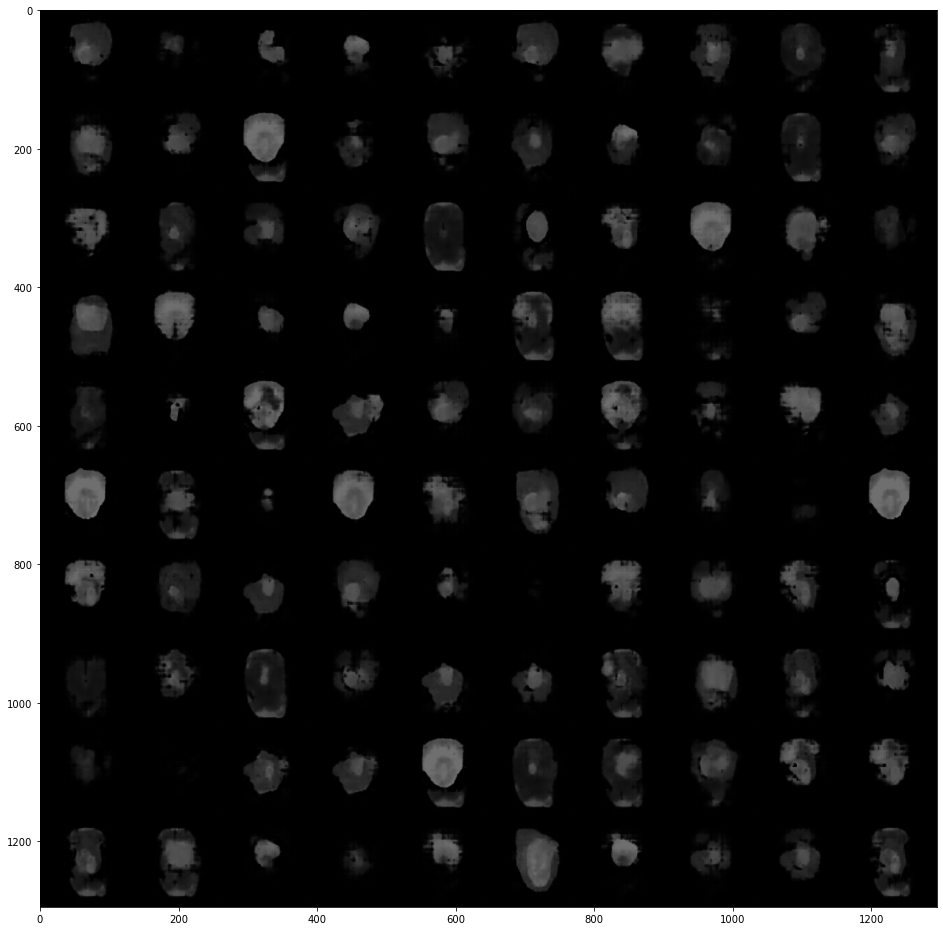

In [81]:
import torchvision
from torchvision import transforms

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images = torch.from_numpy(np.round(np.random.randn(100, 1, im_size[0], im_size[1]))).float()
    images = images.to(device)
    latent = encoder(images)
    latent = latent.cpu()

    #mean = latent.mean(dim=0)
    #print(mean)
    #std = (latent - mean).pow(2).mean(dim=0).sqrt()
    #print(std)

    # sample latent vectors from the normal distribution
    latent = torch.from_numpy(np.round(np.random.rand(128, d))).float()

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(40, 16.5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()


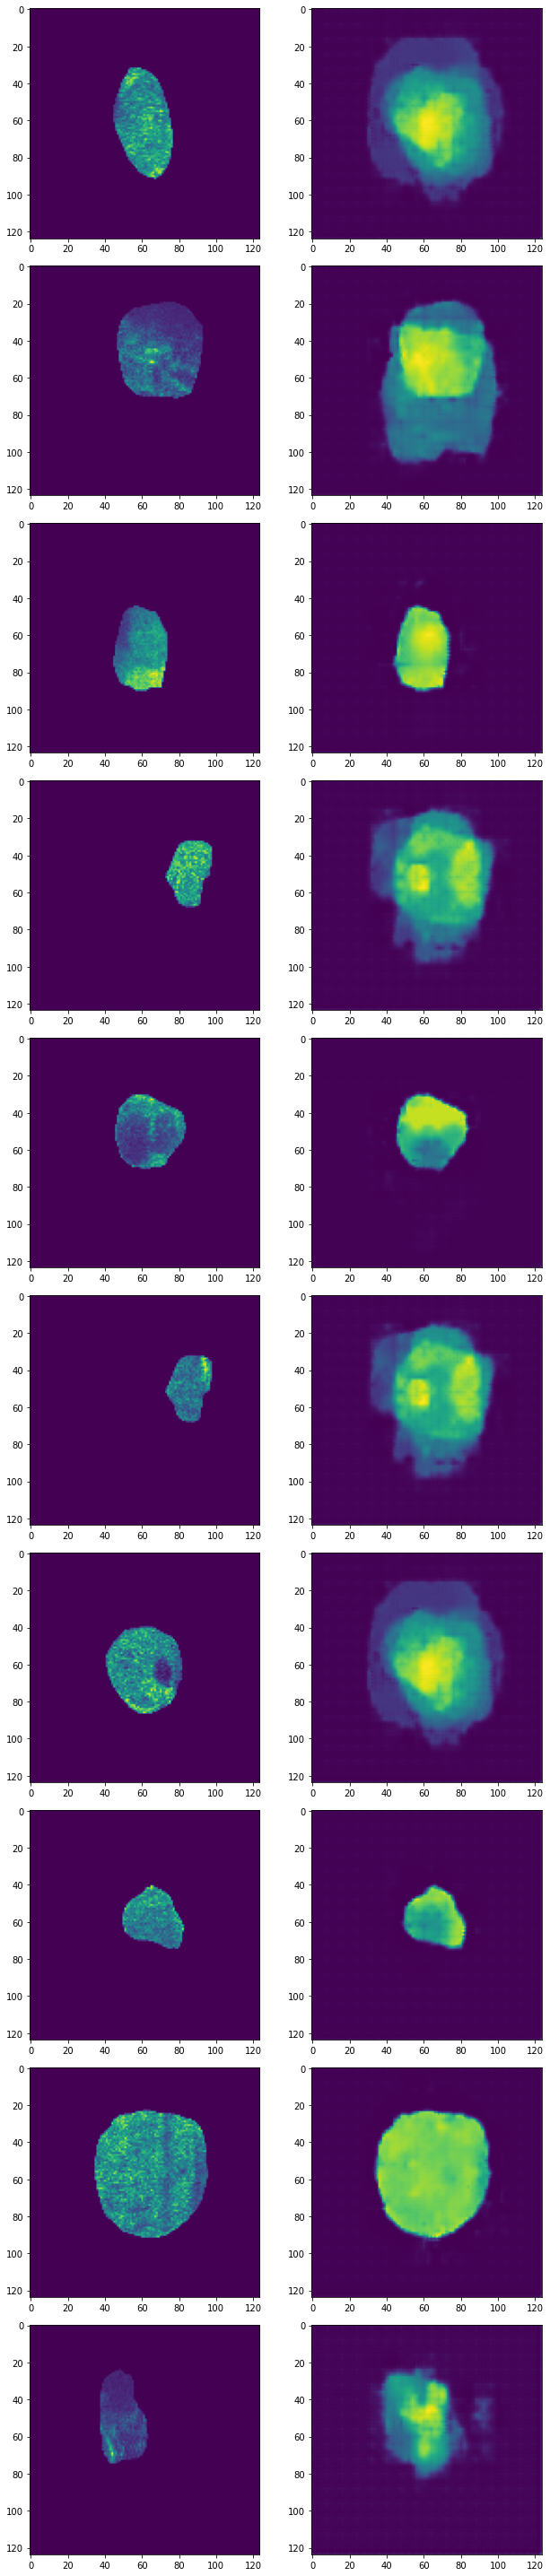

In [86]:
fig, ax = plt.subplots(10, 2, figsize=(10, 40))
fig.set_tight_layout(True)

c = 0
for data in training_generator1: # with "_" we just ignore the labels (the second element of the dataloader tuple)
    # Move tensor to the proper device
    if(c>=10):
        break
    image_batch = data["image"]

    latent = data["labels"].to(device).float()
    
    
    img_recon = decoder(latent)
    img_recon = img_recon.detach().cpu().numpy()
    
    ax[c, 0].imshow(image_batch[0, 0, :, :])
    ax[c, 1].imshow(img_recon[0, 0, :, :])
    
    c += 1
    

plt.tight_layout()
    
    